# Predicting Chess Game Outcomes

## Data Loading and Exploration

In [1]:
# Load the libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
warnings.filterwarnings('ignore')
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim  as optim
import numpy as np
import optuna
from optuna.samplers import GridSampler

In [2]:
#Select GPu if available for processing

device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f'Using {device} for processing')



Using cpu for processing


In [3]:
# Load the csv file
df = pd.read_csv('matmob_data_sample.csv')

In [4]:
#Print shape and one example row
df.shape

(100000, 16)

In [5]:
df.head(1)

,w.mat.mean,w.mat.sd,b.mat.mean,b.mat.sd,w.mob.mean,w.mob.sd,b.mob.mean,b.mob.sd,result,valid.games.row,w.mat.vector,b.mat.vector,w.mob.vector,b.mob.vector,pgn,half.moves
0,28.166667,8.850414,28.135417,9.671031,39.3125,12.951885,27.125,11.296064,1-0,1343406,"39, 39, 39, 39, 39, 39, 39, 39, 38, 38, 38, 38...","39, 39, 39, 39, 39, 39, 39, 38, 38, 38, 38, 38...","20, 28, 30, 32, 30, 40, 40, 45, 49, 47, 49, 51...","20, 22, 28, 34, 34, 35, 31, 32, 33, 30, 30, 28...",1.d4 Nf6 2.c4 e6 3.Nf3 d5 4.cxd5 exd5 5.Qc2 Be...,95


In [6]:
df.describe()

,w.mat.mean,w.mat.sd,b.mat.mean,b.mat.sd,w.mob.mean,w.mob.sd,b.mob.mean,b.mob.sd,valid.games.row,half.moves
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,1.000000e+05,100000.000000
mean,29.471540,7.518266,29.456648,7.556172,33.083914,9.300182,30.808188,8.824375,8.475512e+05,80.524530
std,5.700711,3.590136,5.722296,3.608866,4.899840,2.659605,4.488267,2.583139,4.892308e+05,33.794235
min,7.768683,0.000000,9.127049,0.000000,11.312500,1.707825,12.272727,2.387467,7.000000e+00,6.000000
25%,25.206546,4.674827,25.148607,4.691699,29.653061,7.244109,27.731616,6.879109,4.246160e+05,58.000000
50%,30.317267,7.677324,30.308824,7.716147,33.390244,9.153638,31.000000,8.740191,8.492815e+05,77.000000
75%,34.000000,10.550320,34.017938,10.608270,36.700000,11.164435,33.978723,10.618308,1.268899e+06,100.000000
max,39.000000,16.043718,39.000000,16.394856,50.842105,21.449271,48.250000,20.940381,1.696627e+06,369.000000


In [7]:
df.dtypes

w.mat.mean         float64
w.mat.sd           float64
b.mat.mean         float64
b.mat.sd           float64
w.mob.mean         float64
w.mob.sd           float64
b.mob.mean         float64
b.mob.sd           float64
result              object
valid.games.row      int64
w.mat.vector        object
b.mat.vector        object
w.mob.vector        object
b.mob.vector        object
pgn                 object
half.moves           int64
dtype: object

In [8]:
#Distribution of the result variable using value_counts()
df['result'].value_counts()

result
1-0        36485
1/2-1/2    35810
0-1        27705
Name: count, dtype: int64

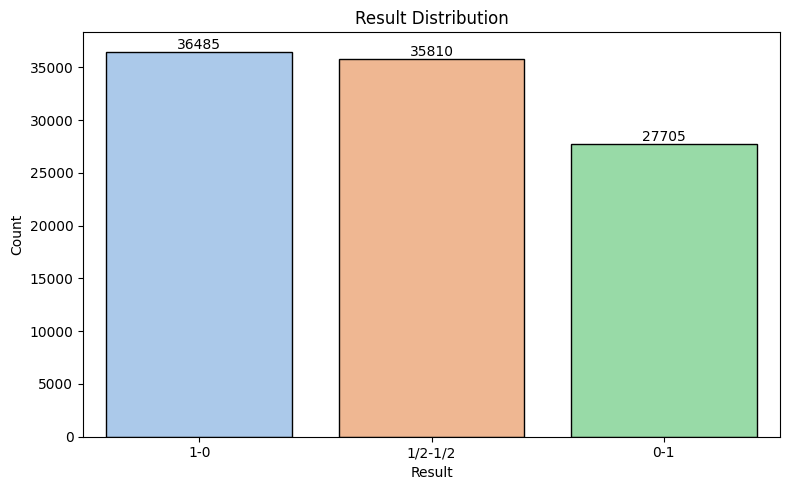

In [9]:
#A labeled bar chart of the result distribution


plt.figure(figsize=(8, 5))

data=df['result'].value_counts().index
values=list(df['result'].value_counts())
ax = sns.barplot(x=data,y=values,palette='pastel', edgecolor='black')

# Add labels on top of bars
for i, row in enumerate(data):
    ax.text(i, float(values[i])+ 0.1, values[i], ha='center', va='bottom')

# Titles and labels
plt.title('Result Distribution')
plt.xlabel('Result')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

## Data Preparation

In [10]:
#Retain only the following 6 columns
new_df=df[['w.mat.mean', 'b.mat.mean', 'w.mob.mean', 'b.mob.mean', 'half.moves', 'result']].copy()

new_df.head()

,w.mat.mean,b.mat.mean,w.mob.mean,b.mob.mean,half.moves,result
0,28.166667,28.135417,39.312500,27.125000,95,1-0
1,33.851852,33.703704,37.185185,33.074074,53,1-0
2,31.301587,31.920635,32.625000,37.451613,62,0-1
3,21.878261,23.260870,27.172414,32.035088,114,0-1
4,34.775510,34.959184,41.040000,32.958333,48,1/2-1/2


In [11]:
#Looking for nul values and empty values
for cols in new_df.columns:
    print(new_df[cols].loc[new_df[cols].isna()==True])
    

Series([], Name: w.mat.mean, dtype: float64)
Series([], Name: b.mat.mean, dtype: float64)
Series([], Name: w.mob.mean, dtype: float64)
Series([], Name: b.mob.mean, dtype: float64)
Series([], Name: half.moves, dtype: int64)
Series([], Name: result, dtype: object)


In [12]:
#Print the shape of new data 
new_df.shape

(100000, 6)

In [13]:
new_df.dtypes

w.mat.mean    float64
b.mat.mean    float64
w.mob.mean    float64
b.mob.mean    float64
half.moves      int64
result         object
dtype: object

In [14]:
#Look for the data characteristics
new_df.describe()

,w.mat.mean,b.mat.mean,w.mob.mean,b.mob.mean,half.moves
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,29.471540,29.456648,33.083914,30.808188,80.524530
std,5.700711,5.722296,4.899840,4.488267,33.794235
min,7.768683,9.127049,11.312500,12.272727,6.000000
25%,25.206546,25.148607,29.653061,27.731616,58.000000
50%,30.317267,30.308824,33.390244,31.000000,77.000000
75%,34.000000,34.017938,36.700000,33.978723,100.000000
max,39.000000,39.000000,50.842105,48.250000,369.000000


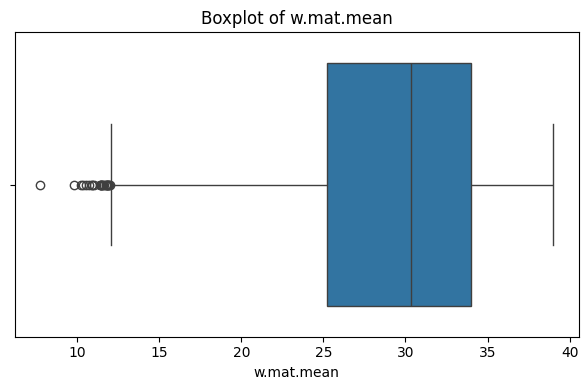

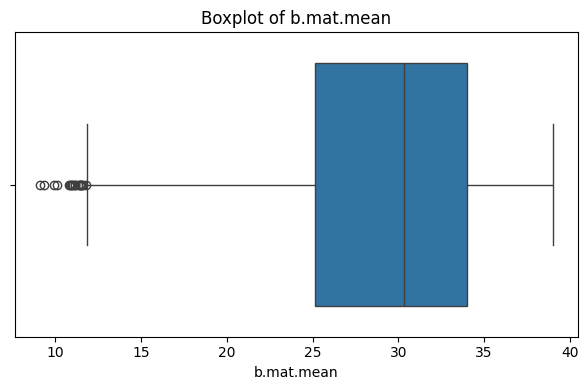

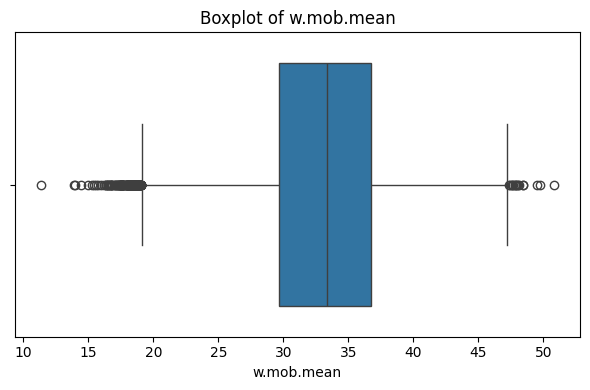

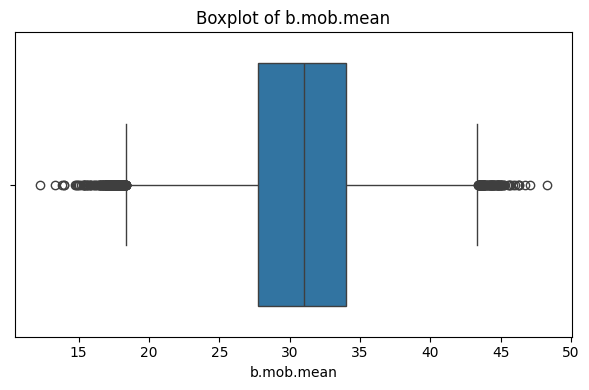

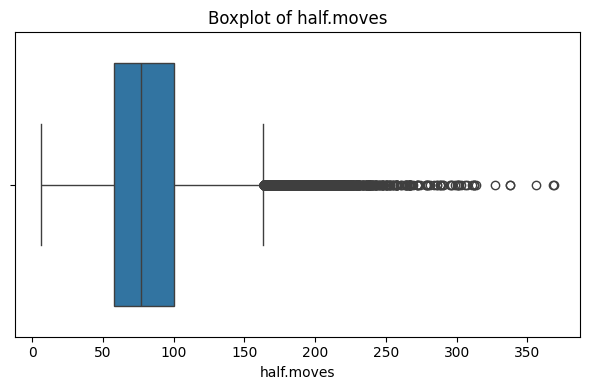

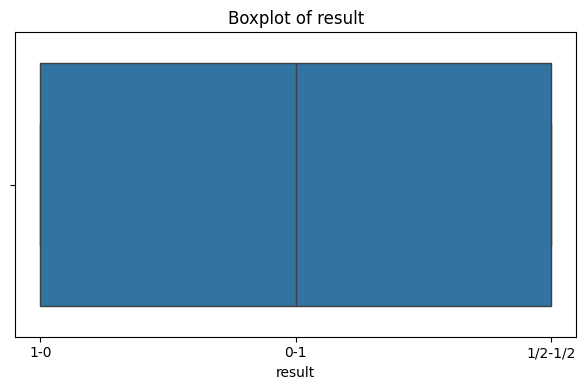

In [15]:
# looking for how the data is spread

for cols in new_df.columns:
    plt.figure(figsize=(6, 4))  # Create a new figure for each boxplot
    sns.boxplot(data=new_df, x=cols)
    plt.title(f'Boxplot of {cols}')
    plt.tight_layout()
    plt.show()

Looks like the data is spread too much and this needs to be scaled.

In [16]:
#Encode result to numeric using the following mapping
new_df.result=new_df.result.map({'1-0':int(1), '0-1':int(0), '1/2-1/2':int(2)})

In [17]:
# Perform an 85% training / 15% test split using train_test_split()
#Train test split
X_train,X_test,y_train,y_test =train_test_split(new_df.drop('result',axis=1),new_df['result'],test_size=0.15,random_state=42)

In [18]:
# Scale the 5 numeric predictor columns using StandardScaler() 
# Test upload
scalar=StandardScaler()

X_train=scalar.fit_transform(X_train)
X_test=scalar.transform(X_test)

In [19]:
# Setting up the Dataset and the Data Loader

class CustomDataSet(Dataset):
    def __init__(self,features,labels):
        self.features=torch.tensor(features,dtype=torch.float32)
        self.labels=torch.tensor(np.array(labels),dtype=torch.long)
    def __len__(self):
        return len( self.features)
    
    def __getitem__(self, index):
        return(self.features[index],self.labels[index])

train_dataset=CustomDataSet(X_train,y_train)
test_dataset=CustomDataSet(X_test,y_test)

train_loader=DataLoader(train_dataset,batch_size=128,shuffle=True,pin_memory=True)
test_loader=DataLoader(test_dataset,batch_size=128,shuffle=False,pin_memory=True)

In [20]:
#Define the Neural network Class
class MyNN(nn.Module):
    def __init__(self,input_featutes):
        super().__init__()
        self.features=nn.Sequential(
            nn.Linear(input_featutes,50),
            nn.ReLU(),
            nn.Linear(50,3),
            # nn.Softmax(dim=1)
        )

    def forward(self,x):
        x=self.features(x)
        return x

In [21]:
#Define the Learning rate and Epochs
learning_rate=0.05
epochs = 100

In [22]:

#Deine the model with the criterion and optimizer

model=MyNN(X_train.shape[1])

model.to(device)

criterion= nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(),lr=learning_rate,weight_decay=1e-4)


In [23]:
# training loop
train_losses = []
train_accuracies = []
total=0
correct=0

for epoch in range(epochs):
    total_epoch_loss=0

    for batch_features,batch_labels in train_loader:

        #move data to gpu
        batch_features,batch_labels=batch_features.to(device),batch_labels.to(device)

        #Forward pass
        outputs=model(batch_features)

        #Calculate loss
        loss= criterion(outputs,batch_labels)

        #backpass
        optimizer.zero_grad()
        loss.backward()

        #update grads
        optimizer.step()

        total_epoch_loss= total_epoch_loss+loss.item()
        
        _, predicted = torch.max(outputs.data, 1)
        total += batch_labels.size(0)
        correct += (predicted == batch_labels).sum().item()
        # print(f'predicted:{predicted}Labels {batch_labels}')
    # Calculate average loss and accuracy for the epoch
    avg_loss=total_epoch_loss/len(train_loader)
    epoch_accuracy = 100 * correct / total
    train_losses.append(avg_loss)
    train_accuracies.append(epoch_accuracy)
    print(f'Epoch {epoch +1 }, Loss: {avg_loss}')

Epoch 1, Loss: 0.9476368933692014
Epoch 2, Loss: 0.9090824578041421
Epoch 3, Loss: 0.8801796050896322
Epoch 4, Loss: 0.8495972777667798
Epoch 5, Loss: 0.8268917082843924
Epoch 6, Loss: 0.8157872054809915
Epoch 7, Loss: 0.8103606513568333
Epoch 8, Loss: 0.8072246610670162
Epoch 9, Loss: 0.8053441673293149
Epoch 10, Loss: 0.804260038746927
Epoch 11, Loss: 0.8041069864330436
Epoch 12, Loss: 0.8032097981388407
Epoch 13, Loss: 0.802244398378788
Epoch 14, Loss: 0.8022113690698953
Epoch 15, Loss: 0.8021485403964393
Epoch 16, Loss: 0.8022624282012308
Epoch 17, Loss: 0.8016825613222625
Epoch 18, Loss: 0.8014040142073667
Epoch 19, Loss: 0.8011840391876106
Epoch 20, Loss: 0.8011062711701358
Epoch 21, Loss: 0.8004250289802265
Epoch 22, Loss: 0.8004750630909339
Epoch 23, Loss: 0.7997778180846594
Epoch 24, Loss: 0.8004192598780295
Epoch 25, Loss: 0.8000642431409736
Epoch 26, Loss: 0.7997852226845303
Epoch 27, Loss: 0.7996996991616443
Epoch 28, Loss: 0.7991274834575509
Epoch 29, Loss: 0.7991905918694

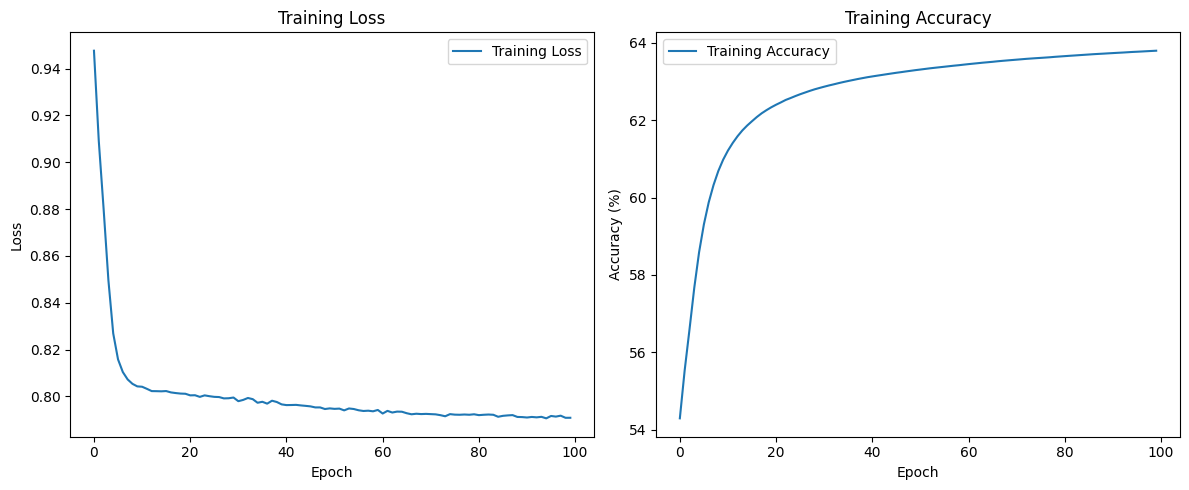

In [24]:
# Plot
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [25]:
# Evaluate and print test accuracy.

#Set model to eval model
model.eval()

#Evaluation Code

total=0
correct=0

with torch.no_grad():
    for batch_features, batch_labels in test_loader:
        outputs=model(batch_features)
        _, predicted=torch.max(outputs,1)

        total = total + batch_labels.shape[0]
        correct= correct+(predicted==batch_labels).sum().item()
print(f'Evaluation accuracy {correct/total}')

Evaluation accuracy 0.6358


# Hyperparameter Tuning via Manual Grid Search

In [26]:
class MyNN(nn.Module):
    def __init__(self,input_dim,output_dim,hidden_layers,neurons_per_layer,act_functn):
        super().__init__()

        layers =[]
        
        for i in range(hidden_layers):
            layers.append(nn.Linear(input_dim,neurons_per_layer))
            if act_functn=='relu':
                   layers.append(nn.ReLU())
            elif act_functn=='tanh':
                   layers.append(nn.Tanh())
            elif act_functn=='sigmoid':
                layers.append(nn.Sigmoid())
            # layers.append(nn.Dropout(drop_out_rate))
            input_dim=neurons_per_layer
        layers.append(nn.Linear(neurons_per_layer,output_dim))
        # layers.append(nn.Softmax())

        self.model=nn.Sequential(*layers)

    def forward (self,x):
        x=self.model(x)
        return (x)


In [27]:
search_space={'hidden_layers':[1,2],'neurons_per_layer':[50,60],'act_functn':['relu','tanh','sigmoid'],'optimizer_name':['Adam','SGD','RMSprop'],'learning_rate':[0.001, 0.01,0.02],'batch_size':[100,128,],'epochs':[75,100]}

#objective function

def objective(trial):
    hidden_layers=trial.suggest_categorical('hidden_layers',search_space['hidden_layers'])
    act_functn=trial.suggest_categorical('act_functn',search_space['act_functn'])
    optimizer_name=trial.suggest_categorical('optimizer_name',search_space['optimizer_name'])
    learning_rate=trial.suggest_categorical('learning_rate',search_space['learning_rate'])
    batch_size=trial.suggest_categorical('batch_size',search_space['batch_size'])
    epochs=trial.suggest_categorical('epochs',search_space['epochs'])
    neurons_per_layer=trial.suggest_categorical('neurons_per_layer',search_space['neurons_per_layer'])
    # dropout=trial.suggest_categorical('dropout',search_space['dropout'])

    input_shape=X_train.shape[1]
    output_shape=3

    model=MyNN(input_shape,output_shape,hidden_layers,neurons_per_layer,act_functn)
    model.to(device)

    #Loss Function
    criterion= nn.CrossEntropyLoss()
    

    if optimizer_name=='Adam':
        optimizer =  optim.Adam(model.parameters(),lr=learning_rate)

    elif optimizer_name=='SGD':
        optimizer =  optim.SGD(model.parameters(),lr=learning_rate)

    elif optimizer_name=='RMSprop':
        optimizer =  optim.RMSprop(model.parameters(),lr=learning_rate)
    
    # print(optimizer)


    train_loader=DataLoader(train_dataset,batch_size=batch_size,shuffle=True,pin_memory=True)
    test_loader=DataLoader(test_dataset,batch_size=batch_size,shuffle=False,pin_memory=True)

    for epoch in range(epochs):
        total_epoch_loss=0
        total=0
        correct=0

        for batch_features,batch_labels in train_loader:

            #move data to gpu
            batch_features,batch_labels=batch_features.to(device),batch_labels.to(device)

            #Forward pass
            outputs=model(batch_features)

            #Calculate loss
            loss= criterion(outputs,batch_labels)

            #backpass
            optimizer.zero_grad()
            loss.backward()

            #update grads
            optimizer.step()

            total_epoch_loss= total_epoch_loss+loss.item()
            
            _, predicted = torch.max(outputs.data, 1)
            total += batch_labels.size(0)
            correct += (predicted == batch_labels).sum().item()
            # print(f'predicted:{predicted}Labels {batch_labels}')
        # Calculate average loss and accuracy for the epoch
        avg_loss=total_epoch_loss/len(train_loader)
        epoch_accuracy = 100 * correct / total
        train_losses.append(avg_loss)
        train_accuracies.append(epoch_accuracy)
        print(f'Epoch {epoch +1 }, Training Loss: {avg_loss}')

        # # Plot
        # plt.figure(figsize=(12, 5))

        # plt.subplot(1, 2, 1)
        # plt.plot(train_losses, label='Training Loss')
        # plt.xlabel('Epoch')
        # plt.ylabel('Loss')
        # plt.title('Training Loss')
        # plt.legend()

        # plt.subplot(1, 2, 2)
        # plt.plot(train_accuracies, label='Training Accuracy')
        # plt.xlabel('Epoch')
        # plt.ylabel('Accuracy (%)')
        # plt.title('Training Accuracy')
        # plt.legend()

        # plt.tight_layout()
        # plt.show()

        # Evaluate and print test accuracy.

    #Set model to eval model
    model.eval()

    #Evaluation Code

    total=0
    correct=0

    with torch.no_grad():
        for batch_features, batch_labels in test_loader:
            outputs=model(batch_features)
            _, predicted=torch.max(outputs,1)

            total = total + batch_labels.shape[0]
            correct= correct+(predicted==batch_labels).sum().item()
    accuracy=correct/total
    
    # print(f'Evaluation accuracy with model parameters:  Learning rate: {learning_rate} batchsize : {batch_size} is : {accuracy}')

    return accuracy
    






In [28]:
sampler = GridSampler(search_space)
study= optuna.create_study(direction='maximize', sampler=sampler)
study.optimize(objective)

[I 2025-06-22 09:21:06,084] A new study created in memory with name: no-name-b5fc7ceb-0151-44bc-9b36-60a9feb03b09


Epoch 1, Training Loss: 0.9760593723549562
Epoch 2, Training Loss: 0.9468434096785152
Epoch 3, Training Loss: 0.9359801716664258
Epoch 4, Training Loss: 0.9253400618188521
Epoch 5, Training Loss: 0.9144791279119604
Epoch 6, Training Loss: 0.9035625074190252
Epoch 7, Training Loss: 0.8927469309638528
Epoch 8, Training Loss: 0.8821313675712137
Epoch 9, Training Loss: 0.8720270440157722
Epoch 10, Training Loss: 0.8627826918573941
Epoch 11, Training Loss: 0.8544744569413802
Epoch 12, Training Loss: 0.8471237993941587
Epoch 13, Training Loss: 0.8408524423487046
Epoch 14, Training Loss: 0.8354724664547865
Epoch 15, Training Loss: 0.8309378437434926
Epoch 16, Training Loss: 0.827291054725647
Epoch 17, Training Loss: 0.8242212590750526
Epoch 18, Training Loss: 0.821631270717172
Epoch 19, Training Loss: 0.8196618085749009
Epoch 20, Training Loss: 0.817948413806803
Epoch 21, Training Loss: 0.816525716010262
Epoch 22, Training Loss: 0.8154157219914829
Epoch 23, Training Loss: 0.8143001355143155
E

[I 2025-06-22 09:22:16,130] Trial 0 finished with value: 0.6339333333333333 and parameters: {'hidden_layers': 1, 'act_functn': 'tanh', 'optimizer_name': 'SGD', 'learning_rate': 0.01, 'batch_size': 100, 'epochs': 75, 'neurons_per_layer': 60}. Best is trial 0 with value: 0.6339333333333333.


Epoch 75, Training Loss: 0.8015832279008978
Epoch 1, Training Loss: 0.8706890151913005
Epoch 2, Training Loss: 0.8147549634589288
Epoch 3, Training Loss: 0.8078567391947696
Epoch 4, Training Loss: 0.8049548301481663
Epoch 5, Training Loss: 0.8034344971628118
Epoch 6, Training Loss: 0.798156381997847
Epoch 7, Training Loss: 0.7980997842057307
Epoch 8, Training Loss: 0.796421862365608
Epoch 9, Training Loss: 0.794511308078479
Epoch 10, Training Loss: 0.7946345857211522
Epoch 11, Training Loss: 0.7935823856439805
Epoch 12, Training Loss: 0.7940533562710411
Epoch 13, Training Loss: 0.7924309618490979
Epoch 14, Training Loss: 0.7932731805887437
Epoch 15, Training Loss: 0.7922138090420486
Epoch 16, Training Loss: 0.7919268655597715
Epoch 17, Training Loss: 0.7911348597447675
Epoch 18, Training Loss: 0.7906938070641425
Epoch 19, Training Loss: 0.7921892290724848
Epoch 20, Training Loss: 0.7904094282845805
Epoch 21, Training Loss: 0.7907936940515848
Epoch 22, Training Loss: 0.7906712796455039


[I 2025-06-22 09:23:41,183] Trial 1 finished with value: 0.6357333333333334 and parameters: {'hidden_layers': 2, 'act_functn': 'sigmoid', 'optimizer_name': 'Adam', 'learning_rate': 0.02, 'batch_size': 128, 'epochs': 75, 'neurons_per_layer': 50}. Best is trial 1 with value: 0.6357333333333334.


Epoch 75, Training Loss: 0.784171792349421
Epoch 1, Training Loss: 0.8883932950216181
Epoch 2, Training Loss: 0.8117452129195718
Epoch 3, Training Loss: 0.8052494128311382
Epoch 4, Training Loss: 0.8030415272712708
Epoch 5, Training Loss: 0.8006928433390225
Epoch 6, Training Loss: 0.7986036473162034
Epoch 7, Training Loss: 0.7978807954928454
Epoch 8, Training Loss: 0.7969815034726087
Epoch 9, Training Loss: 0.7956643078607671
Epoch 10, Training Loss: 0.7945313697702745
Epoch 11, Training Loss: 0.792880657490562
Epoch 12, Training Loss: 0.7914567335212932
Epoch 13, Training Loss: 0.7901396720549639
Epoch 14, Training Loss: 0.78978880833177
Epoch 15, Training Loss: 0.7892907768137315
Epoch 16, Training Loss: 0.7888880688302657
Epoch 17, Training Loss: 0.7883030907546773
Epoch 18, Training Loss: 0.7876193375447217
Epoch 19, Training Loss: 0.7869604532858905
Epoch 20, Training Loss: 0.7863005924224854
Epoch 21, Training Loss: 0.7858507076431723
Epoch 22, Training Loss: 0.7857575666203218
E

[I 2025-06-22 09:25:53,169] Trial 2 finished with value: 0.6389333333333334 and parameters: {'hidden_layers': 2, 'act_functn': 'relu', 'optimizer_name': 'Adam', 'learning_rate': 0.001, 'batch_size': 100, 'epochs': 100, 'neurons_per_layer': 50}. Best is trial 2 with value: 0.6389333333333334.


Epoch 100, Training Loss: 0.7770736574425416
Epoch 1, Training Loss: 1.0675527129453772
Epoch 2, Training Loss: 1.0286191394048578
Epoch 3, Training Loss: 1.0053329504938686
Epoch 4, Training Loss: 0.9900265312194825
Epoch 5, Training Loss: 0.9798980452733881
Epoch 6, Training Loss: 0.9732075503293206
Epoch 7, Training Loss: 0.9687370807283064
Epoch 8, Training Loss: 0.9656543507996728
Epoch 9, Training Loss: 0.9634404901195975
Epoch 10, Training Loss: 0.961740565440234
Epoch 11, Training Loss: 0.9603508798515096
Epoch 12, Training Loss: 0.9591361499533934
Epoch 13, Training Loss: 0.9580292479430927
Epoch 14, Training Loss: 0.9569862423223607
Epoch 15, Training Loss: 0.9559699947693768
Epoch 16, Training Loss: 0.954976412338369
Epoch 17, Training Loss: 0.9539874856612262
Epoch 18, Training Loss: 0.9529995620250702
Epoch 19, Training Loss: 0.9519991064071656
Epoch 20, Training Loss: 0.9510016686776105
Epoch 21, Training Loss: 0.9499832019385169
Epoch 22, Training Loss: 0.948954352070303

[I 2025-06-22 09:27:37,233] Trial 3 finished with value: 0.6206 and parameters: {'hidden_layers': 2, 'act_functn': 'tanh', 'optimizer_name': 'SGD', 'learning_rate': 0.001, 'batch_size': 100, 'epochs': 100, 'neurons_per_layer': 50}. Best is trial 2 with value: 0.6389333333333334.


Epoch 100, Training Loss: 0.8238496854024775
Epoch 1, Training Loss: 0.9864907323612886
Epoch 2, Training Loss: 0.9390150266535142
Epoch 3, Training Loss: 0.9284145656753989
Epoch 4, Training Loss: 0.9207891790305867
Epoch 5, Training Loss: 0.914372659220415
Epoch 6, Training Loss: 0.9084101645385518
Epoch 7, Training Loss: 0.9024661141283372
Epoch 8, Training Loss: 0.8964842926754671
Epoch 9, Training Loss: 0.8901482241995194
Epoch 10, Training Loss: 0.8833308687630822
Epoch 11, Training Loss: 0.8760969593244441
Epoch 12, Training Loss: 0.8686967816072352
Epoch 13, Training Loss: 0.8611265055572286
Epoch 14, Training Loss: 0.8536994237058303
Epoch 15, Training Loss: 0.846674872005687
Epoch 16, Training Loss: 0.839994703391019
Epoch 17, Training Loss: 0.8342465392982259
Epoch 18, Training Loss: 0.8290080660230973
Epoch 19, Training Loss: 0.8245808509518119
Epoch 20, Training Loss: 0.8209525926674114
Epoch 21, Training Loss: 0.8178869676589966
Epoch 22, Training Loss: 0.8153010660760542

[I 2025-06-22 09:28:46,272] Trial 4 finished with value: 0.6364 and parameters: {'hidden_layers': 1, 'act_functn': 'relu', 'optimizer_name': 'SGD', 'learning_rate': 0.01, 'batch_size': 100, 'epochs': 75, 'neurons_per_layer': 60}. Best is trial 2 with value: 0.6389333333333334.


Epoch 75, Training Loss: 0.7960772259796367
Epoch 1, Training Loss: 0.8498208867802339
Epoch 2, Training Loss: 0.8210680193059585
Epoch 3, Training Loss: 0.8173099057113423
Epoch 4, Training Loss: 0.8148494346001569
Epoch 5, Training Loss: 0.8123356537959155
Epoch 6, Training Loss: 0.8121256495223326
Epoch 7, Training Loss: 0.8099922975371866
Epoch 8, Training Loss: 0.809430210239747
Epoch 9, Training Loss: 0.8074684533652138
Epoch 10, Training Loss: 0.807631158618366
Epoch 11, Training Loss: 0.8068281350416295
Epoch 12, Training Loss: 0.8090357408102821
Epoch 13, Training Loss: 0.8073560556243448
Epoch 14, Training Loss: 0.8070857003857108
Epoch 15, Training Loss: 0.8060340033559238
Epoch 16, Training Loss: 0.8045502256645876
Epoch 17, Training Loss: 0.8056320413421182
Epoch 18, Training Loss: 0.8059139569366679
Epoch 19, Training Loss: 0.8045404483290279
Epoch 20, Training Loss: 0.8058384239673615
Epoch 21, Training Loss: 0.804000446656171
Epoch 22, Training Loss: 0.8040138334386489


[I 2025-06-22 09:30:11,885] Trial 5 finished with value: 0.6294666666666666 and parameters: {'hidden_layers': 1, 'act_functn': 'tanh', 'optimizer_name': 'Adam', 'learning_rate': 0.01, 'batch_size': 100, 'epochs': 75, 'neurons_per_layer': 60}. Best is trial 2 with value: 0.6389333333333334.


Epoch 75, Training Loss: 0.7961943291215335
Epoch 1, Training Loss: 0.8891367528719061
Epoch 2, Training Loss: 0.8222721184001249
Epoch 3, Training Loss: 0.8156676404616412
Epoch 4, Training Loss: 0.8111233756822698
Epoch 5, Training Loss: 0.8062971225906821
Epoch 6, Training Loss: 0.8020406685155981
Epoch 7, Training Loss: 0.7997197721284979
Epoch 8, Training Loss: 0.7980636020968942
Epoch 9, Training Loss: 0.796605109467226
Epoch 10, Training Loss: 0.7947269178839291
Epoch 11, Training Loss: 0.7940368291910956
Epoch 12, Training Loss: 0.792315918487661
Epoch 13, Training Loss: 0.7927128070242264
Epoch 14, Training Loss: 0.7915098503757926
Epoch 15, Training Loss: 0.7910292223621818
Epoch 16, Training Loss: 0.790757698171279
Epoch 17, Training Loss: 0.7905519455320695
Epoch 18, Training Loss: 0.7902031315074247
Epoch 19, Training Loss: 0.7899395561919493
Epoch 20, Training Loss: 0.7891816448464113
Epoch 21, Training Loss: 0.7894913395012126
Epoch 22, Training Loss: 0.7890539397912867


[I 2025-06-22 09:32:14,008] Trial 6 finished with value: 0.6372666666666666 and parameters: {'hidden_layers': 2, 'act_functn': 'sigmoid', 'optimizer_name': 'RMSprop', 'learning_rate': 0.01, 'batch_size': 100, 'epochs': 100, 'neurons_per_layer': 50}. Best is trial 2 with value: 0.6389333333333334.


Epoch 100, Training Loss: 0.7828595045734854
Epoch 1, Training Loss: 0.8409616178139708
Epoch 2, Training Loss: 0.814973198829737
Epoch 3, Training Loss: 0.808300324759089
Epoch 4, Training Loss: 0.8057904265877
Epoch 5, Training Loss: 0.8037211254127044
Epoch 6, Training Loss: 0.8062529084377719
Epoch 7, Training Loss: 0.8029466582420177
Epoch 8, Training Loss: 0.8014576998868383
Epoch 9, Training Loss: 0.8016810708476189
Epoch 10, Training Loss: 0.8005321494618752
Epoch 11, Training Loss: 0.8014641483923546
Epoch 12, Training Loss: 0.7985579627797119
Epoch 13, Training Loss: 0.8010299341122907
Epoch 14, Training Loss: 0.7996824018937304
Epoch 15, Training Loss: 0.7994250388073741
Epoch 16, Training Loss: 0.7981717091753967
Epoch 17, Training Loss: 0.7993378739607961
Epoch 18, Training Loss: 0.798233021201944
Epoch 19, Training Loss: 0.7972221560047982
Epoch 20, Training Loss: 0.7990195346057863
Epoch 21, Training Loss: 0.7971442842842045
Epoch 22, Training Loss: 0.7993182787321564
Ep

[I 2025-06-22 09:33:39,058] Trial 7 finished with value: 0.634 and parameters: {'hidden_layers': 2, 'act_functn': 'relu', 'optimizer_name': 'Adam', 'learning_rate': 0.02, 'batch_size': 128, 'epochs': 75, 'neurons_per_layer': 50}. Best is trial 2 with value: 0.6389333333333334.


Epoch 75, Training Loss: 0.7969200909585881
Epoch 1, Training Loss: 0.8937653549631736
Epoch 2, Training Loss: 0.8267773118234218
Epoch 3, Training Loss: 0.8182755238131473
Epoch 4, Training Loss: 0.8159709951931373
Epoch 5, Training Loss: 0.8121080883463523
Epoch 6, Training Loss: 0.8105923895549058
Epoch 7, Training Loss: 0.808597215136191
Epoch 8, Training Loss: 0.8081216087914947
Epoch 9, Training Loss: 0.8065563945841968
Epoch 10, Training Loss: 0.8068041476091944
Epoch 11, Training Loss: 0.8041198532384141
Epoch 12, Training Loss: 0.8047890794904609
Epoch 13, Training Loss: 0.8046640640810916
Epoch 14, Training Loss: 0.803121066451969
Epoch 15, Training Loss: 0.8018484013421195
Epoch 16, Training Loss: 0.8032328137777802
Epoch 17, Training Loss: 0.8021031272142454
Epoch 18, Training Loss: 0.802086936083055
Epoch 19, Training Loss: 0.801636364675106
Epoch 20, Training Loss: 0.8012702851815331
Epoch 21, Training Loss: 0.8005966411497359
Epoch 22, Training Loss: 0.8010202774427887
E

[I 2025-06-22 09:35:01,087] Trial 8 finished with value: 0.5224 and parameters: {'hidden_layers': 2, 'act_functn': 'relu', 'optimizer_name': 'RMSprop', 'learning_rate': 0.02, 'batch_size': 128, 'epochs': 75, 'neurons_per_layer': 60}. Best is trial 2 with value: 0.6389333333333334.


Epoch 75, Training Loss: 0.7986572758595746
Epoch 1, Training Loss: 0.9771949274399702
Epoch 2, Training Loss: 0.9435537600517273
Epoch 3, Training Loss: 0.9250832664265353
Epoch 4, Training Loss: 0.9057494124244241
Epoch 5, Training Loss: 0.8861456661364612
Epoch 6, Training Loss: 0.8675628340945525
Epoch 7, Training Loss: 0.8514152530361624
Epoch 8, Training Loss: 0.8387264691380893
Epoch 9, Training Loss: 0.8293338974784402
Epoch 10, Training Loss: 0.8229183339371401
Epoch 11, Training Loss: 0.8186043512119966
Epoch 12, Training Loss: 0.8155342728250167
Epoch 13, Training Loss: 0.81330006999128
Epoch 14, Training Loss: 0.8117932192718281
Epoch 15, Training Loss: 0.8107116388573367
Epoch 16, Training Loss: 0.8098428672902724
Epoch 17, Training Loss: 0.8089993716688717
Epoch 18, Training Loss: 0.8081562479804544
Epoch 19, Training Loss: 0.8079087591171265
Epoch 20, Training Loss: 0.8071389182174907
Epoch 21, Training Loss: 0.8066008566407596
Epoch 22, Training Loss: 0.806092096637277


[I 2025-06-22 09:36:09,872] Trial 9 finished with value: 0.6334666666666666 and parameters: {'hidden_layers': 1, 'act_functn': 'tanh', 'optimizer_name': 'SGD', 'learning_rate': 0.02, 'batch_size': 100, 'epochs': 75, 'neurons_per_layer': 50}. Best is trial 2 with value: 0.6389333333333334.


Epoch 75, Training Loss: 0.7979885742243599
Epoch 1, Training Loss: 0.8948174834952635
Epoch 2, Training Loss: 0.80953339324278
Epoch 3, Training Loss: 0.8038190984024721
Epoch 4, Training Loss: 0.8002939696171705
Epoch 5, Training Loss: 0.7987435967781964
Epoch 6, Training Loss: 0.7971267409885631
Epoch 7, Training Loss: 0.7950128693440381
Epoch 8, Training Loss: 0.7933382728520562
Epoch 9, Training Loss: 0.7923899345538196
Epoch 10, Training Loss: 0.7911579023389256
Epoch 11, Training Loss: 0.7905484558554257
Epoch 12, Training Loss: 0.7889412358929129
Epoch 13, Training Loss: 0.7887323422992931
Epoch 14, Training Loss: 0.7886734395167407
Epoch 15, Training Loss: 0.7878544022756464
Epoch 16, Training Loss: 0.7874632819259868
Epoch 17, Training Loss: 0.7870879089832306
Epoch 18, Training Loss: 0.7869174310039071
Epoch 19, Training Loss: 0.7866378299628987
Epoch 20, Training Loss: 0.7855469332021825
Epoch 21, Training Loss: 0.7857517344811383
Epoch 22, Training Loss: 0.7851277854162104

[I 2025-06-22 09:37:48,486] Trial 10 finished with value: 0.6420666666666667 and parameters: {'hidden_layers': 2, 'act_functn': 'relu', 'optimizer_name': 'Adam', 'learning_rate': 0.001, 'batch_size': 100, 'epochs': 75, 'neurons_per_layer': 60}. Best is trial 10 with value: 0.6420666666666667.


Epoch 75, Training Loss: 0.7779432363369886
Epoch 1, Training Loss: 1.0879346905035132
Epoch 2, Training Loss: 1.0807973881328807
Epoch 3, Training Loss: 1.0712079977989197
Epoch 4, Training Loss: 1.0569628061967737
Epoch 5, Training Loss: 1.0361524985818302
Epoch 6, Training Loss: 1.0093252295606276
Epoch 7, Training Loss: 0.9841788503001718
Epoch 8, Training Loss: 0.9686284572937909
Epoch 9, Training Loss: 0.961976515826057
Epoch 10, Training Loss: 0.9590366629993214
Epoch 11, Training Loss: 0.9573102384455063
Epoch 12, Training Loss: 0.9558977758183199
Epoch 13, Training Loss: 0.9542482793331146
Epoch 14, Training Loss: 0.9528039726089029
Epoch 15, Training Loss: 0.9511571213778327
Epoch 16, Training Loss: 0.9494842109259437
Epoch 17, Training Loss: 0.9477564390266643
Epoch 18, Training Loss: 0.945853029980379
Epoch 19, Training Loss: 0.9438207774302538
Epoch 20, Training Loss: 0.9417354514318353
Epoch 21, Training Loss: 0.9394288319699905
Epoch 22, Training Loss: 0.936782394507352


[I 2025-06-22 09:39:05,306] Trial 11 finished with value: 0.6280666666666667 and parameters: {'hidden_layers': 2, 'act_functn': 'sigmoid', 'optimizer_name': 'SGD', 'learning_rate': 0.02, 'batch_size': 100, 'epochs': 75, 'neurons_per_layer': 50}. Best is trial 10 with value: 0.6420666666666667.


Epoch 75, Training Loss: 0.8084987454554614
Epoch 1, Training Loss: 0.8898895963500528
Epoch 2, Training Loss: 0.8215631102113162
Epoch 3, Training Loss: 0.8129513109431548
Epoch 4, Training Loss: 0.8099241669037763
Epoch 5, Training Loss: 0.8052485512284672
Epoch 6, Training Loss: 0.8023961068602169
Epoch 7, Training Loss: 0.7996528812716989
Epoch 8, Training Loss: 0.7975396275520324
Epoch 9, Training Loss: 0.7956925869689269
Epoch 10, Training Loss: 0.7946525935565724
Epoch 11, Training Loss: 0.7941075473673204
Epoch 12, Training Loss: 0.7935459791912752
Epoch 13, Training Loss: 0.7921815030013813
Epoch 14, Training Loss: 0.7920238108494703
Epoch 15, Training Loss: 0.791031184757457
Epoch 16, Training Loss: 0.7910503806086148
Epoch 17, Training Loss: 0.7905488194437588
Epoch 18, Training Loss: 0.7899749342133017
Epoch 19, Training Loss: 0.7895062320372638
Epoch 20, Training Loss: 0.7896019553436953
Epoch 21, Training Loss: 0.7889618630268994
Epoch 22, Training Loss: 0.788687521639992

[I 2025-06-22 09:40:36,750] Trial 12 finished with value: 0.6417333333333334 and parameters: {'hidden_layers': 2, 'act_functn': 'sigmoid', 'optimizer_name': 'RMSprop', 'learning_rate': 0.01, 'batch_size': 100, 'epochs': 75, 'neurons_per_layer': 60}. Best is trial 10 with value: 0.6420666666666667.


Epoch 75, Training Loss: 0.7831360267891604
Epoch 1, Training Loss: 0.8502603256612792
Epoch 2, Training Loss: 0.820236499327466
Epoch 3, Training Loss: 0.8175538388410009
Epoch 4, Training Loss: 0.8162342253484224
Epoch 5, Training Loss: 0.8134270223459803
Epoch 6, Training Loss: 0.8109935742571838
Epoch 7, Training Loss: 0.8122151821179497
Epoch 8, Training Loss: 0.8119949788079226
Epoch 9, Training Loss: 0.8132753153492633
Epoch 10, Training Loss: 0.8125988582023105
Epoch 11, Training Loss: 0.8112346050434542
Epoch 12, Training Loss: 0.8102855396450014
Epoch 13, Training Loss: 0.8107354212524299
Epoch 14, Training Loss: 0.8095418134130034
Epoch 15, Training Loss: 0.8088255340891674
Epoch 16, Training Loss: 0.8092470727468791
Epoch 17, Training Loss: 0.8087538863483228
Epoch 18, Training Loss: 0.8091842185285755
Epoch 19, Training Loss: 0.8100773004660929
Epoch 20, Training Loss: 0.8088970046294363
Epoch 21, Training Loss: 0.8100899915946157
Epoch 22, Training Loss: 0.807529075074016

[I 2025-06-22 09:41:50,899] Trial 13 finished with value: 0.6306 and parameters: {'hidden_layers': 1, 'act_functn': 'tanh', 'optimizer_name': 'Adam', 'learning_rate': 0.02, 'batch_size': 128, 'epochs': 75, 'neurons_per_layer': 60}. Best is trial 10 with value: 0.6420666666666667.


Epoch 75, Training Loss: 0.8001393605891923
Epoch 1, Training Loss: 0.8793874687307022
Epoch 2, Training Loss: 0.8375136636285221
Epoch 3, Training Loss: 0.8315448971355662
Epoch 4, Training Loss: 0.8253898293130538
Epoch 5, Training Loss: 0.8233883011341095
Epoch 6, Training Loss: 0.8210200234020457
Epoch 7, Training Loss: 0.8200524095226737
Epoch 8, Training Loss: 0.8196736981588252
Epoch 9, Training Loss: 0.8183611262545866
Epoch 10, Training Loss: 0.8171287699306713
Epoch 11, Training Loss: 0.8181858965929817
Epoch 12, Training Loss: 0.8177096913141363
Epoch 13, Training Loss: 0.816869410907521
Epoch 14, Training Loss: 0.8169141263120314
Epoch 15, Training Loss: 0.8146364291275249
Epoch 16, Training Loss: 0.8150688891551073
Epoch 17, Training Loss: 0.814142128088895
Epoch 18, Training Loss: 0.81418026173816
Epoch 19, Training Loss: 0.814178775619058
Epoch 20, Training Loss: 0.8139855802760405
Epoch 21, Training Loss: 0.8135359047440922
Epoch 22, Training Loss: 0.8138361622305478
Ep

[I 2025-06-22 09:43:38,822] Trial 14 finished with value: 0.6185333333333334 and parameters: {'hidden_layers': 1, 'act_functn': 'tanh', 'optimizer_name': 'RMSprop', 'learning_rate': 0.02, 'batch_size': 100, 'epochs': 100, 'neurons_per_layer': 50}. Best is trial 10 with value: 0.6420666666666667.


Epoch 100, Training Loss: 0.8061259095107808
Epoch 1, Training Loss: 0.8931497142595404
Epoch 2, Training Loss: 0.8236289248746984
Epoch 3, Training Loss: 0.819174143707051
Epoch 4, Training Loss: 0.8157132030935849
Epoch 5, Training Loss: 0.8126465398423812
Epoch 6, Training Loss: 0.8121177064671236
Epoch 7, Training Loss: 0.8105082170402302
Epoch 8, Training Loss: 0.8088224477627698
Epoch 9, Training Loss: 0.8078080347005059
Epoch 10, Training Loss: 0.8074587216096766
Epoch 11, Training Loss: 0.8064965232680825
Epoch 12, Training Loss: 0.8064415962555829
Epoch 13, Training Loss: 0.8055688819464515
Epoch 14, Training Loss: 0.8057588174763848
Epoch 15, Training Loss: 0.8048255594337688
Epoch 16, Training Loss: 0.8048220296467051
Epoch 17, Training Loss: 0.8042193352474886
Epoch 18, Training Loss: 0.8041173104678884
Epoch 19, Training Loss: 0.8036717816661386
Epoch 20, Training Loss: 0.8034750093432034
Epoch 21, Training Loss: 0.8029812279869528
Epoch 22, Training Loss: 0.80295469767907

[I 2025-06-22 09:45:25,368] Trial 15 finished with value: 0.6329333333333333 and parameters: {'hidden_layers': 1, 'act_functn': 'sigmoid', 'optimizer_name': 'RMSprop', 'learning_rate': 0.01, 'batch_size': 100, 'epochs': 100, 'neurons_per_layer': 50}. Best is trial 10 with value: 0.6420666666666667.


Epoch 100, Training Loss: 0.7923240918271682
Epoch 1, Training Loss: 1.0484144734260732
Epoch 2, Training Loss: 0.9588680593590987
Epoch 3, Training Loss: 0.9294610181249174
Epoch 4, Training Loss: 0.9194811341457797
Epoch 5, Training Loss: 0.9102774669353227
Epoch 6, Training Loss: 0.9009264789129559
Epoch 7, Training Loss: 0.8919500763254954
Epoch 8, Training Loss: 0.8798358517481868
Epoch 9, Training Loss: 0.8663798607381663
Epoch 10, Training Loss: 0.8511187412685022
Epoch 11, Training Loss: 0.8369373123448595
Epoch 12, Training Loss: 0.824541903976211
Epoch 13, Training Loss: 0.8171049132382959
Epoch 14, Training Loss: 0.8120533593615195
Epoch 15, Training Loss: 0.8085326176836974
Epoch 16, Training Loss: 0.8073712254825391
Epoch 17, Training Loss: 0.8056456996085949
Epoch 18, Training Loss: 0.8041786963778331
Epoch 19, Training Loss: 0.804304083487145
Epoch 20, Training Loss: 0.8032882823979944
Epoch 21, Training Loss: 0.8034164710152418
Epoch 22, Training Loss: 0.801910887356091

[I 2025-06-22 09:46:35,475] Trial 16 finished with value: 0.6330666666666667 and parameters: {'hidden_layers': 2, 'act_functn': 'relu', 'optimizer_name': 'SGD', 'learning_rate': 0.01, 'batch_size': 128, 'epochs': 75, 'neurons_per_layer': 60}. Best is trial 10 with value: 0.6420666666666667.


Epoch 75, Training Loss: 0.7902634879700223
Epoch 1, Training Loss: 0.8602581762566286
Epoch 2, Training Loss: 0.8267421387924867
Epoch 3, Training Loss: 0.8218397834020502
Epoch 4, Training Loss: 0.817988153555814
Epoch 5, Training Loss: 0.8152151555173537
Epoch 6, Training Loss: 0.8131108809919918
Epoch 7, Training Loss: 0.8130280537465039
Epoch 8, Training Loss: 0.8109629806350259
Epoch 9, Training Loss: 0.8103793792864855
Epoch 10, Training Loss: 0.8099153119676253
Epoch 11, Training Loss: 0.809815500904532
Epoch 12, Training Loss: 0.8083302236304564
Epoch 13, Training Loss: 0.8086704016433043
Epoch 14, Training Loss: 0.8073343986623427
Epoch 15, Training Loss: 0.8082273164917441
Epoch 16, Training Loss: 0.8074732045566334
Epoch 17, Training Loss: 0.8073354775765363
Epoch 18, Training Loss: 0.8072488809333128
Epoch 19, Training Loss: 0.8071371595999773
Epoch 20, Training Loss: 0.8068163539381589
Epoch 21, Training Loss: 0.8062800662657794
Epoch 22, Training Loss: 0.8061235513406642

[I 2025-06-22 09:48:23,135] Trial 17 finished with value: 0.6356666666666667 and parameters: {'hidden_layers': 1, 'act_functn': 'tanh', 'optimizer_name': 'RMSprop', 'learning_rate': 0.01, 'batch_size': 100, 'epochs': 100, 'neurons_per_layer': 50}. Best is trial 10 with value: 0.6420666666666667.


Epoch 100, Training Loss: 0.7958075453954584
Epoch 1, Training Loss: 1.0038014923123753
Epoch 2, Training Loss: 0.9562672384346232
Epoch 3, Training Loss: 0.9458635626820957
Epoch 4, Training Loss: 0.9345075583457947
Epoch 5, Training Loss: 0.920292606494006
Epoch 6, Training Loss: 0.9023169592548819
Epoch 7, Training Loss: 0.8813522146729862
Epoch 8, Training Loss: 0.8607468579095953
Epoch 9, Training Loss: 0.8438763645116021
Epoch 10, Training Loss: 0.8320532355589025
Epoch 11, Training Loss: 0.8241471679771648
Epoch 12, Training Loss: 0.8189358503678266
Epoch 13, Training Loss: 0.8155941163091098
Epoch 14, Training Loss: 0.8133644240042742
Epoch 15, Training Loss: 0.8116014315801509
Epoch 16, Training Loss: 0.8105262063531314
Epoch 17, Training Loss: 0.8094005713042091
Epoch 18, Training Loss: 0.808665868324392
Epoch 19, Training Loss: 0.8080614664975334
Epoch 20, Training Loss: 0.807412354665644
Epoch 21, Training Loss: 0.8068957358949325
Epoch 22, Training Loss: 0.8063208028148202

[I 2025-06-22 09:50:07,006] Trial 18 finished with value: 0.6324 and parameters: {'hidden_layers': 2, 'act_functn': 'tanh', 'optimizer_name': 'SGD', 'learning_rate': 0.01, 'batch_size': 100, 'epochs': 100, 'neurons_per_layer': 50}. Best is trial 10 with value: 0.6420666666666667.


Epoch 100, Training Loss: 0.7961347886394052
Epoch 1, Training Loss: 1.0887712103979927
Epoch 2, Training Loss: 1.0823308817426065
Epoch 3, Training Loss: 1.0748743612963454
Epoch 4, Training Loss: 1.064385566137787
Epoch 5, Training Loss: 1.0492741265691312
Epoch 6, Training Loss: 1.028328285719219
Epoch 7, Training Loss: 1.0052253013266657
Epoch 8, Training Loss: 0.9854725463049753
Epoch 9, Training Loss: 0.9729037767962405
Epoch 10, Training Loss: 0.9654773255039875
Epoch 11, Training Loss: 0.9612460191088511
Epoch 12, Training Loss: 0.9585234800675758
Epoch 13, Training Loss: 0.9561739995067281
Epoch 14, Training Loss: 0.9551427469217688
Epoch 15, Training Loss: 0.9532602746683853
Epoch 16, Training Loss: 0.9518059142550132
Epoch 17, Training Loss: 0.9500872999205625
Epoch 18, Training Loss: 0.9485602665664559
Epoch 19, Training Loss: 0.9470824501568214
Epoch 20, Training Loss: 0.9451855845917436
Epoch 21, Training Loss: 0.943051192634984
Epoch 22, Training Loss: 0.9415314501389525

[I 2025-06-22 09:51:18,338] Trial 19 finished with value: 0.6235333333333334 and parameters: {'hidden_layers': 2, 'act_functn': 'sigmoid', 'optimizer_name': 'SGD', 'learning_rate': 0.02, 'batch_size': 128, 'epochs': 75, 'neurons_per_layer': 60}. Best is trial 10 with value: 0.6420666666666667.


Epoch 75, Training Loss: 0.8103732411126445
Epoch 1, Training Loss: 1.091699939025076
Epoch 2, Training Loss: 1.0881025154787796
Epoch 3, Training Loss: 1.0860922203924424
Epoch 4, Training Loss: 1.0840496391282046
Epoch 5, Training Loss: 1.0816065071220684
Epoch 6, Training Loss: 1.0788122377897564
Epoch 7, Training Loss: 1.0753968717460345
Epoch 8, Training Loss: 1.0712570431537198
Epoch 9, Training Loss: 1.066609269515016
Epoch 10, Training Loss: 1.060777609330371
Epoch 11, Training Loss: 1.0538191316719343
Epoch 12, Training Loss: 1.046014066029312
Epoch 13, Training Loss: 1.037176265393881
Epoch 14, Training Loss: 1.0276274506310772
Epoch 15, Training Loss: 1.0181665339864285
Epoch 16, Training Loss: 1.009229426366046
Epoch 17, Training Loss: 1.0010002332522456
Epoch 18, Training Loss: 0.993873835954451
Epoch 19, Training Loss: 0.9881035275925371
Epoch 20, Training Loss: 0.9830243556123031
Epoch 21, Training Loss: 0.9785342487177454
Epoch 22, Training Loss: 0.9746271354811532
Epoc

[I 2025-06-22 09:52:27,380] Trial 20 finished with value: 0.5716666666666667 and parameters: {'hidden_layers': 2, 'act_functn': 'sigmoid', 'optimizer_name': 'SGD', 'learning_rate': 0.01, 'batch_size': 128, 'epochs': 75, 'neurons_per_layer': 50}. Best is trial 10 with value: 0.6420666666666667.


Epoch 75, Training Loss: 0.9014982310452856
Epoch 1, Training Loss: 0.979025482079562
Epoch 2, Training Loss: 0.9371519338383394
Epoch 3, Training Loss: 0.9045703545037438
Epoch 4, Training Loss: 0.8645324439160964
Epoch 5, Training Loss: 0.8321297396631802
Epoch 6, Training Loss: 0.8187236622501822
Epoch 7, Training Loss: 0.8143696203652551
Epoch 8, Training Loss: 0.8122875567043529
Epoch 9, Training Loss: 0.8115044153437895
Epoch 10, Training Loss: 0.810841820380267
Epoch 11, Training Loss: 0.8103418406318216
Epoch 12, Training Loss: 0.8094505791103138
Epoch 13, Training Loss: 0.8086069806884317
Epoch 14, Training Loss: 0.8078218324745403
Epoch 15, Training Loss: 0.8074227210353403
Epoch 16, Training Loss: 0.8066734360947329
Epoch 17, Training Loss: 0.8061307619599735
Epoch 18, Training Loss: 0.8052884141837849
Epoch 19, Training Loss: 0.8053277305995716
Epoch 20, Training Loss: 0.8043184647840612
Epoch 21, Training Loss: 0.8043677522855647
Epoch 22, Training Loss: 0.8036647430588217

[I 2025-06-22 09:53:59,344] Trial 21 finished with value: 0.635 and parameters: {'hidden_layers': 2, 'act_functn': 'sigmoid', 'optimizer_name': 'RMSprop', 'learning_rate': 0.001, 'batch_size': 100, 'epochs': 75, 'neurons_per_layer': 50}. Best is trial 10 with value: 0.6420666666666667.


Epoch 75, Training Loss: 0.7965840300391702
Epoch 1, Training Loss: 0.9179044233228927
Epoch 2, Training Loss: 0.8253897232220585
Epoch 3, Training Loss: 0.8073342044550673
Epoch 4, Training Loss: 0.8034336984605718
Epoch 5, Training Loss: 0.8012544398917292
Epoch 6, Training Loss: 0.7993836393929962
Epoch 7, Training Loss: 0.7985928046972232
Epoch 8, Training Loss: 0.7973189423855086
Epoch 9, Training Loss: 0.7959717416225519
Epoch 10, Training Loss: 0.7944872018089868
Epoch 11, Training Loss: 0.7933664820248023
Epoch 12, Training Loss: 0.7915263366878481
Epoch 13, Training Loss: 0.7910259259374518
Epoch 14, Training Loss: 0.7906200075508061
Epoch 15, Training Loss: 0.7901470931849085
Epoch 16, Training Loss: 0.7898311349682342
Epoch 17, Training Loss: 0.7881700463761064
Epoch 18, Training Loss: 0.7886904314944618
Epoch 19, Training Loss: 0.7868386841806254
Epoch 20, Training Loss: 0.7870679109616388
Epoch 21, Training Loss: 0.7872046334402901
Epoch 22, Training Loss: 0.78820569622785

[I 2025-06-22 09:55:26,725] Trial 22 finished with value: 0.6396 and parameters: {'hidden_layers': 2, 'act_functn': 'relu', 'optimizer_name': 'Adam', 'learning_rate': 0.001, 'batch_size': 128, 'epochs': 75, 'neurons_per_layer': 50}. Best is trial 10 with value: 0.6420666666666667.


Epoch 75, Training Loss: 0.7790543588480555
Epoch 1, Training Loss: 1.0702815130878898
Epoch 2, Training Loss: 1.0322266670535591
Epoch 3, Training Loss: 1.0097372070480795
Epoch 4, Training Loss: 0.9928621207966524
Epoch 5, Training Loss: 0.9796236100617577
Epoch 6, Training Loss: 0.9691856586933136
Epoch 7, Training Loss: 0.9609280030867633
Epoch 8, Training Loss: 0.9544015461557052
Epoch 9, Training Loss: 0.9492237066521364
Epoch 10, Training Loss: 0.9450950045445387
Epoch 11, Training Loss: 0.94177873990115
Epoch 12, Training Loss: 0.9390711777350482
Epoch 13, Training Loss: 0.9368262276228736
Epoch 14, Training Loss: 0.9349426334745744
Epoch 15, Training Loss: 0.9333237569472369
Epoch 16, Training Loss: 0.9319147216572481
Epoch 17, Training Loss: 0.9306596835220561
Epoch 18, Training Loss: 0.9295327286860522
Epoch 19, Training Loss: 0.9284976989381454
Epoch 20, Training Loss: 0.9275333448718576
Epoch 21, Training Loss: 0.9266321348442751
Epoch 22, Training Loss: 0.9257677975822898

[I 2025-06-22 09:56:36,029] Trial 23 finished with value: 0.5792666666666667 and parameters: {'hidden_layers': 1, 'act_functn': 'relu', 'optimizer_name': 'SGD', 'learning_rate': 0.001, 'batch_size': 100, 'epochs': 75, 'neurons_per_layer': 50}. Best is trial 10 with value: 0.6420666666666667.


Epoch 75, Training Loss: 0.8919848045882057
Epoch 1, Training Loss: 1.076875969802632
Epoch 2, Training Loss: 1.0424488688216489
Epoch 3, Training Loss: 1.0200535659930285
Epoch 4, Training Loss: 1.002931728924022
Epoch 5, Training Loss: 0.9895726114862106
Epoch 6, Training Loss: 0.9790996377608355
Epoch 7, Training Loss: 0.9708820055512821
Epoch 8, Training Loss: 0.9644112656396978
Epoch 9, Training Loss: 0.9593107630224789
Epoch 10, Training Loss: 0.9552557837261874
Epoch 11, Training Loss: 0.9520016779619105
Epoch 12, Training Loss: 0.9493483434705173
Epoch 13, Training Loss: 0.947165678879794
Epoch 14, Training Loss: 0.9453193542536568
Epoch 15, Training Loss: 0.9437370948230519
Epoch 16, Training Loss: 0.9423454085518332
Epoch 17, Training Loss: 0.941106594800949
Epoch 18, Training Loss: 0.9399805331230163
Epoch 19, Training Loss: 0.9389436485486872
Epoch 20, Training Loss: 0.937980150755714
Epoch 21, Training Loss: 0.937063541061738
Epoch 22, Training Loss: 0.936199732948752
Epoc

[I 2025-06-22 09:58:07,623] Trial 24 finished with value: 0.5781333333333334 and parameters: {'hidden_layers': 1, 'act_functn': 'relu', 'optimizer_name': 'SGD', 'learning_rate': 0.001, 'batch_size': 100, 'epochs': 100, 'neurons_per_layer': 50}. Best is trial 10 with value: 0.6420666666666667.


Epoch 100, Training Loss: 0.8901576439773335
Epoch 1, Training Loss: 0.9821711918185739
Epoch 2, Training Loss: 0.9484802096030291
Epoch 3, Training Loss: 0.932308741457322
Epoch 4, Training Loss: 0.9117938115316279
Epoch 5, Training Loss: 0.8888909181426553
Epoch 6, Training Loss: 0.8664845317952773
Epoch 7, Training Loss: 0.8480481424752404
Epoch 8, Training Loss: 0.8348389007063473
Epoch 9, Training Loss: 0.825667475532083
Epoch 10, Training Loss: 0.8199232081104727
Epoch 11, Training Loss: 0.8160644636434667
Epoch 12, Training Loss: 0.8137293893449447
Epoch 13, Training Loss: 0.8120045009781333
Epoch 14, Training Loss: 0.8109240509481991
Epoch 15, Training Loss: 0.8099429566719952
Epoch 16, Training Loss: 0.8092556865075056
Epoch 17, Training Loss: 0.8089619187747731
Epoch 18, Training Loss: 0.8084733996671789
Epoch 19, Training Loss: 0.8082109444982866
Epoch 20, Training Loss: 0.8078361223024481
Epoch 21, Training Loss: 0.8076185116347144
Epoch 22, Training Loss: 0.807465028832940

[I 2025-06-22 09:59:54,969] Trial 25 finished with value: 0.6346666666666667 and parameters: {'hidden_layers': 1, 'act_functn': 'sigmoid', 'optimizer_name': 'RMSprop', 'learning_rate': 0.001, 'batch_size': 100, 'epochs': 100, 'neurons_per_layer': 50}. Best is trial 10 with value: 0.6420666666666667.


Epoch 100, Training Loss: 0.7985842300162596
Epoch 1, Training Loss: 0.8544921052455902
Epoch 2, Training Loss: 0.8210618678261252
Epoch 3, Training Loss: 0.8149452013829175
Epoch 4, Training Loss: 0.8124288638900308
Epoch 5, Training Loss: 0.810218156786526
Epoch 6, Training Loss: 0.8100415989931892
Epoch 7, Training Loss: 0.8087248988712535
Epoch 8, Training Loss: 0.8080909238142125
Epoch 9, Training Loss: 0.8075157931972953
Epoch 10, Training Loss: 0.8068987553961137
Epoch 11, Training Loss: 0.8068326513907489
Epoch 12, Training Loss: 0.8073194553571589
Epoch 13, Training Loss: 0.8062394940151888
Epoch 14, Training Loss: 0.8073585099332473
Epoch 15, Training Loss: 0.8058559917702395
Epoch 16, Training Loss: 0.8068925023078919
Epoch 17, Training Loss: 0.8052851122267106
Epoch 18, Training Loss: 0.8058531660893384
Epoch 19, Training Loss: 0.8050561690330506
Epoch 20, Training Loss: 0.8052339481606203
Epoch 21, Training Loss: 0.8048133974215563
Epoch 22, Training Loss: 0.80504087069455

[I 2025-06-22 10:01:19,668] Trial 26 finished with value: 0.6353333333333333 and parameters: {'hidden_layers': 1, 'act_functn': 'tanh', 'optimizer_name': 'Adam', 'learning_rate': 0.01, 'batch_size': 100, 'epochs': 75, 'neurons_per_layer': 50}. Best is trial 10 with value: 0.6420666666666667.


Epoch 75, Training Loss: 0.7969611306050245
Epoch 1, Training Loss: 0.9666399750990026
Epoch 2, Training Loss: 0.9354324748235591
Epoch 3, Training Loss: 0.9153376682365642
Epoch 4, Training Loss: 0.8950847705672769
Epoch 5, Training Loss: 0.8759310294600094
Epoch 6, Training Loss: 0.8585579549565034
Epoch 7, Training Loss: 0.8446663669978871
Epoch 8, Training Loss: 0.8341663345168618
Epoch 9, Training Loss: 0.8266000323435839
Epoch 10, Training Loss: 0.8213555239929873
Epoch 11, Training Loss: 0.8176603442781112
Epoch 12, Training Loss: 0.8151686865441939
Epoch 13, Training Loss: 0.8134173722126905
Epoch 14, Training Loss: 0.8120546713296105
Epoch 15, Training Loss: 0.8109965360865874
Epoch 16, Training Loss: 0.8101193045868593
Epoch 17, Training Loss: 0.8094223826773026
Epoch 18, Training Loss: 0.8088420509590822
Epoch 19, Training Loss: 0.8081861759634579
Epoch 20, Training Loss: 0.8077683572909411
Epoch 21, Training Loss: 0.8072469622247359
Epoch 22, Training Loss: 0.80699490063330

[I 2025-06-22 10:02:29,529] Trial 27 finished with value: 0.6358 and parameters: {'hidden_layers': 1, 'act_functn': 'tanh', 'optimizer_name': 'SGD', 'learning_rate': 0.02, 'batch_size': 100, 'epochs': 75, 'neurons_per_layer': 60}. Best is trial 10 with value: 0.6420666666666667.


Epoch 75, Training Loss: 0.7982758228217854
Epoch 1, Training Loss: 0.8828872736061321
Epoch 2, Training Loss: 0.8148974109397215
Epoch 3, Training Loss: 0.8101479277891271
Epoch 4, Training Loss: 0.8086918715869679
Epoch 5, Training Loss: 0.8054042637348175
Epoch 6, Training Loss: 0.8035953701944912
Epoch 7, Training Loss: 0.7991745558907004
Epoch 8, Training Loss: 0.7975690094863668
Epoch 9, Training Loss: 0.7952344740839565
Epoch 10, Training Loss: 0.7927962880976059
Epoch 11, Training Loss: 0.7925631811338313
Epoch 12, Training Loss: 0.7921623411599328
Epoch 13, Training Loss: 0.7904015017257017
Epoch 14, Training Loss: 0.790338364278569
Epoch 15, Training Loss: 0.7902043295607847
Epoch 16, Training Loss: 0.7889745864447425
Epoch 17, Training Loss: 0.7901759727562175
Epoch 18, Training Loss: 0.7890852909929612
Epoch 19, Training Loss: 0.7884987102536594
Epoch 20, Training Loss: 0.7895513701438904
Epoch 21, Training Loss: 0.7881729276741252
Epoch 22, Training Loss: 0.787595156361075

[I 2025-06-22 10:04:07,831] Trial 28 finished with value: 0.6375333333333333 and parameters: {'hidden_layers': 2, 'act_functn': 'sigmoid', 'optimizer_name': 'Adam', 'learning_rate': 0.01, 'batch_size': 100, 'epochs': 75, 'neurons_per_layer': 50}. Best is trial 10 with value: 0.6420666666666667.


Epoch 75, Training Loss: 0.7819148037714116
Epoch 1, Training Loss: 0.8439201131988974
Epoch 2, Training Loss: 0.8183600935515235
Epoch 3, Training Loss: 0.8145732566188364
Epoch 4, Training Loss: 0.8117278593427995
Epoch 5, Training Loss: 0.8098342136775746
Epoch 6, Training Loss: 0.8086261799054987
Epoch 7, Training Loss: 0.8077956362331615
Epoch 8, Training Loss: 0.8071187646949992
Epoch 9, Training Loss: 0.8059110090311836
Epoch 10, Training Loss: 0.8044978742739733
Epoch 11, Training Loss: 0.8043025464170119
Epoch 12, Training Loss: 0.8016998377267052
Epoch 13, Training Loss: 0.803472844432382
Epoch 14, Training Loss: 0.8037726630182828
Epoch 15, Training Loss: 0.8029868661656099
Epoch 16, Training Loss: 0.800981220147189
Epoch 17, Training Loss: 0.8024501459738788
Epoch 18, Training Loss: 0.8044250904812532
Epoch 19, Training Loss: 0.8016221753989949
Epoch 20, Training Loss: 0.8030497672277338
Epoch 21, Training Loss: 0.8008322454200072
Epoch 22, Training Loss: 0.8021889557557947

[I 2025-06-22 10:05:33,502] Trial 29 finished with value: 0.6348666666666667 and parameters: {'hidden_layers': 1, 'act_functn': 'relu', 'optimizer_name': 'Adam', 'learning_rate': 0.02, 'batch_size': 100, 'epochs': 75, 'neurons_per_layer': 50}. Best is trial 10 with value: 0.6420666666666667.


Epoch 75, Training Loss: 0.7992106197862064
Epoch 1, Training Loss: 0.9671805322170257
Epoch 2, Training Loss: 0.9318252574696261
Epoch 3, Training Loss: 0.9105222702026368
Epoch 4, Training Loss: 0.8891576633733862
Epoch 5, Training Loss: 0.8692653696677264
Epoch 6, Training Loss: 0.8523689957226024
Epoch 7, Training Loss: 0.8390062402977663
Epoch 8, Training Loss: 0.8295594970618977
Epoch 9, Training Loss: 0.8229244680965648
Epoch 10, Training Loss: 0.8184096199624679
Epoch 11, Training Loss: 0.8154350452563341
Epoch 12, Training Loss: 0.8131361011196585
Epoch 13, Training Loss: 0.811732341191348
Epoch 14, Training Loss: 0.8105040386845084
Epoch 15, Training Loss: 0.8097258951383478
Epoch 16, Training Loss: 0.8092541945681853
Epoch 17, Training Loss: 0.8086212856629316
Epoch 18, Training Loss: 0.8079587601914126
Epoch 19, Training Loss: 0.807666865867727
Epoch 20, Training Loss: 0.8068899277378531
Epoch 21, Training Loss: 0.8064646349934971
Epoch 22, Training Loss: 0.806192327597562


[I 2025-06-22 10:07:07,715] Trial 30 finished with value: 0.6308666666666667 and parameters: {'hidden_layers': 1, 'act_functn': 'tanh', 'optimizer_name': 'SGD', 'learning_rate': 0.02, 'batch_size': 100, 'epochs': 100, 'neurons_per_layer': 60}. Best is trial 10 with value: 0.6420666666666667.


Epoch 100, Training Loss: 0.797038024593802
Epoch 1, Training Loss: 0.8503851783006711
Epoch 2, Training Loss: 0.8191874665425236
Epoch 3, Training Loss: 0.8107170377458844
Epoch 4, Training Loss: 0.8085367927873941
Epoch 5, Training Loss: 0.8092370727008447
Epoch 6, Training Loss: 0.8108353473190079
Epoch 7, Training Loss: 0.8064858229536759
Epoch 8, Training Loss: 0.8066108543173711
Epoch 9, Training Loss: 0.8069269887486795
Epoch 10, Training Loss: 0.8078329819485657
Epoch 11, Training Loss: 0.8055258727611456
Epoch 12, Training Loss: 0.8082499881436054
Epoch 13, Training Loss: 0.8046901952055164
Epoch 14, Training Loss: 0.8056619434428395
Epoch 15, Training Loss: 0.8063063419851145
Epoch 16, Training Loss: 0.8056921903352092
Epoch 17, Training Loss: 0.80425464667772
Epoch 18, Training Loss: 0.8084700450861364
Epoch 19, Training Loss: 0.8052379522108494
Epoch 20, Training Loss: 0.8056578823498317
Epoch 21, Training Loss: 0.8045053147731867
Epoch 22, Training Loss: 0.8026081366198403

[I 2025-06-22 10:09:03,030] Trial 31 finished with value: 0.6275333333333334 and parameters: {'hidden_layers': 2, 'act_functn': 'tanh', 'optimizer_name': 'Adam', 'learning_rate': 0.02, 'batch_size': 128, 'epochs': 100, 'neurons_per_layer': 50}. Best is trial 10 with value: 0.6420666666666667.


Epoch 100, Training Loss: 0.806234469987396
Epoch 1, Training Loss: 0.9783942726079156
Epoch 2, Training Loss: 0.932484972336713
Epoch 3, Training Loss: 0.9006062370889327
Epoch 4, Training Loss: 0.860161728999194
Epoch 5, Training Loss: 0.8330367405975566
Epoch 6, Training Loss: 0.8214045906066895
Epoch 7, Training Loss: 0.8161136043071747
Epoch 8, Training Loss: 0.8133104388152852
Epoch 9, Training Loss: 0.8116009665937984
Epoch 10, Training Loss: 0.8101499146573684
Epoch 11, Training Loss: 0.8089490094605614
Epoch 12, Training Loss: 0.807691499415566
Epoch 13, Training Loss: 0.8070693078461816
Epoch 14, Training Loss: 0.8061150398675133
Epoch 15, Training Loss: 0.8048366390256321
Epoch 16, Training Loss: 0.8045376370233648
Epoch 17, Training Loss: 0.803804728493971
Epoch 18, Training Loss: 0.8029788915550008
Epoch 19, Training Loss: 0.8026814337337719
Epoch 20, Training Loss: 0.8018999211928424
Epoch 21, Training Loss: 0.801603470619987
Epoch 22, Training Loss: 0.8014586245312411
Ep

[I 2025-06-22 10:10:21,983] Trial 32 finished with value: 0.6361333333333333 and parameters: {'hidden_layers': 2, 'act_functn': 'tanh', 'optimizer_name': 'SGD', 'learning_rate': 0.02, 'batch_size': 100, 'epochs': 75, 'neurons_per_layer': 50}. Best is trial 10 with value: 0.6420666666666667.


Epoch 75, Training Loss: 0.7934123323244207
Epoch 1, Training Loss: 1.0907928889855407
Epoch 2, Training Loss: 1.0860406722341265
Epoch 3, Training Loss: 1.0814119433998166
Epoch 4, Training Loss: 1.0745326273423388
Epoch 5, Training Loss: 1.0642783455382612
Epoch 6, Training Loss: 1.0489578118001608
Epoch 7, Training Loss: 1.0281022710011418
Epoch 8, Training Loss: 1.0053038818495614
Epoch 9, Training Loss: 0.986986237719543
Epoch 10, Training Loss: 0.9742977504443405
Epoch 11, Training Loss: 0.9663863750328695
Epoch 12, Training Loss: 0.9611199395997184
Epoch 13, Training Loss: 0.956903912967309
Epoch 14, Training Loss: 0.9545417244273021
Epoch 15, Training Loss: 0.9520187939916338
Epoch 16, Training Loss: 0.9499857868467059
Epoch 17, Training Loss: 0.9487399380906184
Epoch 18, Training Loss: 0.9469652071931308
Epoch 19, Training Loss: 0.9456250758995687
Epoch 20, Training Loss: 0.9439616545698697
Epoch 21, Training Loss: 0.9419399285674992
Epoch 22, Training Loss: 0.9401241496093291

[I 2025-06-22 10:11:52,695] Trial 33 finished with value: 0.6277333333333334 and parameters: {'hidden_layers': 2, 'act_functn': 'sigmoid', 'optimizer_name': 'SGD', 'learning_rate': 0.02, 'batch_size': 128, 'epochs': 100, 'neurons_per_layer': 50}. Best is trial 10 with value: 0.6420666666666667.


Epoch 100, Training Loss: 0.8090621563725006
Epoch 1, Training Loss: 0.8564265543573043
Epoch 2, Training Loss: 0.8172931516170502
Epoch 3, Training Loss: 0.8135268139137941
Epoch 4, Training Loss: 0.8113061371971579
Epoch 5, Training Loss: 0.80926606816404
Epoch 6, Training Loss: 0.8074372344858506
Epoch 7, Training Loss: 0.8056865902508006
Epoch 8, Training Loss: 0.8044289398193359
Epoch 9, Training Loss: 0.8033104757000419
Epoch 10, Training Loss: 0.8026224057814654
Epoch 11, Training Loss: 0.8022251528852126
Epoch 12, Training Loss: 0.8013097958003773
Epoch 13, Training Loss: 0.8010863375663757
Epoch 14, Training Loss: 0.8004419253152959
Epoch 15, Training Loss: 0.7997571921348572
Epoch 16, Training Loss: 0.7992800240656909
Epoch 17, Training Loss: 0.7984386801018435
Epoch 18, Training Loss: 0.7975253643007839
Epoch 19, Training Loss: 0.7968020883728476
Epoch 20, Training Loss: 0.7959157062979305
Epoch 21, Training Loss: 0.7953586586082683
Epoch 22, Training Loss: 0.794208278726129

[I 2025-06-22 10:13:56,977] Trial 34 finished with value: 0.6408666666666667 and parameters: {'hidden_layers': 2, 'act_functn': 'tanh', 'optimizer_name': 'RMSprop', 'learning_rate': 0.001, 'batch_size': 100, 'epochs': 100, 'neurons_per_layer': 50}. Best is trial 10 with value: 0.6420666666666667.


Epoch 100, Training Loss: 0.780837914943695
Epoch 1, Training Loss: 1.0711191344081907
Epoch 2, Training Loss: 1.0156784017283218
Epoch 3, Training Loss: 0.9915975973122102
Epoch 4, Training Loss: 0.9780073889216087
Epoch 5, Training Loss: 0.9701497086008689
Epoch 6, Training Loss: 0.9650486401149205
Epoch 7, Training Loss: 0.9622141753820549
Epoch 8, Training Loss: 0.9596709717485241
Epoch 9, Training Loss: 0.9580605879762119
Epoch 10, Training Loss: 0.956659530069595
Epoch 11, Training Loss: 0.9558962071748605
Epoch 12, Training Loss: 0.9548754323694043
Epoch 13, Training Loss: 0.9538510704399051
Epoch 14, Training Loss: 0.9531571352392211
Epoch 15, Training Loss: 0.9520733348409036
Epoch 16, Training Loss: 0.9511051501546587
Epoch 17, Training Loss: 0.9503139349751006
Epoch 18, Training Loss: 0.9498306360459865
Epoch 19, Training Loss: 0.9490287484979271
Epoch 20, Training Loss: 0.9488558956554958
Epoch 21, Training Loss: 0.9477706849126888
Epoch 22, Training Loss: 0.947096669405026

[I 2025-06-22 10:14:58,852] Trial 35 finished with value: 0.5680666666666667 and parameters: {'hidden_layers': 1, 'act_functn': 'tanh', 'optimizer_name': 'SGD', 'learning_rate': 0.001, 'batch_size': 128, 'epochs': 75, 'neurons_per_layer': 60}. Best is trial 10 with value: 0.6420666666666667.


Epoch 75, Training Loss: 0.9088446834929904
Epoch 1, Training Loss: 0.8627885610917035
Epoch 2, Training Loss: 0.8277296027015237
Epoch 3, Training Loss: 0.8226800623360803
Epoch 4, Training Loss: 0.8187097709319171
Epoch 5, Training Loss: 0.8160856838086072
Epoch 6, Training Loss: 0.8141319441795349
Epoch 7, Training Loss: 0.8128554511771483
Epoch 8, Training Loss: 0.8120492195381838
Epoch 9, Training Loss: 0.812245486203362
Epoch 10, Training Loss: 0.8107372093200683
Epoch 11, Training Loss: 0.8108025137817159
Epoch 12, Training Loss: 0.8094095754623413
Epoch 13, Training Loss: 0.8096420064393212
Epoch 14, Training Loss: 0.8088092077479643
Epoch 15, Training Loss: 0.8083336631690755
Epoch 16, Training Loss: 0.8079350423111635
Epoch 17, Training Loss: 0.808161312972798
Epoch 18, Training Loss: 0.8078249150865218
Epoch 19, Training Loss: 0.8071359625984641
Epoch 20, Training Loss: 0.8075683465424706
Epoch 21, Training Loss: 0.8065033378320582
Epoch 22, Training Loss: 0.8068840015635771

[I 2025-06-22 10:16:20,887] Trial 36 finished with value: 0.635 and parameters: {'hidden_layers': 1, 'act_functn': 'tanh', 'optimizer_name': 'RMSprop', 'learning_rate': 0.01, 'batch_size': 100, 'epochs': 75, 'neurons_per_layer': 60}. Best is trial 10 with value: 0.6420666666666667.


Epoch 75, Training Loss: 0.7980724984758041
Epoch 1, Training Loss: 0.9992820645633497
Epoch 2, Training Loss: 0.9500504551973558
Epoch 3, Training Loss: 0.9345059295345967
Epoch 4, Training Loss: 0.914345695918664
Epoch 5, Training Loss: 0.8897105752077318
Epoch 6, Training Loss: 0.8664882971828145
Epoch 7, Training Loss: 0.8469132520202407
Epoch 8, Training Loss: 0.8339325805355732
Epoch 9, Training Loss: 0.8253777680540444
Epoch 10, Training Loss: 0.8196040944945543
Epoch 11, Training Loss: 0.8160522635718037
Epoch 12, Training Loss: 0.8140513662108801
Epoch 13, Training Loss: 0.8117803894487539
Epoch 14, Training Loss: 0.8113285090690269
Epoch 15, Training Loss: 0.8119435180398754
Epoch 16, Training Loss: 0.8097860027972917
Epoch 17, Training Loss: 0.8094614129317435
Epoch 18, Training Loss: 0.8088937680524094
Epoch 19, Training Loss: 0.8086471077194788
Epoch 20, Training Loss: 0.8083527124017701
Epoch 21, Training Loss: 0.8080176444878255
Epoch 22, Training Loss: 0.807979540806963

[I 2025-06-22 10:17:35,632] Trial 37 finished with value: 0.6356 and parameters: {'hidden_layers': 1, 'act_functn': 'sigmoid', 'optimizer_name': 'Adam', 'learning_rate': 0.001, 'batch_size': 128, 'epochs': 75, 'neurons_per_layer': 60}. Best is trial 10 with value: 0.6420666666666667.


Epoch 75, Training Loss: 0.8002745650764694
Epoch 1, Training Loss: 0.882546184834312
Epoch 2, Training Loss: 0.8156392615682938
Epoch 3, Training Loss: 0.8110520864935482
Epoch 4, Training Loss: 0.8074390365796931
Epoch 5, Training Loss: 0.8060575150742251
Epoch 6, Training Loss: 0.8032349273036508
Epoch 7, Training Loss: 0.8008366072879118
Epoch 8, Training Loss: 0.7965394568443298
Epoch 9, Training Loss: 0.7956049032772289
Epoch 10, Training Loss: 0.7937004288505105
Epoch 11, Training Loss: 0.7923497758893405
Epoch 12, Training Loss: 0.7924302954533521
Epoch 13, Training Loss: 0.7913427146042095
Epoch 14, Training Loss: 0.7907260546263526
Epoch 15, Training Loss: 0.7903891099901761
Epoch 16, Training Loss: 0.7896106855308308
Epoch 17, Training Loss: 0.7903213780066546
Epoch 18, Training Loss: 0.7891961939194623
Epoch 19, Training Loss: 0.7895115322926465
Epoch 20, Training Loss: 0.7881947630293229
Epoch 21, Training Loss: 0.7881957064656651
Epoch 22, Training Loss: 0.788101223566952

[I 2025-06-22 10:19:49,884] Trial 38 finished with value: 0.6401333333333333 and parameters: {'hidden_layers': 2, 'act_functn': 'sigmoid', 'optimizer_name': 'Adam', 'learning_rate': 0.01, 'batch_size': 100, 'epochs': 100, 'neurons_per_layer': 60}. Best is trial 10 with value: 0.6420666666666667.


Epoch 100, Training Loss: 0.7788233127313502
Epoch 1, Training Loss: 0.8787569607706631
Epoch 2, Training Loss: 0.8349581838355344
Epoch 3, Training Loss: 0.8307100807919222
Epoch 4, Training Loss: 0.8246199905171114
Epoch 5, Training Loss: 0.8221474528312683
Epoch 6, Training Loss: 0.8227541599554175
Epoch 7, Training Loss: 0.8196174486945658
Epoch 8, Training Loss: 0.8202081833166235
Epoch 9, Training Loss: 0.8191111660003663
Epoch 10, Training Loss: 0.8186736088640549
Epoch 11, Training Loss: 0.8170725342105417
Epoch 12, Training Loss: 0.8179881794312421
Epoch 13, Training Loss: 0.8165709999028374
Epoch 14, Training Loss: 0.8155914807319641
Epoch 15, Training Loss: 0.8162286970194649
Epoch 16, Training Loss: 0.8154622153674855
Epoch 17, Training Loss: 0.8154529476165772
Epoch 18, Training Loss: 0.8172460610726301
Epoch 19, Training Loss: 0.8149069705430199
Epoch 20, Training Loss: 0.8159816613618065
Epoch 21, Training Loss: 0.8138827971149893
Epoch 22, Training Loss: 0.8156944171120

[I 2025-06-22 10:21:11,467] Trial 39 finished with value: 0.6341333333333333 and parameters: {'hidden_layers': 1, 'act_functn': 'tanh', 'optimizer_name': 'RMSprop', 'learning_rate': 0.02, 'batch_size': 100, 'epochs': 75, 'neurons_per_layer': 50}. Best is trial 10 with value: 0.6420666666666667.


Epoch 75, Training Loss: 0.8075990962280947
Epoch 1, Training Loss: 0.8487908236962513
Epoch 2, Training Loss: 0.8116344307598314
Epoch 3, Training Loss: 0.808560273701087
Epoch 4, Training Loss: 0.8068393207134161
Epoch 5, Training Loss: 0.8090183745649524
Epoch 6, Training Loss: 0.8024923905394131
Epoch 7, Training Loss: 0.8021055356900495
Epoch 8, Training Loss: 0.801893947716046
Epoch 9, Training Loss: 0.7990819434474286
Epoch 10, Training Loss: 0.8005439766367576
Epoch 11, Training Loss: 0.7998126323958089
Epoch 12, Training Loss: 0.799330572974413
Epoch 13, Training Loss: 0.7997996254074843
Epoch 14, Training Loss: 0.7986533139881334
Epoch 15, Training Loss: 0.7978053439828686
Epoch 16, Training Loss: 0.7966159653842897
Epoch 17, Training Loss: 0.7973665396073707
Epoch 18, Training Loss: 0.7958295117195388
Epoch 19, Training Loss: 0.7946364124914758
Epoch 20, Training Loss: 0.7963264704646921
Epoch 21, Training Loss: 0.7959046661405635
Epoch 22, Training Loss: 0.7955297641736224


[I 2025-06-22 10:22:25,779] Trial 40 finished with value: 0.6341333333333333 and parameters: {'hidden_layers': 1, 'act_functn': 'relu', 'optimizer_name': 'Adam', 'learning_rate': 0.01, 'batch_size': 128, 'epochs': 75, 'neurons_per_layer': 50}. Best is trial 10 with value: 0.6420666666666667.


Epoch 75, Training Loss: 0.7920906950656633
Epoch 1, Training Loss: 0.988954858851612
Epoch 2, Training Loss: 0.9299346127904448
Epoch 3, Training Loss: 0.8885933876933908
Epoch 4, Training Loss: 0.842796818564709
Epoch 5, Training Loss: 0.8204530936434753
Epoch 6, Training Loss: 0.8147290427881972
Epoch 7, Training Loss: 0.8130697312211632
Epoch 8, Training Loss: 0.8114745780041344
Epoch 9, Training Loss: 0.809469609511526
Epoch 10, Training Loss: 0.8094064190871734
Epoch 11, Training Loss: 0.8085689222902284
Epoch 12, Training Loss: 0.8073490434123162
Epoch 13, Training Loss: 0.806342154203501
Epoch 14, Training Loss: 0.807185735738367
Epoch 15, Training Loss: 0.8057241036479634
Epoch 16, Training Loss: 0.8051542908625495
Epoch 17, Training Loss: 0.8048440818499801
Epoch 18, Training Loss: 0.8044285006989214
Epoch 19, Training Loss: 0.8036846161784982
Epoch 20, Training Loss: 0.8037781455463037
Epoch 21, Training Loss: 0.8031092426830665
Epoch 22, Training Loss: 0.8027190680790665
Ep

[I 2025-06-22 10:24:21,525] Trial 41 finished with value: 0.6358 and parameters: {'hidden_layers': 2, 'act_functn': 'sigmoid', 'optimizer_name': 'Adam', 'learning_rate': 0.001, 'batch_size': 128, 'epochs': 100, 'neurons_per_layer': 60}. Best is trial 10 with value: 0.6420666666666667.


Epoch 100, Training Loss: 0.7945542802487997
Epoch 1, Training Loss: 0.9745287992900475
Epoch 2, Training Loss: 0.9429239992808579
Epoch 3, Training Loss: 0.9262664656441911
Epoch 4, Training Loss: 0.9075125065961278
Epoch 5, Training Loss: 0.8870584852713391
Epoch 6, Training Loss: 0.8659426664051256
Epoch 7, Training Loss: 0.8481398198837624
Epoch 8, Training Loss: 0.8354042570393785
Epoch 9, Training Loss: 0.8273840974148055
Epoch 10, Training Loss: 0.8210297587222622
Epoch 11, Training Loss: 0.8174151885778385
Epoch 12, Training Loss: 0.8144347994847405
Epoch 13, Training Loss: 0.8125844970233458
Epoch 14, Training Loss: 0.8116672539173212
Epoch 15, Training Loss: 0.8110599610142242
Epoch 16, Training Loss: 0.8102060567167468
Epoch 17, Training Loss: 0.8099763993930099
Epoch 18, Training Loss: 0.809496863981835
Epoch 19, Training Loss: 0.8086365372614753
Epoch 20, Training Loss: 0.8084113222315795
Epoch 21, Training Loss: 0.8081541723774788
Epoch 22, Training Loss: 0.80828382646230

[I 2025-06-22 10:25:32,351] Trial 42 finished with value: 0.6289333333333333 and parameters: {'hidden_layers': 1, 'act_functn': 'sigmoid', 'optimizer_name': 'RMSprop', 'learning_rate': 0.001, 'batch_size': 128, 'epochs': 75, 'neurons_per_layer': 60}. Best is trial 10 with value: 0.6420666666666667.


Epoch 75, Training Loss: 0.8010728684583105
Epoch 1, Training Loss: 0.8396884181445703
Epoch 2, Training Loss: 0.8059579136676358
Epoch 3, Training Loss: 0.8008868244357575
Epoch 4, Training Loss: 0.7989328754575629
Epoch 5, Training Loss: 0.8006821520346448
Epoch 6, Training Loss: 0.7978590118257622
Epoch 7, Training Loss: 0.798417635967857
Epoch 8, Training Loss: 0.7956038476381087
Epoch 9, Training Loss: 0.79500287430627
Epoch 10, Training Loss: 0.7937146138427849
Epoch 11, Training Loss: 0.792502478549355
Epoch 12, Training Loss: 0.7923475620441867
Epoch 13, Training Loss: 0.7931784280260703
Epoch 14, Training Loss: 0.79253323633868
Epoch 15, Training Loss: 0.792250292731407
Epoch 16, Training Loss: 0.7924194452457858
Epoch 17, Training Loss: 0.7917543864787969
Epoch 18, Training Loss: 0.7920892375752442
Epoch 19, Training Loss: 0.7912707033013939
Epoch 20, Training Loss: 0.791911416484001
Epoch 21, Training Loss: 0.7913930187548014
Epoch 22, Training Loss: 0.7920941100981003
Epoch

[I 2025-06-22 10:27:29,019] Trial 43 finished with value: 0.6318 and parameters: {'hidden_layers': 2, 'act_functn': 'relu', 'optimizer_name': 'Adam', 'learning_rate': 0.01, 'batch_size': 128, 'epochs': 100, 'neurons_per_layer': 60}. Best is trial 10 with value: 0.6420666666666667.


Epoch 100, Training Loss: 0.7866367548928225
Epoch 1, Training Loss: 0.8416645324931425
Epoch 2, Training Loss: 0.8161805948790382
Epoch 3, Training Loss: 0.8141306825245128
Epoch 4, Training Loss: 0.8119995457284591
Epoch 5, Training Loss: 0.8097256456403171
Epoch 6, Training Loss: 0.8108847118125242
Epoch 7, Training Loss: 0.8076375736909754
Epoch 8, Training Loss: 0.8080421982092015
Epoch 9, Training Loss: 0.80533006401623
Epoch 10, Training Loss: 0.8066679697176989
Epoch 11, Training Loss: 0.8065159194609698
Epoch 12, Training Loss: 0.8058309329958523
Epoch 13, Training Loss: 0.8051211752611048
Epoch 14, Training Loss: 0.8042075101067038
Epoch 15, Training Loss: 0.803815711105571
Epoch 16, Training Loss: 0.8054844515463885
Epoch 17, Training Loss: 0.8030519246353822
Epoch 18, Training Loss: 0.803075702120276
Epoch 19, Training Loss: 0.8018267024965847
Epoch 20, Training Loss: 0.8036694088402916
Epoch 21, Training Loss: 0.8034797305920545
Epoch 22, Training Loss: 0.8036583914476283


[I 2025-06-22 10:28:55,342] Trial 44 finished with value: 0.6345333333333333 and parameters: {'hidden_layers': 1, 'act_functn': 'relu', 'optimizer_name': 'Adam', 'learning_rate': 0.02, 'batch_size': 100, 'epochs': 75, 'neurons_per_layer': 60}. Best is trial 10 with value: 0.6420666666666667.


Epoch 75, Training Loss: 0.7982328710135291
Epoch 1, Training Loss: 0.8385348214242692
Epoch 2, Training Loss: 0.8063162459466691
Epoch 3, Training Loss: 0.8023478904164824
Epoch 4, Training Loss: 0.8004314075735278
Epoch 5, Training Loss: 0.7978365486725829
Epoch 6, Training Loss: 0.7985692494793942
Epoch 7, Training Loss: 0.7977083205280447
Epoch 8, Training Loss: 0.7963320668478657
Epoch 9, Training Loss: 0.7962446063084709
Epoch 10, Training Loss: 0.7944626583192581
Epoch 11, Training Loss: 0.7936500230229887
Epoch 12, Training Loss: 0.7932933600325334
Epoch 13, Training Loss: 0.7942463583515998
Epoch 14, Training Loss: 0.7936038467220794
Epoch 15, Training Loss: 0.7925842729726232
Epoch 16, Training Loss: 0.7930161522743397
Epoch 17, Training Loss: 0.7924646109566653
Epoch 18, Training Loss: 0.7913679316527862
Epoch 19, Training Loss: 0.7927160670882777
Epoch 20, Training Loss: 0.7897263993446092
Epoch 21, Training Loss: 0.7918249974573465
Epoch 22, Training Loss: 0.79098930753263

[I 2025-06-22 10:30:21,842] Trial 45 finished with value: 0.6336666666666667 and parameters: {'hidden_layers': 2, 'act_functn': 'relu', 'optimizer_name': 'Adam', 'learning_rate': 0.01, 'batch_size': 128, 'epochs': 75, 'neurons_per_layer': 50}. Best is trial 10 with value: 0.6420666666666667.


Epoch 75, Training Loss: 0.7872276195906158
Epoch 1, Training Loss: 0.8385890734195709
Epoch 2, Training Loss: 0.8084462149704204
Epoch 3, Training Loss: 0.8046986176687129
Epoch 4, Training Loss: 0.8017784823389614
Epoch 5, Training Loss: 0.798730876936632
Epoch 6, Training Loss: 0.798269008398056
Epoch 7, Training Loss: 0.7960045677072861
Epoch 8, Training Loss: 0.7967933117642122
Epoch 9, Training Loss: 0.796370142698288
Epoch 10, Training Loss: 0.7966723781473496
Epoch 11, Training Loss: 0.7946516595167272
Epoch 12, Training Loss: 0.7952307860991534
Epoch 13, Training Loss: 0.7944858981581295
Epoch 14, Training Loss: 0.7944854413761812
Epoch 15, Training Loss: 0.7936827247984269
Epoch 16, Training Loss: 0.7943072549034568
Epoch 17, Training Loss: 0.7929928283130422
Epoch 18, Training Loss: 0.7927763934696422
Epoch 19, Training Loss: 0.7932145097676445
Epoch 20, Training Loss: 0.7925446804130779
Epoch 21, Training Loss: 0.7921647388794842
Epoch 22, Training Loss: 0.7915546621294582


[I 2025-06-22 10:32:34,402] Trial 46 finished with value: 0.6385333333333333 and parameters: {'hidden_layers': 2, 'act_functn': 'relu', 'optimizer_name': 'Adam', 'learning_rate': 0.01, 'batch_size': 100, 'epochs': 100, 'neurons_per_layer': 50}. Best is trial 10 with value: 0.6420666666666667.


Epoch 100, Training Loss: 0.7879582194019766
Epoch 1, Training Loss: 0.90506851224971
Epoch 2, Training Loss: 0.8201556809862753
Epoch 3, Training Loss: 0.8137905360164499
Epoch 4, Training Loss: 0.8117218413747342
Epoch 5, Training Loss: 0.8105348411359286
Epoch 6, Training Loss: 0.8088124053818839
Epoch 7, Training Loss: 0.807841616376002
Epoch 8, Training Loss: 0.8068549244027389
Epoch 9, Training Loss: 0.8057084129268962
Epoch 10, Training Loss: 0.8056134916785964
Epoch 11, Training Loss: 0.8039790535779824
Epoch 12, Training Loss: 0.804785516477169
Epoch 13, Training Loss: 0.8040848792047429
Epoch 14, Training Loss: 0.8033763423898166
Epoch 15, Training Loss: 0.8025027018740661
Epoch 16, Training Loss: 0.8035998355177112
Epoch 17, Training Loss: 0.8026432062450208
Epoch 18, Training Loss: 0.8029334206330149
Epoch 19, Training Loss: 0.8032980975351836
Epoch 20, Training Loss: 0.8027017570976028
Epoch 21, Training Loss: 0.8009600480248157
Epoch 22, Training Loss: 0.8019289944404946


[I 2025-06-22 10:33:49,117] Trial 47 finished with value: 0.6344 and parameters: {'hidden_layers': 1, 'act_functn': 'sigmoid', 'optimizer_name': 'Adam', 'learning_rate': 0.01, 'batch_size': 128, 'epochs': 75, 'neurons_per_layer': 50}. Best is trial 10 with value: 0.6420666666666667.


Epoch 75, Training Loss: 0.7949890073977018
Epoch 1, Training Loss: 1.0847824254430327
Epoch 2, Training Loss: 1.0446277696387212
Epoch 3, Training Loss: 1.0178362545214201
Epoch 4, Training Loss: 0.9985540609610708
Epoch 5, Training Loss: 0.9850549800951678
Epoch 6, Training Loss: 0.9755946768853897
Epoch 7, Training Loss: 0.969068303592223
Epoch 8, Training Loss: 0.9648367073302878
Epoch 9, Training Loss: 0.9616237590187474
Epoch 10, Training Loss: 0.9594661860537709
Epoch 11, Training Loss: 0.9577563697234133
Epoch 12, Training Loss: 0.9567384762871535
Epoch 13, Training Loss: 0.9557280561977759
Epoch 14, Training Loss: 0.9551304074158345
Epoch 15, Training Loss: 0.9540010579546592
Epoch 16, Training Loss: 0.9533854609145258
Epoch 17, Training Loss: 0.9527544424946147
Epoch 18, Training Loss: 0.9526175004199036
Epoch 19, Training Loss: 0.9511698437812633
Epoch 20, Training Loss: 0.9505335473476496
Epoch 21, Training Loss: 0.9495771008326594
Epoch 22, Training Loss: 0.949354673686780

[I 2025-06-22 10:35:24,212] Trial 48 finished with value: 0.6059333333333333 and parameters: {'hidden_layers': 2, 'act_functn': 'tanh', 'optimizer_name': 'SGD', 'learning_rate': 0.001, 'batch_size': 128, 'epochs': 100, 'neurons_per_layer': 60}. Best is trial 10 with value: 0.6420666666666667.


Epoch 100, Training Loss: 0.849604664619704
Epoch 1, Training Loss: 0.8745849624612277
Epoch 2, Training Loss: 0.8254004292022017
Epoch 3, Training Loss: 0.8173210122531518
Epoch 4, Training Loss: 0.8137746981212071
Epoch 5, Training Loss: 0.8112390567485551
Epoch 6, Training Loss: 0.8081994088072526
Epoch 7, Training Loss: 0.8075576472103148
Epoch 8, Training Loss: 0.805168366701083
Epoch 9, Training Loss: 0.8045982633318219
Epoch 10, Training Loss: 0.8031831463476768
Epoch 11, Training Loss: 0.8031254700251989
Epoch 12, Training Loss: 0.8040528214067445
Epoch 13, Training Loss: 0.8010672476954926
Epoch 14, Training Loss: 0.8018431732529088
Epoch 15, Training Loss: 0.80322353302088
Epoch 16, Training Loss: 0.8021441179110591
Epoch 17, Training Loss: 0.8004555888642045
Epoch 18, Training Loss: 0.8011304673395658
Epoch 19, Training Loss: 0.7991198894672824
Epoch 20, Training Loss: 0.799680287228491
Epoch 21, Training Loss: 0.7998567098961737
Epoch 22, Training Loss: 0.7998401525325345
E

[I 2025-06-22 10:37:14,139] Trial 49 finished with value: 0.6071333333333333 and parameters: {'hidden_layers': 2, 'act_functn': 'tanh', 'optimizer_name': 'RMSprop', 'learning_rate': 0.01, 'batch_size': 128, 'epochs': 100, 'neurons_per_layer': 50}. Best is trial 10 with value: 0.6420666666666667.


Epoch 100, Training Loss: 0.7933002360333178
Epoch 1, Training Loss: 0.8829895904484917
Epoch 2, Training Loss: 0.8193385656440959
Epoch 3, Training Loss: 0.8122410448859719
Epoch 4, Training Loss: 0.8067134293387918
Epoch 5, Training Loss: 0.8040384089245516
Epoch 6, Training Loss: 0.8018901206465329
Epoch 7, Training Loss: 0.7990644790845759
Epoch 8, Training Loss: 0.7982446868980632
Epoch 9, Training Loss: 0.7977592560824226
Epoch 10, Training Loss: 0.7965522983494927
Epoch 11, Training Loss: 0.7957321795996498
Epoch 12, Training Loss: 0.7954512533019571
Epoch 13, Training Loss: 0.7947226495602552
Epoch 14, Training Loss: 0.7946128413256477
Epoch 15, Training Loss: 0.7931035146292518
Epoch 16, Training Loss: 0.7929434574351591
Epoch 17, Training Loss: 0.792762566243901
Epoch 18, Training Loss: 0.7926664034759298
Epoch 19, Training Loss: 0.7925761918460622
Epoch 20, Training Loss: 0.791331439298742
Epoch 21, Training Loss: 0.7912619281516355
Epoch 22, Training Loss: 0.791404281363767

[I 2025-06-22 10:38:47,215] Trial 50 finished with value: 0.6374 and parameters: {'hidden_layers': 2, 'act_functn': 'sigmoid', 'optimizer_name': 'RMSprop', 'learning_rate': 0.02, 'batch_size': 100, 'epochs': 75, 'neurons_per_layer': 50}. Best is trial 10 with value: 0.6420666666666667.


Epoch 75, Training Loss: 0.7860236141260932
Epoch 1, Training Loss: 0.8921863598931105
Epoch 2, Training Loss: 0.8271252372211083
Epoch 3, Training Loss: 0.8194250891083166
Epoch 4, Training Loss: 0.815892467552558
Epoch 5, Training Loss: 0.8143662796880966
Epoch 6, Training Loss: 0.8115089258753267
Epoch 7, Training Loss: 0.8111091966915848
Epoch 8, Training Loss: 0.8100842812007532
Epoch 9, Training Loss: 0.8093799087337982
Epoch 10, Training Loss: 0.8080650540222799
Epoch 11, Training Loss: 0.8062341733982689
Epoch 12, Training Loss: 0.8074236568651701
Epoch 13, Training Loss: 0.8072319602607785
Epoch 14, Training Loss: 0.8060632227955008
Epoch 15, Training Loss: 0.805229862202379
Epoch 16, Training Loss: 0.8058167301622549
Epoch 17, Training Loss: 0.8056985892747578
Epoch 18, Training Loss: 0.8052449304358403
Epoch 19, Training Loss: 0.804356470771302
Epoch 20, Training Loss: 0.8034445456096104
Epoch 21, Training Loss: 0.8036644776960961
Epoch 22, Training Loss: 0.8029590417567949


[I 2025-06-22 10:39:57,837] Trial 51 finished with value: 0.609 and parameters: {'hidden_layers': 1, 'act_functn': 'sigmoid', 'optimizer_name': 'RMSprop', 'learning_rate': 0.02, 'batch_size': 128, 'epochs': 75, 'neurons_per_layer': 50}. Best is trial 10 with value: 0.6420666666666667.


Epoch 75, Training Loss: 0.7936320200002283
Epoch 1, Training Loss: 0.8477016281380373
Epoch 2, Training Loss: 0.8155392498128554
Epoch 3, Training Loss: 0.8089429349057815
Epoch 4, Training Loss: 0.8081604274581461
Epoch 5, Training Loss: 0.8059715149683111
Epoch 6, Training Loss: 0.8040980243682861
Epoch 7, Training Loss: 0.802904645835652
Epoch 8, Training Loss: 0.8022306731167962
Epoch 9, Training Loss: 0.8014081211651073
Epoch 10, Training Loss: 0.8009285262051751
Epoch 11, Training Loss: 0.8006959732841042
Epoch 12, Training Loss: 0.8005330394997316
Epoch 13, Training Loss: 0.799929979057873
Epoch 14, Training Loss: 0.7996284847399767
Epoch 15, Training Loss: 0.7987478694495033
Epoch 16, Training Loss: 0.7994205267990336
Epoch 17, Training Loss: 0.7983343142621657
Epoch 18, Training Loss: 0.7977140669962939
Epoch 19, Training Loss: 0.798063294466804
Epoch 20, Training Loss: 0.7975657590697793
Epoch 21, Training Loss: 0.7967549574375152
Epoch 22, Training Loss: 0.7976415269515094


[I 2025-06-22 10:41:23,814] Trial 52 finished with value: 0.6365333333333333 and parameters: {'hidden_layers': 1, 'act_functn': 'relu', 'optimizer_name': 'Adam', 'learning_rate': 0.01, 'batch_size': 100, 'epochs': 75, 'neurons_per_layer': 50}. Best is trial 10 with value: 0.6420666666666667.


Epoch 75, Training Loss: 0.7927582599836237
Epoch 1, Training Loss: 0.8708758223325687
Epoch 2, Training Loss: 0.8264373952284791
Epoch 3, Training Loss: 0.8210431313156186
Epoch 4, Training Loss: 0.8181964092684868
Epoch 5, Training Loss: 0.8144049872133069
Epoch 6, Training Loss: 0.8138403034747992
Epoch 7, Training Loss: 0.8117986780360229
Epoch 8, Training Loss: 0.8119799337889019
Epoch 9, Training Loss: 0.8091136259243901
Epoch 10, Training Loss: 0.8088120081370934
Epoch 11, Training Loss: 0.8077460101672581
Epoch 12, Training Loss: 0.8073521682194301
Epoch 13, Training Loss: 0.8072510720195627
Epoch 14, Training Loss: 0.8070791800219314
Epoch 15, Training Loss: 0.8066368727755726
Epoch 16, Training Loss: 0.8051499103244982
Epoch 17, Training Loss: 0.8049201251868915
Epoch 18, Training Loss: 0.8052751221154866
Epoch 19, Training Loss: 0.8035415406513932
Epoch 20, Training Loss: 0.8045889420616895
Epoch 21, Training Loss: 0.8045486269140603
Epoch 22, Training Loss: 0.80421697448070

[I 2025-06-22 10:42:58,381] Trial 53 finished with value: 0.5933333333333334 and parameters: {'hidden_layers': 1, 'act_functn': 'relu', 'optimizer_name': 'RMSprop', 'learning_rate': 0.02, 'batch_size': 128, 'epochs': 100, 'neurons_per_layer': 50}. Best is trial 10 with value: 0.6420666666666667.


Epoch 100, Training Loss: 0.7986356677865624
Epoch 1, Training Loss: 0.989526563389857
Epoch 2, Training Loss: 0.9554398310811896
Epoch 3, Training Loss: 0.9484891567911421
Epoch 4, Training Loss: 0.9419607549681699
Epoch 5, Training Loss: 0.9347422960109281
Epoch 6, Training Loss: 0.9278627473608891
Epoch 7, Training Loss: 0.9206339629072892
Epoch 8, Training Loss: 0.9127911367810758
Epoch 9, Training Loss: 0.9061620249784083
Epoch 10, Training Loss: 0.8979171334352708
Epoch 11, Training Loss: 0.88993566520232
Epoch 12, Training Loss: 0.8820062830035847
Epoch 13, Training Loss: 0.874243878870082
Epoch 14, Training Loss: 0.8677085125356688
Epoch 15, Training Loss: 0.8603983270494562
Epoch 16, Training Loss: 0.8539083194911928
Epoch 17, Training Loss: 0.8481390910937374
Epoch 18, Training Loss: 0.8424724786801445
Epoch 19, Training Loss: 0.8378911222730364
Epoch 20, Training Loss: 0.834270153189064
Epoch 21, Training Loss: 0.8305903254595018
Epoch 22, Training Loss: 0.8274316220355213
E

[I 2025-06-22 10:44:20,826] Trial 54 finished with value: 0.6332666666666666 and parameters: {'hidden_layers': 1, 'act_functn': 'tanh', 'optimizer_name': 'SGD', 'learning_rate': 0.01, 'batch_size': 128, 'epochs': 100, 'neurons_per_layer': 50}. Best is trial 10 with value: 0.6420666666666667.


Epoch 100, Training Loss: 0.8005764219993935
Epoch 1, Training Loss: 0.9034761807076017
Epoch 2, Training Loss: 0.8238061757912313
Epoch 3, Training Loss: 0.8164165644717396
Epoch 4, Training Loss: 0.812288973295599
Epoch 5, Training Loss: 0.8069065800286773
Epoch 6, Training Loss: 0.8029820219914716
Epoch 7, Training Loss: 0.8010820400445982
Epoch 8, Training Loss: 0.7984100715558332
Epoch 9, Training Loss: 0.7967939044299879
Epoch 10, Training Loss: 0.7958970016106627
Epoch 11, Training Loss: 0.7952692976571564
Epoch 12, Training Loss: 0.7929829873088607
Epoch 13, Training Loss: 0.7929887638056189
Epoch 14, Training Loss: 0.7922206408099124
Epoch 15, Training Loss: 0.7916353757220104
Epoch 16, Training Loss: 0.7902528958213061
Epoch 17, Training Loss: 0.7914179634330865
Epoch 18, Training Loss: 0.7908280531266578
Epoch 19, Training Loss: 0.7903388042198984
Epoch 20, Training Loss: 0.7895665106020475
Epoch 21, Training Loss: 0.7887672712928371
Epoch 22, Training Loss: 0.79001447500142

[I 2025-06-22 10:46:11,052] Trial 55 finished with value: 0.6327333333333334 and parameters: {'hidden_layers': 2, 'act_functn': 'sigmoid', 'optimizer_name': 'RMSprop', 'learning_rate': 0.01, 'batch_size': 128, 'epochs': 100, 'neurons_per_layer': 60}. Best is trial 10 with value: 0.6420666666666667.


Epoch 100, Training Loss: 0.7806059391875017
Epoch 1, Training Loss: 0.8678142466264612
Epoch 2, Training Loss: 0.8139096431171193
Epoch 3, Training Loss: 0.8059179953967823
Epoch 4, Training Loss: 0.8028107060404385
Epoch 5, Training Loss: 0.800716211234822
Epoch 6, Training Loss: 0.7982353514783522
Epoch 7, Training Loss: 0.7971542742673089
Epoch 8, Training Loss: 0.7970481592767379
Epoch 9, Training Loss: 0.7955313397155088
Epoch 10, Training Loss: 0.7942832688724294
Epoch 11, Training Loss: 0.7939270893265219
Epoch 12, Training Loss: 0.7933229430984048
Epoch 13, Training Loss: 0.7924708447736852
Epoch 14, Training Loss: 0.7930500771017636
Epoch 15, Training Loss: 0.7923411210144268
Epoch 16, Training Loss: 0.7920455057480756
Epoch 17, Training Loss: 0.791447811126709
Epoch 18, Training Loss: 0.791463932430043
Epoch 19, Training Loss: 0.7902833205110886
Epoch 20, Training Loss: 0.7907837021350861
Epoch 21, Training Loss: 0.7909242280791787
Epoch 22, Training Loss: 0.7902308243863723

[I 2025-06-22 10:47:49,575] Trial 56 finished with value: 0.6414 and parameters: {'hidden_layers': 2, 'act_functn': 'sigmoid', 'optimizer_name': 'Adam', 'learning_rate': 0.02, 'batch_size': 100, 'epochs': 75, 'neurons_per_layer': 50}. Best is trial 10 with value: 0.6420666666666667.


Epoch 75, Training Loss: 0.7840609807126663
Epoch 1, Training Loss: 0.8951539336232578
Epoch 2, Training Loss: 0.8190154483739067
Epoch 3, Training Loss: 0.8138016336104449
Epoch 4, Training Loss: 0.812387002215666
Epoch 5, Training Loss: 0.8105667877197266
Epoch 6, Training Loss: 0.8083460450172424
Epoch 7, Training Loss: 0.8072849998053382
Epoch 8, Training Loss: 0.8068537975760067
Epoch 9, Training Loss: 0.8054935415352092
Epoch 10, Training Loss: 0.8045923865542692
Epoch 11, Training Loss: 0.8046331006639144
Epoch 12, Training Loss: 0.8045061839328093
Epoch 13, Training Loss: 0.8040419524557451
Epoch 14, Training Loss: 0.8032687775527729
Epoch 15, Training Loss: 0.8031602811112123
Epoch 16, Training Loss: 0.8022257535597858
Epoch 17, Training Loss: 0.8026988034388598
Epoch 18, Training Loss: 0.8022594468733844
Epoch 19, Training Loss: 0.8015424834980684
Epoch 20, Training Loss: 0.8021354077844058
Epoch 21, Training Loss: 0.8012296462059021
Epoch 22, Training Loss: 0.801594968683579

[I 2025-06-22 10:49:45,331] Trial 57 finished with value: 0.6359333333333334 and parameters: {'hidden_layers': 1, 'act_functn': 'sigmoid', 'optimizer_name': 'Adam', 'learning_rate': 0.01, 'batch_size': 100, 'epochs': 100, 'neurons_per_layer': 50}. Best is trial 10 with value: 0.6420666666666667.


Epoch 100, Training Loss: 0.7924100321881912
Epoch 1, Training Loss: 0.8649585720370797
Epoch 2, Training Loss: 0.8160021044226253
Epoch 3, Training Loss: 0.8117959732167861
Epoch 4, Training Loss: 0.8096638378676246
Epoch 5, Training Loss: 0.8070788288116455
Epoch 6, Training Loss: 0.8051945007548613
Epoch 7, Training Loss: 0.8046686867405387
Epoch 8, Training Loss: 0.8036085533394534
Epoch 9, Training Loss: 0.8024729723790113
Epoch 10, Training Loss: 0.8021654752422781
Epoch 11, Training Loss: 0.8019642045217402
Epoch 12, Training Loss: 0.8009919016501483
Epoch 13, Training Loss: 0.8006122675362756
Epoch 14, Training Loss: 0.8003189535701976
Epoch 15, Training Loss: 0.7995662494967966
Epoch 16, Training Loss: 0.7993461921635796
Epoch 17, Training Loss: 0.7990768328133752
Epoch 18, Training Loss: 0.7987274650966419
Epoch 19, Training Loss: 0.797946430865456
Epoch 20, Training Loss: 0.7978597662729375
Epoch 21, Training Loss: 0.7969540781834547
Epoch 22, Training Loss: 0.79649815054500

[I 2025-06-22 10:51:18,583] Trial 58 finished with value: 0.6386666666666667 and parameters: {'hidden_layers': 2, 'act_functn': 'tanh', 'optimizer_name': 'RMSprop', 'learning_rate': 0.001, 'batch_size': 100, 'epochs': 75, 'neurons_per_layer': 50}. Best is trial 10 with value: 0.6420666666666667.


Epoch 75, Training Loss: 0.7825454915271086
Epoch 1, Training Loss: 1.102175481695878
Epoch 2, Training Loss: 1.0907550205861716
Epoch 3, Training Loss: 1.090467763843393
Epoch 4, Training Loss: 1.0901913452865486
Epoch 5, Training Loss: 1.0899938284006334
Epoch 6, Training Loss: 1.0896750489571938
Epoch 7, Training Loss: 1.0894005155204831
Epoch 8, Training Loss: 1.0892130514732876
Epoch 9, Training Loss: 1.0888388085186034
Epoch 10, Training Loss: 1.0887109087822133
Epoch 11, Training Loss: 1.088317340477965
Epoch 12, Training Loss: 1.0879002486852776
Epoch 13, Training Loss: 1.0877026937957992
Epoch 14, Training Loss: 1.087439775646181
Epoch 15, Training Loss: 1.087103141698622
Epoch 16, Training Loss: 1.086800973935235
Epoch 17, Training Loss: 1.0865681940451601
Epoch 18, Training Loss: 1.0861795068683482
Epoch 19, Training Loss: 1.0861617513169024
Epoch 20, Training Loss: 1.0856735788789906
Epoch 21, Training Loss: 1.0854282472366676
Epoch 22, Training Loss: 1.0850212889506405
Epo

[I 2025-06-22 10:52:50,872] Trial 59 finished with value: 0.48133333333333334 and parameters: {'hidden_layers': 2, 'act_functn': 'sigmoid', 'optimizer_name': 'SGD', 'learning_rate': 0.001, 'batch_size': 128, 'epochs': 100, 'neurons_per_layer': 50}. Best is trial 10 with value: 0.6420666666666667.


Epoch 100, Training Loss: 1.0350485234332263
Epoch 1, Training Loss: 0.841539326377381
Epoch 2, Training Loss: 0.8069470453979377
Epoch 3, Training Loss: 0.8027507459310661
Epoch 4, Training Loss: 0.8002463559907181
Epoch 5, Training Loss: 0.7984277225974807
Epoch 6, Training Loss: 0.7972612593407021
Epoch 7, Training Loss: 0.7974478286011775
Epoch 8, Training Loss: 0.7967144378145835
Epoch 9, Training Loss: 0.7951866588198153
Epoch 10, Training Loss: 0.7940394677165755
Epoch 11, Training Loss: 0.794994178302306
Epoch 12, Training Loss: 0.7934834699881704
Epoch 13, Training Loss: 0.7942263221382199
Epoch 14, Training Loss: 0.7937214206932183
Epoch 15, Training Loss: 0.7923823353939486
Epoch 16, Training Loss: 0.7924972641736941
Epoch 17, Training Loss: 0.7918240137566301
Epoch 18, Training Loss: 0.7908718147672209
Epoch 19, Training Loss: 0.7918655974524361
Epoch 20, Training Loss: 0.7929648694239164
Epoch 21, Training Loss: 0.7911086106658878
Epoch 22, Training Loss: 0.791558974488337

[I 2025-06-22 10:54:44,696] Trial 60 finished with value: 0.6352 and parameters: {'hidden_layers': 2, 'act_functn': 'relu', 'optimizer_name': 'Adam', 'learning_rate': 0.01, 'batch_size': 128, 'epochs': 100, 'neurons_per_layer': 50}. Best is trial 10 with value: 0.6420666666666667.


Epoch 100, Training Loss: 0.7873832642583919
Epoch 1, Training Loss: 0.8726427752130171
Epoch 2, Training Loss: 0.8126405955763424
Epoch 3, Training Loss: 0.8067247254007003
Epoch 4, Training Loss: 0.8035948562622071
Epoch 5, Training Loss: 0.801315934938543
Epoch 6, Training Loss: 0.799130173220354
Epoch 7, Training Loss: 0.797025684188394
Epoch 8, Training Loss: 0.7946402884932126
Epoch 9, Training Loss: 0.7929469912893632
Epoch 10, Training Loss: 0.7919260447165545
Epoch 11, Training Loss: 0.7906272898000829
Epoch 12, Training Loss: 0.7901684820652009
Epoch 13, Training Loss: 0.7888230460531571
Epoch 14, Training Loss: 0.7882690453529357
Epoch 15, Training Loss: 0.7877528149240157
Epoch 16, Training Loss: 0.7872493732676786
Epoch 17, Training Loss: 0.7864985296305488
Epoch 18, Training Loss: 0.7861721439922558
Epoch 19, Training Loss: 0.7853212426690495
Epoch 20, Training Loss: 0.7851496387229246
Epoch 21, Training Loss: 0.7852733701116899
Epoch 22, Training Loss: 0.7843153694096734

[I 2025-06-22 10:56:49,512] Trial 61 finished with value: 0.6382 and parameters: {'hidden_layers': 2, 'act_functn': 'relu', 'optimizer_name': 'RMSprop', 'learning_rate': 0.001, 'batch_size': 100, 'epochs': 100, 'neurons_per_layer': 60}. Best is trial 10 with value: 0.6420666666666667.


Epoch 100, Training Loss: 0.7757609334412743
Epoch 1, Training Loss: 1.0889389900600208
Epoch 2, Training Loss: 1.085407313038321
Epoch 3, Training Loss: 1.0818703678075006
Epoch 4, Training Loss: 1.0774121046066285
Epoch 5, Training Loss: 1.0717762847507701
Epoch 6, Training Loss: 1.0645740403848536
Epoch 7, Training Loss: 1.0555123458189122
Epoch 8, Training Loss: 1.0438864447088803
Epoch 9, Training Loss: 1.030110714786193
Epoch 10, Training Loss: 1.0150160739001106
Epoch 11, Training Loss: 1.0000425414478078
Epoch 12, Training Loss: 0.9870866055348341
Epoch 13, Training Loss: 0.9771406300628886
Epoch 14, Training Loss: 0.9701506492670845
Epoch 15, Training Loss: 0.965340179345187
Epoch 16, Training Loss: 0.9620900987176334
Epoch 17, Training Loss: 0.9598003940722521
Epoch 18, Training Loss: 0.9579503083930296
Epoch 19, Training Loss: 0.956777801583795
Epoch 20, Training Loss: 0.9556772347057567
Epoch 21, Training Loss: 0.9547288395376766
Epoch 22, Training Loss: 0.9538701920649585


[I 2025-06-22 10:58:36,008] Trial 62 finished with value: 0.6217333333333334 and parameters: {'hidden_layers': 2, 'act_functn': 'sigmoid', 'optimizer_name': 'SGD', 'learning_rate': 0.01, 'batch_size': 100, 'epochs': 100, 'neurons_per_layer': 60}. Best is trial 10 with value: 0.6420666666666667.


Epoch 100, Training Loss: 0.8180447212387534
Epoch 1, Training Loss: 1.035475652919096
Epoch 2, Training Loss: 0.9814703287797816
Epoch 3, Training Loss: 0.9653668315270367
Epoch 4, Training Loss: 0.9604898549528683
Epoch 5, Training Loss: 0.9578951814595391
Epoch 6, Training Loss: 0.955534152283388
Epoch 7, Training Loss: 0.9534692781111773
Epoch 8, Training Loss: 0.9513444272209616
Epoch 9, Training Loss: 0.948947760848438
Epoch 10, Training Loss: 0.9464094828858095
Epoch 11, Training Loss: 0.9438131573620965
Epoch 12, Training Loss: 0.9409122138163623
Epoch 13, Training Loss: 0.9379828568767099
Epoch 14, Training Loss: 0.9348120133315816
Epoch 15, Training Loss: 0.9313961204360514
Epoch 16, Training Loss: 0.927717305281583
Epoch 17, Training Loss: 0.9238656881276299
Epoch 18, Training Loss: 0.9198317294261035
Epoch 19, Training Loss: 0.9156738845039817
Epoch 20, Training Loss: 0.9111547233777888
Epoch 21, Training Loss: 0.9064758391941294
Epoch 22, Training Loss: 0.901701940017588
E

[I 2025-06-22 11:00:08,836] Trial 63 finished with value: 0.6307333333333334 and parameters: {'hidden_layers': 1, 'act_functn': 'sigmoid', 'optimizer_name': 'SGD', 'learning_rate': 0.02, 'batch_size': 100, 'epochs': 100, 'neurons_per_layer': 60}. Best is trial 10 with value: 0.6420666666666667.


Epoch 100, Training Loss: 0.8072077228742487
Epoch 1, Training Loss: 0.9076397012050886
Epoch 2, Training Loss: 0.8226093428475516
Epoch 3, Training Loss: 0.8144702850427843
Epoch 4, Training Loss: 0.8122148613284405
Epoch 5, Training Loss: 0.8112982855703598
Epoch 6, Training Loss: 0.8080338448510134
Epoch 7, Training Loss: 0.8078557997717893
Epoch 8, Training Loss: 0.8070803411921165
Epoch 9, Training Loss: 0.8074806814803217
Epoch 10, Training Loss: 0.804518331262402
Epoch 11, Training Loss: 0.8070769788627338
Epoch 12, Training Loss: 0.8056440815889746
Epoch 13, Training Loss: 0.8047456352334273
Epoch 14, Training Loss: 0.804096151653089
Epoch 15, Training Loss: 0.8041529324717988
Epoch 16, Training Loss: 0.8044908712681075
Epoch 17, Training Loss: 0.8024512222834996
Epoch 18, Training Loss: 0.8034858159552839
Epoch 19, Training Loss: 0.802780302664391
Epoch 20, Training Loss: 0.8043931084467952
Epoch 21, Training Loss: 0.8025722611219364
Epoch 22, Training Loss: 0.8029121670507847

[I 2025-06-22 11:01:46,491] Trial 64 finished with value: 0.6349333333333333 and parameters: {'hidden_layers': 1, 'act_functn': 'sigmoid', 'optimizer_name': 'Adam', 'learning_rate': 0.01, 'batch_size': 128, 'epochs': 100, 'neurons_per_layer': 50}. Best is trial 10 with value: 0.6420666666666667.


Epoch 100, Training Loss: 0.7929326919684733
Epoch 1, Training Loss: 0.8575688730969149
Epoch 2, Training Loss: 0.814027957425398
Epoch 3, Training Loss: 0.8083283394224503
Epoch 4, Training Loss: 0.8050708760233486
Epoch 5, Training Loss: 0.8025870139458601
Epoch 6, Training Loss: 0.8012800140240613
Epoch 7, Training Loss: 0.7999416381471297
Epoch 8, Training Loss: 0.7996588988163892
Epoch 9, Training Loss: 0.7980875945091248
Epoch 10, Training Loss: 0.7975774253115935
Epoch 11, Training Loss: 0.797455128291074
Epoch 12, Training Loss: 0.7966553929974051
Epoch 13, Training Loss: 0.7969013418870814
Epoch 14, Training Loss: 0.7959417989674736
Epoch 15, Training Loss: 0.7965722268469193
Epoch 16, Training Loss: 0.7948814526024987
Epoch 17, Training Loss: 0.7945856551563039
Epoch 18, Training Loss: 0.794980166238897
Epoch 19, Training Loss: 0.7938257542778464
Epoch 20, Training Loss: 0.7942529744961683
Epoch 21, Training Loss: 0.7939847443384282
Epoch 22, Training Loss: 0.7933985265563516

[I 2025-06-22 11:03:54,033] Trial 65 finished with value: 0.6334666666666666 and parameters: {'hidden_layers': 2, 'act_functn': 'relu', 'optimizer_name': 'RMSprop', 'learning_rate': 0.01, 'batch_size': 100, 'epochs': 100, 'neurons_per_layer': 60}. Best is trial 10 with value: 0.6420666666666667.


Epoch 100, Training Loss: 0.7890427496152765
Epoch 1, Training Loss: 1.0906584403094124
Epoch 2, Training Loss: 1.0897707406212302
Epoch 3, Training Loss: 1.0895134384491865
Epoch 4, Training Loss: 1.0892648545433494
Epoch 5, Training Loss: 1.089010012290057
Epoch 6, Training Loss: 1.0887458495532765
Epoch 7, Training Loss: 1.0885058421247145
Epoch 8, Training Loss: 1.088234027413761
Epoch 9, Training Loss: 1.0879759429482854
Epoch 10, Training Loss: 1.0877029890172623
Epoch 11, Training Loss: 1.08745692505556
Epoch 12, Training Loss: 1.0871713272263022
Epoch 13, Training Loss: 1.0868787405070137
Epoch 14, Training Loss: 1.0866303972636953
Epoch 15, Training Loss: 1.086359867067898
Epoch 16, Training Loss: 1.0860843511188731
Epoch 17, Training Loss: 1.0858001124157626
Epoch 18, Training Loss: 1.0855187627848457
Epoch 19, Training Loss: 1.0852288171824287
Epoch 20, Training Loss: 1.0849280291445116
Epoch 21, Training Loss: 1.0846251842554877
Epoch 22, Training Loss: 1.0843217680033514
E

[I 2025-06-22 11:05:38,614] Trial 66 finished with value: 0.4942666666666667 and parameters: {'hidden_layers': 2, 'act_functn': 'sigmoid', 'optimizer_name': 'SGD', 'learning_rate': 0.001, 'batch_size': 100, 'epochs': 100, 'neurons_per_layer': 50}. Best is trial 10 with value: 0.6420666666666667.


Epoch 100, Training Loss: 1.0201411812445698
Epoch 1, Training Loss: 0.8848573285691879
Epoch 2, Training Loss: 0.8139386345358456
Epoch 3, Training Loss: 0.8099098117211285
Epoch 4, Training Loss: 0.8072348108011134
Epoch 5, Training Loss: 0.8053623049399432
Epoch 6, Training Loss: 0.8038077687515932
Epoch 7, Training Loss: 0.8030466104956234
Epoch 8, Training Loss: 0.8017113083951614
Epoch 9, Training Loss: 0.800371419541976
Epoch 10, Training Loss: 0.8005242065822377
Epoch 11, Training Loss: 0.8001136460724999
Epoch 12, Training Loss: 0.7996677020718069
Epoch 13, Training Loss: 0.7991038654131047
Epoch 14, Training Loss: 0.7994125662130468
Epoch 15, Training Loss: 0.7983800952574786
Epoch 16, Training Loss: 0.7978890744377585
Epoch 17, Training Loss: 0.7976184212460238
Epoch 18, Training Loss: 0.7975861216993892
Epoch 19, Training Loss: 0.7975045137545642
Epoch 20, Training Loss: 0.7962811759640189
Epoch 21, Training Loss: 0.7952004572924446
Epoch 22, Training Loss: 0.79437508625142

[I 2025-06-22 11:07:52,232] Trial 67 finished with value: 0.6433333333333333 and parameters: {'hidden_layers': 2, 'act_functn': 'tanh', 'optimizer_name': 'Adam', 'learning_rate': 0.001, 'batch_size': 100, 'epochs': 100, 'neurons_per_layer': 50}. Best is trial 67 with value: 0.6433333333333333.


Epoch 100, Training Loss: 0.7810243314154008
Epoch 1, Training Loss: 0.9008453748279944
Epoch 2, Training Loss: 0.8252815849798962
Epoch 3, Training Loss: 0.8151900061091086
Epoch 4, Training Loss: 0.8101849794387818
Epoch 5, Training Loss: 0.8060377313678426
Epoch 6, Training Loss: 0.8028547910819376
Epoch 7, Training Loss: 0.8013922106054493
Epoch 8, Training Loss: 0.8005321119960985
Epoch 9, Training Loss: 0.7986115770232408
Epoch 10, Training Loss: 0.7968566066788552
Epoch 11, Training Loss: 0.797102931926125
Epoch 12, Training Loss: 0.7961325917028843
Epoch 13, Training Loss: 0.7952322129020117
Epoch 14, Training Loss: 0.7943378328380728
Epoch 15, Training Loss: 0.7946449799645215
Epoch 16, Training Loss: 0.7936378434188384
Epoch 17, Training Loss: 0.7937789467044343
Epoch 18, Training Loss: 0.7925651170257338
Epoch 19, Training Loss: 0.7921857852684824
Epoch 20, Training Loss: 0.7932230175885939
Epoch 21, Training Loss: 0.7915970355048215
Epoch 22, Training Loss: 0.79184877271939

[I 2025-06-22 11:09:41,723] Trial 68 finished with value: 0.6317333333333334 and parameters: {'hidden_layers': 2, 'act_functn': 'sigmoid', 'optimizer_name': 'RMSprop', 'learning_rate': 0.02, 'batch_size': 128, 'epochs': 100, 'neurons_per_layer': 60}. Best is trial 67 with value: 0.6433333333333333.


Epoch 100, Training Loss: 0.7879264682755435
Epoch 1, Training Loss: 1.013771402835846
Epoch 2, Training Loss: 0.9388173453789904
Epoch 3, Training Loss: 0.9199878551906213
Epoch 4, Training Loss: 0.9043448267126442
Epoch 5, Training Loss: 0.8842996782826301
Epoch 6, Training Loss: 0.8573915488737867
Epoch 7, Training Loss: 0.8321101959486653
Epoch 8, Training Loss: 0.8175070301034397
Epoch 9, Training Loss: 0.8096252303374442
Epoch 10, Training Loss: 0.8076296694296643
Epoch 11, Training Loss: 0.8051081552541346
Epoch 12, Training Loss: 0.8037501458834885
Epoch 13, Training Loss: 0.8026730921931733
Epoch 14, Training Loss: 0.8026071552047156
Epoch 15, Training Loss: 0.8016483951331977
Epoch 16, Training Loss: 0.8005055389009921
Epoch 17, Training Loss: 0.8000727625717794
Epoch 18, Training Loss: 0.7995266920641849
Epoch 19, Training Loss: 0.7998087086175617
Epoch 20, Training Loss: 0.7990218272782806
Epoch 21, Training Loss: 0.7979984234150191
Epoch 22, Training Loss: 0.79719896710904

[I 2025-06-22 11:11:15,679] Trial 69 finished with value: 0.6392 and parameters: {'hidden_layers': 2, 'act_functn': 'relu', 'optimizer_name': 'SGD', 'learning_rate': 0.02, 'batch_size': 128, 'epochs': 100, 'neurons_per_layer': 60}. Best is trial 67 with value: 0.6433333333333333.


Epoch 100, Training Loss: 0.7821753440046669
Epoch 1, Training Loss: 0.8571554039653979
Epoch 2, Training Loss: 0.8210392896394084
Epoch 3, Training Loss: 0.8155507377215794
Epoch 4, Training Loss: 0.8121440733285775
Epoch 5, Training Loss: 0.8131907877169158
Epoch 6, Training Loss: 0.8098996568443184
Epoch 7, Training Loss: 0.8099942462784904
Epoch 8, Training Loss: 0.8082882070003595
Epoch 9, Training Loss: 0.8085092062340643
Epoch 10, Training Loss: 0.8075915328542093
Epoch 11, Training Loss: 0.8069914848284614
Epoch 12, Training Loss: 0.8062556722110376
Epoch 13, Training Loss: 0.8080713633307837
Epoch 14, Training Loss: 0.8066064652643705
Epoch 15, Training Loss: 0.8047430570860554
Epoch 16, Training Loss: 0.8064609984706219
Epoch 17, Training Loss: 0.805801424765049
Epoch 18, Training Loss: 0.8048635560767095
Epoch 19, Training Loss: 0.8061081402283862
Epoch 20, Training Loss: 0.8046509496251443
Epoch 21, Training Loss: 0.8039126709887856
Epoch 22, Training Loss: 0.80588567749898

[I 2025-06-22 11:12:30,209] Trial 70 finished with value: 0.6353333333333333 and parameters: {'hidden_layers': 1, 'act_functn': 'tanh', 'optimizer_name': 'Adam', 'learning_rate': 0.01, 'batch_size': 128, 'epochs': 75, 'neurons_per_layer': 60}. Best is trial 67 with value: 0.6433333333333333.


Epoch 75, Training Loss: 0.7974564691235249
Epoch 1, Training Loss: 0.8948744231596926
Epoch 2, Training Loss: 0.8220682645202579
Epoch 3, Training Loss: 0.8135271981246489
Epoch 4, Training Loss: 0.8085196006566958
Epoch 5, Training Loss: 0.8039129529680524
Epoch 6, Training Loss: 0.8026175142230844
Epoch 7, Training Loss: 0.8005475682423527
Epoch 8, Training Loss: 0.7999485160175123
Epoch 9, Training Loss: 0.7974590090880717
Epoch 10, Training Loss: 0.7972486864355274
Epoch 11, Training Loss: 0.7962227727237501
Epoch 12, Training Loss: 0.7949988202941148
Epoch 13, Training Loss: 0.7958882306751452
Epoch 14, Training Loss: 0.7937108534619324
Epoch 15, Training Loss: 0.793456090392923
Epoch 16, Training Loss: 0.7939152681737914
Epoch 17, Training Loss: 0.7932914299176151
Epoch 18, Training Loss: 0.7929318495262835
Epoch 19, Training Loss: 0.792464740473525
Epoch 20, Training Loss: 0.7912004650087285
Epoch 21, Training Loss: 0.7929632236186723
Epoch 22, Training Loss: 0.7914789445418164

[I 2025-06-22 11:13:51,312] Trial 71 finished with value: 0.5998666666666667 and parameters: {'hidden_layers': 2, 'act_functn': 'sigmoid', 'optimizer_name': 'RMSprop', 'learning_rate': 0.02, 'batch_size': 128, 'epochs': 75, 'neurons_per_layer': 50}. Best is trial 67 with value: 0.6433333333333333.


Epoch 75, Training Loss: 0.7866680057425248
Epoch 1, Training Loss: 0.9027215381313983
Epoch 2, Training Loss: 0.8252405552039469
Epoch 3, Training Loss: 0.8155753474486501
Epoch 4, Training Loss: 0.8116098188816157
Epoch 5, Training Loss: 0.808733079756113
Epoch 6, Training Loss: 0.8057577944339667
Epoch 7, Training Loss: 0.802022053155684
Epoch 8, Training Loss: 0.8000768367509197
Epoch 9, Training Loss: 0.7985698028614646
Epoch 10, Training Loss: 0.7970113294913357
Epoch 11, Training Loss: 0.7961432866584089
Epoch 12, Training Loss: 0.7953389978050289
Epoch 13, Training Loss: 0.7952803496131323
Epoch 14, Training Loss: 0.7947988977109579
Epoch 15, Training Loss: 0.7938903262740687
Epoch 16, Training Loss: 0.7929192500006884
Epoch 17, Training Loss: 0.7916995141739236
Epoch 18, Training Loss: 0.7921303239083828
Epoch 19, Training Loss: 0.7918518493946334
Epoch 20, Training Loss: 0.7908117502255547
Epoch 21, Training Loss: 0.7911060274095464
Epoch 22, Training Loss: 0.789856015112167


[I 2025-06-22 11:15:13,470] Trial 72 finished with value: 0.6242666666666666 and parameters: {'hidden_layers': 2, 'act_functn': 'sigmoid', 'optimizer_name': 'RMSprop', 'learning_rate': 0.01, 'batch_size': 128, 'epochs': 75, 'neurons_per_layer': 60}. Best is trial 67 with value: 0.6433333333333333.


Epoch 75, Training Loss: 0.7841248623410562
Epoch 1, Training Loss: 1.114794173097252
Epoch 2, Training Loss: 1.0588937203686937
Epoch 3, Training Loss: 1.0317397296876836
Epoch 4, Training Loss: 1.0123718313704757
Epoch 5, Training Loss: 0.9979749734240367
Epoch 6, Training Loss: 0.9867733771639658
Epoch 7, Training Loss: 0.9783049535034294
Epoch 8, Training Loss: 0.9715857981739188
Epoch 9, Training Loss: 0.966328846063829
Epoch 10, Training Loss: 0.9623427714620317
Epoch 11, Training Loss: 0.95894781996433
Epoch 12, Training Loss: 0.9560016021692663
Epoch 13, Training Loss: 0.9533404111862183
Epoch 14, Training Loss: 0.9513225696140662
Epoch 15, Training Loss: 0.9493394556798433
Epoch 16, Training Loss: 0.9480372296240097
Epoch 17, Training Loss: 0.9465382045372984
Epoch 18, Training Loss: 0.9451674291065761
Epoch 19, Training Loss: 0.944073330101214
Epoch 20, Training Loss: 0.9428846097530279
Epoch 21, Training Loss: 0.9414536843622537
Epoch 22, Training Loss: 0.9409411203592344
Ep

[I 2025-06-22 11:16:15,983] Trial 73 finished with value: 0.5668666666666666 and parameters: {'hidden_layers': 1, 'act_functn': 'relu', 'optimizer_name': 'SGD', 'learning_rate': 0.001, 'batch_size': 128, 'epochs': 75, 'neurons_per_layer': 60}. Best is trial 67 with value: 0.6433333333333333.


Epoch 75, Training Loss: 0.9061685060199939
Epoch 1, Training Loss: 0.9781859338283538
Epoch 2, Training Loss: 0.8861956217008479
Epoch 3, Training Loss: 0.8761239877869101
Epoch 4, Training Loss: 0.8716149180776933
Epoch 5, Training Loss: 0.8697103803999284
Epoch 6, Training Loss: 0.8675119230326485
Epoch 7, Training Loss: 0.8645040374643662
Epoch 8, Training Loss: 0.8633204165626974
Epoch 9, Training Loss: 0.8613619826120489
Epoch 10, Training Loss: 0.8607365688155679
Epoch 11, Training Loss: 0.8609060386349173
Epoch 12, Training Loss: 0.8614272823754479
Epoch 13, Training Loss: 0.8576859115853029
Epoch 14, Training Loss: 0.8625626857140485
Epoch 15, Training Loss: 0.8601668181138881
Epoch 16, Training Loss: 0.8599729990959167
Epoch 17, Training Loss: 0.8593779332497541
Epoch 18, Training Loss: 0.8560774294067831
Epoch 19, Training Loss: 0.8621442822849049
Epoch 20, Training Loss: 0.8588384979612687
Epoch 21, Training Loss: 0.8582738243131076
Epoch 22, Training Loss: 0.85859547664137

[I 2025-06-22 11:17:50,172] Trial 74 finished with value: 0.6099333333333333 and parameters: {'hidden_layers': 2, 'act_functn': 'tanh', 'optimizer_name': 'RMSprop', 'learning_rate': 0.02, 'batch_size': 100, 'epochs': 75, 'neurons_per_layer': 60}. Best is trial 67 with value: 0.6433333333333333.


Epoch 75, Training Loss: 0.8482743310928345
Epoch 1, Training Loss: 0.947544396835215
Epoch 2, Training Loss: 0.8773675857571994
Epoch 3, Training Loss: 0.8339116146985223
Epoch 4, Training Loss: 0.817580880207174
Epoch 5, Training Loss: 0.8117550408138948
Epoch 6, Training Loss: 0.8096359476622413
Epoch 7, Training Loss: 0.8082749403224272
Epoch 8, Training Loss: 0.8076487823093639
Epoch 9, Training Loss: 0.8063712519757887
Epoch 10, Training Loss: 0.8065595380698933
Epoch 11, Training Loss: 0.8054732886482687
Epoch 12, Training Loss: 0.80507184288081
Epoch 13, Training Loss: 0.804949895774617
Epoch 14, Training Loss: 0.8040560523902669
Epoch 15, Training Loss: 0.8038900893576005
Epoch 16, Training Loss: 0.8032454685603871
Epoch 17, Training Loss: 0.8030639899478239
Epoch 18, Training Loss: 0.8027317824784447
Epoch 19, Training Loss: 0.8025347802218269
Epoch 20, Training Loss: 0.8021021839450387
Epoch 21, Training Loss: 0.8018524868348066
Epoch 22, Training Loss: 0.8017690904701458
Ep

[I 2025-06-22 11:19:16,502] Trial 75 finished with value: 0.6373333333333333 and parameters: {'hidden_layers': 1, 'act_functn': 'tanh', 'optimizer_name': 'Adam', 'learning_rate': 0.001, 'batch_size': 100, 'epochs': 75, 'neurons_per_layer': 50}. Best is trial 67 with value: 0.6433333333333333.


Epoch 75, Training Loss: 0.7967372890079722
Epoch 1, Training Loss: 0.9289445427127351
Epoch 2, Training Loss: 0.8604365260081184
Epoch 3, Training Loss: 0.8270537103925433
Epoch 4, Training Loss: 0.8157597872547637
Epoch 5, Training Loss: 0.8119417560727973
Epoch 6, Training Loss: 0.8100351763847179
Epoch 7, Training Loss: 0.809151876420903
Epoch 8, Training Loss: 0.8086019025709396
Epoch 9, Training Loss: 0.8080130295645922
Epoch 10, Training Loss: 0.8072114724861948
Epoch 11, Training Loss: 0.8077393384804403
Epoch 12, Training Loss: 0.8074221913975881
Epoch 13, Training Loss: 0.8062200436018463
Epoch 14, Training Loss: 0.8056655725142113
Epoch 15, Training Loss: 0.8055561659927655
Epoch 16, Training Loss: 0.8062194410123323
Epoch 17, Training Loss: 0.8048966357582494
Epoch 18, Training Loss: 0.8050504221952051
Epoch 19, Training Loss: 0.8044783211292181
Epoch 20, Training Loss: 0.8042647352792267
Epoch 21, Training Loss: 0.8041043283347796
Epoch 22, Training Loss: 0.803549331112911

[I 2025-06-22 11:20:28,277] Trial 76 finished with value: 0.6326666666666667 and parameters: {'hidden_layers': 1, 'act_functn': 'tanh', 'optimizer_name': 'RMSprop', 'learning_rate': 0.001, 'batch_size': 128, 'epochs': 75, 'neurons_per_layer': 60}. Best is trial 67 with value: 0.6433333333333333.


Epoch 75, Training Loss: 0.7976097596319098
Epoch 1, Training Loss: 0.9724888927796308
Epoch 2, Training Loss: 0.9209382293504828
Epoch 3, Training Loss: 0.9064382637248319
Epoch 4, Training Loss: 0.8933384672333212
Epoch 5, Training Loss: 0.8790192730286542
Epoch 6, Training Loss: 0.8635985439665177
Epoch 7, Training Loss: 0.848646209380206
Epoch 8, Training Loss: 0.8358940886048709
Epoch 9, Training Loss: 0.8259144346153034
Epoch 10, Training Loss: 0.8187717095543356
Epoch 11, Training Loss: 0.8138167029969833
Epoch 12, Training Loss: 0.8103294291215785
Epoch 13, Training Loss: 0.8081500411734861
Epoch 14, Training Loss: 0.8066797432478736
Epoch 15, Training Loss: 0.8054975417782279
Epoch 16, Training Loss: 0.804412729880389
Epoch 17, Training Loss: 0.8038966455179102
Epoch 18, Training Loss: 0.803188256446053
Epoch 19, Training Loss: 0.8025761931784012
Epoch 20, Training Loss: 0.8021101316984962
Epoch 21, Training Loss: 0.8017520651396584
Epoch 22, Training Loss: 0.801376282046823
E

[I 2025-06-22 11:22:02,160] Trial 77 finished with value: 0.6380666666666667 and parameters: {'hidden_layers': 1, 'act_functn': 'relu', 'optimizer_name': 'SGD', 'learning_rate': 0.02, 'batch_size': 100, 'epochs': 100, 'neurons_per_layer': 50}. Best is trial 67 with value: 0.6433333333333333.


Epoch 100, Training Loss: 0.7919400546831243
Epoch 1, Training Loss: 0.9613006237675162
Epoch 2, Training Loss: 0.9242524191211252
Epoch 3, Training Loss: 0.9107693320863387
Epoch 4, Training Loss: 0.8988318271496717
Epoch 5, Training Loss: 0.8858251146007987
Epoch 6, Training Loss: 0.8713824083524592
Epoch 7, Training Loss: 0.8562107498505537
Epoch 8, Training Loss: 0.8422222077846527
Epoch 9, Training Loss: 0.8307437081196729
Epoch 10, Training Loss: 0.8220685015005224
Epoch 11, Training Loss: 0.8160315923129811
Epoch 12, Training Loss: 0.8117677797990687
Epoch 13, Training Loss: 0.8088972173017615
Epoch 14, Training Loss: 0.8069693722444422
Epoch 15, Training Loss: 0.8053876695212195
Epoch 16, Training Loss: 0.8044043383177589
Epoch 17, Training Loss: 0.8033999527903164
Epoch 18, Training Loss: 0.8028351133711198
Epoch 19, Training Loss: 0.8024677637745352
Epoch 20, Training Loss: 0.8020489442348481
Epoch 21, Training Loss: 0.8014474150713752
Epoch 22, Training Loss: 0.8011886588966

[I 2025-06-22 11:23:35,129] Trial 78 finished with value: 0.6380666666666667 and parameters: {'hidden_layers': 1, 'act_functn': 'relu', 'optimizer_name': 'SGD', 'learning_rate': 0.02, 'batch_size': 100, 'epochs': 100, 'neurons_per_layer': 60}. Best is trial 67 with value: 0.6433333333333333.


Epoch 100, Training Loss: 0.7939766614577349
Epoch 1, Training Loss: 0.9223568382119773
Epoch 2, Training Loss: 0.8797999467168536
Epoch 3, Training Loss: 0.8433741282699699
Epoch 4, Training Loss: 0.8211969272982805
Epoch 5, Training Loss: 0.8122625089229498
Epoch 6, Training Loss: 0.8074944003184039
Epoch 7, Training Loss: 0.8059568937559773
Epoch 8, Training Loss: 0.804289718498861
Epoch 9, Training Loss: 0.8032093873597625
Epoch 10, Training Loss: 0.802794569327419
Epoch 11, Training Loss: 0.8019843767460128
Epoch 12, Training Loss: 0.801695265985073
Epoch 13, Training Loss: 0.8012347561076172
Epoch 14, Training Loss: 0.8011048415549715
Epoch 15, Training Loss: 0.8001284489058014
Epoch 16, Training Loss: 0.7997228158147711
Epoch 17, Training Loss: 0.800457333173967
Epoch 18, Training Loss: 0.7997212694103556
Epoch 19, Training Loss: 0.7996589545020484
Epoch 20, Training Loss: 0.7991139496179451
Epoch 21, Training Loss: 0.7999730188147466
Epoch 22, Training Loss: 0.798656700069743
E

[I 2025-06-22 11:24:44,850] Trial 79 finished with value: 0.6334 and parameters: {'hidden_layers': 1, 'act_functn': 'relu', 'optimizer_name': 'RMSprop', 'learning_rate': 0.001, 'batch_size': 128, 'epochs': 75, 'neurons_per_layer': 50}. Best is trial 67 with value: 0.6433333333333333.


Epoch 75, Training Loss: 0.7905692963671863
Epoch 1, Training Loss: 0.849651526002323
Epoch 2, Training Loss: 0.8126526590655831
Epoch 3, Training Loss: 0.8077142522615545
Epoch 4, Training Loss: 0.8039997351870817
Epoch 5, Training Loss: 0.8015448860561146
Epoch 6, Training Loss: 0.8009505782407873
Epoch 7, Training Loss: 0.7994771895689122
Epoch 8, Training Loss: 0.7993489478616154
Epoch 9, Training Loss: 0.7977862673647264
Epoch 10, Training Loss: 0.7980446961346794
Epoch 11, Training Loss: 0.7968773640604581
Epoch 12, Training Loss: 0.7967882739796358
Epoch 13, Training Loss: 0.7967070902796353
Epoch 14, Training Loss: 0.7960162039364086
Epoch 15, Training Loss: 0.7953196318710551
Epoch 16, Training Loss: 0.7948027979626375
Epoch 17, Training Loss: 0.7950839754413156
Epoch 18, Training Loss: 0.7947379716704873
Epoch 19, Training Loss: 0.7941490094801958
Epoch 20, Training Loss: 0.7937437354115879
Epoch 21, Training Loss: 0.7942859445599949
Epoch 22, Training Loss: 0.794216145838008

[I 2025-06-22 11:26:19,743] Trial 80 finished with value: 0.6361333333333333 and parameters: {'hidden_layers': 2, 'act_functn': 'relu', 'optimizer_name': 'RMSprop', 'learning_rate': 0.01, 'batch_size': 100, 'epochs': 75, 'neurons_per_layer': 50}. Best is trial 67 with value: 0.6433333333333333.


Epoch 75, Training Loss: 0.7894089042439181
Epoch 1, Training Loss: 0.8484627521739286
Epoch 2, Training Loss: 0.8123634393074933
Epoch 3, Training Loss: 0.809689601168913
Epoch 4, Training Loss: 0.8074962835452136
Epoch 5, Training Loss: 0.8069038711575901
Epoch 6, Training Loss: 0.8041415762901306
Epoch 7, Training Loss: 0.80340817044763
Epoch 8, Training Loss: 0.8024356878505033
Epoch 9, Training Loss: 0.8021450539196239
Epoch 10, Training Loss: 0.8004436401759877
Epoch 11, Training Loss: 0.7999045134291929
Epoch 12, Training Loss: 0.7997232860677382
Epoch 13, Training Loss: 0.7992199840966393
Epoch 14, Training Loss: 0.7978467418866999
Epoch 15, Training Loss: 0.7974048042297364
Epoch 16, Training Loss: 0.7976408996301538
Epoch 17, Training Loss: 0.797972681872985
Epoch 18, Training Loss: 0.7971298415520612
Epoch 19, Training Loss: 0.796749782632379
Epoch 20, Training Loss: 0.7961685068467084
Epoch 21, Training Loss: 0.7963650516201468
Epoch 22, Training Loss: 0.79549341692644
Epoc

[I 2025-06-22 11:28:15,273] Trial 81 finished with value: 0.6400666666666667 and parameters: {'hidden_layers': 1, 'act_functn': 'relu', 'optimizer_name': 'Adam', 'learning_rate': 0.01, 'batch_size': 100, 'epochs': 100, 'neurons_per_layer': 60}. Best is trial 67 with value: 0.6433333333333333.


Epoch 100, Training Loss: 0.7914451602627249
Epoch 1, Training Loss: 0.8486345794621636
Epoch 2, Training Loss: 0.8235938199828653
Epoch 3, Training Loss: 0.8162824817264781
Epoch 4, Training Loss: 0.8161145247431363
Epoch 5, Training Loss: 0.8142931306362152
Epoch 6, Training Loss: 0.8123613713769352
Epoch 7, Training Loss: 0.8139747825790854
Epoch 8, Training Loss: 0.8122552497246686
Epoch 9, Training Loss: 0.8125081377169665
Epoch 10, Training Loss: 0.811859318859437
Epoch 11, Training Loss: 0.8099571876666125
Epoch 12, Training Loss: 0.8118234717144686
Epoch 13, Training Loss: 0.8104965873325573
Epoch 14, Training Loss: 0.809427341222763
Epoch 15, Training Loss: 0.8084685148912317
Epoch 16, Training Loss: 0.8092346624065848
Epoch 17, Training Loss: 0.8097328478448531
Epoch 18, Training Loss: 0.8099837353650261
Epoch 19, Training Loss: 0.8095541860075558
Epoch 20, Training Loss: 0.8087478039545172
Epoch 21, Training Loss: 0.8087514723749721
Epoch 22, Training Loss: 0.806832654616412

[I 2025-06-22 11:29:43,022] Trial 82 finished with value: 0.6322 and parameters: {'hidden_layers': 1, 'act_functn': 'tanh', 'optimizer_name': 'Adam', 'learning_rate': 0.02, 'batch_size': 100, 'epochs': 75, 'neurons_per_layer': 60}. Best is trial 67 with value: 0.6433333333333333.


Epoch 75, Training Loss: 0.7999460369699142
Epoch 1, Training Loss: 1.0831479846729952
Epoch 2, Training Loss: 1.048252627989825
Epoch 3, Training Loss: 1.0253620631554548
Epoch 4, Training Loss: 1.007474353944554
Epoch 5, Training Loss: 0.9931770054031821
Epoch 6, Training Loss: 0.9816873892615823
Epoch 7, Training Loss: 0.9724035860510434
Epoch 8, Training Loss: 0.9648963770445655
Epoch 9, Training Loss: 0.9588201310354121
Epoch 10, Training Loss: 0.9538875059520497
Epoch 11, Training Loss: 0.9498626523158129
Epoch 12, Training Loss: 0.9465458125927869
Epoch 13, Training Loss: 0.9437921420265647
Epoch 14, Training Loss: 0.9414669747212354
Epoch 15, Training Loss: 0.9394894798362956
Epoch 16, Training Loss: 0.9377711911061231
Epoch 17, Training Loss: 0.9362669075236602
Epoch 18, Training Loss: 0.9349185475181131
Epoch 19, Training Loss: 0.9337082990478067
Epoch 20, Training Loss: 0.9325951539067661
Epoch 21, Training Loss: 0.9315535866512972
Epoch 22, Training Loss: 0.930580117001253


[I 2025-06-22 11:30:53,207] Trial 83 finished with value: 0.5773333333333334 and parameters: {'hidden_layers': 1, 'act_functn': 'relu', 'optimizer_name': 'SGD', 'learning_rate': 0.001, 'batch_size': 100, 'epochs': 75, 'neurons_per_layer': 60}. Best is trial 67 with value: 0.6433333333333333.


Epoch 75, Training Loss: 0.8950303229864905
Epoch 1, Training Loss: 0.8805202646816478
Epoch 2, Training Loss: 0.8165020503717311
Epoch 3, Training Loss: 0.8129943532102248
Epoch 4, Training Loss: 0.8091611722637625
Epoch 5, Training Loss: 0.8052898665736703
Epoch 6, Training Loss: 0.803715266900904
Epoch 7, Training Loss: 0.8007753423382254
Epoch 8, Training Loss: 0.7970518185110653
Epoch 9, Training Loss: 0.7948291179713081
Epoch 10, Training Loss: 0.7939162241010105
Epoch 11, Training Loss: 0.7927721859427059
Epoch 12, Training Loss: 0.7920394437453326
Epoch 13, Training Loss: 0.7919157528877259
Epoch 14, Training Loss: 0.7914100480780882
Epoch 15, Training Loss: 0.7901012679408578
Epoch 16, Training Loss: 0.7898743285151089
Epoch 17, Training Loss: 0.7901708566441256
Epoch 18, Training Loss: 0.7893171088835772
Epoch 19, Training Loss: 0.788277426887961
Epoch 20, Training Loss: 0.7886556443046121
Epoch 21, Training Loss: 0.7885611720646128
Epoch 22, Training Loss: 0.7879746139750761

[I 2025-06-22 11:32:33,681] Trial 84 finished with value: 0.6378 and parameters: {'hidden_layers': 2, 'act_functn': 'sigmoid', 'optimizer_name': 'Adam', 'learning_rate': 0.01, 'batch_size': 100, 'epochs': 75, 'neurons_per_layer': 60}. Best is trial 67 with value: 0.6433333333333333.


Epoch 75, Training Loss: 0.7810341471784255
Epoch 1, Training Loss: 0.8886069620462288
Epoch 2, Training Loss: 0.8394828386772845
Epoch 3, Training Loss: 0.834157437489445
Epoch 4, Training Loss: 0.8271439692131559
Epoch 5, Training Loss: 0.8235211150986808
Epoch 6, Training Loss: 0.8230161847924827
Epoch 7, Training Loss: 0.8220888460489144
Epoch 8, Training Loss: 0.8204361531071197
Epoch 9, Training Loss: 0.8248435134278205
Epoch 10, Training Loss: 0.8168894319606007
Epoch 11, Training Loss: 0.8196534396114206
Epoch 12, Training Loss: 0.8194842567121176
Epoch 13, Training Loss: 0.8188521716827737
Epoch 14, Training Loss: 0.816491357007421
Epoch 15, Training Loss: 0.8207092092449504
Epoch 16, Training Loss: 0.8167769996743454
Epoch 17, Training Loss: 0.8183167031384948
Epoch 18, Training Loss: 0.8143799732502242
Epoch 19, Training Loss: 0.8215619105145447
Epoch 20, Training Loss: 0.8134336668745916
Epoch 21, Training Loss: 0.8163074121439368
Epoch 22, Training Loss: 0.8152868493159015

[I 2025-06-22 11:33:45,656] Trial 85 finished with value: 0.5762 and parameters: {'hidden_layers': 1, 'act_functn': 'tanh', 'optimizer_name': 'RMSprop', 'learning_rate': 0.02, 'batch_size': 128, 'epochs': 75, 'neurons_per_layer': 60}. Best is trial 67 with value: 0.6433333333333333.


Epoch 75, Training Loss: 0.8039541460517654
Epoch 1, Training Loss: 0.8695034755678738
Epoch 2, Training Loss: 0.8181069332711837
Epoch 3, Training Loss: 0.8152425423790427
Epoch 4, Training Loss: 0.8121244084133822
Epoch 5, Training Loss: 0.8103165970830356
Epoch 6, Training Loss: 0.808661536469179
Epoch 7, Training Loss: 0.809253146648407
Epoch 8, Training Loss: 0.8082940970448886
Epoch 9, Training Loss: 0.8090166524578544
Epoch 10, Training Loss: 0.8069556688561159
Epoch 11, Training Loss: 0.8056891561956967
Epoch 12, Training Loss: 0.8049497886265026
Epoch 13, Training Loss: 0.8060863456305336
Epoch 14, Training Loss: 0.8056457399620729
Epoch 15, Training Loss: 0.8061065896819619
Epoch 16, Training Loss: 0.8038397231522728
Epoch 17, Training Loss: 0.8036897676131305
Epoch 18, Training Loss: 0.8030279048751382
Epoch 19, Training Loss: 0.802647089327083
Epoch 20, Training Loss: 0.802325277188245
Epoch 21, Training Loss: 0.8029463472787072
Epoch 22, Training Loss: 0.8020900378507726
E

[I 2025-06-22 11:35:40,759] Trial 86 finished with value: 0.6363333333333333 and parameters: {'hidden_layers': 1, 'act_functn': 'sigmoid', 'optimizer_name': 'Adam', 'learning_rate': 0.02, 'batch_size': 100, 'epochs': 100, 'neurons_per_layer': 50}. Best is trial 67 with value: 0.6433333333333333.


Epoch 100, Training Loss: 0.7899215001218459
Epoch 1, Training Loss: 1.0916492458572962
Epoch 2, Training Loss: 1.085328843898343
Epoch 3, Training Loss: 1.078732791520599
Epoch 4, Training Loss: 1.06946981849527
Epoch 5, Training Loss: 1.0558193956102644
Epoch 6, Training Loss: 1.0366743275993748
Epoch 7, Training Loss: 1.0142739636557443
Epoch 8, Training Loss: 0.994480820526754
Epoch 9, Training Loss: 0.9807691257699092
Epoch 10, Training Loss: 0.9719244870924412
Epoch 11, Training Loss: 0.9663169800787044
Epoch 12, Training Loss: 0.9633587130926605
Epoch 13, Training Loss: 0.9597986985866288
Epoch 14, Training Loss: 0.9576417785838134
Epoch 15, Training Loss: 0.9558854756498696
Epoch 16, Training Loss: 0.955172342196443
Epoch 17, Training Loss: 0.9540202994095651
Epoch 18, Training Loss: 0.9521408370562963
Epoch 19, Training Loss: 0.9511652236594293
Epoch 20, Training Loss: 0.9500950323907953
Epoch 21, Training Loss: 0.94856732743127
Epoch 22, Training Loss: 0.9468386347132518
Epoc

[I 2025-06-22 11:36:50,412] Trial 87 finished with value: 0.6261333333333333 and parameters: {'hidden_layers': 2, 'act_functn': 'sigmoid', 'optimizer_name': 'SGD', 'learning_rate': 0.02, 'batch_size': 128, 'epochs': 75, 'neurons_per_layer': 50}. Best is trial 67 with value: 0.6433333333333333.


Epoch 75, Training Loss: 0.8141341895089114
Epoch 1, Training Loss: 0.9756893853495892
Epoch 2, Training Loss: 0.9334272580039232
Epoch 3, Training Loss: 0.9210788999285017
Epoch 4, Training Loss: 0.9114584096392294
Epoch 5, Training Loss: 0.9015969356199852
Epoch 6, Training Loss: 0.890941293705675
Epoch 7, Training Loss: 0.8795591112366297
Epoch 8, Training Loss: 0.867006414187582
Epoch 9, Training Loss: 0.8547079256602697
Epoch 10, Training Loss: 0.843131749432786
Epoch 11, Training Loss: 0.8330866626330784
Epoch 12, Training Loss: 0.8248527673850382
Epoch 13, Training Loss: 0.8187878540584019
Epoch 14, Training Loss: 0.8144708504354147
Epoch 15, Training Loss: 0.8106496683637002
Epoch 16, Training Loss: 0.8087094658299496
Epoch 17, Training Loss: 0.8067845699482394
Epoch 18, Training Loss: 0.8049667512563835
Epoch 19, Training Loss: 0.8039198036480667
Epoch 20, Training Loss: 0.8034336157311174
Epoch 21, Training Loss: 0.8028858027063814
Epoch 22, Training Loss: 0.8020154587756422


[I 2025-06-22 11:38:16,277] Trial 88 finished with value: 0.636 and parameters: {'hidden_layers': 1, 'act_functn': 'relu', 'optimizer_name': 'SGD', 'learning_rate': 0.02, 'batch_size': 128, 'epochs': 100, 'neurons_per_layer': 60}. Best is trial 67 with value: 0.6433333333333333.


Epoch 100, Training Loss: 0.7949923393421603
Epoch 1, Training Loss: 0.9994427517840737
Epoch 2, Training Loss: 0.9449319307965444
Epoch 3, Training Loss: 0.9202735602407527
Epoch 4, Training Loss: 0.8813918965203421
Epoch 5, Training Loss: 0.8396678963998206
Epoch 6, Training Loss: 0.8190060098368422
Epoch 7, Training Loss: 0.8142451234329912
Epoch 8, Training Loss: 0.8115269118681886
Epoch 9, Training Loss: 0.8105091081526047
Epoch 10, Training Loss: 0.8093332434955396
Epoch 11, Training Loss: 0.808082746204577
Epoch 12, Training Loss: 0.8082895714537541
Epoch 13, Training Loss: 0.8067027560750345
Epoch 14, Training Loss: 0.8071613626372546
Epoch 15, Training Loss: 0.8048144743406683
Epoch 16, Training Loss: 0.8044912168854161
Epoch 17, Training Loss: 0.8039669804106978
Epoch 18, Training Loss: 0.804222165641928
Epoch 19, Training Loss: 0.803249778873042
Epoch 20, Training Loss: 0.8029956876783443
Epoch 21, Training Loss: 0.8026909442772543
Epoch 22, Training Loss: 0.8021778406953453

[I 2025-06-22 11:39:42,330] Trial 89 finished with value: 0.6330666666666667 and parameters: {'hidden_layers': 2, 'act_functn': 'sigmoid', 'optimizer_name': 'Adam', 'learning_rate': 0.001, 'batch_size': 128, 'epochs': 75, 'neurons_per_layer': 50}. Best is trial 67 with value: 0.6433333333333333.


Epoch 75, Training Loss: 0.7955478324925989
Epoch 1, Training Loss: 0.9131634644901051
Epoch 2, Training Loss: 0.8653218695696663
Epoch 3, Training Loss: 0.8299450101571925
Epoch 4, Training Loss: 0.813503772651448
Epoch 5, Training Loss: 0.8072843010285321
Epoch 6, Training Loss: 0.8044181670160855
Epoch 7, Training Loss: 0.8025455183141372
Epoch 8, Training Loss: 0.8019442321272457
Epoch 9, Training Loss: 0.8015393615470213
Epoch 10, Training Loss: 0.8008810147818397
Epoch 11, Training Loss: 0.8005355325867148
Epoch 12, Training Loss: 0.8004224674140705
Epoch 13, Training Loss: 0.7997117761303397
Epoch 14, Training Loss: 0.7999194223740521
Epoch 15, Training Loss: 0.7995441568599028
Epoch 16, Training Loss: 0.7992453349337858
Epoch 17, Training Loss: 0.7993309922078077
Epoch 18, Training Loss: 0.7990692843409145
Epoch 19, Training Loss: 0.7985377496130326
Epoch 20, Training Loss: 0.7986100576905644
Epoch 21, Training Loss: 0.7980926571874057
Epoch 22, Training Loss: 0.798025204574360

[I 2025-06-22 11:41:04,576] Trial 90 finished with value: 0.6362 and parameters: {'hidden_layers': 1, 'act_functn': 'relu', 'optimizer_name': 'RMSprop', 'learning_rate': 0.001, 'batch_size': 100, 'epochs': 75, 'neurons_per_layer': 60}. Best is trial 67 with value: 0.6433333333333333.


Epoch 75, Training Loss: 0.7889054825726678
Epoch 1, Training Loss: 0.9081774935686499
Epoch 2, Training Loss: 0.8557692382568703
Epoch 3, Training Loss: 0.8252932137116453
Epoch 4, Training Loss: 0.8116515181118384
Epoch 5, Training Loss: 0.8062309978599835
Epoch 6, Training Loss: 0.8038997866157302
Epoch 7, Training Loss: 0.8024774036909404
Epoch 8, Training Loss: 0.8020351774710461
Epoch 9, Training Loss: 0.8011069670655674
Epoch 10, Training Loss: 0.8000716806354379
Epoch 11, Training Loss: 0.8003397760534645
Epoch 12, Training Loss: 0.8001223526502911
Epoch 13, Training Loss: 0.7995185482770877
Epoch 14, Training Loss: 0.7994584329146192
Epoch 15, Training Loss: 0.7985348294552107
Epoch 16, Training Loss: 0.798496957649862
Epoch 17, Training Loss: 0.7983020982347933
Epoch 18, Training Loss: 0.7984409593101731
Epoch 19, Training Loss: 0.7989095252259333
Epoch 20, Training Loss: 0.798006786708545
Epoch 21, Training Loss: 0.7981692711213477
Epoch 22, Training Loss: 0.797476423503761


[I 2025-06-22 11:42:38,591] Trial 91 finished with value: 0.6336 and parameters: {'hidden_layers': 1, 'act_functn': 'relu', 'optimizer_name': 'RMSprop', 'learning_rate': 0.001, 'batch_size': 128, 'epochs': 100, 'neurons_per_layer': 60}. Best is trial 67 with value: 0.6433333333333333.


Epoch 100, Training Loss: 0.7885363663049568
Epoch 1, Training Loss: 0.9773869778829463
Epoch 2, Training Loss: 0.9460858286829555
Epoch 3, Training Loss: 0.9353787609408883
Epoch 4, Training Loss: 0.9249916202881757
Epoch 5, Training Loss: 0.9144592246588539
Epoch 6, Training Loss: 0.9040407692684846
Epoch 7, Training Loss: 0.8937588597045225
Epoch 8, Training Loss: 0.883723406791687
Epoch 9, Training Loss: 0.874129756899441
Epoch 10, Training Loss: 0.8651892477624556
Epoch 11, Training Loss: 0.8569291439477135
Epoch 12, Training Loss: 0.8495679508938508
Epoch 13, Training Loss: 0.8431313245436725
Epoch 14, Training Loss: 0.8375669379094067
Epoch 15, Training Loss: 0.8328494419771082
Epoch 16, Training Loss: 0.828924221571754
Epoch 17, Training Loss: 0.8255778561620152
Epoch 18, Training Loss: 0.8228548778505886
Epoch 19, Training Loss: 0.8205633673247169
Epoch 20, Training Loss: 0.8186647429185755
Epoch 21, Training Loss: 0.8170617041868322
Epoch 22, Training Loss: 0.8157701445327086

[I 2025-06-22 11:44:11,777] Trial 92 finished with value: 0.6347333333333334 and parameters: {'hidden_layers': 1, 'act_functn': 'tanh', 'optimizer_name': 'SGD', 'learning_rate': 0.01, 'batch_size': 100, 'epochs': 100, 'neurons_per_layer': 60}. Best is trial 67 with value: 0.6433333333333333.


Epoch 100, Training Loss: 0.8001599766226376
Epoch 1, Training Loss: 0.8609068255675466
Epoch 2, Training Loss: 0.8147685589646935
Epoch 3, Training Loss: 0.8086254602984378
Epoch 4, Training Loss: 0.8060600015453826
Epoch 5, Training Loss: 0.8026200728308885
Epoch 6, Training Loss: 0.8015296532695455
Epoch 7, Training Loss: 0.8010845311602256
Epoch 8, Training Loss: 0.7990045711958319
Epoch 9, Training Loss: 0.7983262840070222
Epoch 10, Training Loss: 0.7982341246497362
Epoch 11, Training Loss: 0.796346274085511
Epoch 12, Training Loss: 0.7963125884981084
Epoch 13, Training Loss: 0.7964788266142508
Epoch 14, Training Loss: 0.7953924355650307
Epoch 15, Training Loss: 0.7964978097973013
Epoch 16, Training Loss: 0.7950042079265852
Epoch 17, Training Loss: 0.7944622465542385
Epoch 18, Training Loss: 0.7935638939079486
Epoch 19, Training Loss: 0.7939168443357137
Epoch 20, Training Loss: 0.793917045019623
Epoch 21, Training Loss: 0.7929408385341329
Epoch 22, Training Loss: 0.793145725243073

[I 2025-06-22 11:46:01,566] Trial 93 finished with value: 0.5964666666666667 and parameters: {'hidden_layers': 2, 'act_functn': 'relu', 'optimizer_name': 'RMSprop', 'learning_rate': 0.01, 'batch_size': 128, 'epochs': 100, 'neurons_per_layer': 50}. Best is trial 67 with value: 0.6433333333333333.


Epoch 100, Training Loss: 0.7885074727517322
Epoch 1, Training Loss: 1.0236950114895316
Epoch 2, Training Loss: 0.9512725288727705
Epoch 3, Training Loss: 0.9344570129759171
Epoch 4, Training Loss: 0.9261287383472219
Epoch 5, Training Loss: 0.9194877170113956
Epoch 6, Training Loss: 0.9135344196768368
Epoch 7, Training Loss: 0.9078266521061168
Epoch 8, Training Loss: 0.9019530804718242
Epoch 9, Training Loss: 0.8957329918356502
Epoch 10, Training Loss: 0.8889177445804372
Epoch 11, Training Loss: 0.8814962107293746
Epoch 12, Training Loss: 0.8735878822382759
Epoch 13, Training Loss: 0.8653464766109691
Epoch 14, Training Loss: 0.857105133673724
Epoch 15, Training Loss: 0.8492139990189497
Epoch 16, Training Loss: 0.8419369618331685
Epoch 17, Training Loss: 0.8354671536473667
Epoch 18, Training Loss: 0.8299291991486268
Epoch 19, Training Loss: 0.8251132822036743
Epoch 20, Training Loss: 0.8210222251976238
Epoch 21, Training Loss: 0.8178873240246493
Epoch 22, Training Loss: 0.81502269275048

[I 2025-06-22 11:47:11,438] Trial 94 finished with value: 0.6333333333333333 and parameters: {'hidden_layers': 1, 'act_functn': 'relu', 'optimizer_name': 'SGD', 'learning_rate': 0.01, 'batch_size': 100, 'epochs': 75, 'neurons_per_layer': 50}. Best is trial 67 with value: 0.6433333333333333.


Epoch 75, Training Loss: 0.7982746681045083
Epoch 1, Training Loss: 0.8380525535210631
Epoch 2, Training Loss: 0.8163108442959033
Epoch 3, Training Loss: 0.8100840128902206
Epoch 4, Training Loss: 0.8061103651398107
Epoch 5, Training Loss: 0.8083001053422914
Epoch 6, Training Loss: 0.8044578988749281
Epoch 7, Training Loss: 0.8028826201768746
Epoch 8, Training Loss: 0.8022527412364358
Epoch 9, Training Loss: 0.8028552658575818
Epoch 10, Training Loss: 0.8033931284022511
Epoch 11, Training Loss: 0.8024170314458976
Epoch 12, Training Loss: 0.8016569320420573
Epoch 13, Training Loss: 0.8010670979220168
Epoch 14, Training Loss: 0.8003015658012906
Epoch 15, Training Loss: 0.8012541238526653
Epoch 16, Training Loss: 0.8004116372058266
Epoch 17, Training Loss: 0.7990117678068634
Epoch 18, Training Loss: 0.7983133327692075
Epoch 19, Training Loss: 0.7991263973981815
Epoch 20, Training Loss: 0.7969737710809349
Epoch 21, Training Loss: 0.798367206315349
Epoch 22, Training Loss: 0.799046099185943

[I 2025-06-22 11:49:07,054] Trial 95 finished with value: 0.6386666666666667 and parameters: {'hidden_layers': 2, 'act_functn': 'relu', 'optimizer_name': 'Adam', 'learning_rate': 0.02, 'batch_size': 128, 'epochs': 100, 'neurons_per_layer': 60}. Best is trial 67 with value: 0.6433333333333333.


Epoch 100, Training Loss: 0.7939554261085683
Epoch 1, Training Loss: 1.0887190152617061
Epoch 2, Training Loss: 1.0737144011609694
Epoch 3, Training Loss: 1.0606685472937192
Epoch 4, Training Loss: 1.0477264980708851
Epoch 5, Training Loss: 1.0345021892996396
Epoch 6, Training Loss: 1.0210114153693703
Epoch 7, Training Loss: 1.007551746298285
Epoch 8, Training Loss: 0.9945960452276118
Epoch 9, Training Loss: 0.9826460001749151
Epoch 10, Training Loss: 0.972065564323874
Epoch 11, Training Loss: 0.9630358596409069
Epoch 12, Training Loss: 0.9555350876555724
Epoch 13, Training Loss: 0.9494114874390995
Epoch 14, Training Loss: 0.9444784995387582
Epoch 15, Training Loss: 0.9405054798546959
Epoch 16, Training Loss: 0.937284208536148
Epoch 17, Training Loss: 0.9346428280016955
Epoch 18, Training Loss: 0.9324004718836616
Epoch 19, Training Loss: 0.9304575577904196
Epoch 20, Training Loss: 0.9287321143991807
Epoch 21, Training Loss: 0.9271571850075441
Epoch 22, Training Loss: 0.9256907918873956

[I 2025-06-22 11:50:27,201] Trial 96 finished with value: 0.6029333333333333 and parameters: {'hidden_layers': 2, 'act_functn': 'relu', 'optimizer_name': 'SGD', 'learning_rate': 0.001, 'batch_size': 100, 'epochs': 75, 'neurons_per_layer': 60}. Best is trial 67 with value: 0.6433333333333333.


Epoch 75, Training Loss: 0.8503724709679099
Epoch 1, Training Loss: 0.8802200141373803
Epoch 2, Training Loss: 0.8253866354156943
Epoch 3, Training Loss: 0.818240024061764
Epoch 4, Training Loss: 0.8143214304306928
Epoch 5, Training Loss: 0.8115246222299688
Epoch 6, Training Loss: 0.8102705599981196
Epoch 7, Training Loss: 0.8084717596278471
Epoch 8, Training Loss: 0.8068876847800086
Epoch 9, Training Loss: 0.806198511614519
Epoch 10, Training Loss: 0.805271874105229
Epoch 11, Training Loss: 0.8058979314215043
Epoch 12, Training Loss: 0.8062272806027356
Epoch 13, Training Loss: 0.8043710421113407
Epoch 14, Training Loss: 0.8050462981532601
Epoch 15, Training Loss: 0.8043933447669535
Epoch 16, Training Loss: 0.8038816154003143
Epoch 17, Training Loss: 0.8036456986034618
Epoch 18, Training Loss: 0.8038552470066969
Epoch 19, Training Loss: 0.8035718413661508
Epoch 20, Training Loss: 0.8037291076604057
Epoch 21, Training Loss: 0.8023619503834668
Epoch 22, Training Loss: 0.8026129840402042


[I 2025-06-22 11:52:33,222] Trial 97 finished with value: 0.6370666666666667 and parameters: {'hidden_layers': 2, 'act_functn': 'relu', 'optimizer_name': 'RMSprop', 'learning_rate': 0.02, 'batch_size': 100, 'epochs': 100, 'neurons_per_layer': 50}. Best is trial 67 with value: 0.6433333333333333.


Epoch 100, Training Loss: 0.799045769887812
Epoch 1, Training Loss: 1.0883954199622659
Epoch 2, Training Loss: 1.0842422483949101
Epoch 3, Training Loss: 1.0795479088671067
Epoch 4, Training Loss: 1.0735841525302214
Epoch 5, Training Loss: 1.065821063939263
Epoch 6, Training Loss: 1.0558853908146129
Epoch 7, Training Loss: 1.0434252094521241
Epoch 8, Training Loss: 1.029099043186973
Epoch 9, Training Loss: 1.0142275673501633
Epoch 10, Training Loss: 1.0009317205933963
Epoch 11, Training Loss: 0.9901521669415867
Epoch 12, Training Loss: 0.9820969839657054
Epoch 13, Training Loss: 0.9761910579485051
Epoch 14, Training Loss: 0.9714126380050884
Epoch 15, Training Loss: 0.967345715340446
Epoch 16, Training Loss: 0.9639748505283805
Epoch 17, Training Loss: 0.9610822787004358
Epoch 18, Training Loss: 0.9586209254405078
Epoch 19, Training Loss: 0.9567742222898147
Epoch 20, Training Loss: 0.9550950946527369
Epoch 21, Training Loss: 0.9539827317350051
Epoch 22, Training Loss: 0.95287358361132
Ep

[I 2025-06-22 11:53:52,938] Trial 98 finished with value: 0.607 and parameters: {'hidden_layers': 2, 'act_functn': 'sigmoid', 'optimizer_name': 'SGD', 'learning_rate': 0.01, 'batch_size': 100, 'epochs': 75, 'neurons_per_layer': 60}. Best is trial 67 with value: 0.6433333333333333.


Epoch 75, Training Loss: 0.8446059014516718
Epoch 1, Training Loss: 0.9000794254331028
Epoch 2, Training Loss: 0.819269530913409
Epoch 3, Training Loss: 0.8074764535707586
Epoch 4, Training Loss: 0.8048122908087337
Epoch 5, Training Loss: 0.8021168968958013
Epoch 6, Training Loss: 0.7992584500593297
Epoch 7, Training Loss: 0.797329899633632
Epoch 8, Training Loss: 0.7956525165894452
Epoch 9, Training Loss: 0.7944544449273278
Epoch 10, Training Loss: 0.7931523584618287
Epoch 11, Training Loss: 0.792189825703116
Epoch 12, Training Loss: 0.7913401782512665
Epoch 13, Training Loss: 0.790236539069344
Epoch 14, Training Loss: 0.7897274183525759
Epoch 15, Training Loss: 0.789062742766212
Epoch 16, Training Loss: 0.788827201128006
Epoch 17, Training Loss: 0.7883172015582814
Epoch 18, Training Loss: 0.7876239820087657
Epoch 19, Training Loss: 0.7871187313865213
Epoch 20, Training Loss: 0.7869040231844958
Epoch 21, Training Loss: 0.7868197576438679
Epoch 22, Training Loss: 0.7860051300245173
Epo

[I 2025-06-22 11:55:26,981] Trial 99 finished with value: 0.6385333333333333 and parameters: {'hidden_layers': 2, 'act_functn': 'relu', 'optimizer_name': 'RMSprop', 'learning_rate': 0.001, 'batch_size': 100, 'epochs': 75, 'neurons_per_layer': 50}. Best is trial 67 with value: 0.6433333333333333.


Epoch 75, Training Loss: 0.7789105387294993
Epoch 1, Training Loss: 0.9400765164459453
Epoch 2, Training Loss: 0.866829602578107
Epoch 3, Training Loss: 0.8606678084766164
Epoch 4, Training Loss: 0.8578462909950929
Epoch 5, Training Loss: 0.8552202888797311
Epoch 6, Training Loss: 0.8524603796005249
Epoch 7, Training Loss: 0.8521842543517842
Epoch 8, Training Loss: 0.852521970131818
Epoch 9, Training Loss: 0.8533044068252339
Epoch 10, Training Loss: 0.8504086572282454
Epoch 11, Training Loss: 0.8495634820882012
Epoch 12, Training Loss: 0.850510472760481
Epoch 13, Training Loss: 0.8489358021932489
Epoch 14, Training Loss: 0.8478407216072082
Epoch 15, Training Loss: 0.8470871319490321
Epoch 16, Training Loss: 0.8478957621490254
Epoch 17, Training Loss: 0.8472032690749449
Epoch 18, Training Loss: 0.8476346067821279
Epoch 19, Training Loss: 0.8459516218129326
Epoch 20, Training Loss: 0.8477338969006258
Epoch 21, Training Loss: 0.846702463907354
Epoch 22, Training Loss: 0.8453488927027758
E

[I 2025-06-22 11:57:00,841] Trial 100 finished with value: 0.6214666666666666 and parameters: {'hidden_layers': 2, 'act_functn': 'tanh', 'optimizer_name': 'RMSprop', 'learning_rate': 0.02, 'batch_size': 100, 'epochs': 75, 'neurons_per_layer': 50}. Best is trial 67 with value: 0.6433333333333333.


Epoch 75, Training Loss: 0.839951551100787
Epoch 1, Training Loss: 0.8969994603185093
Epoch 2, Training Loss: 0.8241877087424783
Epoch 3, Training Loss: 0.8183382799344904
Epoch 4, Training Loss: 0.815794233083725
Epoch 5, Training Loss: 0.8127086504767923
Epoch 6, Training Loss: 0.8112683300411
Epoch 7, Training Loss: 0.8095799703457777
Epoch 8, Training Loss: 0.8086555139457479
Epoch 9, Training Loss: 0.8079914164543152
Epoch 10, Training Loss: 0.8069483313139747
Epoch 11, Training Loss: 0.8065506104160758
Epoch 12, Training Loss: 0.8063894116177278
Epoch 13, Training Loss: 0.8052987616903642
Epoch 14, Training Loss: 0.8054307783351226
Epoch 15, Training Loss: 0.8051947144901052
Epoch 16, Training Loss: 0.804652637313394
Epoch 17, Training Loss: 0.8038182708095102
Epoch 18, Training Loss: 0.8041632363375495
Epoch 19, Training Loss: 0.8041753603430355
Epoch 20, Training Loss: 0.8036435753457687
Epoch 21, Training Loss: 0.802540788790759
Epoch 22, Training Loss: 0.8031348278241999
Epoc

[I 2025-06-22 11:58:22,939] Trial 101 finished with value: 0.6362666666666666 and parameters: {'hidden_layers': 1, 'act_functn': 'sigmoid', 'optimizer_name': 'RMSprop', 'learning_rate': 0.01, 'batch_size': 100, 'epochs': 75, 'neurons_per_layer': 50}. Best is trial 67 with value: 0.6433333333333333.


Epoch 75, Training Loss: 0.794653177541845
Epoch 1, Training Loss: 0.8616690173569848
Epoch 2, Training Loss: 0.8254139257879818
Epoch 3, Training Loss: 0.8212940052677603
Epoch 4, Training Loss: 0.8175616795876447
Epoch 5, Training Loss: 0.8157792853607851
Epoch 6, Training Loss: 0.8134799708338345
Epoch 7, Training Loss: 0.8124729490280151
Epoch 8, Training Loss: 0.8104185839260326
Epoch 9, Training Loss: 0.8097484784967759
Epoch 10, Training Loss: 0.8083285695665023
Epoch 11, Training Loss: 0.808290708135156
Epoch 12, Training Loss: 0.8076934195967281
Epoch 13, Training Loss: 0.8065233290896696
Epoch 14, Training Loss: 0.8067827106924618
Epoch 15, Training Loss: 0.805670412568485
Epoch 16, Training Loss: 0.8050762436670416
Epoch 17, Training Loss: 0.8052041383350597
Epoch 18, Training Loss: 0.805137639466454
Epoch 19, Training Loss: 0.8048014490043416
Epoch 20, Training Loss: 0.8043074757912579
Epoch 21, Training Loss: 0.8043728841052336
Epoch 22, Training Loss: 0.8044050833056955
E

[I 2025-06-22 11:59:44,342] Trial 102 finished with value: 0.6325333333333333 and parameters: {'hidden_layers': 1, 'act_functn': 'relu', 'optimizer_name': 'RMSprop', 'learning_rate': 0.02, 'batch_size': 100, 'epochs': 75, 'neurons_per_layer': 50}. Best is trial 67 with value: 0.6433333333333333.


Epoch 75, Training Loss: 0.7996731152253992
Epoch 1, Training Loss: 0.8906702313002418
Epoch 2, Training Loss: 0.8208085973122541
Epoch 3, Training Loss: 0.8145572282286251
Epoch 4, Training Loss: 0.8127972734675688
Epoch 5, Training Loss: 0.8093968271507936
Epoch 6, Training Loss: 0.8093324979613808
Epoch 7, Training Loss: 0.8086396572870367
Epoch 8, Training Loss: 0.8068495295328253
Epoch 9, Training Loss: 0.805616629895042
Epoch 10, Training Loss: 0.8057696538111743
Epoch 11, Training Loss: 0.8043996940640842
Epoch 12, Training Loss: 0.8040267576189603
Epoch 13, Training Loss: 0.804072403346791
Epoch 14, Training Loss: 0.8042664944424349
Epoch 15, Training Loss: 0.8039355240849888
Epoch 16, Training Loss: 0.8039363186499652
Epoch 17, Training Loss: 0.8027449045461766
Epoch 18, Training Loss: 0.8034817423540003
Epoch 19, Training Loss: 0.8022949737661025
Epoch 20, Training Loss: 0.8029168579157661
Epoch 21, Training Loss: 0.8022954290754655
Epoch 22, Training Loss: 0.8035804565513835

[I 2025-06-22 12:01:10,604] Trial 103 finished with value: 0.6383333333333333 and parameters: {'hidden_layers': 1, 'act_functn': 'sigmoid', 'optimizer_name': 'Adam', 'learning_rate': 0.01, 'batch_size': 100, 'epochs': 75, 'neurons_per_layer': 60}. Best is trial 67 with value: 0.6433333333333333.


Epoch 75, Training Loss: 0.7951418176819296
Epoch 1, Training Loss: 0.8485238024166653
Epoch 2, Training Loss: 0.8173982598727807
Epoch 3, Training Loss: 0.8115694375862753
Epoch 4, Training Loss: 0.8106633257148858
Epoch 5, Training Loss: 0.80988111522861
Epoch 6, Training Loss: 0.8101748055981514
Epoch 7, Training Loss: 0.8077981638729124
Epoch 8, Training Loss: 0.8099988351190897
Epoch 9, Training Loss: 0.8063210512462415
Epoch 10, Training Loss: 0.8060058185480591
Epoch 11, Training Loss: 0.8071792870535887
Epoch 12, Training Loss: 0.807461278599904
Epoch 13, Training Loss: 0.8065104905824015
Epoch 14, Training Loss: 0.8046980310203438
Epoch 15, Training Loss: 0.8068589295659746
Epoch 16, Training Loss: 0.8069981421743121
Epoch 17, Training Loss: 0.8043831252513971
Epoch 18, Training Loss: 0.8060992514280448
Epoch 19, Training Loss: 0.8062718484634743
Epoch 20, Training Loss: 0.8090214671048903
Epoch 21, Training Loss: 0.804606584857281
Epoch 22, Training Loss: 0.8062907836491005
E

[I 2025-06-22 12:02:37,269] Trial 104 finished with value: 0.6256 and parameters: {'hidden_layers': 2, 'act_functn': 'tanh', 'optimizer_name': 'Adam', 'learning_rate': 0.02, 'batch_size': 128, 'epochs': 75, 'neurons_per_layer': 50}. Best is trial 67 with value: 0.6433333333333333.


Epoch 75, Training Loss: 0.8018447667136228
Epoch 1, Training Loss: 0.8618535202391008
Epoch 2, Training Loss: 0.8283151660947239
Epoch 3, Training Loss: 0.8228146879112019
Epoch 4, Training Loss: 0.8188888216719908
Epoch 5, Training Loss: 0.8165253372753367
Epoch 6, Training Loss: 0.8131635561410119
Epoch 7, Training Loss: 0.8128827761902528
Epoch 8, Training Loss: 0.8110710411212023
Epoch 9, Training Loss: 0.8105052361067604
Epoch 10, Training Loss: 0.8104120973979726
Epoch 11, Training Loss: 0.8102375029115116
Epoch 12, Training Loss: 0.8091957218506757
Epoch 13, Training Loss: 0.8090871787071228
Epoch 14, Training Loss: 0.8081912697764004
Epoch 15, Training Loss: 0.8075528613258811
Epoch 16, Training Loss: 0.8073845027474796
Epoch 17, Training Loss: 0.807556234738406
Epoch 18, Training Loss: 0.8078515714757583
Epoch 19, Training Loss: 0.8066307045431698
Epoch 20, Training Loss: 0.8064455509185791
Epoch 21, Training Loss: 0.8067674997974844
Epoch 22, Training Loss: 0.806530920056735

[I 2025-06-22 12:04:26,707] Trial 105 finished with value: 0.6385333333333333 and parameters: {'hidden_layers': 1, 'act_functn': 'tanh', 'optimizer_name': 'RMSprop', 'learning_rate': 0.01, 'batch_size': 100, 'epochs': 100, 'neurons_per_layer': 60}. Best is trial 67 with value: 0.6433333333333333.


Epoch 100, Training Loss: 0.795819528243121
Epoch 1, Training Loss: 0.8712848127589506
Epoch 2, Training Loss: 0.8237830990903517
Epoch 3, Training Loss: 0.8182758817953222
Epoch 4, Training Loss: 0.8147464959761676
Epoch 5, Training Loss: 0.8116721468112048
Epoch 6, Training Loss: 0.8099450286696939
Epoch 7, Training Loss: 0.8084587948462543
Epoch 8, Training Loss: 0.8064534934829263
Epoch 9, Training Loss: 0.8055289977438309
Epoch 10, Training Loss: 0.8048890224625083
Epoch 11, Training Loss: 0.804133373078178
Epoch 12, Training Loss: 0.8035633866225972
Epoch 13, Training Loss: 0.8032982702816234
Epoch 14, Training Loss: 0.8027499400166904
Epoch 15, Training Loss: 0.8026973459299873
Epoch 16, Training Loss: 0.8015702077921699
Epoch 17, Training Loss: 0.8016874672384823
Epoch 18, Training Loss: 0.8007679076054517
Epoch 19, Training Loss: 0.8007636912430034
Epoch 20, Training Loss: 0.8001758092291215
Epoch 21, Training Loss: 0.800046179855571
Epoch 22, Training Loss: 0.7994712786113515

[I 2025-06-22 12:06:00,462] Trial 106 finished with value: 0.6326 and parameters: {'hidden_layers': 2, 'act_functn': 'tanh', 'optimizer_name': 'RMSprop', 'learning_rate': 0.01, 'batch_size': 100, 'epochs': 75, 'neurons_per_layer': 50}. Best is trial 67 with value: 0.6433333333333333.


Epoch 75, Training Loss: 0.7938697516216952
Epoch 1, Training Loss: 1.0934926155034232
Epoch 2, Training Loss: 1.091056871133692
Epoch 3, Training Loss: 1.0908033492985894
Epoch 4, Training Loss: 1.0905633540714488
Epoch 5, Training Loss: 1.090318215594572
Epoch 6, Training Loss: 1.090097984566408
Epoch 7, Training Loss: 1.0898719731499167
Epoch 8, Training Loss: 1.089626591906828
Epoch 9, Training Loss: 1.0893883700931772
Epoch 10, Training Loss: 1.089152679864098
Epoch 11, Training Loss: 1.0889153236501357
Epoch 12, Training Loss: 1.0886620340627782
Epoch 13, Training Loss: 1.0883945700701545
Epoch 14, Training Loss: 1.0882050326291253
Epoch 15, Training Loss: 1.0879397887342117
Epoch 16, Training Loss: 1.0876983942705043
Epoch 17, Training Loss: 1.087459529427921
Epoch 18, Training Loss: 1.0872131119054906
Epoch 19, Training Loss: 1.08693958605037
Epoch 20, Training Loss: 1.08669329699348
Epoch 21, Training Loss: 1.086438223474166
Epoch 22, Training Loss: 1.0861841586056877
Epoch 23

[I 2025-06-22 12:07:46,333] Trial 107 finished with value: 0.491 and parameters: {'hidden_layers': 2, 'act_functn': 'sigmoid', 'optimizer_name': 'SGD', 'learning_rate': 0.001, 'batch_size': 100, 'epochs': 100, 'neurons_per_layer': 60}. Best is trial 67 with value: 0.6433333333333333.


Epoch 100, Training Loss: 1.0359442949295044
Epoch 1, Training Loss: 0.9304604182566019
Epoch 2, Training Loss: 0.8607490628285516
Epoch 3, Training Loss: 0.8234362625537959
Epoch 4, Training Loss: 0.8097573498137911
Epoch 5, Training Loss: 0.8048928129941897
Epoch 6, Training Loss: 0.8020328159619095
Epoch 7, Training Loss: 0.8019919835535207
Epoch 8, Training Loss: 0.8008888520692524
Epoch 9, Training Loss: 0.8005737132595894
Epoch 10, Training Loss: 0.7999454674864174
Epoch 11, Training Loss: 0.800074411155586
Epoch 12, Training Loss: 0.7993335304403664
Epoch 13, Training Loss: 0.7992553454592712
Epoch 14, Training Loss: 0.799092001305487
Epoch 15, Training Loss: 0.7979711060237168
Epoch 16, Training Loss: 0.7984002756893187
Epoch 17, Training Loss: 0.797925019084959
Epoch 18, Training Loss: 0.7973415642752684
Epoch 19, Training Loss: 0.797380536749847
Epoch 20, Training Loss: 0.7977060927484269
Epoch 21, Training Loss: 0.7976086234687862
Epoch 22, Training Loss: 0.7968039950930086


[I 2025-06-22 12:09:00,511] Trial 108 finished with value: 0.6356 and parameters: {'hidden_layers': 1, 'act_functn': 'relu', 'optimizer_name': 'Adam', 'learning_rate': 0.001, 'batch_size': 128, 'epochs': 75, 'neurons_per_layer': 60}. Best is trial 67 with value: 0.6433333333333333.


Epoch 75, Training Loss: 0.7884718410054544
Epoch 1, Training Loss: 1.0302449102261486
Epoch 2, Training Loss: 0.945414835915846
Epoch 3, Training Loss: 0.9266927351671107
Epoch 4, Training Loss: 0.9161285065903383
Epoch 5, Training Loss: 0.9059002104927512
Epoch 6, Training Loss: 0.8941719251520494
Epoch 7, Training Loss: 0.8795232697094189
Epoch 8, Training Loss: 0.8613851878222297
Epoch 9, Training Loss: 0.8426200753099778
Epoch 10, Training Loss: 0.8269276401575874
Epoch 11, Training Loss: 0.8165896085430594
Epoch 12, Training Loss: 0.8108687766159282
Epoch 13, Training Loss: 0.8076996012996225
Epoch 14, Training Loss: 0.8062010130461524
Epoch 15, Training Loss: 0.8051297903060913
Epoch 16, Training Loss: 0.8044354732597575
Epoch 17, Training Loss: 0.8035539180390975
Epoch 18, Training Loss: 0.8031957858450273
Epoch 19, Training Loss: 0.8023616296403548
Epoch 20, Training Loss: 0.8020843031827142
Epoch 21, Training Loss: 0.8012260897720561
Epoch 22, Training Loss: 0.800499955555972

[I 2025-06-22 12:10:46,421] Trial 109 finished with value: 0.6400666666666667 and parameters: {'hidden_layers': 2, 'act_functn': 'relu', 'optimizer_name': 'SGD', 'learning_rate': 0.01, 'batch_size': 100, 'epochs': 100, 'neurons_per_layer': 60}. Best is trial 67 with value: 0.6433333333333333.


Epoch 100, Training Loss: 0.7859577946803149
Epoch 1, Training Loss: 1.0956038695223191
Epoch 2, Training Loss: 1.0673642420768739
Epoch 3, Training Loss: 1.0519442415938658
Epoch 4, Training Loss: 1.0391571875880747
Epoch 5, Training Loss: 1.0269881649578319
Epoch 6, Training Loss: 1.0150776375041288
Epoch 7, Training Loss: 1.0034779990420621
Epoch 8, Training Loss: 0.9924303187342252
Epoch 9, Training Loss: 0.9822583981822519
Epoch 10, Training Loss: 0.9732621959377737
Epoch 11, Training Loss: 0.965644815529094
Epoch 12, Training Loss: 0.9594230258464813
Epoch 13, Training Loss: 0.9544765804094427
Epoch 14, Training Loss: 0.9506206496322857
Epoch 15, Training Loss: 0.9476139595929314
Epoch 16, Training Loss: 0.9452425703581642
Epoch 17, Training Loss: 0.943306003668729
Epoch 18, Training Loss: 0.9416962813629823
Epoch 19, Training Loss: 0.9402810607938206
Epoch 20, Training Loss: 0.9390156536242541
Epoch 21, Training Loss: 0.937839637223412
Epoch 22, Training Loss: 0.9367322385311126

[I 2025-06-22 12:12:31,035] Trial 110 finished with value: 0.6055333333333334 and parameters: {'hidden_layers': 2, 'act_functn': 'relu', 'optimizer_name': 'SGD', 'learning_rate': 0.001, 'batch_size': 100, 'epochs': 100, 'neurons_per_layer': 50}. Best is trial 67 with value: 0.6433333333333333.


Epoch 100, Training Loss: 0.8429759177039652
Epoch 1, Training Loss: 0.8481653975364857
Epoch 2, Training Loss: 0.8123580728258405
Epoch 3, Training Loss: 0.8093321573465391
Epoch 4, Training Loss: 0.8074171450801362
Epoch 5, Training Loss: 0.8058586026492872
Epoch 6, Training Loss: 0.8037736151451454
Epoch 7, Training Loss: 0.801196176934063
Epoch 8, Training Loss: 0.8033275501172346
Epoch 9, Training Loss: 0.8017190028850297
Epoch 10, Training Loss: 0.8015173819728364
Epoch 11, Training Loss: 0.8000304346694086
Epoch 12, Training Loss: 0.7997098969337636
Epoch 13, Training Loss: 0.7996791095661938
Epoch 14, Training Loss: 0.7991729020176077
Epoch 15, Training Loss: 0.7972400024421233
Epoch 16, Training Loss: 0.7982966913316483
Epoch 17, Training Loss: 0.7969443236974846
Epoch 18, Training Loss: 0.797595369098778
Epoch 19, Training Loss: 0.7956350360597882
Epoch 20, Training Loss: 0.795285227244958
Epoch 21, Training Loss: 0.7966291493042967
Epoch 22, Training Loss: 0.7944727248715279

[I 2025-06-22 12:13:44,896] Trial 111 finished with value: 0.6372 and parameters: {'hidden_layers': 1, 'act_functn': 'relu', 'optimizer_name': 'Adam', 'learning_rate': 0.01, 'batch_size': 128, 'epochs': 75, 'neurons_per_layer': 60}. Best is trial 67 with value: 0.6433333333333333.


Epoch 75, Training Loss: 0.7915938844358115
Epoch 1, Training Loss: 0.9855082075736102
Epoch 2, Training Loss: 0.9326536370024961
Epoch 3, Training Loss: 0.8855376328440273
Epoch 4, Training Loss: 0.8351541281447691
Epoch 5, Training Loss: 0.8172802673367893
Epoch 6, Training Loss: 0.813144568976234
Epoch 7, Training Loss: 0.810747527515187
Epoch 8, Training Loss: 0.8099197217296151
Epoch 9, Training Loss: 0.8081289729651283
Epoch 10, Training Loss: 0.8077020420747645
Epoch 11, Training Loss: 0.8057927554495194
Epoch 12, Training Loss: 0.8057545004872715
Epoch 13, Training Loss: 0.8056491149173063
Epoch 14, Training Loss: 0.8049392944924971
Epoch 15, Training Loss: 0.8041272396901075
Epoch 16, Training Loss: 0.8032935807284187
Epoch 17, Training Loss: 0.8028278531046474
Epoch 18, Training Loss: 0.8034564481763279
Epoch 19, Training Loss: 0.8026528470656451
Epoch 20, Training Loss: 0.8022991055600783
Epoch 21, Training Loss: 0.8022932030172909
Epoch 22, Training Loss: 0.801961141053368


[I 2025-06-22 12:15:25,503] Trial 112 finished with value: 0.636 and parameters: {'hidden_layers': 2, 'act_functn': 'sigmoid', 'optimizer_name': 'Adam', 'learning_rate': 0.001, 'batch_size': 100, 'epochs': 75, 'neurons_per_layer': 60}. Best is trial 67 with value: 0.6433333333333333.


Epoch 75, Training Loss: 0.7947540914311129
Epoch 1, Training Loss: 0.8509699140276228
Epoch 2, Training Loss: 0.8194570126390098
Epoch 3, Training Loss: 0.8151436941067975
Epoch 4, Training Loss: 0.812246240798692
Epoch 5, Training Loss: 0.8106970755677474
Epoch 6, Training Loss: 0.8098130097066549
Epoch 7, Training Loss: 0.8089346684011302
Epoch 8, Training Loss: 0.8077685366895863
Epoch 9, Training Loss: 0.8081674295260494
Epoch 10, Training Loss: 0.8071205304081278
Epoch 11, Training Loss: 0.8091611543992409
Epoch 12, Training Loss: 0.8064155250563657
Epoch 13, Training Loss: 0.80588085848586
Epoch 14, Training Loss: 0.8061600414433874
Epoch 15, Training Loss: 0.8061409740519703
Epoch 16, Training Loss: 0.8064575111955629
Epoch 17, Training Loss: 0.8050486347729102
Epoch 18, Training Loss: 0.8046231907113154
Epoch 19, Training Loss: 0.8053323472352852
Epoch 20, Training Loss: 0.8055843439317287
Epoch 21, Training Loss: 0.8048628315889745
Epoch 22, Training Loss: 0.8036637179833606


[I 2025-06-22 12:17:04,738] Trial 113 finished with value: 0.6386666666666667 and parameters: {'hidden_layers': 1, 'act_functn': 'tanh', 'optimizer_name': 'Adam', 'learning_rate': 0.01, 'batch_size': 128, 'epochs': 100, 'neurons_per_layer': 60}. Best is trial 67 with value: 0.6433333333333333.


Epoch 100, Training Loss: 0.7941767048118706
Epoch 1, Training Loss: 0.9807961269428855
Epoch 2, Training Loss: 0.9477275671815514
Epoch 3, Training Loss: 0.9344996871804833
Epoch 4, Training Loss: 0.9178823593863867
Epoch 5, Training Loss: 0.8998306087085179
Epoch 6, Training Loss: 0.881187665641756
Epoch 7, Training Loss: 0.8631318603243147
Epoch 8, Training Loss: 0.8477001639237082
Epoch 9, Training Loss: 0.8362500093933335
Epoch 10, Training Loss: 0.8274428278880012
Epoch 11, Training Loss: 0.8219936901465394
Epoch 12, Training Loss: 0.8171000063419342
Epoch 13, Training Loss: 0.8148845930744831
Epoch 14, Training Loss: 0.812797721077625
Epoch 15, Training Loss: 0.8120373732165287
Epoch 16, Training Loss: 0.810314108554582
Epoch 17, Training Loss: 0.809698564396765
Epoch 18, Training Loss: 0.8092253817651505
Epoch 19, Training Loss: 0.8089392809939564
Epoch 20, Training Loss: 0.8087609160215334
Epoch 21, Training Loss: 0.8080598531809068
Epoch 22, Training Loss: 0.8085669230697746


[I 2025-06-22 12:18:15,768] Trial 114 finished with value: 0.6319333333333333 and parameters: {'hidden_layers': 1, 'act_functn': 'sigmoid', 'optimizer_name': 'RMSprop', 'learning_rate': 0.001, 'batch_size': 128, 'epochs': 75, 'neurons_per_layer': 50}. Best is trial 67 with value: 0.6433333333333333.


Epoch 75, Training Loss: 0.8017458130542497
Epoch 1, Training Loss: 0.8998239868528702
Epoch 2, Training Loss: 0.8278544693133411
Epoch 3, Training Loss: 0.8209592735066134
Epoch 4, Training Loss: 0.81479852865724
Epoch 5, Training Loss: 0.8124020690777722
Epoch 6, Training Loss: 0.8117674144576578
Epoch 7, Training Loss: 0.8080572178784539
Epoch 8, Training Loss: 0.8088316869735718
Epoch 9, Training Loss: 0.8084915891815634
Epoch 10, Training Loss: 0.8067488291684319
Epoch 11, Training Loss: 0.805456746746512
Epoch 12, Training Loss: 0.8060002386569977
Epoch 13, Training Loss: 0.8053503678826724
Epoch 14, Training Loss: 0.8052678043000838
Epoch 15, Training Loss: 0.8052242377926322
Epoch 16, Training Loss: 0.80343977914137
Epoch 17, Training Loss: 0.8030714029424331
Epoch 18, Training Loss: 0.8044896456774543
Epoch 19, Training Loss: 0.8035474716915804
Epoch 20, Training Loss: 0.802215585638495
Epoch 21, Training Loss: 0.8024238422337701
Epoch 22, Training Loss: 0.8021879869348862
Epo

[I 2025-06-22 12:20:24,521] Trial 115 finished with value: 0.6380666666666667 and parameters: {'hidden_layers': 2, 'act_functn': 'relu', 'optimizer_name': 'RMSprop', 'learning_rate': 0.02, 'batch_size': 100, 'epochs': 100, 'neurons_per_layer': 60}. Best is trial 67 with value: 0.6433333333333333.


Epoch 100, Training Loss: 0.7987338869010701
Epoch 1, Training Loss: 0.9075709766911385
Epoch 2, Training Loss: 0.8273511474293874
Epoch 3, Training Loss: 0.8179851792808762
Epoch 4, Training Loss: 0.8145059776037259
Epoch 5, Training Loss: 0.8138096371091398
Epoch 6, Training Loss: 0.8123191360244177
Epoch 7, Training Loss: 0.8105781645703136
Epoch 8, Training Loss: 0.8096362165938643
Epoch 9, Training Loss: 0.8087220772764736
Epoch 10, Training Loss: 0.8070617620210002
Epoch 11, Training Loss: 0.8066949127311993
Epoch 12, Training Loss: 0.806165049129859
Epoch 13, Training Loss: 0.805467414766326
Epoch 14, Training Loss: 0.8056629913193839
Epoch 15, Training Loss: 0.8057095408439636
Epoch 16, Training Loss: 0.8056632633496048
Epoch 17, Training Loss: 0.8038848868438175
Epoch 18, Training Loss: 0.8040071557338972
Epoch 19, Training Loss: 0.8038385818775435
Epoch 20, Training Loss: 0.8040724272118476
Epoch 21, Training Loss: 0.8031075490148444
Epoch 22, Training Loss: 0.803317244250075

[I 2025-06-22 12:21:57,732] Trial 116 finished with value: 0.6229333333333333 and parameters: {'hidden_layers': 1, 'act_functn': 'sigmoid', 'optimizer_name': 'RMSprop', 'learning_rate': 0.01, 'batch_size': 128, 'epochs': 100, 'neurons_per_layer': 50}. Best is trial 67 with value: 0.6433333333333333.


Epoch 100, Training Loss: 0.793303056139695
Epoch 1, Training Loss: 0.9734938326634859
Epoch 2, Training Loss: 0.9438832300049919
Epoch 3, Training Loss: 0.9248865905560946
Epoch 4, Training Loss: 0.8981608392600726
Epoch 5, Training Loss: 0.8649180736756863
Epoch 6, Training Loss: 0.8391649228289612
Epoch 7, Training Loss: 0.8246109777823427
Epoch 8, Training Loss: 0.8170141591165299
Epoch 9, Training Loss: 0.8138147490365165
Epoch 10, Training Loss: 0.8114371887723306
Epoch 11, Training Loss: 0.8096989996451184
Epoch 12, Training Loss: 0.8093655883817744
Epoch 13, Training Loss: 0.808826033871873
Epoch 14, Training Loss: 0.8074761067117964
Epoch 15, Training Loss: 0.80784204687391
Epoch 16, Training Loss: 0.8056608260126042
Epoch 17, Training Loss: 0.8048135191874397
Epoch 18, Training Loss: 0.8059974873872627
Epoch 19, Training Loss: 0.8035470969694898
Epoch 20, Training Loss: 0.8029136714182402
Epoch 21, Training Loss: 0.8024084276722786
Epoch 22, Training Loss: 0.8022251492156122


[I 2025-06-22 12:23:30,692] Trial 117 finished with value: 0.6328 and parameters: {'hidden_layers': 2, 'act_functn': 'tanh', 'optimizer_name': 'SGD', 'learning_rate': 0.02, 'batch_size': 128, 'epochs': 100, 'neurons_per_layer': 50}. Best is trial 67 with value: 0.6433333333333333.


Epoch 100, Training Loss: 0.7923363478560197
Epoch 1, Training Loss: 0.8474540826969577
Epoch 2, Training Loss: 0.8226309356832863
Epoch 3, Training Loss: 0.8165463953986204
Epoch 4, Training Loss: 0.8147327329879417
Epoch 5, Training Loss: 0.8118178732413098
Epoch 6, Training Loss: 0.8119832573976732
Epoch 7, Training Loss: 0.8115755331247373
Epoch 8, Training Loss: 0.8099617544869732
Epoch 9, Training Loss: 0.8103170879801413
Epoch 10, Training Loss: 0.8095489613991931
Epoch 11, Training Loss: 0.8105051921722585
Epoch 12, Training Loss: 0.8104579023400643
Epoch 13, Training Loss: 0.809659016759772
Epoch 14, Training Loss: 0.8076654827684389
Epoch 15, Training Loss: 0.809422102458495
Epoch 16, Training Loss: 0.8086633865098308
Epoch 17, Training Loss: 0.8096512271049328
Epoch 18, Training Loss: 0.8089259650474204
Epoch 19, Training Loss: 0.8109227925314939
Epoch 20, Training Loss: 0.8088599528585162
Epoch 21, Training Loss: 0.807063577228919
Epoch 22, Training Loss: 0.8074374158579604

[I 2025-06-22 12:25:08,747] Trial 118 finished with value: 0.6309333333333333 and parameters: {'hidden_layers': 1, 'act_functn': 'tanh', 'optimizer_name': 'Adam', 'learning_rate': 0.02, 'batch_size': 128, 'epochs': 100, 'neurons_per_layer': 50}. Best is trial 67 with value: 0.6433333333333333.


Epoch 100, Training Loss: 0.7958392934691637
Epoch 1, Training Loss: 0.8758837832544083
Epoch 2, Training Loss: 0.817250746130047
Epoch 3, Training Loss: 0.8129082703948918
Epoch 4, Training Loss: 0.8122614886527671
Epoch 5, Training Loss: 0.8091324389429021
Epoch 6, Training Loss: 0.8095256826035062
Epoch 7, Training Loss: 0.8067644071758242
Epoch 8, Training Loss: 0.8085364726253021
Epoch 9, Training Loss: 0.807832063678512
Epoch 10, Training Loss: 0.8065176146371024
Epoch 11, Training Loss: 0.8046800184966927
Epoch 12, Training Loss: 0.8076807458597914
Epoch 13, Training Loss: 0.8055326641950392
Epoch 14, Training Loss: 0.8050063927370803
Epoch 15, Training Loss: 0.8054919553878612
Epoch 16, Training Loss: 0.803398641249291
Epoch 17, Training Loss: 0.8040690975977962
Epoch 18, Training Loss: 0.8050146685507065
Epoch 19, Training Loss: 0.8048018675997741
Epoch 20, Training Loss: 0.8048633941134116
Epoch 21, Training Loss: 0.8036772022569986
Epoch 22, Training Loss: 0.8029220662618938

[I 2025-06-22 12:26:48,153] Trial 119 finished with value: 0.6364666666666666 and parameters: {'hidden_layers': 1, 'act_functn': 'sigmoid', 'optimizer_name': 'Adam', 'learning_rate': 0.02, 'batch_size': 128, 'epochs': 100, 'neurons_per_layer': 60}. Best is trial 67 with value: 0.6433333333333333.


Epoch 100, Training Loss: 0.7905516715874349
Epoch 1, Training Loss: 0.952867108897159
Epoch 2, Training Loss: 0.8679498340850486
Epoch 3, Training Loss: 0.8570729313040139
Epoch 4, Training Loss: 0.8538017385884336
Epoch 5, Training Loss: 0.8508819306703438
Epoch 6, Training Loss: 0.8515424544649913
Epoch 7, Training Loss: 0.8519452190936956
Epoch 8, Training Loss: 0.8503770164977339
Epoch 9, Training Loss: 0.8465154477528163
Epoch 10, Training Loss: 0.8469057646012844
Epoch 11, Training Loss: 0.8473611220381314
Epoch 12, Training Loss: 0.8451544439882264
Epoch 13, Training Loss: 0.8433372528929459
Epoch 14, Training Loss: 0.8442197859735417
Epoch 15, Training Loss: 0.8445790159074884
Epoch 16, Training Loss: 0.8440877379779529
Epoch 17, Training Loss: 0.8440441660414961
Epoch 18, Training Loss: 0.8424214672325249
Epoch 19, Training Loss: 0.8411380731073538
Epoch 20, Training Loss: 0.8413795313440767
Epoch 21, Training Loss: 0.8408872088095299
Epoch 22, Training Loss: 0.84167117427166

[I 2025-06-22 12:28:36,289] Trial 120 finished with value: 0.5866 and parameters: {'hidden_layers': 2, 'act_functn': 'tanh', 'optimizer_name': 'RMSprop', 'learning_rate': 0.02, 'batch_size': 128, 'epochs': 100, 'neurons_per_layer': 50}. Best is trial 67 with value: 0.6433333333333333.


Epoch 100, Training Loss: 0.8330241852236869
Epoch 1, Training Loss: 0.8489629950738491
Epoch 2, Training Loss: 0.8154909142874237
Epoch 3, Training Loss: 0.8074502589111041
Epoch 4, Training Loss: 0.8023020808409927
Epoch 5, Training Loss: 0.8019168319558738
Epoch 6, Training Loss: 0.8005025133154446
Epoch 7, Training Loss: 0.7982744372876963
Epoch 8, Training Loss: 0.7969608298817972
Epoch 9, Training Loss: 0.7989034598931334
Epoch 10, Training Loss: 0.7989125129871799
Epoch 11, Training Loss: 0.798650894846235
Epoch 12, Training Loss: 0.7979013239530692
Epoch 13, Training Loss: 0.7948816050264172
Epoch 14, Training Loss: 0.795252331755215
Epoch 15, Training Loss: 0.7966928076027031
Epoch 16, Training Loss: 0.7958055947059975
Epoch 17, Training Loss: 0.79677660510056
Epoch 18, Training Loss: 0.7954436214346635
Epoch 19, Training Loss: 0.795005836970824
Epoch 20, Training Loss: 0.7942487441507498
Epoch 21, Training Loss: 0.794358728075386
Epoch 22, Training Loss: 0.7935857912651578
Ep

[I 2025-06-22 12:30:30,255] Trial 121 finished with value: 0.6386666666666667 and parameters: {'hidden_layers': 2, 'act_functn': 'tanh', 'optimizer_name': 'Adam', 'learning_rate': 0.01, 'batch_size': 128, 'epochs': 100, 'neurons_per_layer': 50}. Best is trial 67 with value: 0.6433333333333333.


Epoch 100, Training Loss: 0.7918879907830317
Epoch 1, Training Loss: 1.0538900929286068
Epoch 2, Training Loss: 1.000054208766249
Epoch 3, Training Loss: 0.9736115476242582
Epoch 4, Training Loss: 0.9628876340120358
Epoch 5, Training Loss: 0.9585914247018054
Epoch 6, Training Loss: 0.9559392283733626
Epoch 7, Training Loss: 0.9533364581882505
Epoch 8, Training Loss: 0.9513776597223784
Epoch 9, Training Loss: 0.9495999562112909
Epoch 10, Training Loss: 0.9476664966210386
Epoch 11, Training Loss: 0.9452978569762152
Epoch 12, Training Loss: 0.942933055870515
Epoch 13, Training Loss: 0.9409765443407503
Epoch 14, Training Loss: 0.9391991486226706
Epoch 15, Training Loss: 0.9361467637513813
Epoch 16, Training Loss: 0.934353364499888
Epoch 17, Training Loss: 0.9310074903911217
Epoch 18, Training Loss: 0.9285066166318449
Epoch 19, Training Loss: 0.925349173509985
Epoch 20, Training Loss: 0.9221014893144593
Epoch 21, Training Loss: 0.9191666668519042
Epoch 22, Training Loss: 0.9170445803412818


[I 2025-06-22 12:31:33,117] Trial 122 finished with value: 0.626 and parameters: {'hidden_layers': 1, 'act_functn': 'sigmoid', 'optimizer_name': 'SGD', 'learning_rate': 0.02, 'batch_size': 128, 'epochs': 75, 'neurons_per_layer': 50}. Best is trial 67 with value: 0.6433333333333333.


Epoch 75, Training Loss: 0.8123066808048047
Epoch 1, Training Loss: 0.8682044226281783
Epoch 2, Training Loss: 0.8111608934402466
Epoch 3, Training Loss: 0.8056767842348884
Epoch 4, Training Loss: 0.8030845610534444
Epoch 5, Training Loss: 0.800768447413164
Epoch 6, Training Loss: 0.7982792956688824
Epoch 7, Training Loss: 0.7965686343697941
Epoch 8, Training Loss: 0.7949172388806063
Epoch 9, Training Loss: 0.7930374644784366
Epoch 10, Training Loss: 0.7918062862929176
Epoch 11, Training Loss: 0.7915268596480874
Epoch 12, Training Loss: 0.7906435979113859
Epoch 13, Training Loss: 0.7898369746348437
Epoch 14, Training Loss: 0.7888908472481896
Epoch 15, Training Loss: 0.7882889261666466
Epoch 16, Training Loss: 0.7876476995383992
Epoch 17, Training Loss: 0.7870911953729741
Epoch 18, Training Loss: 0.7869054158996133
Epoch 19, Training Loss: 0.7866737514383653
Epoch 20, Training Loss: 0.7861504049160901
Epoch 21, Training Loss: 0.7856666383322547
Epoch 22, Training Loss: 0.785568681113860

[I 2025-06-22 12:33:36,165] Trial 123 finished with value: 0.6404 and parameters: {'hidden_layers': 2, 'act_functn': 'relu', 'optimizer_name': 'RMSprop', 'learning_rate': 0.001, 'batch_size': 100, 'epochs': 100, 'neurons_per_layer': 50}. Best is trial 67 with value: 0.6433333333333333.


Epoch 100, Training Loss: 0.7773210387370165
Epoch 1, Training Loss: 0.8470020766117994
Epoch 2, Training Loss: 0.8152008860251483
Epoch 3, Training Loss: 0.8134503368069144
Epoch 4, Training Loss: 0.8109097700259265
Epoch 5, Training Loss: 0.8087671641041251
Epoch 6, Training Loss: 0.8077780757932101
Epoch 7, Training Loss: 0.8062167634683497
Epoch 8, Training Loss: 0.8041937204669504
Epoch 9, Training Loss: 0.803523861099692
Epoch 10, Training Loss: 0.8023344137388118
Epoch 11, Training Loss: 0.8025945691501393
Epoch 12, Training Loss: 0.8024124053646536
Epoch 13, Training Loss: 0.802200634619769
Epoch 14, Training Loss: 0.80082093947074
Epoch 15, Training Loss: 0.8009137528784135
Epoch 16, Training Loss: 0.801010146631914
Epoch 17, Training Loss: 0.8001287145474377
Epoch 18, Training Loss: 0.7998589106167064
Epoch 19, Training Loss: 0.7998443891721613
Epoch 20, Training Loss: 0.7995003172930549
Epoch 21, Training Loss: 0.799355502689586
Epoch 22, Training Loss: 0.7991508467057172
Ep

[I 2025-06-22 12:35:01,514] Trial 124 finished with value: 0.6341333333333333 and parameters: {'hidden_layers': 1, 'act_functn': 'relu', 'optimizer_name': 'RMSprop', 'learning_rate': 0.01, 'batch_size': 100, 'epochs': 75, 'neurons_per_layer': 50}. Best is trial 67 with value: 0.6433333333333333.


Epoch 75, Training Loss: 0.7948559916720671
Epoch 1, Training Loss: 0.8489308755538043
Epoch 2, Training Loss: 0.8213214337124544
Epoch 3, Training Loss: 0.8223958520328297
Epoch 4, Training Loss: 0.8173266229910009
Epoch 5, Training Loss: 0.8137382442109725
Epoch 6, Training Loss: 0.8148771181527306
Epoch 7, Training Loss: 0.8123414224736831
Epoch 8, Training Loss: 0.8126142592991099
Epoch 9, Training Loss: 0.8129397730967578
Epoch 10, Training Loss: 0.8126465060430414
Epoch 11, Training Loss: 0.8119131593143238
Epoch 12, Training Loss: 0.8117439631854787
Epoch 13, Training Loss: 0.812767903103548
Epoch 14, Training Loss: 0.8125671073268441
Epoch 15, Training Loss: 0.8117913555397707
Epoch 16, Training Loss: 0.8126058599528144
Epoch 17, Training Loss: 0.8163223272912643
Epoch 18, Training Loss: 0.8106085266085232
Epoch 19, Training Loss: 0.8160140601326438
Epoch 20, Training Loss: 0.8110043926799999
Epoch 21, Training Loss: 0.8125136848057017
Epoch 22, Training Loss: 0.811528525071985

[I 2025-06-22 12:37:16,117] Trial 125 finished with value: 0.6274 and parameters: {'hidden_layers': 2, 'act_functn': 'tanh', 'optimizer_name': 'Adam', 'learning_rate': 0.02, 'batch_size': 100, 'epochs': 100, 'neurons_per_layer': 60}. Best is trial 67 with value: 0.6433333333333333.


Epoch 100, Training Loss: 0.8288537467227263
Epoch 1, Training Loss: 0.9595155113621762
Epoch 2, Training Loss: 0.8910311826189657
Epoch 3, Training Loss: 0.8403867838974286
Epoch 4, Training Loss: 0.8195976458097759
Epoch 5, Training Loss: 0.8133537585573986
Epoch 6, Training Loss: 0.8109136653125735
Epoch 7, Training Loss: 0.8092413062439825
Epoch 8, Training Loss: 0.8082626939716195
Epoch 9, Training Loss: 0.8079296405154063
Epoch 10, Training Loss: 0.8074194179441696
Epoch 11, Training Loss: 0.8062066551886107
Epoch 12, Training Loss: 0.8060552696536358
Epoch 13, Training Loss: 0.8055255638029343
Epoch 14, Training Loss: 0.8054757779702209
Epoch 15, Training Loss: 0.8042031006705492
Epoch 16, Training Loss: 0.804767152151667
Epoch 17, Training Loss: 0.8041616285653939
Epoch 18, Training Loss: 0.8037479197172294
Epoch 19, Training Loss: 0.8033937661271346
Epoch 20, Training Loss: 0.8035271458159712
Epoch 21, Training Loss: 0.8033516321863446
Epoch 22, Training Loss: 0.80211264916828

[I 2025-06-22 12:38:55,334] Trial 126 finished with value: 0.6352 and parameters: {'hidden_layers': 1, 'act_functn': 'tanh', 'optimizer_name': 'Adam', 'learning_rate': 0.001, 'batch_size': 128, 'epochs': 100, 'neurons_per_layer': 50}. Best is trial 67 with value: 0.6433333333333333.


Epoch 100, Training Loss: 0.7968447274731514
Epoch 1, Training Loss: 0.981761049776149
Epoch 2, Training Loss: 0.9426646477297733
Epoch 3, Training Loss: 0.9216732651667487
Epoch 4, Training Loss: 0.8924870439938136
Epoch 5, Training Loss: 0.861343925250204
Epoch 6, Training Loss: 0.8397819087917643
Epoch 7, Training Loss: 0.8278300277272561
Epoch 8, Training Loss: 0.8218349451409247
Epoch 9, Training Loss: 0.8172807611020884
Epoch 10, Training Loss: 0.81392460747769
Epoch 11, Training Loss: 0.8111037126161103
Epoch 12, Training Loss: 0.8084609690465425
Epoch 13, Training Loss: 0.8076270379518208
Epoch 14, Training Loss: 0.8064798235893249
Epoch 15, Training Loss: 0.8057097563169953
Epoch 16, Training Loss: 0.8049094689519782
Epoch 17, Training Loss: 0.8044097217402064
Epoch 18, Training Loss: 0.8041481880317057
Epoch 19, Training Loss: 0.8034084573724216
Epoch 20, Training Loss: 0.8035505394290264
Epoch 21, Training Loss: 0.8021924753834431
Epoch 22, Training Loss: 0.8021068374017127


[I 2025-06-22 12:40:04,627] Trial 127 finished with value: 0.6271333333333333 and parameters: {'hidden_layers': 2, 'act_functn': 'tanh', 'optimizer_name': 'SGD', 'learning_rate': 0.02, 'batch_size': 128, 'epochs': 75, 'neurons_per_layer': 50}. Best is trial 67 with value: 0.6433333333333333.


Epoch 75, Training Loss: 0.7921003053959151
Epoch 1, Training Loss: 0.8718473066064648
Epoch 2, Training Loss: 0.8164518279240544
Epoch 3, Training Loss: 0.8144470322401004
Epoch 4, Training Loss: 0.8119066596927499
Epoch 5, Training Loss: 0.8110964043696124
Epoch 6, Training Loss: 0.8093585930372539
Epoch 7, Training Loss: 0.8087499739532183
Epoch 8, Training Loss: 0.806589605037431
Epoch 9, Training Loss: 0.8052751948510793
Epoch 10, Training Loss: 0.8070332469796776
Epoch 11, Training Loss: 0.8061318483567775
Epoch 12, Training Loss: 0.8061936378479004
Epoch 13, Training Loss: 0.8051774766660275
Epoch 14, Training Loss: 0.8054994364430134
Epoch 15, Training Loss: 0.8045132743684869
Epoch 16, Training Loss: 0.8041042217634674
Epoch 17, Training Loss: 0.8042931652606878
Epoch 18, Training Loss: 0.8048544241073436
Epoch 19, Training Loss: 0.8030534083681895
Epoch 20, Training Loss: 0.8028941279963443
Epoch 21, Training Loss: 0.8026258604867118
Epoch 22, Training Loss: 0.802196945821432

[I 2025-06-22 12:41:42,850] Trial 128 finished with value: 0.6365333333333333 and parameters: {'hidden_layers': 1, 'act_functn': 'sigmoid', 'optimizer_name': 'Adam', 'learning_rate': 0.02, 'batch_size': 128, 'epochs': 100, 'neurons_per_layer': 50}. Best is trial 67 with value: 0.6433333333333333.


Epoch 100, Training Loss: 0.7920656863011812
Epoch 1, Training Loss: 0.8919632131892039
Epoch 2, Training Loss: 0.8165237159657299
Epoch 3, Training Loss: 0.8132604957523203
Epoch 4, Training Loss: 0.8090269847920066
Epoch 5, Training Loss: 0.8089977139817145
Epoch 6, Training Loss: 0.8060294397791525
Epoch 7, Training Loss: 0.8033519527069608
Epoch 8, Training Loss: 0.7997010895184108
Epoch 9, Training Loss: 0.7988860430574058
Epoch 10, Training Loss: 0.7964834094943857
Epoch 11, Training Loss: 0.7955699811304422
Epoch 12, Training Loss: 0.7936947443431481
Epoch 13, Training Loss: 0.792873397895268
Epoch 14, Training Loss: 0.7918607661598607
Epoch 15, Training Loss: 0.7921872242949063
Epoch 16, Training Loss: 0.7913204294398315
Epoch 17, Training Loss: 0.7907468156707018
Epoch 18, Training Loss: 0.7895514021242471
Epoch 19, Training Loss: 0.7900942220723719
Epoch 20, Training Loss: 0.7886604655057864
Epoch 21, Training Loss: 0.7889904864748618
Epoch 22, Training Loss: 0.78825297857585

[I 2025-06-22 12:43:37,667] Trial 129 finished with value: 0.6382666666666666 and parameters: {'hidden_layers': 2, 'act_functn': 'sigmoid', 'optimizer_name': 'Adam', 'learning_rate': 0.01, 'batch_size': 128, 'epochs': 100, 'neurons_per_layer': 50}. Best is trial 67 with value: 0.6433333333333333.


Epoch 100, Training Loss: 0.7800573419807548
Epoch 1, Training Loss: 1.0989000671788265
Epoch 2, Training Loss: 1.0825334111550697
Epoch 3, Training Loss: 1.0758107101110588
Epoch 4, Training Loss: 1.0695891900170118
Epoch 5, Training Loss: 1.0639969816781525
Epoch 6, Training Loss: 1.0587816887332084
Epoch 7, Training Loss: 1.0539150670058746
Epoch 8, Training Loss: 1.0494348024067126
Epoch 9, Training Loss: 1.0451384573054492
Epoch 10, Training Loss: 1.0411220889342458
Epoch 11, Training Loss: 1.037133424801934
Epoch 12, Training Loss: 1.0335972100272215
Epoch 13, Training Loss: 1.0299489073287276
Epoch 14, Training Loss: 1.026600864507202
Epoch 15, Training Loss: 1.0235178863195549
Epoch 16, Training Loss: 1.020476005758558
Epoch 17, Training Loss: 1.0174332007429654
Epoch 18, Training Loss: 1.014533551653525
Epoch 19, Training Loss: 1.0116998781835227
Epoch 20, Training Loss: 1.0093152028277403
Epoch 21, Training Loss: 1.0068625899185812
Epoch 22, Training Loss: 1.0045689579239465


[I 2025-06-22 12:44:40,327] Trial 130 finished with value: 0.5277333333333334 and parameters: {'hidden_layers': 1, 'act_functn': 'sigmoid', 'optimizer_name': 'SGD', 'learning_rate': 0.001, 'batch_size': 128, 'epochs': 75, 'neurons_per_layer': 60}. Best is trial 67 with value: 0.6433333333333333.


Epoch 75, Training Loss: 0.9594854366510435
Epoch 1, Training Loss: 1.0110442680523808
Epoch 2, Training Loss: 0.9383564677453579
Epoch 3, Training Loss: 0.9225870642446934
Epoch 4, Training Loss: 0.9095726642393528
Epoch 5, Training Loss: 0.891806565639668
Epoch 6, Training Loss: 0.8663801541902069
Epoch 7, Training Loss: 0.8391766473762972
Epoch 8, Training Loss: 0.8202543416417631
Epoch 9, Training Loss: 0.8115033964465436
Epoch 10, Training Loss: 0.8073149118208347
Epoch 11, Training Loss: 0.8054051422535029
Epoch 12, Training Loss: 0.804947018533721
Epoch 13, Training Loss: 0.8033476471004629
Epoch 14, Training Loss: 0.802109776582933
Epoch 15, Training Loss: 0.8009407108887694
Epoch 16, Training Loss: 0.801105244715411
Epoch 17, Training Loss: 0.8000830414599942
Epoch 18, Training Loss: 0.8007446738114035
Epoch 19, Training Loss: 0.7995086012030006
Epoch 20, Training Loss: 0.7984965577161401
Epoch 21, Training Loss: 0.7980521052403557
Epoch 22, Training Loss: 0.7975794275900475
E

[I 2025-06-22 12:45:49,987] Trial 131 finished with value: 0.6172666666666666 and parameters: {'hidden_layers': 2, 'act_functn': 'relu', 'optimizer_name': 'SGD', 'learning_rate': 0.02, 'batch_size': 128, 'epochs': 75, 'neurons_per_layer': 60}. Best is trial 67 with value: 0.6433333333333333.


Epoch 75, Training Loss: 0.7848868828070791
Epoch 1, Training Loss: 0.870964080767524
Epoch 2, Training Loss: 0.8177551098335955
Epoch 3, Training Loss: 0.8136170087004067
Epoch 4, Training Loss: 0.8105175617942236
Epoch 5, Training Loss: 0.8098440425736564
Epoch 6, Training Loss: 0.807621803498806
Epoch 7, Training Loss: 0.8063059068263921
Epoch 8, Training Loss: 0.8058292990340326
Epoch 9, Training Loss: 0.8038432212700521
Epoch 10, Training Loss: 0.8033937884452648
Epoch 11, Training Loss: 0.8031561725121692
Epoch 12, Training Loss: 0.8016237560967754
Epoch 13, Training Loss: 0.8012261276854609
Epoch 14, Training Loss: 0.8012065715359565
Epoch 15, Training Loss: 0.8007364263211875
Epoch 16, Training Loss: 0.8004478479686536
Epoch 17, Training Loss: 0.8001817112578485
Epoch 18, Training Loss: 0.8000503606366035
Epoch 19, Training Loss: 0.8001478040128722
Epoch 20, Training Loss: 0.7989208420416466
Epoch 21, Training Loss: 0.7984200388865363
Epoch 22, Training Loss: 0.7984963428705258

[I 2025-06-22 12:47:40,103] Trial 132 finished with value: 0.6374 and parameters: {'hidden_layers': 2, 'act_functn': 'tanh', 'optimizer_name': 'RMSprop', 'learning_rate': 0.001, 'batch_size': 128, 'epochs': 100, 'neurons_per_layer': 50}. Best is trial 67 with value: 0.6433333333333333.


Epoch 100, Training Loss: 0.7813137252527969
Epoch 1, Training Loss: 0.8392174176608815
Epoch 2, Training Loss: 0.8084900223507601
Epoch 3, Training Loss: 0.8031422204129837
Epoch 4, Training Loss: 0.8019582985429203
Epoch 5, Training Loss: 0.7988957194019767
Epoch 6, Training Loss: 0.7984986507191377
Epoch 7, Training Loss: 0.7979266956974478
Epoch 8, Training Loss: 0.796694263640572
Epoch 9, Training Loss: 0.7950375489627614
Epoch 10, Training Loss: 0.7955441608849694
Epoch 11, Training Loss: 0.7952738566959605
Epoch 12, Training Loss: 0.7953156132557813
Epoch 13, Training Loss: 0.7938909654757556
Epoch 14, Training Loss: 0.7938946427317226
Epoch 15, Training Loss: 0.7937793128630695
Epoch 16, Training Loss: 0.7941918406065772
Epoch 17, Training Loss: 0.7936146342754364
Epoch 18, Training Loss: 0.7928151515652152
Epoch 19, Training Loss: 0.7931428526429569
Epoch 20, Training Loss: 0.7923557153870078
Epoch 21, Training Loss: 0.7925314459379982
Epoch 22, Training Loss: 0.79287949092247

[I 2025-06-22 12:49:56,008] Trial 133 finished with value: 0.6394 and parameters: {'hidden_layers': 2, 'act_functn': 'relu', 'optimizer_name': 'Adam', 'learning_rate': 0.01, 'batch_size': 100, 'epochs': 100, 'neurons_per_layer': 60}. Best is trial 67 with value: 0.6433333333333333.


Epoch 100, Training Loss: 0.7871099736410029
Epoch 1, Training Loss: 1.0594001021805932
Epoch 2, Training Loss: 1.015247434868532
Epoch 3, Training Loss: 0.9881926394911373
Epoch 4, Training Loss: 0.9726183460740482
Epoch 5, Training Loss: 0.9643742698781631
Epoch 6, Training Loss: 0.9598143937307245
Epoch 7, Training Loss: 0.9573127903657801
Epoch 8, Training Loss: 0.9554248588926652
Epoch 9, Training Loss: 0.9539128047578475
Epoch 10, Training Loss: 0.9525948193494012
Epoch 11, Training Loss: 0.9513337702610913
Epoch 12, Training Loss: 0.9500754621449639
Epoch 13, Training Loss: 0.9487151799482457
Epoch 14, Training Loss: 0.947376759262646
Epoch 15, Training Loss: 0.9460913024229162
Epoch 16, Training Loss: 0.9446772313117981
Epoch 17, Training Loss: 0.9432053438354941
Epoch 18, Training Loss: 0.9417641257538515
Epoch 19, Training Loss: 0.9401678078314837
Epoch 20, Training Loss: 0.9385574124139898
Epoch 21, Training Loss: 0.9369651814769296
Epoch 22, Training Loss: 0.935394142655765

[I 2025-06-22 12:51:07,079] Trial 134 finished with value: 0.6186 and parameters: {'hidden_layers': 1, 'act_functn': 'sigmoid', 'optimizer_name': 'SGD', 'learning_rate': 0.01, 'batch_size': 100, 'epochs': 75, 'neurons_per_layer': 60}. Best is trial 67 with value: 0.6433333333333333.


Epoch 75, Training Loss: 0.8283114095295177
Epoch 1, Training Loss: 0.9899163404801734
Epoch 2, Training Loss: 0.933521244490057
Epoch 3, Training Loss: 0.8920027529386649
Epoch 4, Training Loss: 0.8434228848693962
Epoch 5, Training Loss: 0.8194274768793494
Epoch 6, Training Loss: 0.8134270160718071
Epoch 7, Training Loss: 0.8112446074198959
Epoch 8, Training Loss: 0.8096746616793754
Epoch 9, Training Loss: 0.8091809274558734
Epoch 10, Training Loss: 0.8079428054336318
Epoch 11, Training Loss: 0.8077789459013401
Epoch 12, Training Loss: 0.8068246033854951
Epoch 13, Training Loss: 0.806935179323182
Epoch 14, Training Loss: 0.8051439643802499
Epoch 15, Training Loss: 0.8054312827891873
Epoch 16, Training Loss: 0.8051986881664821
Epoch 17, Training Loss: 0.8034759597670763
Epoch 18, Training Loss: 0.8039213534584619
Epoch 19, Training Loss: 0.8037040498919953
Epoch 20, Training Loss: 0.8029002599250105
Epoch 21, Training Loss: 0.8025892017479229
Epoch 22, Training Loss: 0.802944198497256


[I 2025-06-22 12:52:35,488] Trial 135 finished with value: 0.6320666666666667 and parameters: {'hidden_layers': 2, 'act_functn': 'sigmoid', 'optimizer_name': 'Adam', 'learning_rate': 0.001, 'batch_size': 128, 'epochs': 75, 'neurons_per_layer': 60}. Best is trial 67 with value: 0.6433333333333333.


Epoch 75, Training Loss: 0.7958914419762174
Epoch 1, Training Loss: 1.0945998790568876
Epoch 2, Training Loss: 1.09041561883195
Epoch 3, Training Loss: 1.0901995866818535
Epoch 4, Training Loss: 1.0899872564731683
Epoch 5, Training Loss: 1.0897305800502461
Epoch 6, Training Loss: 1.089669658725423
Epoch 7, Training Loss: 1.0895375950892168
Epoch 8, Training Loss: 1.0890354850238426
Epoch 9, Training Loss: 1.0889306219000565
Epoch 10, Training Loss: 1.0887831306098996
Epoch 11, Training Loss: 1.0885180883837822
Epoch 12, Training Loss: 1.0882442771940304
Epoch 13, Training Loss: 1.088057607636416
Epoch 14, Training Loss: 1.087874314121734
Epoch 15, Training Loss: 1.0876307548436903
Epoch 16, Training Loss: 1.0873542371549105
Epoch 17, Training Loss: 1.0872406846598575
Epoch 18, Training Loss: 1.087033456429503
Epoch 19, Training Loss: 1.0868178758406102
Epoch 20, Training Loss: 1.0865203575980393
Epoch 21, Training Loss: 1.0863891291439085
Epoch 22, Training Loss: 1.0861337918087952
Epo

[I 2025-06-22 12:53:45,748] Trial 136 finished with value: 0.4454666666666667 and parameters: {'hidden_layers': 2, 'act_functn': 'sigmoid', 'optimizer_name': 'SGD', 'learning_rate': 0.001, 'batch_size': 128, 'epochs': 75, 'neurons_per_layer': 50}. Best is trial 67 with value: 0.6433333333333333.


Epoch 75, Training Loss: 1.0683860556523603
Epoch 1, Training Loss: 0.8735469550118411
Epoch 2, Training Loss: 0.8176982380393752
Epoch 3, Training Loss: 0.8127981971081039
Epoch 4, Training Loss: 0.8109958645096399
Epoch 5, Training Loss: 0.8097012804863148
Epoch 6, Training Loss: 0.8065219750081686
Epoch 7, Training Loss: 0.8061752251216343
Epoch 8, Training Loss: 0.804326067383128
Epoch 9, Training Loss: 0.802678538623609
Epoch 10, Training Loss: 0.802782260206409
Epoch 11, Training Loss: 0.8028599813468474
Epoch 12, Training Loss: 0.8015810389267771
Epoch 13, Training Loss: 0.8010141050905213
Epoch 14, Training Loss: 0.8007909236097694
Epoch 15, Training Loss: 0.8012424791665902
Epoch 16, Training Loss: 0.7998906218915953
Epoch 17, Training Loss: 0.7997677865781282
Epoch 18, Training Loss: 0.7996201153984643
Epoch 19, Training Loss: 0.7993430970306683
Epoch 20, Training Loss: 0.7988184224394032
Epoch 21, Training Loss: 0.7991362266074445
Epoch 22, Training Loss: 0.7977885878175721


[I 2025-06-22 12:55:08,337] Trial 137 finished with value: 0.6204 and parameters: {'hidden_layers': 2, 'act_functn': 'tanh', 'optimizer_name': 'RMSprop', 'learning_rate': 0.001, 'batch_size': 128, 'epochs': 75, 'neurons_per_layer': 50}. Best is trial 67 with value: 0.6433333333333333.


Epoch 75, Training Loss: 0.7827325444472464
Epoch 1, Training Loss: 0.869674055110243
Epoch 2, Training Loss: 0.8275644946815376
Epoch 3, Training Loss: 0.8214736962676945
Epoch 4, Training Loss: 0.8174589351603859
Epoch 5, Training Loss: 0.8145097043281211
Epoch 6, Training Loss: 0.812334124038094
Epoch 7, Training Loss: 0.8124025035621528
Epoch 8, Training Loss: 0.8106676144707472
Epoch 9, Training Loss: 0.8103747644818815
Epoch 10, Training Loss: 0.8082968542450353
Epoch 11, Training Loss: 0.8077789120208052
Epoch 12, Training Loss: 0.8072950866885651
Epoch 13, Training Loss: 0.8065615213006959
Epoch 14, Training Loss: 0.8062379326139177
Epoch 15, Training Loss: 0.8066308805817052
Epoch 16, Training Loss: 0.8046116607081621
Epoch 17, Training Loss: 0.8050611479838091
Epoch 18, Training Loss: 0.8056413136030498
Epoch 19, Training Loss: 0.8040037728790054
Epoch 20, Training Loss: 0.8038484464910693
Epoch 21, Training Loss: 0.8029040246081531
Epoch 22, Training Loss: 0.804361891746521


[I 2025-06-22 12:56:19,349] Trial 138 finished with value: 0.5989333333333333 and parameters: {'hidden_layers': 1, 'act_functn': 'relu', 'optimizer_name': 'RMSprop', 'learning_rate': 0.02, 'batch_size': 128, 'epochs': 75, 'neurons_per_layer': 60}. Best is trial 67 with value: 0.6433333333333333.


Epoch 75, Training Loss: 0.7984260586867655
Epoch 1, Training Loss: 0.9784645103870477
Epoch 2, Training Loss: 0.9468152506010873
Epoch 3, Training Loss: 0.9270456490660073
Epoch 4, Training Loss: 0.900399545171207
Epoch 5, Training Loss: 0.8670659925704612
Epoch 6, Training Loss: 0.8385623221110581
Epoch 7, Training Loss: 0.823637126442185
Epoch 8, Training Loss: 0.8160084934162914
Epoch 9, Training Loss: 0.8123958416451189
Epoch 10, Training Loss: 0.8106916383693092
Epoch 11, Training Loss: 0.8096128971953142
Epoch 12, Training Loss: 0.8084674967859025
Epoch 13, Training Loss: 0.8083379199630336
Epoch 14, Training Loss: 0.806751735407607
Epoch 15, Training Loss: 0.8063090583435575
Epoch 16, Training Loss: 0.8059509189505326
Epoch 17, Training Loss: 0.8062971480806967
Epoch 18, Training Loss: 0.80440094318605
Epoch 19, Training Loss: 0.8040148357699688
Epoch 20, Training Loss: 0.8040100609449515
Epoch 21, Training Loss: 0.8035843874278822
Epoch 22, Training Loss: 0.8024889758655003
Ep

[I 2025-06-22 12:57:28,462] Trial 139 finished with value: 0.6146666666666667 and parameters: {'hidden_layers': 2, 'act_functn': 'tanh', 'optimizer_name': 'SGD', 'learning_rate': 0.02, 'batch_size': 128, 'epochs': 75, 'neurons_per_layer': 60}. Best is trial 67 with value: 0.6433333333333333.


Epoch 75, Training Loss: 0.7961880397975893
Epoch 1, Training Loss: 0.8711186679671793
Epoch 2, Training Loss: 0.8131945136014153
Epoch 3, Training Loss: 0.8068622196421904
Epoch 4, Training Loss: 0.802207116169088
Epoch 5, Training Loss: 0.8002141855043523
Epoch 6, Training Loss: 0.7975985895886141
Epoch 7, Training Loss: 0.7953171835927402
Epoch 8, Training Loss: 0.7968104657706092
Epoch 9, Training Loss: 0.7942727098745458
Epoch 10, Training Loss: 0.7931331060914433
Epoch 11, Training Loss: 0.7931156581990859
Epoch 12, Training Loss: 0.7931682759172776
Epoch 13, Training Loss: 0.7919365176032571
Epoch 14, Training Loss: 0.7920124114260954
Epoch 15, Training Loss: 0.7924422604897443
Epoch 16, Training Loss: 0.7918267998975866
Epoch 17, Training Loss: 0.7906520786004908
Epoch 18, Training Loss: 0.7911276921805214
Epoch 19, Training Loss: 0.790957546935362
Epoch 20, Training Loss: 0.7904374790191651
Epoch 21, Training Loss: 0.7903671338978936
Epoch 22, Training Loss: 0.789761520764407


[I 2025-06-22 12:59:42,497] Trial 140 finished with value: 0.6390666666666667 and parameters: {'hidden_layers': 2, 'act_functn': 'sigmoid', 'optimizer_name': 'Adam', 'learning_rate': 0.02, 'batch_size': 100, 'epochs': 100, 'neurons_per_layer': 50}. Best is trial 67 with value: 0.6433333333333333.


Epoch 100, Training Loss: 0.7814904870005215
Epoch 1, Training Loss: 0.9907021031660193
Epoch 2, Training Loss: 0.9333015202774722
Epoch 3, Training Loss: 0.8907758263980641
Epoch 4, Training Loss: 0.8403702625106363
Epoch 5, Training Loss: 0.8182152784571928
Epoch 6, Training Loss: 0.8134397850317113
Epoch 7, Training Loss: 0.8107984037960276
Epoch 8, Training Loss: 0.8098835055968341
Epoch 9, Training Loss: 0.8087983951147865
Epoch 10, Training Loss: 0.8083795494191787
Epoch 11, Training Loss: 0.8071122101475211
Epoch 12, Training Loss: 0.8062399040250218
Epoch 13, Training Loss: 0.8052903815578012
Epoch 14, Training Loss: 0.8050400928188772
Epoch 15, Training Loss: 0.8049618946103488
Epoch 16, Training Loss: 0.8036084731186137
Epoch 17, Training Loss: 0.8033188847233267
Epoch 18, Training Loss: 0.8026626789569855
Epoch 19, Training Loss: 0.8029120698395897
Epoch 20, Training Loss: 0.802096577462028
Epoch 21, Training Loss: 0.8014545914706062
Epoch 22, Training Loss: 0.80155277497628

[I 2025-06-22 13:01:22,926] Trial 141 finished with value: 0.6338666666666667 and parameters: {'hidden_layers': 2, 'act_functn': 'sigmoid', 'optimizer_name': 'Adam', 'learning_rate': 0.001, 'batch_size': 100, 'epochs': 75, 'neurons_per_layer': 50}. Best is trial 67 with value: 0.6433333333333333.


Epoch 75, Training Loss: 0.7952532740200267
Epoch 1, Training Loss: 0.9785957686883167
Epoch 2, Training Loss: 0.9454046848125027
Epoch 3, Training Loss: 0.9316300079338533
Epoch 4, Training Loss: 0.9168775878454509
Epoch 5, Training Loss: 0.9019072593602919
Epoch 6, Training Loss: 0.8868546813054192
Epoch 7, Training Loss: 0.872251968724387
Epoch 8, Training Loss: 0.858226756404217
Epoch 9, Training Loss: 0.8467989917088272
Epoch 10, Training Loss: 0.836720575694751
Epoch 11, Training Loss: 0.8293175177466601
Epoch 12, Training Loss: 0.8234538460584512
Epoch 13, Training Loss: 0.8201218341526232
Epoch 14, Training Loss: 0.8168691758822678
Epoch 15, Training Loss: 0.8143253564834595
Epoch 16, Training Loss: 0.8121656114893748
Epoch 17, Training Loss: 0.8111462816259914
Epoch 18, Training Loss: 0.8109716483524867
Epoch 19, Training Loss: 0.8093589839182402
Epoch 20, Training Loss: 0.8083820629836922
Epoch 21, Training Loss: 0.8083231446438266
Epoch 22, Training Loss: 0.8079284814067353


[I 2025-06-22 13:02:25,302] Trial 142 finished with value: 0.6348 and parameters: {'hidden_layers': 1, 'act_functn': 'tanh', 'optimizer_name': 'SGD', 'learning_rate': 0.02, 'batch_size': 128, 'epochs': 75, 'neurons_per_layer': 50}. Best is trial 67 with value: 0.6433333333333333.


Epoch 75, Training Loss: 0.7996855573546617
Epoch 1, Training Loss: 0.8796352269954251
Epoch 2, Training Loss: 0.8142338091269472
Epoch 3, Training Loss: 0.8067098893617329
Epoch 4, Training Loss: 0.8040603356253831
Epoch 5, Training Loss: 0.8013466562543596
Epoch 6, Training Loss: 0.7994576196025188
Epoch 7, Training Loss: 0.7975762630763806
Epoch 8, Training Loss: 0.7959731661287466
Epoch 9, Training Loss: 0.7947696739569643
Epoch 10, Training Loss: 0.792479415764486
Epoch 11, Training Loss: 0.7910146023097792
Epoch 12, Training Loss: 0.7903936367285879
Epoch 13, Training Loss: 0.7900977850856638
Epoch 14, Training Loss: 0.7890453609756958
Epoch 15, Training Loss: 0.7883846965947545
Epoch 16, Training Loss: 0.787709897532499
Epoch 17, Training Loss: 0.788218223062673
Epoch 18, Training Loss: 0.7869124624065886
Epoch 19, Training Loss: 0.7869391858129573
Epoch 20, Training Loss: 0.7866773649265891
Epoch 21, Training Loss: 0.7863696486430061
Epoch 22, Training Loss: 0.7861465347440619


[I 2025-06-22 13:03:47,418] Trial 143 finished with value: 0.6245333333333334 and parameters: {'hidden_layers': 2, 'act_functn': 'relu', 'optimizer_name': 'RMSprop', 'learning_rate': 0.001, 'batch_size': 128, 'epochs': 75, 'neurons_per_layer': 50}. Best is trial 67 with value: 0.6433333333333333.


Epoch 75, Training Loss: 0.778849674884538
Epoch 1, Training Loss: 0.8904963510877946
Epoch 2, Training Loss: 0.8107317371228162
Epoch 3, Training Loss: 0.8032843583471635
Epoch 4, Training Loss: 0.8013836481290705
Epoch 5, Training Loss: 0.7992844314434949
Epoch 6, Training Loss: 0.7974327367193559
Epoch 7, Training Loss: 0.7962197434902191
Epoch 8, Training Loss: 0.7943499008347007
Epoch 9, Training Loss: 0.7929532661157496
Epoch 10, Training Loss: 0.7915837530528798
Epoch 11, Training Loss: 0.790787035928053
Epoch 12, Training Loss: 0.7896464568025926
Epoch 13, Training Loss: 0.7895874219782212
Epoch 14, Training Loss: 0.7888222326951868
Epoch 15, Training Loss: 0.7884913215216468
Epoch 16, Training Loss: 0.7882455552325529
Epoch 17, Training Loss: 0.7873459647683536
Epoch 18, Training Loss: 0.7874298718396355
Epoch 19, Training Loss: 0.786376190886778
Epoch 20, Training Loss: 0.7861922651178697
Epoch 21, Training Loss: 0.7858738702185014
Epoch 22, Training Loss: 0.7855793626869426


[I 2025-06-22 13:05:28,056] Trial 144 finished with value: 0.6392666666666666 and parameters: {'hidden_layers': 2, 'act_functn': 'relu', 'optimizer_name': 'Adam', 'learning_rate': 0.001, 'batch_size': 100, 'epochs': 75, 'neurons_per_layer': 50}. Best is trial 67 with value: 0.6433333333333333.


Epoch 75, Training Loss: 0.778442991621354
Epoch 1, Training Loss: 1.1063460961510154
Epoch 2, Training Loss: 1.0334705988799824
Epoch 3, Training Loss: 1.0024229325967677
Epoch 4, Training Loss: 0.9859980086018058
Epoch 5, Training Loss: 0.9765517989326926
Epoch 6, Training Loss: 0.9707585974300609
Epoch 7, Training Loss: 0.9670064027870403
Epoch 8, Training Loss: 0.9644083342832678
Epoch 9, Training Loss: 0.962473571580999
Epoch 10, Training Loss: 0.9609318067747004
Epoch 11, Training Loss: 0.9596189765369191
Epoch 12, Training Loss: 0.9584543709193959
Epoch 13, Training Loss: 0.9573767164174248
Epoch 14, Training Loss: 0.9563551409104291
Epoch 15, Training Loss: 0.9553709349912756
Epoch 16, Training Loss: 0.9544116890430451
Epoch 17, Training Loss: 0.9534684402802411
Epoch 18, Training Loss: 0.9525320255055147
Epoch 19, Training Loss: 0.9516102701776168
Epoch 20, Training Loss: 0.9506895200645222
Epoch 21, Training Loss: 0.9497769524069394
Epoch 22, Training Loss: 0.948864078872344


[I 2025-06-22 13:06:38,406] Trial 145 finished with value: 0.5757333333333333 and parameters: {'hidden_layers': 1, 'act_functn': 'tanh', 'optimizer_name': 'SGD', 'learning_rate': 0.001, 'batch_size': 100, 'epochs': 75, 'neurons_per_layer': 50}. Best is trial 67 with value: 0.6433333333333333.


Epoch 75, Training Loss: 0.8986449951284072
Epoch 1, Training Loss: 0.8701006880227258
Epoch 2, Training Loss: 0.8258562934398651
Epoch 3, Training Loss: 0.817287286309635
Epoch 4, Training Loss: 0.8127894856649287
Epoch 5, Training Loss: 0.8106001234054565
Epoch 6, Training Loss: 0.8088932425835553
Epoch 7, Training Loss: 0.8071921458665062
Epoch 8, Training Loss: 0.8058627408392289
Epoch 9, Training Loss: 0.8047790924941792
Epoch 10, Training Loss: 0.8045222656867084
Epoch 11, Training Loss: 0.8038569803097669
Epoch 12, Training Loss: 0.8034230298855726
Epoch 13, Training Loss: 0.8034378865185906
Epoch 14, Training Loss: 0.8022212681349586
Epoch 15, Training Loss: 0.801771123900133
Epoch 16, Training Loss: 0.8021245030795827
Epoch 17, Training Loss: 0.8008891785846037
Epoch 18, Training Loss: 0.8007728238666759
Epoch 19, Training Loss: 0.8003038921075709
Epoch 20, Training Loss: 0.7998518681526184
Epoch 21, Training Loss: 0.799565642230651
Epoch 22, Training Loss: 0.7997576256359324


[I 2025-06-22 13:08:44,886] Trial 146 finished with value: 0.6257333333333334 and parameters: {'hidden_layers': 2, 'act_functn': 'tanh', 'optimizer_name': 'RMSprop', 'learning_rate': 0.01, 'batch_size': 100, 'epochs': 100, 'neurons_per_layer': 50}. Best is trial 67 with value: 0.6433333333333333.


Epoch 100, Training Loss: 0.7955083058160894
Epoch 1, Training Loss: 0.970946170692157
Epoch 2, Training Loss: 0.9463067389968642
Epoch 3, Training Loss: 0.933989513637428
Epoch 4, Training Loss: 0.921774264833981
Epoch 5, Training Loss: 0.9082603259194166
Epoch 6, Training Loss: 0.8940542290981551
Epoch 7, Training Loss: 0.8800352650477474
Epoch 8, Training Loss: 0.8669113689795472
Epoch 9, Training Loss: 0.8543946062711845
Epoch 10, Training Loss: 0.8441735575969954
Epoch 11, Training Loss: 0.8354130788853295
Epoch 12, Training Loss: 0.828773922489998
Epoch 13, Training Loss: 0.8245617095689128
Epoch 14, Training Loss: 0.8205608486232902
Epoch 15, Training Loss: 0.817516863614993
Epoch 16, Training Loss: 0.8154213713524037
Epoch 17, Training Loss: 0.8141875924920677
Epoch 18, Training Loss: 0.8124315718062838
Epoch 19, Training Loss: 0.8114254213813552
Epoch 20, Training Loss: 0.8108192145376277
Epoch 21, Training Loss: 0.811064598972636
Epoch 22, Training Loss: 0.8100372367335441
Ep

[I 2025-06-22 13:09:47,258] Trial 147 finished with value: 0.6323333333333333 and parameters: {'hidden_layers': 1, 'act_functn': 'tanh', 'optimizer_name': 'SGD', 'learning_rate': 0.02, 'batch_size': 128, 'epochs': 75, 'neurons_per_layer': 60}. Best is trial 67 with value: 0.6433333333333333.


Epoch 75, Training Loss: 0.7990388812875389
Epoch 1, Training Loss: 0.8461487690140219
Epoch 2, Training Loss: 0.8130550078784718
Epoch 3, Training Loss: 0.8062593673257267
Epoch 4, Training Loss: 0.8061556311214672
Epoch 5, Training Loss: 0.8019942852328805
Epoch 6, Training Loss: 0.8019294333457947
Epoch 7, Training Loss: 0.8013008159048417
Epoch 8, Training Loss: 0.7996197018202613
Epoch 9, Training Loss: 0.7993772151890923
Epoch 10, Training Loss: 0.7983144112895517
Epoch 11, Training Loss: 0.7998699465218713
Epoch 12, Training Loss: 0.7991216968087589
Epoch 13, Training Loss: 0.7989806253769819
Epoch 14, Training Loss: 0.7981135978418238
Epoch 15, Training Loss: 0.7985998250456418
Epoch 16, Training Loss: 0.7986332443882437
Epoch 17, Training Loss: 0.7975211684142842
Epoch 18, Training Loss: 0.7982703928386464
Epoch 19, Training Loss: 0.7961100806208218
Epoch 20, Training Loss: 0.7973075922096476
Epoch 21, Training Loss: 0.796392985161613
Epoch 22, Training Loss: 0.798687455654144

[I 2025-06-22 13:11:29,733] Trial 148 finished with value: 0.6288666666666667 and parameters: {'hidden_layers': 2, 'act_functn': 'tanh', 'optimizer_name': 'Adam', 'learning_rate': 0.01, 'batch_size': 100, 'epochs': 75, 'neurons_per_layer': 60}. Best is trial 67 with value: 0.6433333333333333.


Epoch 75, Training Loss: 0.7935079544432023
Epoch 1, Training Loss: 0.9497604617498872
Epoch 2, Training Loss: 0.8772762681308546
Epoch 3, Training Loss: 0.8311780041321776
Epoch 4, Training Loss: 0.8161610138147397
Epoch 5, Training Loss: 0.8110759744966837
Epoch 6, Training Loss: 0.8098429014808253
Epoch 7, Training Loss: 0.808507017623213
Epoch 8, Training Loss: 0.8077861876416027
Epoch 9, Training Loss: 0.807137672076548
Epoch 10, Training Loss: 0.8072393436180918
Epoch 11, Training Loss: 0.8067093107933389
Epoch 12, Training Loss: 0.8081433855501333
Epoch 13, Training Loss: 0.8067715937033632
Epoch 14, Training Loss: 0.8055294299484196
Epoch 15, Training Loss: 0.8056748023606781
Epoch 16, Training Loss: 0.8052041597832414
Epoch 17, Training Loss: 0.8046403088964018
Epoch 18, Training Loss: 0.8042539995415766
Epoch 19, Training Loss: 0.8041575541173606
Epoch 20, Training Loss: 0.8043231003266528
Epoch 21, Training Loss: 0.803745935106636
Epoch 22, Training Loss: 0.8039406640189034


[I 2025-06-22 13:12:44,335] Trial 149 finished with value: 0.6341333333333333 and parameters: {'hidden_layers': 1, 'act_functn': 'tanh', 'optimizer_name': 'Adam', 'learning_rate': 0.001, 'batch_size': 128, 'epochs': 75, 'neurons_per_layer': 60}. Best is trial 67 with value: 0.6433333333333333.


Epoch 75, Training Loss: 0.7970151813406693
Epoch 1, Training Loss: 0.8478619360222536
Epoch 2, Training Loss: 0.8140110394533943
Epoch 3, Training Loss: 0.8112394050289603
Epoch 4, Training Loss: 0.8079645219269921
Epoch 5, Training Loss: 0.8057881684163037
Epoch 6, Training Loss: 0.8037025772122776
Epoch 7, Training Loss: 0.8052878583880032
Epoch 8, Training Loss: 0.8051534673746894
Epoch 9, Training Loss: 0.8035124937927022
Epoch 10, Training Loss: 0.8030803056324229
Epoch 11, Training Loss: 0.8010420946513905
Epoch 12, Training Loss: 0.8015834293645971
Epoch 13, Training Loss: 0.8001520268356099
Epoch 14, Training Loss: 0.8009989160649916
Epoch 15, Training Loss: 0.8004263997779173
Epoch 16, Training Loss: 0.7999299529720755
Epoch 17, Training Loss: 0.800052255672567
Epoch 18, Training Loss: 0.7997085453482236
Epoch 19, Training Loss: 0.8001232192796819
Epoch 20, Training Loss: 0.7983232946956859
Epoch 21, Training Loss: 0.8001402679611654
Epoch 22, Training Loss: 0.798920991701238

[I 2025-06-22 13:23:41,032] Trial 150 finished with value: 0.6258 and parameters: {'hidden_layers': 2, 'act_functn': 'relu', 'optimizer_name': 'Adam', 'learning_rate': 0.02, 'batch_size': 100, 'epochs': 100, 'neurons_per_layer': 50}. Best is trial 67 with value: 0.6433333333333333.


Epoch 100, Training Loss: 0.7959060591108659
Epoch 1, Training Loss: 1.0898844523537428
Epoch 2, Training Loss: 1.0843026598593346
Epoch 3, Training Loss: 1.0797021206160238
Epoch 4, Training Loss: 1.0752824423008396
Epoch 5, Training Loss: 1.0712225182612138
Epoch 6, Training Loss: 1.0671378440426704
Epoch 7, Training Loss: 1.0632453827033366
Epoch 8, Training Loss: 1.0594099950073357
Epoch 9, Training Loss: 1.0557845357665443
Epoch 10, Training Loss: 1.0524021012442453
Epoch 11, Training Loss: 1.0490604499228915
Epoch 12, Training Loss: 1.0458368408948855
Epoch 13, Training Loss: 1.0425131266278431
Epoch 14, Training Loss: 1.039524719858528
Epoch 15, Training Loss: 1.0363082586374497
Epoch 16, Training Loss: 1.033362441134632
Epoch 17, Training Loss: 1.0307355258697855
Epoch 18, Training Loss: 1.0278423869520201
Epoch 19, Training Loss: 1.02488645548211
Epoch 20, Training Loss: 1.0223512017637266
Epoch 21, Training Loss: 1.0198583931851208
Epoch 22, Training Loss: 1.0174886426531282


[I 2025-06-22 13:24:43,362] Trial 151 finished with value: 0.5267333333333334 and parameters: {'hidden_layers': 1, 'act_functn': 'sigmoid', 'optimizer_name': 'SGD', 'learning_rate': 0.001, 'batch_size': 128, 'epochs': 75, 'neurons_per_layer': 50}. Best is trial 67 with value: 0.6433333333333333.


Epoch 75, Training Loss: 0.9616479996451758
Epoch 1, Training Loss: 1.0895735398460837
Epoch 2, Training Loss: 1.083508555468391
Epoch 3, Training Loss: 1.0755254724446466
Epoch 4, Training Loss: 1.062782181852004
Epoch 5, Training Loss: 1.0425264446174398
Epoch 6, Training Loss: 1.016527615855722
Epoch 7, Training Loss: 0.992637748297523
Epoch 8, Training Loss: 0.9767382098646725
Epoch 9, Training Loss: 0.9674279849669513
Epoch 10, Training Loss: 0.961973156858893
Epoch 11, Training Loss: 0.9586849315026227
Epoch 12, Training Loss: 0.9564326235126046
Epoch 13, Training Loss: 0.9545285764161279
Epoch 14, Training Loss: 0.9527582175591413
Epoch 15, Training Loss: 0.951106117402806
Epoch 16, Training Loss: 0.9491972145613502
Epoch 17, Training Loss: 0.9471455389611861
Epoch 18, Training Loss: 0.9451616594370673
Epoch 19, Training Loss: 0.9428334923351512
Epoch 20, Training Loss: 0.9407357721468982
Epoch 21, Training Loss: 0.9380835746316348
Epoch 22, Training Loss: 0.9352609244514914
Epo

[I 2025-06-22 13:26:04,957] Trial 152 finished with value: 0.6269333333333333 and parameters: {'hidden_layers': 2, 'act_functn': 'sigmoid', 'optimizer_name': 'SGD', 'learning_rate': 0.02, 'batch_size': 100, 'epochs': 75, 'neurons_per_layer': 60}. Best is trial 67 with value: 0.6433333333333333.


Epoch 75, Training Loss: 0.8108828719223247
Epoch 1, Training Loss: 0.8988493004239592
Epoch 2, Training Loss: 0.8285712176695802
Epoch 3, Training Loss: 0.8188853978214408
Epoch 4, Training Loss: 0.814746083800954
Epoch 5, Training Loss: 0.8146023424944483
Epoch 6, Training Loss: 0.808670873659894
Epoch 7, Training Loss: 0.8096836725571999
Epoch 8, Training Loss: 0.8075356304197383
Epoch 9, Training Loss: 0.8062777458276964
Epoch 10, Training Loss: 0.8058389829513722
Epoch 11, Training Loss: 0.804217186906284
Epoch 12, Training Loss: 0.8037498457987505
Epoch 13, Training Loss: 0.8036324090527412
Epoch 14, Training Loss: 0.8034266740755928
Epoch 15, Training Loss: 0.8030070867753567
Epoch 16, Training Loss: 0.8020552116229122
Epoch 17, Training Loss: 0.8024514767460357
Epoch 18, Training Loss: 0.8016183968773462
Epoch 19, Training Loss: 0.8018308287276361
Epoch 20, Training Loss: 0.8005348989838048
Epoch 21, Training Loss: 0.8009022328190337
Epoch 22, Training Loss: 0.8006541007443478


[I 2025-06-22 13:27:55,945] Trial 153 finished with value: 0.5551333333333334 and parameters: {'hidden_layers': 2, 'act_functn': 'relu', 'optimizer_name': 'RMSprop', 'learning_rate': 0.02, 'batch_size': 128, 'epochs': 100, 'neurons_per_layer': 50}. Best is trial 67 with value: 0.6433333333333333.


Epoch 100, Training Loss: 0.7971993805770587
Epoch 1, Training Loss: 0.8549773588216394
Epoch 2, Training Loss: 0.813695948912685
Epoch 3, Training Loss: 0.8093105120766432
Epoch 4, Training Loss: 0.8055054508653798
Epoch 5, Training Loss: 0.8023533601509897
Epoch 6, Training Loss: 0.8013925315742206
Epoch 7, Training Loss: 0.7990936786608589
Epoch 8, Training Loss: 0.7990307839293229
Epoch 9, Training Loss: 0.797869098365755
Epoch 10, Training Loss: 0.7974574490597374
Epoch 11, Training Loss: 0.7967614504627716
Epoch 12, Training Loss: 0.796565924730516
Epoch 13, Training Loss: 0.7961386729003792
Epoch 14, Training Loss: 0.7949801327590655
Epoch 15, Training Loss: 0.7946462280768201
Epoch 16, Training Loss: 0.7944336842773552
Epoch 17, Training Loss: 0.7941126789365496
Epoch 18, Training Loss: 0.794673610540261
Epoch 19, Training Loss: 0.7936874666608366
Epoch 20, Training Loss: 0.7935192578717282
Epoch 21, Training Loss: 0.7931916820375543
Epoch 22, Training Loss: 0.7932139562484913


[I 2025-06-22 13:29:21,467] Trial 154 finished with value: 0.6118 and parameters: {'hidden_layers': 2, 'act_functn': 'relu', 'optimizer_name': 'RMSprop', 'learning_rate': 0.01, 'batch_size': 128, 'epochs': 75, 'neurons_per_layer': 60}. Best is trial 67 with value: 0.6433333333333333.


Epoch 75, Training Loss: 0.7882172184779231
Epoch 1, Training Loss: 0.9792090237588811
Epoch 2, Training Loss: 0.9493057922313087
Epoch 3, Training Loss: 0.9347432798012755
Epoch 4, Training Loss: 0.9173547923116756
Epoch 5, Training Loss: 0.8977843100863292
Epoch 6, Training Loss: 0.876439096336078
Epoch 7, Training Loss: 0.8581257072606481
Epoch 8, Training Loss: 0.8428175071128329
Epoch 9, Training Loss: 0.8325283610731139
Epoch 10, Training Loss: 0.8251508231449844
Epoch 11, Training Loss: 0.8207408907718228
Epoch 12, Training Loss: 0.8164812269963716
Epoch 13, Training Loss: 0.8151979413247646
Epoch 14, Training Loss: 0.8135528571623608
Epoch 15, Training Loss: 0.8128725695430784
Epoch 16, Training Loss: 0.8114131777806389
Epoch 17, Training Loss: 0.8109845348766872
Epoch 18, Training Loss: 0.8102978268064054
Epoch 19, Training Loss: 0.8095761541137122
Epoch 20, Training Loss: 0.809598762200291
Epoch 21, Training Loss: 0.8090431216964148
Epoch 22, Training Loss: 0.808240616007855


[I 2025-06-22 13:30:54,541] Trial 155 finished with value: 0.6288666666666667 and parameters: {'hidden_layers': 1, 'act_functn': 'sigmoid', 'optimizer_name': 'RMSprop', 'learning_rate': 0.001, 'batch_size': 128, 'epochs': 100, 'neurons_per_layer': 50}. Best is trial 67 with value: 0.6433333333333333.


Epoch 100, Training Loss: 0.799242032918715
Epoch 1, Training Loss: 0.9336226281366851
Epoch 2, Training Loss: 0.8683583778546269
Epoch 3, Training Loss: 0.8317723458870909
Epoch 4, Training Loss: 0.8181545794458318
Epoch 5, Training Loss: 0.8133210023542992
Epoch 6, Training Loss: 0.8103152154979849
Epoch 7, Training Loss: 0.8089386437620435
Epoch 8, Training Loss: 0.8084449593285868
Epoch 9, Training Loss: 0.8081028906026281
Epoch 10, Training Loss: 0.8073972844539729
Epoch 11, Training Loss: 0.8068643326149847
Epoch 12, Training Loss: 0.8064754901972032
Epoch 13, Training Loss: 0.8067401401978687
Epoch 14, Training Loss: 0.805941341066719
Epoch 15, Training Loss: 0.8052488134319621
Epoch 16, Training Loss: 0.8046296398442491
Epoch 17, Training Loss: 0.8049977670934864
Epoch 18, Training Loss: 0.8042853819696527
Epoch 19, Training Loss: 0.804664723407057
Epoch 20, Training Loss: 0.8034445587405585
Epoch 21, Training Loss: 0.8038548067996376
Epoch 22, Training Loss: 0.8031131286370127

[I 2025-06-22 13:32:04,564] Trial 156 finished with value: 0.6212666666666666 and parameters: {'hidden_layers': 1, 'act_functn': 'tanh', 'optimizer_name': 'RMSprop', 'learning_rate': 0.001, 'batch_size': 128, 'epochs': 75, 'neurons_per_layer': 50}. Best is trial 67 with value: 0.6433333333333333.


Epoch 75, Training Loss: 0.7974990342792712
Epoch 1, Training Loss: 1.0881888591541964
Epoch 2, Training Loss: 1.081732354444616
Epoch 3, Training Loss: 1.0728938045221217
Epoch 4, Training Loss: 1.0591234016418456
Epoch 5, Training Loss: 1.0380509640188778
Epoch 6, Training Loss: 1.0107522500963773
Epoch 7, Training Loss: 0.985751675788094
Epoch 8, Training Loss: 0.9703565870313083
Epoch 9, Training Loss: 0.9630315742773168
Epoch 10, Training Loss: 0.9595203779725467
Epoch 11, Training Loss: 0.9571657790155972
Epoch 12, Training Loss: 0.9554573851473191
Epoch 13, Training Loss: 0.9535931439960704
Epoch 14, Training Loss: 0.9519163994228139
Epoch 15, Training Loss: 0.9501858769444859
Epoch 16, Training Loss: 0.9483149263438057
Epoch 17, Training Loss: 0.9461982599426718
Epoch 18, Training Loss: 0.9440527970650617
Epoch 19, Training Loss: 0.9418574792497298
Epoch 20, Training Loss: 0.9393599242322586
Epoch 21, Training Loss: 0.9364894655872794
Epoch 22, Training Loss: 0.9334333789348602

[I 2025-06-22 13:33:52,242] Trial 157 finished with value: 0.6312666666666666 and parameters: {'hidden_layers': 2, 'act_functn': 'sigmoid', 'optimizer_name': 'SGD', 'learning_rate': 0.02, 'batch_size': 100, 'epochs': 100, 'neurons_per_layer': 50}. Best is trial 67 with value: 0.6433333333333333.


Epoch 100, Training Loss: 0.8048424375758452
Epoch 1, Training Loss: 0.8640738167482264
Epoch 2, Training Loss: 0.8272322556551766
Epoch 3, Training Loss: 0.8213451636538786
Epoch 4, Training Loss: 0.8171544870208292
Epoch 5, Training Loss: 0.8143981494623072
Epoch 6, Training Loss: 0.8127980059034684
Epoch 7, Training Loss: 0.8108709394230562
Epoch 8, Training Loss: 0.8113592691281263
Epoch 9, Training Loss: 0.8096643460498136
Epoch 10, Training Loss: 0.8089790673115674
Epoch 11, Training Loss: 0.8081634184192209
Epoch 12, Training Loss: 0.8076721845654881
Epoch 13, Training Loss: 0.806941429306479
Epoch 14, Training Loss: 0.8069020828780006
Epoch 15, Training Loss: 0.8067134660833022
Epoch 16, Training Loss: 0.8056102911163779
Epoch 17, Training Loss: 0.805239748323665
Epoch 18, Training Loss: 0.8057252449147841
Epoch 19, Training Loss: 0.8049990247978883
Epoch 20, Training Loss: 0.8047521492312936
Epoch 21, Training Loss: 0.8043442719824174
Epoch 22, Training Loss: 0.804050847852931

[I 2025-06-22 13:35:15,758] Trial 158 finished with value: 0.6349333333333333 and parameters: {'hidden_layers': 1, 'act_functn': 'relu', 'optimizer_name': 'RMSprop', 'learning_rate': 0.02, 'batch_size': 100, 'epochs': 75, 'neurons_per_layer': 60}. Best is trial 67 with value: 0.6433333333333333.


Epoch 75, Training Loss: 0.80077721118927
Epoch 1, Training Loss: 0.928745843522689
Epoch 2, Training Loss: 0.8634278765846701
Epoch 3, Training Loss: 0.82771367521847
Epoch 4, Training Loss: 0.8163850482071148
Epoch 5, Training Loss: 0.8126062400902019
Epoch 6, Training Loss: 0.8105849953258739
Epoch 7, Training Loss: 0.8095324699317707
Epoch 8, Training Loss: 0.8086597120761871
Epoch 9, Training Loss: 0.8082345607000239
Epoch 10, Training Loss: 0.8077354396090788
Epoch 11, Training Loss: 0.8070607496009153
Epoch 12, Training Loss: 0.8063348500868853
Epoch 13, Training Loss: 0.8063253590639899
Epoch 14, Training Loss: 0.8061314955178429
Epoch 15, Training Loss: 0.8056508440129897
Epoch 16, Training Loss: 0.8052108512205236
Epoch 17, Training Loss: 0.8048123086901272
Epoch 18, Training Loss: 0.8048590447622187
Epoch 19, Training Loss: 0.8045613092534682
Epoch 20, Training Loss: 0.8042076526669895
Epoch 21, Training Loss: 0.8038525833803065
Epoch 22, Training Loss: 0.803489102265414
Epo

[I 2025-06-22 13:36:39,809] Trial 159 finished with value: 0.6351333333333333 and parameters: {'hidden_layers': 1, 'act_functn': 'tanh', 'optimizer_name': 'RMSprop', 'learning_rate': 0.001, 'batch_size': 100, 'epochs': 75, 'neurons_per_layer': 50}. Best is trial 67 with value: 0.6433333333333333.


Epoch 75, Training Loss: 0.7973348872100605
Epoch 1, Training Loss: 0.9824948659516815
Epoch 2, Training Loss: 0.9437304608803943
Epoch 3, Training Loss: 0.9214399031230381
Epoch 4, Training Loss: 0.8873590341187958
Epoch 5, Training Loss: 0.8497182775260811
Epoch 6, Training Loss: 0.8252678267937854
Epoch 7, Training Loss: 0.8163548132530729
Epoch 8, Training Loss: 0.8139900448627042
Epoch 9, Training Loss: 0.8127670180528683
Epoch 10, Training Loss: 0.8115159511566162
Epoch 11, Training Loss: 0.8105463412471283
Epoch 12, Training Loss: 0.810361227057034
Epoch 13, Training Loss: 0.8085457431642633
Epoch 14, Training Loss: 0.8086953031389337
Epoch 15, Training Loss: 0.8080392275537763
Epoch 16, Training Loss: 0.8071792100605212
Epoch 17, Training Loss: 0.8063009529185474
Epoch 18, Training Loss: 0.8058392893999142
Epoch 19, Training Loss: 0.8056555505085709
Epoch 20, Training Loss: 0.8049245735756436
Epoch 21, Training Loss: 0.8052237468554562
Epoch 22, Training Loss: 0.804095295676611

[I 2025-06-22 13:38:02,724] Trial 160 finished with value: 0.6262666666666666 and parameters: {'hidden_layers': 2, 'act_functn': 'sigmoid', 'optimizer_name': 'RMSprop', 'learning_rate': 0.001, 'batch_size': 128, 'epochs': 75, 'neurons_per_layer': 50}. Best is trial 67 with value: 0.6433333333333333.


Epoch 75, Training Loss: 0.7965758500690747
Epoch 1, Training Loss: 1.0899600829797633
Epoch 2, Training Loss: 1.0872248981980717
Epoch 3, Training Loss: 1.084522720785702
Epoch 4, Training Loss: 1.081429128226112
Epoch 5, Training Loss: 1.0776911936086766
Epoch 6, Training Loss: 1.0730830694647395
Epoch 7, Training Loss: 1.0672168195948881
Epoch 8, Training Loss: 1.0598368521297679
Epoch 9, Training Loss: 1.0505431612098919
Epoch 10, Training Loss: 1.0392038599182578
Epoch 11, Training Loss: 1.0261733204476973
Epoch 12, Training Loss: 1.0122495627403258
Epoch 13, Training Loss: 0.9988488254126381
Epoch 14, Training Loss: 0.9871826078611262
Epoch 15, Training Loss: 0.978143243859796
Epoch 16, Training Loss: 0.9715924755965962
Epoch 17, Training Loss: 0.9667697468925925
Epoch 18, Training Loss: 0.9633996602366952
Epoch 19, Training Loss: 0.9609887098564821
Epoch 20, Training Loss: 0.9591065831044141
Epoch 21, Training Loss: 0.9577282325660481
Epoch 22, Training Loss: 0.9564659887902877


[I 2025-06-22 13:39:23,624] Trial 161 finished with value: 0.6071333333333333 and parameters: {'hidden_layers': 2, 'act_functn': 'sigmoid', 'optimizer_name': 'SGD', 'learning_rate': 0.01, 'batch_size': 100, 'epochs': 75, 'neurons_per_layer': 50}. Best is trial 67 with value: 0.6433333333333333.


Epoch 75, Training Loss: 0.8422788631916046
Epoch 1, Training Loss: 0.8430223321213441
Epoch 2, Training Loss: 0.813686744185055
Epoch 3, Training Loss: 0.8096703636646271
Epoch 4, Training Loss: 0.8089142841451308
Epoch 5, Training Loss: 0.8061845186878653
Epoch 6, Training Loss: 0.8049842680903042
Epoch 7, Training Loss: 0.8037181941901936
Epoch 8, Training Loss: 0.8042959310727961
Epoch 9, Training Loss: 0.803468450868831
Epoch 10, Training Loss: 0.8022204623502843
Epoch 11, Training Loss: 0.8033886370238136
Epoch 12, Training Loss: 0.8010551445624408
Epoch 13, Training Loss: 0.8013210816243116
Epoch 14, Training Loss: 0.7991245619689717
Epoch 15, Training Loss: 0.8006044326810275
Epoch 16, Training Loss: 0.7996763165558086
Epoch 17, Training Loss: 0.8008932035109576
Epoch 18, Training Loss: 0.7992294590613421
Epoch 19, Training Loss: 0.7996498251662535
Epoch 20, Training Loss: 0.798373779409072
Epoch 21, Training Loss: 0.8011636353941525
Epoch 22, Training Loss: 0.7975461274736068


[I 2025-06-22 13:41:04,980] Trial 162 finished with value: 0.6356 and parameters: {'hidden_layers': 2, 'act_functn': 'relu', 'optimizer_name': 'Adam', 'learning_rate': 0.02, 'batch_size': 100, 'epochs': 75, 'neurons_per_layer': 50}. Best is trial 67 with value: 0.6433333333333333.


Epoch 75, Training Loss: 0.7975927534524132
Epoch 1, Training Loss: 0.8441882106594574
Epoch 2, Training Loss: 0.8110447844168297
Epoch 3, Training Loss: 0.8100673865554924
Epoch 4, Training Loss: 0.8069503293001562
Epoch 5, Training Loss: 0.807717874354886
Epoch 6, Training Loss: 0.8042935489711905
Epoch 7, Training Loss: 0.8029257316338388
Epoch 8, Training Loss: 0.8029232197238091
Epoch 9, Training Loss: 0.8018385330537208
Epoch 10, Training Loss: 0.799944371836526
Epoch 11, Training Loss: 0.7992730157715934
Epoch 12, Training Loss: 0.7993823150046786
Epoch 13, Training Loss: 0.7984190474775501
Epoch 14, Training Loss: 0.7992708596968113
Epoch 15, Training Loss: 0.7975434869751894
Epoch 16, Training Loss: 0.7967284038550871
Epoch 17, Training Loss: 0.7983951288058345
Epoch 18, Training Loss: 0.7969807704588524
Epoch 19, Training Loss: 0.797199581350599
Epoch 20, Training Loss: 0.7958868569897529
Epoch 21, Training Loss: 0.7963097968495878
Epoch 22, Training Loss: 0.7954659509927706


[I 2025-06-22 13:42:43,557] Trial 163 finished with value: 0.6401333333333333 and parameters: {'hidden_layers': 1, 'act_functn': 'relu', 'optimizer_name': 'Adam', 'learning_rate': 0.01, 'batch_size': 128, 'epochs': 100, 'neurons_per_layer': 50}. Best is trial 67 with value: 0.6433333333333333.


Epoch 100, Training Loss: 0.790965321458372
Epoch 1, Training Loss: 0.8854259239103561
Epoch 2, Training Loss: 0.8216414712425462
Epoch 3, Training Loss: 0.8103503116987701
Epoch 4, Training Loss: 0.805890070675011
Epoch 5, Training Loss: 0.8026490316355139
Epoch 6, Training Loss: 0.79976745386769
Epoch 7, Training Loss: 0.7989851168223789
Epoch 8, Training Loss: 0.7969853519048906
Epoch 9, Training Loss: 0.7966763031213804
Epoch 10, Training Loss: 0.7964655247846044
Epoch 11, Training Loss: 0.7951742551380531
Epoch 12, Training Loss: 0.7945621553220247
Epoch 13, Training Loss: 0.7950977853366307
Epoch 14, Training Loss: 0.7933115044034513
Epoch 15, Training Loss: 0.7933508931246019
Epoch 16, Training Loss: 0.7920359947627649
Epoch 17, Training Loss: 0.7919095907892499
Epoch 18, Training Loss: 0.7919097436998124
Epoch 19, Training Loss: 0.7914671326938428
Epoch 20, Training Loss: 0.7913447102209679
Epoch 21, Training Loss: 0.7906773718676172
Epoch 22, Training Loss: 0.7910890793441829


[I 2025-06-22 13:44:33,386] Trial 164 finished with value: 0.6282666666666666 and parameters: {'hidden_layers': 2, 'act_functn': 'sigmoid', 'optimizer_name': 'RMSprop', 'learning_rate': 0.02, 'batch_size': 128, 'epochs': 100, 'neurons_per_layer': 50}. Best is trial 67 with value: 0.6433333333333333.


Epoch 100, Training Loss: 0.7850308499838177
Epoch 1, Training Loss: 1.0088927418665778
Epoch 2, Training Loss: 0.9356123829246463
Epoch 3, Training Loss: 0.9197396427168882
Epoch 4, Training Loss: 0.9066514769891151
Epoch 5, Training Loss: 0.8889212208582943
Epoch 6, Training Loss: 0.8648075625412446
Epoch 7, Training Loss: 0.8381792126741624
Epoch 8, Training Loss: 0.8205891923796862
Epoch 9, Training Loss: 0.8119439240685082
Epoch 10, Training Loss: 0.8099674821796273
Epoch 11, Training Loss: 0.807904775250227
Epoch 12, Training Loss: 0.8055288715470106
Epoch 13, Training Loss: 0.8050977102795938
Epoch 14, Training Loss: 0.8033032967631978
Epoch 15, Training Loss: 0.8032332829962996
Epoch 16, Training Loss: 0.802006611250397
Epoch 17, Training Loss: 0.8015367035578964
Epoch 18, Training Loss: 0.8016226617913497
Epoch 19, Training Loss: 0.7996566691792997
Epoch 20, Training Loss: 0.7993307183559676
Epoch 21, Training Loss: 0.7988949550721879
Epoch 22, Training Loss: 0.798568070920786

[I 2025-06-22 13:45:41,382] Trial 165 finished with value: 0.6376666666666667 and parameters: {'hidden_layers': 2, 'act_functn': 'relu', 'optimizer_name': 'SGD', 'learning_rate': 0.02, 'batch_size': 128, 'epochs': 75, 'neurons_per_layer': 50}. Best is trial 67 with value: 0.6433333333333333.


Epoch 75, Training Loss: 0.7850900860657369
Epoch 1, Training Loss: 0.9898972119303311
Epoch 2, Training Loss: 0.9481098694661084
Epoch 3, Training Loss: 0.934716999390546
Epoch 4, Training Loss: 0.9199745502191431
Epoch 5, Training Loss: 0.9025008157421561
Epoch 6, Training Loss: 0.8822101101454567
Epoch 7, Training Loss: 0.8610523250523735
Epoch 8, Training Loss: 0.8424835667890661
Epoch 9, Training Loss: 0.8293528214622946
Epoch 10, Training Loss: 0.8213635350676144
Epoch 11, Training Loss: 0.8170879858381608
Epoch 12, Training Loss: 0.8148505255755256
Epoch 13, Training Loss: 0.8130579848850474
Epoch 14, Training Loss: 0.8122056349586038
Epoch 15, Training Loss: 0.8112828328328974
Epoch 16, Training Loss: 0.8108602763624753
Epoch 17, Training Loss: 0.8101268967460183
Epoch 18, Training Loss: 0.809452267183977
Epoch 19, Training Loss: 0.8088202619552612
Epoch 20, Training Loss: 0.8082187544598299
Epoch 21, Training Loss: 0.8075090403416577
Epoch 22, Training Loss: 0.8073833134595085

[I 2025-06-22 13:47:31,249] Trial 166 finished with value: 0.6339333333333333 and parameters: {'hidden_layers': 2, 'act_functn': 'tanh', 'optimizer_name': 'SGD', 'learning_rate': 0.01, 'batch_size': 100, 'epochs': 100, 'neurons_per_layer': 60}. Best is trial 67 with value: 0.6433333333333333.


Epoch 100, Training Loss: 0.7954667368355919
Epoch 1, Training Loss: 0.9731523011860095
Epoch 2, Training Loss: 0.9448778351446739
Epoch 3, Training Loss: 0.9297905281970376
Epoch 4, Training Loss: 0.9139999844077834
Epoch 5, Training Loss: 0.8982559462238972
Epoch 6, Training Loss: 0.8827033939218163
Epoch 7, Training Loss: 0.8678697448027761
Epoch 8, Training Loss: 0.8551244281288376
Epoch 9, Training Loss: 0.8444140035406987
Epoch 10, Training Loss: 0.8356894089763326
Epoch 11, Training Loss: 0.8296083727277311
Epoch 12, Training Loss: 0.824607269208234
Epoch 13, Training Loss: 0.8212710721152169
Epoch 14, Training Loss: 0.8187068314480602
Epoch 15, Training Loss: 0.8163281765199245
Epoch 16, Training Loss: 0.8152556304644821
Epoch 17, Training Loss: 0.813848774773734
Epoch 18, Training Loss: 0.813155216023438
Epoch 19, Training Loss: 0.8124425970522084
Epoch 20, Training Loss: 0.8113499299924176
Epoch 21, Training Loss: 0.8112759729973356
Epoch 22, Training Loss: 0.810563476013958


[I 2025-06-22 13:48:55,515] Trial 167 finished with value: 0.6317333333333334 and parameters: {'hidden_layers': 1, 'act_functn': 'tanh', 'optimizer_name': 'SGD', 'learning_rate': 0.02, 'batch_size': 128, 'epochs': 100, 'neurons_per_layer': 60}. Best is trial 67 with value: 0.6433333333333333.


Epoch 100, Training Loss: 0.7975139319448543
Epoch 1, Training Loss: 0.8506977098328726
Epoch 2, Training Loss: 0.813475201183692
Epoch 3, Training Loss: 0.8088648631160421
Epoch 4, Training Loss: 0.803427425183748
Epoch 5, Training Loss: 0.8016594732614388
Epoch 6, Training Loss: 0.798092752381375
Epoch 7, Training Loss: 0.7989518961512057
Epoch 8, Training Loss: 0.7988673689670133
Epoch 9, Training Loss: 0.7990012818709352
Epoch 10, Training Loss: 0.7971152659645654
Epoch 11, Training Loss: 0.7971768349633181
Epoch 12, Training Loss: 0.7968121193405381
Epoch 13, Training Loss: 0.7966227974210467
Epoch 14, Training Loss: 0.797400785209541
Epoch 15, Training Loss: 0.7947645127325129
Epoch 16, Training Loss: 0.7960719742273029
Epoch 17, Training Loss: 0.7953852360409902
Epoch 18, Training Loss: 0.7971094714967828
Epoch 19, Training Loss: 0.7959052140551403
Epoch 20, Training Loss: 0.79509044939414
Epoch 21, Training Loss: 0.7954586736689833
Epoch 22, Training Loss: 0.7937569258804608
Ep

[I 2025-06-22 13:50:23,408] Trial 168 finished with value: 0.6388666666666667 and parameters: {'hidden_layers': 2, 'act_functn': 'tanh', 'optimizer_name': 'Adam', 'learning_rate': 0.01, 'batch_size': 128, 'epochs': 75, 'neurons_per_layer': 50}. Best is trial 67 with value: 0.6433333333333333.


Epoch 75, Training Loss: 0.7907052991085483
Epoch 1, Training Loss: 0.8482217215953913
Epoch 2, Training Loss: 0.8171748141597088
Epoch 3, Training Loss: 0.8124051990813779
Epoch 4, Training Loss: 0.8093590091045638
Epoch 5, Training Loss: 0.8087148003112105
Epoch 6, Training Loss: 0.8066109850890655
Epoch 7, Training Loss: 0.8054967221909
Epoch 8, Training Loss: 0.8050323645871384
Epoch 9, Training Loss: 0.8034553838851757
Epoch 10, Training Loss: 0.8035088484448598
Epoch 11, Training Loss: 0.8029409195247449
Epoch 12, Training Loss: 0.8012060259966026
Epoch 13, Training Loss: 0.8013955454181011
Epoch 14, Training Loss: 0.8004970603419426
Epoch 15, Training Loss: 0.8010172108062228
Epoch 16, Training Loss: 0.8007565720637042
Epoch 17, Training Loss: 0.8001807241511524
Epoch 18, Training Loss: 0.7999099112094793
Epoch 19, Training Loss: 0.7995895388431119
Epoch 20, Training Loss: 0.7990967909196266
Epoch 21, Training Loss: 0.7989972382559812
Epoch 22, Training Loss: 0.7982297620827095


[I 2025-06-22 13:51:57,503] Trial 169 finished with value: 0.6114666666666667 and parameters: {'hidden_layers': 1, 'act_functn': 'relu', 'optimizer_name': 'RMSprop', 'learning_rate': 0.01, 'batch_size': 128, 'epochs': 100, 'neurons_per_layer': 50}. Best is trial 67 with value: 0.6433333333333333.


Epoch 100, Training Loss: 0.7924984551910171
Epoch 1, Training Loss: 0.84683474575772
Epoch 2, Training Loss: 0.8138844389073989
Epoch 3, Training Loss: 0.8109483938357409
Epoch 4, Training Loss: 0.8037098252072054
Epoch 5, Training Loss: 0.803291004265056
Epoch 6, Training Loss: 0.8014739730077631
Epoch 7, Training Loss: 0.8001416795394
Epoch 8, Training Loss: 0.8020231781286352
Epoch 9, Training Loss: 0.7988754606246948
Epoch 10, Training Loss: 0.7997308217076694
Epoch 11, Training Loss: 0.7985741840390598
Epoch 12, Training Loss: 0.7973884393888361
Epoch 13, Training Loss: 0.7978649179374471
Epoch 14, Training Loss: 0.79779738685664
Epoch 15, Training Loss: 0.7964776103636798
Epoch 16, Training Loss: 0.7968299298426684
Epoch 17, Training Loss: 0.796854505258448
Epoch 18, Training Loss: 0.7954256085788503
Epoch 19, Training Loss: 0.7946612078302047
Epoch 20, Training Loss: 0.7972595701498144
Epoch 21, Training Loss: 0.7955987490625942
Epoch 22, Training Loss: 0.7964123549180873
Epoch

[I 2025-06-22 13:53:38,406] Trial 170 finished with value: 0.6374666666666666 and parameters: {'hidden_layers': 2, 'act_functn': 'tanh', 'optimizer_name': 'Adam', 'learning_rate': 0.01, 'batch_size': 100, 'epochs': 75, 'neurons_per_layer': 50}. Best is trial 67 with value: 0.6433333333333333.


Epoch 75, Training Loss: 0.7921582355920006
Epoch 1, Training Loss: 1.0921605248200266
Epoch 2, Training Loss: 1.0897751892419687
Epoch 3, Training Loss: 1.0880320380504866
Epoch 4, Training Loss: 1.0860305117485218
Epoch 5, Training Loss: 1.0839179076646503
Epoch 6, Training Loss: 1.081350240671545
Epoch 7, Training Loss: 1.0782769047228018
Epoch 8, Training Loss: 1.0745062924865494
Epoch 9, Training Loss: 1.0704145750605074
Epoch 10, Training Loss: 1.0649424744727916
Epoch 11, Training Loss: 1.0584954686630936
Epoch 12, Training Loss: 1.0506963315762972
Epoch 13, Training Loss: 1.041712466666573
Epoch 14, Training Loss: 1.031537525994437
Epoch 15, Training Loss: 1.0210027069077456
Epoch 16, Training Loss: 1.0103307864719764
Epoch 17, Training Loss: 1.00103344370548
Epoch 18, Training Loss: 0.9927213001968269
Epoch 19, Training Loss: 0.9861613546995293
Epoch 20, Training Loss: 0.9807561294476789
Epoch 21, Training Loss: 0.9763834700548559
Epoch 22, Training Loss: 0.9724825778401884
Ep

[I 2025-06-22 13:55:12,076] Trial 171 finished with value: 0.6066 and parameters: {'hidden_layers': 2, 'act_functn': 'sigmoid', 'optimizer_name': 'SGD', 'learning_rate': 0.01, 'batch_size': 128, 'epochs': 100, 'neurons_per_layer': 60}. Best is trial 67 with value: 0.6433333333333333.


Epoch 100, Training Loss: 0.8439830844563649
Epoch 1, Training Loss: 0.8406941175460816
Epoch 2, Training Loss: 0.8178585936252336
Epoch 3, Training Loss: 0.8125685221270511
Epoch 4, Training Loss: 0.8097175173293379
Epoch 5, Training Loss: 0.8101633276258197
Epoch 6, Training Loss: 0.8089012321672941
Epoch 7, Training Loss: 0.8081258574822792
Epoch 8, Training Loss: 0.8055815130248105
Epoch 9, Training Loss: 0.8067776325053738
Epoch 10, Training Loss: 0.8060450689685076
Epoch 11, Training Loss: 0.8039716394324051
Epoch 12, Training Loss: 0.8045905581094268
Epoch 13, Training Loss: 0.803823426970862
Epoch 14, Training Loss: 0.804311450173084
Epoch 15, Training Loss: 0.8043702911613579
Epoch 16, Training Loss: 0.8031397815933801
Epoch 17, Training Loss: 0.8042046079958292
Epoch 18, Training Loss: 0.8042263956894552
Epoch 19, Training Loss: 0.8029115576493112
Epoch 20, Training Loss: 0.8028935218215885
Epoch 21, Training Loss: 0.8041490484897356
Epoch 22, Training Loss: 0.802641314940345

[I 2025-06-22 13:56:53,769] Trial 172 finished with value: 0.6240666666666667 and parameters: {'hidden_layers': 1, 'act_functn': 'relu', 'optimizer_name': 'Adam', 'learning_rate': 0.02, 'batch_size': 128, 'epochs': 100, 'neurons_per_layer': 50}. Best is trial 67 with value: 0.6433333333333333.


Epoch 100, Training Loss: 0.796930958543505
Epoch 1, Training Loss: 0.9297559233536398
Epoch 2, Training Loss: 0.8683486394416121
Epoch 3, Training Loss: 0.83212590961528
Epoch 4, Training Loss: 0.8189556027713575
Epoch 5, Training Loss: 0.8142429758731584
Epoch 6, Training Loss: 0.810675680413282
Epoch 7, Training Loss: 0.8102239960118344
Epoch 8, Training Loss: 0.8093802504969719
Epoch 9, Training Loss: 0.8089084579532307
Epoch 10, Training Loss: 0.8080172018000954
Epoch 11, Training Loss: 0.8073620714639362
Epoch 12, Training Loss: 0.8068070918097532
Epoch 13, Training Loss: 0.8065547961041444
Epoch 14, Training Loss: 0.8065680750330588
Epoch 15, Training Loss: 0.805816122015616
Epoch 16, Training Loss: 0.8057736007790817
Epoch 17, Training Loss: 0.8054378641279121
Epoch 18, Training Loss: 0.8054284053637569
Epoch 19, Training Loss: 0.8045726429250903
Epoch 20, Training Loss: 0.8051272262307935
Epoch 21, Training Loss: 0.8039827066256587
Epoch 22, Training Loss: 0.8037254951950302
E

[I 2025-06-22 13:58:29,057] Trial 173 finished with value: 0.6246666666666667 and parameters: {'hidden_layers': 1, 'act_functn': 'tanh', 'optimizer_name': 'RMSprop', 'learning_rate': 0.001, 'batch_size': 128, 'epochs': 100, 'neurons_per_layer': 50}. Best is trial 67 with value: 0.6433333333333333.


Epoch 100, Training Loss: 0.7968978839709346
Epoch 1, Training Loss: 1.0844816419415009
Epoch 2, Training Loss: 1.0422918187944512
Epoch 3, Training Loss: 1.0203614592552186
Epoch 4, Training Loss: 1.0042596142094835
Epoch 5, Training Loss: 0.991969423007248
Epoch 6, Training Loss: 0.9827844327553771
Epoch 7, Training Loss: 0.975725643796132
Epoch 8, Training Loss: 0.9697078544394414
Epoch 9, Training Loss: 0.9648011731025868
Epoch 10, Training Loss: 0.9617847229305067
Epoch 11, Training Loss: 0.9584297610404796
Epoch 12, Training Loss: 0.9558762573658075
Epoch 13, Training Loss: 0.9536719072133975
Epoch 14, Training Loss: 0.9521184187186392
Epoch 15, Training Loss: 0.950875076673981
Epoch 16, Training Loss: 0.9491654492858658
Epoch 17, Training Loss: 0.9475471256370831
Epoch 18, Training Loss: 0.9462506737027849
Epoch 19, Training Loss: 0.9455913509641375
Epoch 20, Training Loss: 0.9442213571161255
Epoch 21, Training Loss: 0.9437968546286561
Epoch 22, Training Loss: 0.9428426216419478

[I 2025-06-22 13:59:52,106] Trial 174 finished with value: 0.5691333333333334 and parameters: {'hidden_layers': 1, 'act_functn': 'relu', 'optimizer_name': 'SGD', 'learning_rate': 0.001, 'batch_size': 128, 'epochs': 100, 'neurons_per_layer': 60}. Best is trial 67 with value: 0.6433333333333333.


Epoch 100, Training Loss: 0.9044079726799986
Epoch 1, Training Loss: 0.8809498864008968
Epoch 2, Training Loss: 0.8256299114765081
Epoch 3, Training Loss: 0.8186110513550895
Epoch 4, Training Loss: 0.8146279023105937
Epoch 5, Training Loss: 0.8133008172637538
Epoch 6, Training Loss: 0.8100837969242182
Epoch 7, Training Loss: 0.8098707908078244
Epoch 8, Training Loss: 0.8071130504285483
Epoch 9, Training Loss: 0.8071321994738472
Epoch 10, Training Loss: 0.8059318541584158
Epoch 11, Training Loss: 0.8045311161449977
Epoch 12, Training Loss: 0.8049558386766821
Epoch 13, Training Loss: 0.8030122965798342
Epoch 14, Training Loss: 0.8038192354198685
Epoch 15, Training Loss: 0.8030724306751911
Epoch 16, Training Loss: 0.802393556896009
Epoch 17, Training Loss: 0.8004843552309767
Epoch 18, Training Loss: 0.80184082357507
Epoch 19, Training Loss: 0.8011754696530508
Epoch 20, Training Loss: 0.8012829902476835
Epoch 21, Training Loss: 0.8008122097280689
Epoch 22, Training Loss: 0.800173618918971


[I 2025-06-22 14:01:43,315] Trial 175 finished with value: 0.6254666666666666 and parameters: {'hidden_layers': 2, 'act_functn': 'tanh', 'optimizer_name': 'RMSprop', 'learning_rate': 0.01, 'batch_size': 128, 'epochs': 100, 'neurons_per_layer': 60}. Best is trial 67 with value: 0.6433333333333333.


Epoch 100, Training Loss: 0.7950720441072507
Epoch 1, Training Loss: 1.0403164466520898
Epoch 2, Training Loss: 0.960313672409918
Epoch 3, Training Loss: 0.9355547056162268
Epoch 4, Training Loss: 0.9275583193714457
Epoch 5, Training Loss: 0.9220367623451061
Epoch 6, Training Loss: 0.9160492344010145
Epoch 7, Training Loss: 0.9096280656362835
Epoch 8, Training Loss: 0.9028383074846483
Epoch 9, Training Loss: 0.894827764016345
Epoch 10, Training Loss: 0.8858707358066301
Epoch 11, Training Loss: 0.8741002340962116
Epoch 12, Training Loss: 0.8617187797575069
Epoch 13, Training Loss: 0.8480531325913909
Epoch 14, Training Loss: 0.8350614817518937
Epoch 15, Training Loss: 0.8244332200602481
Epoch 16, Training Loss: 0.8172483971244411
Epoch 17, Training Loss: 0.8121418765613011
Epoch 18, Training Loss: 0.8090539166801854
Epoch 19, Training Loss: 0.8072036951108086
Epoch 20, Training Loss: 0.8057425380649423
Epoch 21, Training Loss: 0.804879187193132
Epoch 22, Training Loss: 0.8042757788098844

[I 2025-06-22 14:03:15,883] Trial 176 finished with value: 0.6367333333333334 and parameters: {'hidden_layers': 2, 'act_functn': 'relu', 'optimizer_name': 'SGD', 'learning_rate': 0.01, 'batch_size': 128, 'epochs': 100, 'neurons_per_layer': 60}. Best is trial 67 with value: 0.6433333333333333.


Epoch 100, Training Loss: 0.7882350684108591
Epoch 1, Training Loss: 1.0590057258044971
Epoch 2, Training Loss: 0.9967188740477843
Epoch 3, Training Loss: 0.9699086608606227
Epoch 4, Training Loss: 0.9607164119271671
Epoch 5, Training Loss: 0.9567640578045564
Epoch 6, Training Loss: 0.9540195082215702
Epoch 7, Training Loss: 0.9515404230706832
Epoch 8, Training Loss: 0.9492960507028243
Epoch 9, Training Loss: 0.94667256453458
Epoch 10, Training Loss: 0.944066113023197
Epoch 11, Training Loss: 0.9411344089227565
Epoch 12, Training Loss: 0.9383908728291007
Epoch 13, Training Loss: 0.935422537467059
Epoch 14, Training Loss: 0.9322020879212548
Epoch 15, Training Loss: 0.9288992594270146
Epoch 16, Training Loss: 0.9254296938110801
Epoch 17, Training Loss: 0.9217253154165604
Epoch 18, Training Loss: 0.9179013524335974
Epoch 19, Training Loss: 0.9139087571817286
Epoch 20, Training Loss: 0.9097618456447826
Epoch 21, Training Loss: 0.9056162067721871
Epoch 22, Training Loss: 0.9013897698065814


[I 2025-06-22 14:04:25,387] Trial 177 finished with value: 0.6283333333333333 and parameters: {'hidden_layers': 1, 'act_functn': 'sigmoid', 'optimizer_name': 'SGD', 'learning_rate': 0.02, 'batch_size': 100, 'epochs': 75, 'neurons_per_layer': 50}. Best is trial 67 with value: 0.6433333333333333.


Epoch 75, Training Loss: 0.8105721673544716
Epoch 1, Training Loss: 0.9055658075146209
Epoch 2, Training Loss: 0.8170106834038756
Epoch 3, Training Loss: 0.8047873266657493
Epoch 4, Training Loss: 0.8008809273404286
Epoch 5, Training Loss: 0.8000414291718849
Epoch 6, Training Loss: 0.7982987558035026
Epoch 7, Training Loss: 0.7973300214996911
Epoch 8, Training Loss: 0.7956505852534359
Epoch 9, Training Loss: 0.7942719088461166
Epoch 10, Training Loss: 0.7928053354858455
Epoch 11, Training Loss: 0.7922804781368801
Epoch 12, Training Loss: 0.7910987516991178
Epoch 13, Training Loss: 0.7898224395916874
Epoch 14, Training Loss: 0.7888845615369037
Epoch 15, Training Loss: 0.7885627646195261
Epoch 16, Training Loss: 0.7887244651192113
Epoch 17, Training Loss: 0.7879242843255064
Epoch 18, Training Loss: 0.7878011125370972
Epoch 19, Training Loss: 0.7872935348883607
Epoch 20, Training Loss: 0.7872488286262168
Epoch 21, Training Loss: 0.7854708879065693
Epoch 22, Training Loss: 0.78660995198371

[I 2025-06-22 14:06:22,183] Trial 178 finished with value: 0.6393333333333333 and parameters: {'hidden_layers': 2, 'act_functn': 'relu', 'optimizer_name': 'Adam', 'learning_rate': 0.001, 'batch_size': 128, 'epochs': 100, 'neurons_per_layer': 50}. Best is trial 67 with value: 0.6433333333333333.


Epoch 100, Training Loss: 0.7773927434046466
Epoch 1, Training Loss: 0.8505390373398276
Epoch 2, Training Loss: 0.8193872251931359
Epoch 3, Training Loss: 0.8159647260693943
Epoch 4, Training Loss: 0.8133532453985776
Epoch 5, Training Loss: 0.8116340555162991
Epoch 6, Training Loss: 0.8112941233550801
Epoch 7, Training Loss: 0.8096975261323592
Epoch 8, Training Loss: 0.8083283596880295
Epoch 9, Training Loss: 0.808984144855948
Epoch 10, Training Loss: 0.808533622938044
Epoch 11, Training Loss: 0.806817621904261
Epoch 12, Training Loss: 0.8072469493922065
Epoch 13, Training Loss: 0.8067971827703364
Epoch 14, Training Loss: 0.8059903316638048
Epoch 15, Training Loss: 0.8058990709220661
Epoch 16, Training Loss: 0.8053759222872117
Epoch 17, Training Loss: 0.8056507011020885
Epoch 18, Training Loss: 0.8057697539469775
Epoch 19, Training Loss: 0.8043172512334936
Epoch 20, Training Loss: 0.8051378731166615
Epoch 21, Training Loss: 0.8043356326047112
Epoch 22, Training Loss: 0.8041792442518122

[I 2025-06-22 14:08:19,596] Trial 179 finished with value: 0.6334 and parameters: {'hidden_layers': 1, 'act_functn': 'tanh', 'optimizer_name': 'Adam', 'learning_rate': 0.01, 'batch_size': 100, 'epochs': 100, 'neurons_per_layer': 50}. Best is trial 67 with value: 0.6433333333333333.


Epoch 100, Training Loss: 0.7954592312083525
Epoch 1, Training Loss: 1.0994020323192373
Epoch 2, Training Loss: 1.0893552861494176
Epoch 3, Training Loss: 1.0812149758899914
Epoch 4, Training Loss: 1.0737420610820545
Epoch 5, Training Loss: 1.0668021033791935
Epoch 6, Training Loss: 1.060345830636866
Epoch 7, Training Loss: 1.0542976822572596
Epoch 8, Training Loss: 1.0486306207320268
Epoch 9, Training Loss: 1.0432717507727005
Epoch 10, Training Loss: 1.0382070660591125
Epoch 11, Training Loss: 1.0334617461176479
Epoch 12, Training Loss: 1.028938308323131
Epoch 13, Training Loss: 1.0246556110943066
Epoch 14, Training Loss: 1.0205963743434232
Epoch 15, Training Loss: 1.0167682867891648
Epoch 16, Training Loss: 1.013125177341349
Epoch 17, Training Loss: 1.009707685989492
Epoch 18, Training Loss: 1.0064559099253487
Epoch 19, Training Loss: 1.0033819719623116
Epoch 20, Training Loss: 1.000477193032994
Epoch 21, Training Loss: 0.9977470997501822
Epoch 22, Training Loss: 0.9951365108349745
E

[I 2025-06-22 14:09:53,023] Trial 180 finished with value: 0.5328 and parameters: {'hidden_layers': 1, 'act_functn': 'sigmoid', 'optimizer_name': 'SGD', 'learning_rate': 0.001, 'batch_size': 100, 'epochs': 100, 'neurons_per_layer': 50}. Best is trial 67 with value: 0.6433333333333333.


Epoch 100, Training Loss: 0.9528818582787233
Epoch 1, Training Loss: 1.0940291431370903
Epoch 2, Training Loss: 1.0906589049451492
Epoch 3, Training Loss: 1.0903027189479155
Epoch 4, Training Loss: 1.0899979967229507
Epoch 5, Training Loss: 1.089648376492893
Epoch 6, Training Loss: 1.0893353936251473
Epoch 7, Training Loss: 1.088994175125571
Epoch 8, Training Loss: 1.0886613718201132
Epoch 9, Training Loss: 1.0883347048478968
Epoch 10, Training Loss: 1.0879973107225756
Epoch 11, Training Loss: 1.087656789667466
Epoch 12, Training Loss: 1.0873134310105268
Epoch 13, Training Loss: 1.086970386505127
Epoch 14, Training Loss: 1.0866315022636863
Epoch 15, Training Loss: 1.086249490625718
Epoch 16, Training Loss: 1.0859153541396647
Epoch 17, Training Loss: 1.0855534110349767
Epoch 18, Training Loss: 1.085179471689112
Epoch 19, Training Loss: 1.0848035325723535
Epoch 20, Training Loss: 1.084433298110962
Epoch 21, Training Loss: 1.084051524330588
Epoch 22, Training Loss: 1.0836586142988767
Epoc

[I 2025-06-22 14:11:14,194] Trial 181 finished with value: 0.4818 and parameters: {'hidden_layers': 2, 'act_functn': 'sigmoid', 'optimizer_name': 'SGD', 'learning_rate': 0.001, 'batch_size': 100, 'epochs': 75, 'neurons_per_layer': 50}. Best is trial 67 with value: 0.6433333333333333.


Epoch 75, Training Loss: 1.0432814264998715
Epoch 1, Training Loss: 1.048762553795836
Epoch 2, Training Loss: 0.9740648959812365
Epoch 3, Training Loss: 0.9434853386161919
Epoch 4, Training Loss: 0.9338896780085743
Epoch 5, Training Loss: 0.9262815818750769
Epoch 6, Training Loss: 0.9193515507798445
Epoch 7, Training Loss: 0.9125249058680427
Epoch 8, Training Loss: 0.9059479224950747
Epoch 9, Training Loss: 0.8969625241774365
Epoch 10, Training Loss: 0.8871111954065194
Epoch 11, Training Loss: 0.87535521096753
Epoch 12, Training Loss: 0.8612036629727012
Epoch 13, Training Loss: 0.8468967854528499
Epoch 14, Training Loss: 0.8337783237148945
Epoch 15, Training Loss: 0.8239048960513639
Epoch 16, Training Loss: 0.8170460191884436
Epoch 17, Training Loss: 0.8121017972329505
Epoch 18, Training Loss: 0.8091889857349539
Epoch 19, Training Loss: 0.8071941305820207
Epoch 20, Training Loss: 0.8065810144395756
Epoch 21, Training Loss: 0.8054176907790335
Epoch 22, Training Loss: 0.8051233669868986


[I 2025-06-22 14:12:46,701] Trial 182 finished with value: 0.639 and parameters: {'hidden_layers': 2, 'act_functn': 'relu', 'optimizer_name': 'SGD', 'learning_rate': 0.01, 'batch_size': 128, 'epochs': 100, 'neurons_per_layer': 50}. Best is trial 67 with value: 0.6433333333333333.


Epoch 100, Training Loss: 0.7889937367654385
Epoch 1, Training Loss: 0.8414028136169209
Epoch 2, Training Loss: 0.814622599587721
Epoch 3, Training Loss: 0.8074357564309064
Epoch 4, Training Loss: 0.8102497571356156
Epoch 5, Training Loss: 0.8073139063049766
Epoch 6, Training Loss: 0.8060243256653057
Epoch 7, Training Loss: 0.8037880394739263
Epoch 8, Training Loss: 0.8046684427822337
Epoch 9, Training Loss: 0.8031410598053652
Epoch 10, Training Loss: 0.799677865785711
Epoch 11, Training Loss: 0.8017980646385866
Epoch 12, Training Loss: 0.801214526611216
Epoch 13, Training Loss: 0.8009800331031575
Epoch 14, Training Loss: 0.7999612438678741
Epoch 15, Training Loss: 0.7998002468838411
Epoch 16, Training Loss: 0.8001247675278608
Epoch 17, Training Loss: 0.799270298130372
Epoch 18, Training Loss: 0.8005177328867071
Epoch 19, Training Loss: 0.79926325377296
Epoch 20, Training Loss: 0.7994453790608574
Epoch 21, Training Loss: 0.7995631776837742
Epoch 22, Training Loss: 0.7997449345448437
Ep

[I 2025-06-22 14:14:28,766] Trial 183 finished with value: 0.6350666666666667 and parameters: {'hidden_layers': 2, 'act_functn': 'relu', 'optimizer_name': 'Adam', 'learning_rate': 0.02, 'batch_size': 100, 'epochs': 75, 'neurons_per_layer': 60}. Best is trial 67 with value: 0.6433333333333333.


Epoch 75, Training Loss: 0.7960169633697061
Epoch 1, Training Loss: 1.0388108200596688
Epoch 2, Training Loss: 0.9897002925550131
Epoch 3, Training Loss: 0.9684703284636476
Epoch 4, Training Loss: 0.960051961680104
Epoch 5, Training Loss: 0.9562538328027367
Epoch 6, Training Loss: 0.954518068822703
Epoch 7, Training Loss: 0.9527954016413007
Epoch 8, Training Loss: 0.950875345029329
Epoch 9, Training Loss: 0.9491950068258701
Epoch 10, Training Loss: 0.9469808305116524
Epoch 11, Training Loss: 0.9452902329595465
Epoch 12, Training Loss: 0.9434470528050473
Epoch 13, Training Loss: 0.9407071494518366
Epoch 14, Training Loss: 0.9393133091747312
Epoch 15, Training Loss: 0.9371950499993518
Epoch 16, Training Loss: 0.9341916209773014
Epoch 17, Training Loss: 0.9320833135368233
Epoch 18, Training Loss: 0.9292466259540472
Epoch 19, Training Loss: 0.9270441225596837
Epoch 20, Training Loss: 0.9241469678125883
Epoch 21, Training Loss: 0.9209467677245463
Epoch 22, Training Loss: 0.9180090595008735


[I 2025-06-22 14:15:51,252] Trial 184 finished with value: 0.6309333333333333 and parameters: {'hidden_layers': 1, 'act_functn': 'sigmoid', 'optimizer_name': 'SGD', 'learning_rate': 0.02, 'batch_size': 128, 'epochs': 100, 'neurons_per_layer': 50}. Best is trial 67 with value: 0.6433333333333333.


Epoch 100, Training Loss: 0.8088527850638655
Epoch 1, Training Loss: 0.9000069189071656
Epoch 2, Training Loss: 0.8168514763607698
Epoch 3, Training Loss: 0.8114424092629376
Epoch 4, Training Loss: 0.8090574287666994
Epoch 5, Training Loss: 0.8071885993901421
Epoch 6, Training Loss: 0.804458163205315
Epoch 7, Training Loss: 0.8032636253974017
Epoch 8, Training Loss: 0.8024882008047665
Epoch 9, Training Loss: 0.8019152663735782
Epoch 10, Training Loss: 0.8011745799990261
Epoch 11, Training Loss: 0.8011617536404554
Epoch 12, Training Loss: 0.8000312944019542
Epoch 13, Training Loss: 0.8005524213875042
Epoch 14, Training Loss: 0.7994928071078132
Epoch 15, Training Loss: 0.7991103173003478
Epoch 16, Training Loss: 0.7984694177964154
Epoch 17, Training Loss: 0.7976066332704881
Epoch 18, Training Loss: 0.7976874796081992
Epoch 19, Training Loss: 0.7966905537773581
Epoch 20, Training Loss: 0.795871911609874
Epoch 21, Training Loss: 0.7962708631683798
Epoch 22, Training Loss: 0.795857640504837

[I 2025-06-22 14:17:32,417] Trial 185 finished with value: 0.6399333333333334 and parameters: {'hidden_layers': 2, 'act_functn': 'tanh', 'optimizer_name': 'Adam', 'learning_rate': 0.001, 'batch_size': 100, 'epochs': 75, 'neurons_per_layer': 50}. Best is trial 67 with value: 0.6433333333333333.


Epoch 75, Training Loss: 0.782517309960197
Epoch 1, Training Loss: 1.0019864507983713
Epoch 2, Training Loss: 0.9341736050914315
Epoch 3, Training Loss: 0.9135232297813192
Epoch 4, Training Loss: 0.8917582733490887
Epoch 5, Training Loss: 0.8602005657027749
Epoch 6, Training Loss: 0.8281100165142733
Epoch 7, Training Loss: 0.8125553308514988
Epoch 8, Training Loss: 0.8077087833600886
Epoch 9, Training Loss: 0.8053660659229054
Epoch 10, Training Loss: 0.8037804215094623
Epoch 11, Training Loss: 0.8022597105362836
Epoch 12, Training Loss: 0.8014011048569398
Epoch 13, Training Loss: 0.800216980751823
Epoch 14, Training Loss: 0.799313595715691
Epoch 15, Training Loss: 0.7987122365306405
Epoch 16, Training Loss: 0.7985070363213034
Epoch 17, Training Loss: 0.7976540639821221
Epoch 18, Training Loss: 0.7973164582252502
Epoch 19, Training Loss: 0.7967713872825398
Epoch 20, Training Loss: 0.796297433867174
Epoch 21, Training Loss: 0.7958504422973184
Epoch 22, Training Loss: 0.7951089846386629
E

[I 2025-06-22 14:18:54,529] Trial 186 finished with value: 0.6392666666666666 and parameters: {'hidden_layers': 2, 'act_functn': 'relu', 'optimizer_name': 'SGD', 'learning_rate': 0.02, 'batch_size': 100, 'epochs': 75, 'neurons_per_layer': 60}. Best is trial 67 with value: 0.6433333333333333.


Epoch 75, Training Loss: 0.7835513985157013
Epoch 1, Training Loss: 0.8924220626515553
Epoch 2, Training Loss: 0.8295322057896091
Epoch 3, Training Loss: 0.8211015473631091
Epoch 4, Training Loss: 0.8175132790902504
Epoch 5, Training Loss: 0.8140644696422089
Epoch 6, Training Loss: 0.8122782299393102
Epoch 7, Training Loss: 0.8101058713027409
Epoch 8, Training Loss: 0.8084775095595453
Epoch 9, Training Loss: 0.8082152196339198
Epoch 10, Training Loss: 0.8072512419600236
Epoch 11, Training Loss: 0.807632933613053
Epoch 12, Training Loss: 0.806227165236509
Epoch 13, Training Loss: 0.805174475953095
Epoch 14, Training Loss: 0.8039813607258904
Epoch 15, Training Loss: 0.8044933672238114
Epoch 16, Training Loss: 0.8031034951819513
Epoch 17, Training Loss: 0.8032758848111432
Epoch 18, Training Loss: 0.8026548386516428
Epoch 19, Training Loss: 0.8022985696792603
Epoch 20, Training Loss: 0.8028629110271769
Epoch 21, Training Loss: 0.8019108176231384
Epoch 22, Training Loss: 0.8009802891795796


[I 2025-06-22 14:20:18,337] Trial 187 finished with value: 0.5788666666666666 and parameters: {'hidden_layers': 2, 'act_functn': 'tanh', 'optimizer_name': 'RMSprop', 'learning_rate': 0.01, 'batch_size': 128, 'epochs': 75, 'neurons_per_layer': 60}. Best is trial 67 with value: 0.6433333333333333.


Epoch 75, Training Loss: 0.7960682732718332
Epoch 1, Training Loss: 1.0500081816113982
Epoch 2, Training Loss: 0.9679704318369241
Epoch 3, Training Loss: 0.9390033077476616
Epoch 4, Training Loss: 0.9282505367931567
Epoch 5, Training Loss: 0.9195967954800541
Epoch 6, Training Loss: 0.9104817866382743
Epoch 7, Training Loss: 0.9020483467811928
Epoch 8, Training Loss: 0.891847152369363
Epoch 9, Training Loss: 0.8791259779069657
Epoch 10, Training Loss: 0.8651786510209392
Epoch 11, Training Loss: 0.8500776844813411
Epoch 12, Training Loss: 0.8356359667347786
Epoch 13, Training Loss: 0.8242237874439784
Epoch 14, Training Loss: 0.8171478709780184
Epoch 15, Training Loss: 0.8123043686823738
Epoch 16, Training Loss: 0.8092343130506071
Epoch 17, Training Loss: 0.8070228636712956
Epoch 18, Training Loss: 0.8056430651729268
Epoch 19, Training Loss: 0.804307978000856
Epoch 20, Training Loss: 0.8041071709833647
Epoch 21, Training Loss: 0.8037654494880734
Epoch 22, Training Loss: 0.8033698641267935

[I 2025-06-22 14:21:27,671] Trial 188 finished with value: 0.6384 and parameters: {'hidden_layers': 2, 'act_functn': 'relu', 'optimizer_name': 'SGD', 'learning_rate': 0.01, 'batch_size': 128, 'epochs': 75, 'neurons_per_layer': 50}. Best is trial 67 with value: 0.6433333333333333.


Epoch 75, Training Loss: 0.7923459062002656
Epoch 1, Training Loss: 0.9783888658186547
Epoch 2, Training Loss: 0.9338999221199438
Epoch 3, Training Loss: 0.9216359758735599
Epoch 4, Training Loss: 0.9104373972218736
Epoch 5, Training Loss: 0.9000102113960381
Epoch 6, Training Loss: 0.8884531605512576
Epoch 7, Training Loss: 0.8755830968232979
Epoch 8, Training Loss: 0.8619411213057382
Epoch 9, Training Loss: 0.8502666936781174
Epoch 10, Training Loss: 0.8390696469106173
Epoch 11, Training Loss: 0.8295873929683427
Epoch 12, Training Loss: 0.823354947387724
Epoch 13, Training Loss: 0.8183663568102327
Epoch 14, Training Loss: 0.8138442737715584
Epoch 15, Training Loss: 0.8113204398549589
Epoch 16, Training Loss: 0.809624903901179
Epoch 17, Training Loss: 0.8076652785889188
Epoch 18, Training Loss: 0.8065190259675334
Epoch 19, Training Loss: 0.8059654710884381
Epoch 20, Training Loss: 0.8052099297817489
Epoch 21, Training Loss: 0.8047234329962193
Epoch 22, Training Loss: 0.8039268348450052

[I 2025-06-22 14:22:29,573] Trial 189 finished with value: 0.6273333333333333 and parameters: {'hidden_layers': 1, 'act_functn': 'relu', 'optimizer_name': 'SGD', 'learning_rate': 0.02, 'batch_size': 128, 'epochs': 75, 'neurons_per_layer': 50}. Best is trial 67 with value: 0.6433333333333333.


Epoch 75, Training Loss: 0.7956535856526598
Epoch 1, Training Loss: 1.0433766172913943
Epoch 2, Training Loss: 0.9567253576306736
Epoch 3, Training Loss: 0.929879262938219
Epoch 4, Training Loss: 0.9190272553528056
Epoch 5, Training Loss: 0.9095523430319393
Epoch 6, Training Loss: 0.8996234826480641
Epoch 7, Training Loss: 0.8877899659381193
Epoch 8, Training Loss: 0.872683979693581
Epoch 9, Training Loss: 0.8545985252716962
Epoch 10, Training Loss: 0.8363809501423555
Epoch 11, Training Loss: 0.8221562106469098
Epoch 12, Training Loss: 0.8135995219034308
Epoch 13, Training Loss: 0.809062020147548
Epoch 14, Training Loss: 0.806606990589815
Epoch 15, Training Loss: 0.8052137781591976
Epoch 16, Training Loss: 0.8042731236009036
Epoch 17, Training Loss: 0.8037609951636371
Epoch 18, Training Loss: 0.8031807884749245
Epoch 19, Training Loss: 0.8025937689051909
Epoch 20, Training Loss: 0.8020747333414414
Epoch 21, Training Loss: 0.8017325674786288
Epoch 22, Training Loss: 0.8013852427987491
E

[I 2025-06-22 14:24:16,078] Trial 190 finished with value: 0.638 and parameters: {'hidden_layers': 2, 'act_functn': 'relu', 'optimizer_name': 'SGD', 'learning_rate': 0.01, 'batch_size': 100, 'epochs': 100, 'neurons_per_layer': 50}. Best is trial 67 with value: 0.6433333333333333.


Epoch 100, Training Loss: 0.7875096172444961
Epoch 1, Training Loss: 0.8606080868664909
Epoch 2, Training Loss: 0.8174753637874828
Epoch 3, Training Loss: 0.8138010775341707
Epoch 4, Training Loss: 0.8103313519674189
Epoch 5, Training Loss: 0.8079344813262715
Epoch 6, Training Loss: 0.8065844202742857
Epoch 7, Training Loss: 0.8048644081284018
Epoch 8, Training Loss: 0.8036390064744389
Epoch 9, Training Loss: 0.8029762826246374
Epoch 10, Training Loss: 0.8024126378928914
Epoch 11, Training Loss: 0.8022433412776274
Epoch 12, Training Loss: 0.801518958456376
Epoch 13, Training Loss: 0.8004954464295331
Epoch 14, Training Loss: 0.8007834696769714
Epoch 15, Training Loss: 0.7998277439089383
Epoch 16, Training Loss: 0.7989372198721941
Epoch 17, Training Loss: 0.798504097181208
Epoch 18, Training Loss: 0.7981543595650616
Epoch 19, Training Loss: 0.7971613423263325
Epoch 20, Training Loss: 0.7963860779650072
Epoch 21, Training Loss: 0.795072650418562
Epoch 22, Training Loss: 0.7941138290657717

[I 2025-06-22 14:25:53,958] Trial 191 finished with value: 0.6388666666666667 and parameters: {'hidden_layers': 2, 'act_functn': 'tanh', 'optimizer_name': 'RMSprop', 'learning_rate': 0.001, 'batch_size': 100, 'epochs': 75, 'neurons_per_layer': 60}. Best is trial 67 with value: 0.6433333333333333.


Epoch 75, Training Loss: 0.7820947061566745
Epoch 1, Training Loss: 0.8767933886191425
Epoch 2, Training Loss: 0.828129731837441
Epoch 3, Training Loss: 0.8180404767569374
Epoch 4, Training Loss: 0.815119766628041
Epoch 5, Training Loss: 0.8133694810727063
Epoch 6, Training Loss: 0.8116582370505614
Epoch 7, Training Loss: 0.8105931751868304
Epoch 8, Training Loss: 0.8080992359273574
Epoch 9, Training Loss: 0.8070249313466689
Epoch 10, Training Loss: 0.8066127214712255
Epoch 11, Training Loss: 0.8062688003568088
Epoch 12, Training Loss: 0.8047232017096351
Epoch 13, Training Loss: 0.8038655585401199
Epoch 14, Training Loss: 0.8047762442336363
Epoch 15, Training Loss: 0.8031587644184337
Epoch 16, Training Loss: 0.8030596188236685
Epoch 17, Training Loss: 0.802786625623703
Epoch 18, Training Loss: 0.8027272403240204
Epoch 19, Training Loss: 0.8024576523724725
Epoch 20, Training Loss: 0.8018867356636945
Epoch 21, Training Loss: 0.8026093629528495
Epoch 22, Training Loss: 0.8009884721391342


[I 2025-06-22 14:27:31,135] Trial 192 finished with value: 0.6356666666666667 and parameters: {'hidden_layers': 2, 'act_functn': 'tanh', 'optimizer_name': 'RMSprop', 'learning_rate': 0.01, 'batch_size': 100, 'epochs': 75, 'neurons_per_layer': 60}. Best is trial 67 with value: 0.6433333333333333.


Epoch 75, Training Loss: 0.7957904258896323
Epoch 1, Training Loss: 1.0675591212466247
Epoch 2, Training Loss: 1.029287740341703
Epoch 3, Training Loss: 1.0077555600861858
Epoch 4, Training Loss: 0.993838079800283
Epoch 5, Training Loss: 0.9836620542339812
Epoch 6, Training Loss: 0.9769359351997089
Epoch 7, Training Loss: 0.9716840757463211
Epoch 8, Training Loss: 0.9675677784403464
Epoch 9, Training Loss: 0.9649582459514302
Epoch 10, Training Loss: 0.9626863534289195
Epoch 11, Training Loss: 0.9607177891229328
Epoch 12, Training Loss: 0.959743244755537
Epoch 13, Training Loss: 0.9583706105562081
Epoch 14, Training Loss: 0.9568467564152595
Epoch 15, Training Loss: 0.9559331814149269
Epoch 16, Training Loss: 0.9553916914122446
Epoch 17, Training Loss: 0.9546987147259532
Epoch 18, Training Loss: 0.9537014857270664
Epoch 19, Training Loss: 0.9534137255267093
Epoch 20, Training Loss: 0.952337488285581
Epoch 21, Training Loss: 0.9522046489823134
Epoch 22, Training Loss: 0.9511280011413689
E

[I 2025-06-22 14:28:33,528] Trial 193 finished with value: 0.5610666666666667 and parameters: {'hidden_layers': 1, 'act_functn': 'tanh', 'optimizer_name': 'SGD', 'learning_rate': 0.001, 'batch_size': 128, 'epochs': 75, 'neurons_per_layer': 50}. Best is trial 67 with value: 0.6433333333333333.


Epoch 75, Training Loss: 0.9187135876569533
Epoch 1, Training Loss: 0.8643692244264416
Epoch 2, Training Loss: 0.8280937415316589
Epoch 3, Training Loss: 0.8215075428324534
Epoch 4, Training Loss: 0.8193134196718833
Epoch 5, Training Loss: 0.8149463357782005
Epoch 6, Training Loss: 0.8135439989262058
Epoch 7, Training Loss: 0.8120557561852878
Epoch 8, Training Loss: 0.8114552492485907
Epoch 9, Training Loss: 0.8114439683749264
Epoch 10, Training Loss: 0.8096284347369258
Epoch 11, Training Loss: 0.8092080863794886
Epoch 12, Training Loss: 0.8083093936281993
Epoch 13, Training Loss: 0.8082195233581657
Epoch 14, Training Loss: 0.8072275456181146
Epoch 15, Training Loss: 0.8082327062922313
Epoch 16, Training Loss: 0.8069180240308432
Epoch 17, Training Loss: 0.8070398315451199
Epoch 18, Training Loss: 0.806669711080709
Epoch 19, Training Loss: 0.8072589782843912
Epoch 20, Training Loss: 0.8065408773888323
Epoch 21, Training Loss: 0.8068722488288592
Epoch 22, Training Loss: 0.807641590627512

[I 2025-06-22 14:29:44,963] Trial 194 finished with value: 0.6192 and parameters: {'hidden_layers': 1, 'act_functn': 'tanh', 'optimizer_name': 'RMSprop', 'learning_rate': 0.01, 'batch_size': 128, 'epochs': 75, 'neurons_per_layer': 50}. Best is trial 67 with value: 0.6433333333333333.


Epoch 75, Training Loss: 0.8002688338882045
Epoch 1, Training Loss: 0.8822836379359539
Epoch 2, Training Loss: 0.8186081815482978
Epoch 3, Training Loss: 0.8106037199049068
Epoch 4, Training Loss: 0.8081245814947258
Epoch 5, Training Loss: 0.8056229449752578
Epoch 6, Training Loss: 0.8041822029235668
Epoch 7, Training Loss: 0.8025187620543
Epoch 8, Training Loss: 0.8000122487993169
Epoch 9, Training Loss: 0.7989825213762154
Epoch 10, Training Loss: 0.7963468840247706
Epoch 11, Training Loss: 0.7956240559879102
Epoch 12, Training Loss: 0.793653953254671
Epoch 13, Training Loss: 0.7914785262337305
Epoch 14, Training Loss: 0.7912306627832857
Epoch 15, Training Loss: 0.790939936781288
Epoch 16, Training Loss: 0.7901205637401207
Epoch 17, Training Loss: 0.7901426799315259
Epoch 18, Training Loss: 0.7895242481303394
Epoch 19, Training Loss: 0.7901727035529631
Epoch 20, Training Loss: 0.787807187729312
Epoch 21, Training Loss: 0.7882544210978917
Epoch 22, Training Loss: 0.7880555592981496
Epo

[I 2025-06-22 14:31:43,285] Trial 195 finished with value: 0.6373333333333333 and parameters: {'hidden_layers': 2, 'act_functn': 'sigmoid', 'optimizer_name': 'Adam', 'learning_rate': 0.01, 'batch_size': 128, 'epochs': 100, 'neurons_per_layer': 60}. Best is trial 67 with value: 0.6433333333333333.


Epoch 100, Training Loss: 0.779165554405155
Epoch 1, Training Loss: 0.9050952053607855
Epoch 2, Training Loss: 0.8258405566215515
Epoch 3, Training Loss: 0.8182072581205153
Epoch 4, Training Loss: 0.8166866145635906
Epoch 5, Training Loss: 0.8140847909719424
Epoch 6, Training Loss: 0.8120320810411209
Epoch 7, Training Loss: 0.8104179407420912
Epoch 8, Training Loss: 0.809760528489163
Epoch 9, Training Loss: 0.8088016346881264
Epoch 10, Training Loss: 0.8075702766726788
Epoch 11, Training Loss: 0.8072749863889881
Epoch 12, Training Loss: 0.8064855355069154
Epoch 13, Training Loss: 0.8057098319655971
Epoch 14, Training Loss: 0.8057024849088569
Epoch 15, Training Loss: 0.8053721115105135
Epoch 16, Training Loss: 0.8045997174162614
Epoch 17, Training Loss: 0.8045398238906287
Epoch 18, Training Loss: 0.8046269875720031
Epoch 19, Training Loss: 0.803840210204734
Epoch 20, Training Loss: 0.8034181939031845
Epoch 21, Training Loss: 0.8030856534054405
Epoch 22, Training Loss: 0.8033197829597875

[I 2025-06-22 14:32:54,266] Trial 196 finished with value: 0.6208 and parameters: {'hidden_layers': 1, 'act_functn': 'sigmoid', 'optimizer_name': 'RMSprop', 'learning_rate': 0.01, 'batch_size': 128, 'epochs': 75, 'neurons_per_layer': 50}. Best is trial 67 with value: 0.6433333333333333.


Epoch 75, Training Loss: 0.7957429011961571
Epoch 1, Training Loss: 1.074656146988833
Epoch 2, Training Loss: 1.03931795286953
Epoch 3, Training Loss: 1.0142792142423471
Epoch 4, Training Loss: 0.9959572382439348
Epoch 5, Training Loss: 0.9821919163366906
Epoch 6, Training Loss: 0.9727511930286437
Epoch 7, Training Loss: 0.9652908536724578
Epoch 8, Training Loss: 0.9603563018311235
Epoch 9, Training Loss: 0.9572111098389876
Epoch 10, Training Loss: 0.9546935745647975
Epoch 11, Training Loss: 0.9525639185331818
Epoch 12, Training Loss: 0.9515311214260589
Epoch 13, Training Loss: 0.950467486399457
Epoch 14, Training Loss: 0.9493474340976629
Epoch 15, Training Loss: 0.9489825393920555
Epoch 16, Training Loss: 0.9474146188649916
Epoch 17, Training Loss: 0.9472551588725326
Epoch 18, Training Loss: 0.9463409670313498
Epoch 19, Training Loss: 0.9459671100279442
Epoch 20, Training Loss: 0.9449566461089859
Epoch 21, Training Loss: 0.9445740180804317
Epoch 22, Training Loss: 0.943529691104602
Ep

[I 2025-06-22 14:34:05,308] Trial 197 finished with value: 0.5883333333333334 and parameters: {'hidden_layers': 2, 'act_functn': 'tanh', 'optimizer_name': 'SGD', 'learning_rate': 0.001, 'batch_size': 128, 'epochs': 75, 'neurons_per_layer': 60}. Best is trial 67 with value: 0.6433333333333333.


Epoch 75, Training Loss: 0.8786878503354868
Epoch 1, Training Loss: 0.9434675558169086
Epoch 2, Training Loss: 0.8880659664483895
Epoch 3, Training Loss: 0.8506575137152708
Epoch 4, Training Loss: 0.8246589425811194
Epoch 5, Training Loss: 0.8123742452241425
Epoch 6, Training Loss: 0.8078801724247466
Epoch 7, Training Loss: 0.8050542281982594
Epoch 8, Training Loss: 0.803643224382759
Epoch 9, Training Loss: 0.8028768233786848
Epoch 10, Training Loss: 0.8016810694135221
Epoch 11, Training Loss: 0.8008070074525991
Epoch 12, Training Loss: 0.8014213305666931
Epoch 13, Training Loss: 0.8008708074576872
Epoch 14, Training Loss: 0.800520894760476
Epoch 15, Training Loss: 0.8001867878705935
Epoch 16, Training Loss: 0.7998099444504071
Epoch 17, Training Loss: 0.7984145514947131
Epoch 18, Training Loss: 0.7987215992203333
Epoch 19, Training Loss: 0.7990243545152191
Epoch 20, Training Loss: 0.7981018597022035
Epoch 21, Training Loss: 0.7981547678323616
Epoch 22, Training Loss: 0.7980470426996847

[I 2025-06-22 14:35:44,103] Trial 198 finished with value: 0.6349333333333333 and parameters: {'hidden_layers': 1, 'act_functn': 'relu', 'optimizer_name': 'Adam', 'learning_rate': 0.001, 'batch_size': 128, 'epochs': 100, 'neurons_per_layer': 50}. Best is trial 67 with value: 0.6433333333333333.


Epoch 100, Training Loss: 0.7884670063965302
Epoch 1, Training Loss: 1.0699596899397232
Epoch 2, Training Loss: 1.0227717184319216
Epoch 3, Training Loss: 0.9931410297926735
Epoch 4, Training Loss: 0.9751652242155636
Epoch 5, Training Loss: 0.9652245536271263
Epoch 6, Training Loss: 0.9598502964833203
Epoch 7, Training Loss: 0.9568724021490882
Epoch 8, Training Loss: 0.9549600818577935
Epoch 9, Training Loss: 0.9535152980860542
Epoch 10, Training Loss: 0.952369502362083
Epoch 11, Training Loss: 0.9512009453072268
Epoch 12, Training Loss: 0.9500959004374111
Epoch 13, Training Loss: 0.948944909362232
Epoch 14, Training Loss: 0.9477662919549381
Epoch 15, Training Loss: 0.9465623237104976
Epoch 16, Training Loss: 0.9454030029212728
Epoch 17, Training Loss: 0.9441455374044531
Epoch 18, Training Loss: 0.9429473200966331
Epoch 19, Training Loss: 0.9416701415005853
Epoch 20, Training Loss: 0.9402633477659786
Epoch 21, Training Loss: 0.9389355055724873
Epoch 22, Training Loss: 0.937497888873605

[I 2025-06-22 14:37:17,272] Trial 199 finished with value: 0.6267333333333334 and parameters: {'hidden_layers': 1, 'act_functn': 'sigmoid', 'optimizer_name': 'SGD', 'learning_rate': 0.01, 'batch_size': 100, 'epochs': 100, 'neurons_per_layer': 50}. Best is trial 67 with value: 0.6433333333333333.


Epoch 100, Training Loss: 0.8143087299431071
Epoch 1, Training Loss: 0.993142423138899
Epoch 2, Training Loss: 0.9411944868284113
Epoch 3, Training Loss: 0.9295808773181018
Epoch 4, Training Loss: 0.9212180634105906
Epoch 5, Training Loss: 0.9138726982649635
Epoch 6, Training Loss: 0.9067331381405102
Epoch 7, Training Loss: 0.8995165674125447
Epoch 8, Training Loss: 0.8920078046882853
Epoch 9, Training Loss: 0.8840082663648269
Epoch 10, Training Loss: 0.875829934723237
Epoch 11, Training Loss: 0.8674042092351353
Epoch 12, Training Loss: 0.8592092860446257
Epoch 13, Training Loss: 0.8511761164665222
Epoch 14, Training Loss: 0.8438654381387374
Epoch 15, Training Loss: 0.8373210066907546
Epoch 16, Training Loss: 0.8315593051209169
Epoch 17, Training Loss: 0.8265828768646016
Epoch 18, Training Loss: 0.8223991018884322
Epoch 19, Training Loss: 0.8188395324174096
Epoch 20, Training Loss: 0.8159674915145425
Epoch 21, Training Loss: 0.8134348615478066
Epoch 22, Training Loss: 0.811489556957693

[I 2025-06-22 14:38:50,212] Trial 200 finished with value: 0.6362 and parameters: {'hidden_layers': 1, 'act_functn': 'relu', 'optimizer_name': 'SGD', 'learning_rate': 0.01, 'batch_size': 100, 'epochs': 100, 'neurons_per_layer': 60}. Best is trial 67 with value: 0.6433333333333333.


Epoch 100, Training Loss: 0.7947227710134843
Epoch 1, Training Loss: 1.0916157319966484
Epoch 2, Training Loss: 1.0863705419091618
Epoch 3, Training Loss: 1.0827120827226078
Epoch 4, Training Loss: 1.078357656142291
Epoch 5, Training Loss: 1.0729163775724524
Epoch 6, Training Loss: 1.066171875
Epoch 7, Training Loss: 1.0575062360483056
Epoch 8, Training Loss: 1.0467999740207896
Epoch 9, Training Loss: 1.0343283360845903
Epoch 10, Training Loss: 1.020885205970091
Epoch 11, Training Loss: 1.007907858876621
Epoch 12, Training Loss: 0.9969660762478324
Epoch 13, Training Loss: 0.9885167168869692
Epoch 14, Training Loss: 0.982170318365097
Epoch 15, Training Loss: 0.9773219572796541
Epoch 16, Training Loss: 0.9731909086423761
Epoch 17, Training Loss: 0.9696678717697368
Epoch 18, Training Loss: 0.9664439386479995
Epoch 19, Training Loss: 0.963644453497494
Epoch 20, Training Loss: 0.9611912833241856
Epoch 21, Training Loss: 0.959038927414838
Epoch 22, Training Loss: 0.9573168415181778
Epoch 23,

[I 2025-06-22 14:40:38,277] Trial 201 finished with value: 0.6213333333333333 and parameters: {'hidden_layers': 2, 'act_functn': 'sigmoid', 'optimizer_name': 'SGD', 'learning_rate': 0.01, 'batch_size': 100, 'epochs': 100, 'neurons_per_layer': 50}. Best is trial 67 with value: 0.6433333333333333.


Epoch 100, Training Loss: 0.8218748610861161
Epoch 1, Training Loss: 1.0796345689242943
Epoch 2, Training Loss: 1.044920777916012
Epoch 3, Training Loss: 1.0212220389143865
Epoch 4, Training Loss: 1.003413943061255
Epoch 5, Training Loss: 0.9894047863501355
Epoch 6, Training Loss: 0.9792669105350523
Epoch 7, Training Loss: 0.971730369284637
Epoch 8, Training Loss: 0.9660566793348556
Epoch 9, Training Loss: 0.9624184850463293
Epoch 10, Training Loss: 0.9592440501191563
Epoch 11, Training Loss: 0.9576798084983252
Epoch 12, Training Loss: 0.9556318031217819
Epoch 13, Training Loss: 0.9543915379316287
Epoch 14, Training Loss: 0.9529827127779337
Epoch 15, Training Loss: 0.9517515219243845
Epoch 16, Training Loss: 0.950733500763886
Epoch 17, Training Loss: 0.949696894158098
Epoch 18, Training Loss: 0.9489582836179805
Epoch 19, Training Loss: 0.9474958953104521
Epoch 20, Training Loss: 0.9467109921283292
Epoch 21, Training Loss: 0.9458340361602324
Epoch 22, Training Loss: 0.9444601540278671
E

[I 2025-06-22 14:41:47,766] Trial 202 finished with value: 0.5974 and parameters: {'hidden_layers': 2, 'act_functn': 'tanh', 'optimizer_name': 'SGD', 'learning_rate': 0.001, 'batch_size': 128, 'epochs': 75, 'neurons_per_layer': 50}. Best is trial 67 with value: 0.6433333333333333.


Epoch 75, Training Loss: 0.8657691606901642
Epoch 1, Training Loss: 1.0678686607152896
Epoch 2, Training Loss: 1.027942757230056
Epoch 3, Training Loss: 1.002512284239432
Epoch 4, Training Loss: 0.9855985719458501
Epoch 5, Training Loss: 0.9750617271975467
Epoch 6, Training Loss: 0.9681315439984315
Epoch 7, Training Loss: 0.9641429042457638
Epoch 8, Training Loss: 0.9614643046730443
Epoch 9, Training Loss: 0.9600023366454848
Epoch 10, Training Loss: 0.9585828004026772
Epoch 11, Training Loss: 0.9577454840330253
Epoch 12, Training Loss: 0.9563558092690948
Epoch 13, Training Loss: 0.9552801764101014
Epoch 14, Training Loss: 0.9541051593041958
Epoch 15, Training Loss: 0.9537486388271016
Epoch 16, Training Loss: 0.9530104942787859
Epoch 17, Training Loss: 0.9517676404544285
Epoch 18, Training Loss: 0.9507763793593959
Epoch 19, Training Loss: 0.9500066630822376
Epoch 20, Training Loss: 0.948738503904271
Epoch 21, Training Loss: 0.947949060730468
Epoch 22, Training Loss: 0.947167131954566
Ep

[I 2025-06-22 14:42:50,369] Trial 203 finished with value: 0.5938666666666667 and parameters: {'hidden_layers': 1, 'act_functn': 'sigmoid', 'optimizer_name': 'SGD', 'learning_rate': 0.01, 'batch_size': 128, 'epochs': 75, 'neurons_per_layer': 50}. Best is trial 67 with value: 0.6433333333333333.


Epoch 75, Training Loss: 0.8662117695449887
Epoch 1, Training Loss: 1.0764735144780095
Epoch 2, Training Loss: 1.038362251098891
Epoch 3, Training Loss: 1.0186127682377522
Epoch 4, Training Loss: 1.0041561007499695
Epoch 5, Training Loss: 0.9931606665589756
Epoch 6, Training Loss: 0.9841502146613329
Epoch 7, Training Loss: 0.9771408980950377
Epoch 8, Training Loss: 0.971255498273032
Epoch 9, Training Loss: 0.9663063724238173
Epoch 10, Training Loss: 0.9628265021438885
Epoch 11, Training Loss: 0.9592815264723354
Epoch 12, Training Loss: 0.9566539255299963
Epoch 13, Training Loss: 0.9542832709792861
Epoch 14, Training Loss: 0.9522457590676788
Epoch 15, Training Loss: 0.9505810293936192
Epoch 16, Training Loss: 0.9491220260921277
Epoch 17, Training Loss: 0.9471135872647278
Epoch 18, Training Loss: 0.9458860480695739
Epoch 19, Training Loss: 0.9449817577699073
Epoch 20, Training Loss: 0.9436047433910514
Epoch 21, Training Loss: 0.9422365706666072
Epoch 22, Training Loss: 0.941491561007679


[I 2025-06-22 14:43:53,400] Trial 204 finished with value: 0.5653333333333334 and parameters: {'hidden_layers': 1, 'act_functn': 'relu', 'optimizer_name': 'SGD', 'learning_rate': 0.001, 'batch_size': 128, 'epochs': 75, 'neurons_per_layer': 50}. Best is trial 67 with value: 0.6433333333333333.


Epoch 75, Training Loss: 0.9097627750016692
Epoch 1, Training Loss: 0.8605858973094396
Epoch 2, Training Loss: 0.815211314097383
Epoch 3, Training Loss: 0.8094923397652188
Epoch 4, Training Loss: 0.8046516764432864
Epoch 5, Training Loss: 0.8036381365661335
Epoch 6, Training Loss: 0.8004280504427458
Epoch 7, Training Loss: 0.8003365865327362
Epoch 8, Training Loss: 0.8001010307692047
Epoch 9, Training Loss: 0.7974397510514224
Epoch 10, Training Loss: 0.7980259965236922
Epoch 11, Training Loss: 0.7976550246539869
Epoch 12, Training Loss: 0.7962443795419277
Epoch 13, Training Loss: 0.7963562284197127
Epoch 14, Training Loss: 0.795539821359448
Epoch 15, Training Loss: 0.7947762342323934
Epoch 16, Training Loss: 0.7950246166465874
Epoch 17, Training Loss: 0.794294952360311
Epoch 18, Training Loss: 0.7946180458355667
Epoch 19, Training Loss: 0.7941800423134538
Epoch 20, Training Loss: 0.7942330677706496
Epoch 21, Training Loss: 0.7931078183023553
Epoch 22, Training Loss: 0.7931903381096689


[I 2025-06-22 14:45:48,022] Trial 205 finished with value: 0.6296 and parameters: {'hidden_layers': 2, 'act_functn': 'relu', 'optimizer_name': 'RMSprop', 'learning_rate': 0.01, 'batch_size': 128, 'epochs': 100, 'neurons_per_layer': 60}. Best is trial 67 with value: 0.6433333333333333.


Epoch 100, Training Loss: 0.7881720390534939
Epoch 1, Training Loss: 1.0401880195266322
Epoch 2, Training Loss: 0.9876112392074183
Epoch 3, Training Loss: 0.9665038883237911
Epoch 4, Training Loss: 0.9589158557411424
Epoch 5, Training Loss: 0.9557900478069047
Epoch 6, Training Loss: 0.9535210661422041
Epoch 7, Training Loss: 0.9515663598713122
Epoch 8, Training Loss: 0.9496195846930482
Epoch 9, Training Loss: 0.9471703233575463
Epoch 10, Training Loss: 0.9452079586516645
Epoch 11, Training Loss: 0.9435156898390978
Epoch 12, Training Loss: 0.9410068364967977
Epoch 13, Training Loss: 0.938583498969114
Epoch 14, Training Loss: 0.9364009776509794
Epoch 15, Training Loss: 0.9338498568176327
Epoch 16, Training Loss: 0.9307592287995762
Epoch 17, Training Loss: 0.9280664591860951
Epoch 18, Training Loss: 0.925336309841701
Epoch 19, Training Loss: 0.9223590625856156
Epoch 20, Training Loss: 0.9197902725155193
Epoch 21, Training Loss: 0.9157830082384267
Epoch 22, Training Loss: 0.912751924095297

[I 2025-06-22 14:47:11,690] Trial 206 finished with value: 0.6304666666666666 and parameters: {'hidden_layers': 1, 'act_functn': 'sigmoid', 'optimizer_name': 'SGD', 'learning_rate': 0.02, 'batch_size': 128, 'epochs': 100, 'neurons_per_layer': 60}. Best is trial 67 with value: 0.6433333333333333.


Epoch 100, Training Loss: 0.8082972370592275
Epoch 1, Training Loss: 1.091438409260341
Epoch 2, Training Loss: 1.088424221017307
Epoch 3, Training Loss: 1.0860275648590316
Epoch 4, Training Loss: 1.0831677884983837
Epoch 5, Training Loss: 1.0801540247479775
Epoch 6, Training Loss: 1.076737250242018
Epoch 7, Training Loss: 1.0724738079802434
Epoch 8, Training Loss: 1.067606728596795
Epoch 9, Training Loss: 1.0613679767551278
Epoch 10, Training Loss: 1.0543576263843621
Epoch 11, Training Loss: 1.04570984320533
Epoch 12, Training Loss: 1.035931856829421
Epoch 13, Training Loss: 1.0251674624313984
Epoch 14, Training Loss: 1.0140673181168118
Epoch 15, Training Loss: 1.0030871474653258
Epoch 16, Training Loss: 0.9934571391657779
Epoch 17, Training Loss: 0.985299421521954
Epoch 18, Training Loss: 0.9785870993047728
Epoch 19, Training Loss: 0.9735229021624515
Epoch 20, Training Loss: 0.9699528873414922
Epoch 21, Training Loss: 0.966866600065303
Epoch 22, Training Loss: 0.9642877519578862
Epoch

[I 2025-06-22 14:48:44,110] Trial 207 finished with value: 0.6055333333333334 and parameters: {'hidden_layers': 2, 'act_functn': 'sigmoid', 'optimizer_name': 'SGD', 'learning_rate': 0.01, 'batch_size': 128, 'epochs': 100, 'neurons_per_layer': 50}. Best is trial 67 with value: 0.6433333333333333.


Epoch 100, Training Loss: 0.8400395826289528
Epoch 1, Training Loss: 0.9955984741225279
Epoch 2, Training Loss: 0.9509251862540281
Epoch 3, Training Loss: 0.9397263620132791
Epoch 4, Training Loss: 0.9289848797303394
Epoch 5, Training Loss: 0.9155833624359361
Epoch 6, Training Loss: 0.9004246128232856
Epoch 7, Training Loss: 0.8830641477627862
Epoch 8, Training Loss: 0.8652749186171624
Epoch 9, Training Loss: 0.8496013673624598
Epoch 10, Training Loss: 0.8381781907009899
Epoch 11, Training Loss: 0.8294960004046448
Epoch 12, Training Loss: 0.8236753889940736
Epoch 13, Training Loss: 0.8213282581558801
Epoch 14, Training Loss: 0.8174707541788431
Epoch 15, Training Loss: 0.8157536752241895
Epoch 16, Training Loss: 0.8141826911080152
Epoch 17, Training Loss: 0.8132444671222142
Epoch 18, Training Loss: 0.8121953639769016
Epoch 19, Training Loss: 0.8115668744969189
Epoch 20, Training Loss: 0.8104423784671869
Epoch 21, Training Loss: 0.8097608465001099
Epoch 22, Training Loss: 0.8092318608348

[I 2025-06-22 14:49:53,846] Trial 208 finished with value: 0.6294666666666666 and parameters: {'hidden_layers': 2, 'act_functn': 'tanh', 'optimizer_name': 'SGD', 'learning_rate': 0.01, 'batch_size': 128, 'epochs': 75, 'neurons_per_layer': 50}. Best is trial 67 with value: 0.6433333333333333.


Epoch 75, Training Loss: 0.7969539336692122
Epoch 1, Training Loss: 0.8521793465754565
Epoch 2, Training Loss: 0.8134473980174345
Epoch 3, Training Loss: 0.807770851429771
Epoch 4, Training Loss: 0.8049689522911521
Epoch 5, Training Loss: 0.8026009863965652
Epoch 6, Training Loss: 0.8013893812544206
Epoch 7, Training Loss: 0.8001400492471807
Epoch 8, Training Loss: 0.798547297225279
Epoch 9, Training Loss: 0.7981161319508272
Epoch 10, Training Loss: 0.7967732007363263
Epoch 11, Training Loss: 0.7970672504340901
Epoch 12, Training Loss: 0.7969046105356777
Epoch 13, Training Loss: 0.7958261239528656
Epoch 14, Training Loss: 0.7950016071515925
Epoch 15, Training Loss: 0.7942844734472387
Epoch 16, Training Loss: 0.7949254137628219
Epoch 17, Training Loss: 0.7942356930059545
Epoch 18, Training Loss: 0.7939511262669283
Epoch 19, Training Loss: 0.793811155908248
Epoch 20, Training Loss: 0.794546855617972
Epoch 21, Training Loss: 0.7932413927246542
Epoch 22, Training Loss: 0.7936442807842703
E

[I 2025-06-22 14:51:30,902] Trial 209 finished with value: 0.6384 and parameters: {'hidden_layers': 2, 'act_functn': 'relu', 'optimizer_name': 'RMSprop', 'learning_rate': 0.01, 'batch_size': 100, 'epochs': 75, 'neurons_per_layer': 60}. Best is trial 67 with value: 0.6433333333333333.


Epoch 75, Training Loss: 0.7905654520848218
Epoch 1, Training Loss: 1.0461085016587202
Epoch 2, Training Loss: 1.0004079498964198
Epoch 3, Training Loss: 0.9810012236763449
Epoch 4, Training Loss: 0.9705247982109294
Epoch 5, Training Loss: 0.9643411807452931
Epoch 6, Training Loss: 0.9604142008809482
Epoch 7, Training Loss: 0.9577141901324777
Epoch 8, Training Loss: 0.955703087273766
Epoch 9, Training Loss: 0.9540780889286714
Epoch 10, Training Loss: 0.9526842099778793
Epoch 11, Training Loss: 0.9514210043233984
Epoch 12, Training Loss: 0.9502349960803985
Epoch 13, Training Loss: 0.9491044863532572
Epoch 14, Training Loss: 0.9480056262016296
Epoch 15, Training Loss: 0.9469230219897102
Epoch 16, Training Loss: 0.9458589807678671
Epoch 17, Training Loss: 0.9448101718986736
Epoch 18, Training Loss: 0.943761896946851
Epoch 19, Training Loss: 0.9427230489253998
Epoch 20, Training Loss: 0.9416933116492103
Epoch 21, Training Loss: 0.9406652675656711
Epoch 22, Training Loss: 0.9396341295102063

[I 2025-06-22 14:53:03,726] Trial 210 finished with value: 0.5968 and parameters: {'hidden_layers': 1, 'act_functn': 'tanh', 'optimizer_name': 'SGD', 'learning_rate': 0.001, 'batch_size': 100, 'epochs': 100, 'neurons_per_layer': 50}. Best is trial 67 with value: 0.6433333333333333.


Epoch 100, Training Loss: 0.8640127314539516
Epoch 1, Training Loss: 1.0074819344326966
Epoch 2, Training Loss: 0.9439569419487974
Epoch 3, Training Loss: 0.9166239137040045
Epoch 4, Training Loss: 0.8702011766290306
Epoch 5, Training Loss: 0.8348958067427901
Epoch 6, Training Loss: 0.819672537567024
Epoch 7, Training Loss: 0.8138751271075773
Epoch 8, Training Loss: 0.8114911354574046
Epoch 9, Training Loss: 0.8105783825530145
Epoch 10, Training Loss: 0.8101228644973353
Epoch 11, Training Loss: 0.8085037200074446
Epoch 12, Training Loss: 0.8084446846094346
Epoch 13, Training Loss: 0.8066538576792953
Epoch 14, Training Loss: 0.8061933765734048
Epoch 15, Training Loss: 0.8057911819085143
Epoch 16, Training Loss: 0.8054545706376097
Epoch 17, Training Loss: 0.8051469835123621
Epoch 18, Training Loss: 0.8053030700611888
Epoch 19, Training Loss: 0.8035260177196417
Epoch 20, Training Loss: 0.804440488761529
Epoch 21, Training Loss: 0.8039276878636582
Epoch 22, Training Loss: 0.803361670146311

[I 2025-06-22 14:55:01,316] Trial 211 finished with value: 0.6357333333333334 and parameters: {'hidden_layers': 2, 'act_functn': 'sigmoid', 'optimizer_name': 'Adam', 'learning_rate': 0.001, 'batch_size': 128, 'epochs': 100, 'neurons_per_layer': 50}. Best is trial 67 with value: 0.6433333333333333.


Epoch 100, Training Loss: 0.7948141761292192
Epoch 1, Training Loss: 1.0664668663810282
Epoch 2, Training Loss: 1.0266750616185805
Epoch 3, Training Loss: 0.99921550673597
Epoch 4, Training Loss: 0.9807692839117611
Epoch 5, Training Loss: 0.9698569419804741
Epoch 6, Training Loss: 0.9636113450807684
Epoch 7, Training Loss: 0.9601739480916192
Epoch 8, Training Loss: 0.9579570151777829
Epoch 9, Training Loss: 0.956412949071211
Epoch 10, Training Loss: 0.9550422704219819
Epoch 11, Training Loss: 0.9537352893633001
Epoch 12, Training Loss: 0.9525802580048056
Epoch 13, Training Loss: 0.951322389350218
Epoch 14, Training Loss: 0.9500635529265684
Epoch 15, Training Loss: 0.9487514889941496
Epoch 16, Training Loss: 0.9475675036626704
Epoch 17, Training Loss: 0.9462210669938256
Epoch 18, Training Loss: 0.9448809538168066
Epoch 19, Training Loss: 0.9435101851295022
Epoch 20, Training Loss: 0.9419442408225116
Epoch 21, Training Loss: 0.9404730338910047
Epoch 22, Training Loss: 0.9390836917652803


[I 2025-06-22 14:56:12,588] Trial 212 finished with value: 0.6182 and parameters: {'hidden_layers': 1, 'act_functn': 'sigmoid', 'optimizer_name': 'SGD', 'learning_rate': 0.01, 'batch_size': 100, 'epochs': 75, 'neurons_per_layer': 50}. Best is trial 67 with value: 0.6433333333333333.


Epoch 75, Training Loss: 0.8312567999082453
Epoch 1, Training Loss: 0.8415903662934022
Epoch 2, Training Loss: 0.8162654145324931
Epoch 3, Training Loss: 0.8164544672825758
Epoch 4, Training Loss: 0.8132818316010868
Epoch 5, Training Loss: 0.8109234404563904
Epoch 6, Training Loss: 0.8099124915459577
Epoch 7, Training Loss: 0.8084513665648068
Epoch 8, Training Loss: 0.8073143874897676
Epoch 9, Training Loss: 0.8059520096638624
Epoch 10, Training Loss: 0.8058682404546177
Epoch 11, Training Loss: 0.8043728682574104
Epoch 12, Training Loss: 0.8033703073333291
Epoch 13, Training Loss: 0.8039759201162001
Epoch 14, Training Loss: 0.8030934480358572
Epoch 15, Training Loss: 0.8028213063408347
Epoch 16, Training Loss: 0.8040611834385816
Epoch 17, Training Loss: 0.8016329553548027
Epoch 18, Training Loss: 0.8036222740481882
Epoch 19, Training Loss: 0.801291617084952
Epoch 20, Training Loss: 0.8029369414553923
Epoch 21, Training Loss: 0.8006988512067233
Epoch 22, Training Loss: 0.802816056153353

[I 2025-06-22 14:58:11,026] Trial 213 finished with value: 0.6302666666666666 and parameters: {'hidden_layers': 1, 'act_functn': 'relu', 'optimizer_name': 'Adam', 'learning_rate': 0.02, 'batch_size': 100, 'epochs': 100, 'neurons_per_layer': 60}. Best is trial 67 with value: 0.6433333333333333.


Epoch 100, Training Loss: 0.7981524219933678
Epoch 1, Training Loss: 0.8672209474619698
Epoch 2, Training Loss: 0.812936563351575
Epoch 3, Training Loss: 0.8076096218473771
Epoch 4, Training Loss: 0.8031760740280152
Epoch 5, Training Loss: 0.8004823005900663
Epoch 6, Training Loss: 0.7991083240509034
Epoch 7, Training Loss: 0.7972147878478555
Epoch 8, Training Loss: 0.7958726298809051
Epoch 9, Training Loss: 0.7953388074566337
Epoch 10, Training Loss: 0.7947916737724753
Epoch 11, Training Loss: 0.7940212103198556
Epoch 12, Training Loss: 0.794045549771365
Epoch 13, Training Loss: 0.793721775377498
Epoch 14, Training Loss: 0.7937468323988073
Epoch 15, Training Loss: 0.7918111533277175
Epoch 16, Training Loss: 0.7918375898108763
Epoch 17, Training Loss: 0.7919573737593258
Epoch 18, Training Loss: 0.7916417015300078
Epoch 19, Training Loss: 0.79139000415802
Epoch 20, Training Loss: 0.7910431507755729
Epoch 21, Training Loss: 0.7907327070656944
Epoch 22, Training Loss: 0.7897350910130669
E

[I 2025-06-22 15:00:27,350] Trial 214 finished with value: 0.6382666666666666 and parameters: {'hidden_layers': 2, 'act_functn': 'sigmoid', 'optimizer_name': 'Adam', 'learning_rate': 0.02, 'batch_size': 100, 'epochs': 100, 'neurons_per_layer': 60}. Best is trial 67 with value: 0.6433333333333333.


Epoch 100, Training Loss: 0.7821005023928249
Epoch 1, Training Loss: 0.9770967045224699
Epoch 2, Training Loss: 0.9370638893062907
Epoch 3, Training Loss: 0.9034243478810877
Epoch 4, Training Loss: 0.8638992316740796
Epoch 5, Training Loss: 0.8321275597228144
Epoch 6, Training Loss: 0.8181846985243317
Epoch 7, Training Loss: 0.8139727600535056
Epoch 8, Training Loss: 0.8128622055053711
Epoch 9, Training Loss: 0.8115829969707288
Epoch 10, Training Loss: 0.8103705341654612
Epoch 11, Training Loss: 0.8101921876570336
Epoch 12, Training Loss: 0.8090486205610118
Epoch 13, Training Loss: 0.8084836979557697
Epoch 14, Training Loss: 0.8074443224229311
Epoch 15, Training Loss: 0.8068679558603387
Epoch 16, Training Loss: 0.8059126593116531
Epoch 17, Training Loss: 0.8057282869977163
Epoch 18, Training Loss: 0.8059163746080901
Epoch 19, Training Loss: 0.8051455228848565
Epoch 20, Training Loss: 0.8057948297127745
Epoch 21, Training Loss: 0.8037899380339716
Epoch 22, Training Loss: 0.8042187255127

[I 2025-06-22 15:01:51,611] Trial 215 finished with value: 0.6173333333333333 and parameters: {'hidden_layers': 2, 'act_functn': 'sigmoid', 'optimizer_name': 'RMSprop', 'learning_rate': 0.001, 'batch_size': 128, 'epochs': 75, 'neurons_per_layer': 60}. Best is trial 67 with value: 0.6433333333333333.


Epoch 75, Training Loss: 0.797020399480834
Epoch 1, Training Loss: 0.8976159442636303
Epoch 2, Training Loss: 0.8234165414831692
Epoch 3, Training Loss: 0.8167592763900757
Epoch 4, Training Loss: 0.8113871706159491
Epoch 5, Training Loss: 0.806443602967083
Epoch 6, Training Loss: 0.8041736812519847
Epoch 7, Training Loss: 0.8019813950796773
Epoch 8, Training Loss: 0.7997569658702477
Epoch 9, Training Loss: 0.7973843153258016
Epoch 10, Training Loss: 0.7966465450767287
Epoch 11, Training Loss: 0.7948454386309574
Epoch 12, Training Loss: 0.7943464381354196
Epoch 13, Training Loss: 0.7937320413446067
Epoch 14, Training Loss: 0.792613296759756
Epoch 15, Training Loss: 0.791771161914768
Epoch 16, Training Loss: 0.791069023232711
Epoch 17, Training Loss: 0.7914169055178649
Epoch 18, Training Loss: 0.7907621304791673
Epoch 19, Training Loss: 0.790599719026035
Epoch 20, Training Loss: 0.7900536130245467
Epoch 21, Training Loss: 0.7890681847593838
Epoch 22, Training Loss: 0.788931915993081
Epoc

[I 2025-06-22 15:03:41,980] Trial 216 finished with value: 0.622 and parameters: {'hidden_layers': 2, 'act_functn': 'sigmoid', 'optimizer_name': 'RMSprop', 'learning_rate': 0.01, 'batch_size': 128, 'epochs': 100, 'neurons_per_layer': 50}. Best is trial 67 with value: 0.6433333333333333.


Epoch 100, Training Loss: 0.783386845158455
Epoch 1, Training Loss: 0.839271022572237
Epoch 2, Training Loss: 0.8072729882773231
Epoch 3, Training Loss: 0.8019743892725776
Epoch 4, Training Loss: 0.8019532153886907
Epoch 5, Training Loss: 0.7992028151540195
Epoch 6, Training Loss: 0.7977755110404071
Epoch 7, Training Loss: 0.7982437891819898
Epoch 8, Training Loss: 0.7970210956825929
Epoch 9, Training Loss: 0.7963245743863723
Epoch 10, Training Loss: 0.7947344092060538
Epoch 11, Training Loss: 0.794234144337037
Epoch 12, Training Loss: 0.7950203173300799
Epoch 13, Training Loss: 0.7939860726805295
Epoch 14, Training Loss: 0.7948044011873358
Epoch 15, Training Loss: 0.7934886551604552
Epoch 16, Training Loss: 0.7939762686280644
Epoch 17, Training Loss: 0.7933766192548415
Epoch 18, Training Loss: 0.7921491832592908
Epoch 19, Training Loss: 0.7918716822652255
Epoch 20, Training Loss: 0.7925636214368483
Epoch 21, Training Loss: 0.7918689498480629
Epoch 22, Training Loss: 0.7917864165586583

[I 2025-06-22 15:05:24,662] Trial 217 finished with value: 0.63 and parameters: {'hidden_layers': 2, 'act_functn': 'relu', 'optimizer_name': 'Adam', 'learning_rate': 0.01, 'batch_size': 100, 'epochs': 75, 'neurons_per_layer': 60}. Best is trial 67 with value: 0.6433333333333333.


Epoch 75, Training Loss: 0.7883899143162896
Epoch 1, Training Loss: 0.9113210011931027
Epoch 2, Training Loss: 0.8540412256296943
Epoch 3, Training Loss: 0.822557264285929
Epoch 4, Training Loss: 0.8107907751027276
Epoch 5, Training Loss: 0.806352562343373
Epoch 6, Training Loss: 0.8044160739814534
Epoch 7, Training Loss: 0.8032349517064936
Epoch 8, Training Loss: 0.8026142025695128
Epoch 9, Training Loss: 0.8019909053690293
Epoch 10, Training Loss: 0.8013108003840727
Epoch 11, Training Loss: 0.8009723694184248
Epoch 12, Training Loss: 0.8005632807927973
Epoch 13, Training Loss: 0.799875502726611
Epoch 14, Training Loss: 0.799701383043738
Epoch 15, Training Loss: 0.7992198463748483
Epoch 16, Training Loss: 0.7991192666923299
Epoch 17, Training Loss: 0.7987913077719071
Epoch 18, Training Loss: 0.798209844827652
Epoch 19, Training Loss: 0.7980256056785584
Epoch 20, Training Loss: 0.7980575144290925
Epoch 21, Training Loss: 0.7976279736266416
Epoch 22, Training Loss: 0.7974001566101523
Ep

[I 2025-06-22 15:06:48,693] Trial 218 finished with value: 0.6394666666666666 and parameters: {'hidden_layers': 1, 'act_functn': 'relu', 'optimizer_name': 'RMSprop', 'learning_rate': 0.001, 'batch_size': 100, 'epochs': 75, 'neurons_per_layer': 50}. Best is trial 67 with value: 0.6433333333333333.


Epoch 75, Training Loss: 0.7894415299331441
Epoch 1, Training Loss: 0.8636278531605139
Epoch 2, Training Loss: 0.8284491495978563
Epoch 3, Training Loss: 0.8216548083420087
Epoch 4, Training Loss: 0.8193093348266487
Epoch 5, Training Loss: 0.8162602383391302
Epoch 6, Training Loss: 0.8138976772028701
Epoch 7, Training Loss: 0.8137999949598671
Epoch 8, Training Loss: 0.8108227681396599
Epoch 9, Training Loss: 0.8104768540626182
Epoch 10, Training Loss: 0.810289960965178
Epoch 11, Training Loss: 0.8087770211069207
Epoch 12, Training Loss: 0.8084530018326035
Epoch 13, Training Loss: 0.8085999446703975
Epoch 14, Training Loss: 0.8077068548005326
Epoch 15, Training Loss: 0.8071196029060765
Epoch 16, Training Loss: 0.8077578473808174
Epoch 17, Training Loss: 0.80811132219501
Epoch 18, Training Loss: 0.8077199500306208
Epoch 19, Training Loss: 0.8070268907941374
Epoch 20, Training Loss: 0.8062005207054597
Epoch 21, Training Loss: 0.8059113115296328
Epoch 22, Training Loss: 0.8064949951673809


[I 2025-06-22 15:08:23,296] Trial 219 finished with value: 0.6320666666666667 and parameters: {'hidden_layers': 1, 'act_functn': 'tanh', 'optimizer_name': 'RMSprop', 'learning_rate': 0.01, 'batch_size': 128, 'epochs': 100, 'neurons_per_layer': 60}. Best is trial 67 with value: 0.6433333333333333.


Epoch 100, Training Loss: 0.795425808250456
Epoch 1, Training Loss: 0.8492069865675533
Epoch 2, Training Loss: 0.8228198252004736
Epoch 3, Training Loss: 0.8177080913151011
Epoch 4, Training Loss: 0.816175973555621
Epoch 5, Training Loss: 0.814293029238196
Epoch 6, Training Loss: 0.8131775262075313
Epoch 7, Training Loss: 0.8133973802538479
Epoch 8, Training Loss: 0.8127010159632739
Epoch 9, Training Loss: 0.8139514195919036
Epoch 10, Training Loss: 0.81090675536324
Epoch 11, Training Loss: 0.8110867984154645
Epoch 12, Training Loss: 0.8115543509230895
Epoch 13, Training Loss: 0.8111024318723118
Epoch 14, Training Loss: 0.8117099268997416
Epoch 15, Training Loss: 0.8097945409662584
Epoch 16, Training Loss: 0.8094625710739809
Epoch 17, Training Loss: 0.8093309505546794
Epoch 18, Training Loss: 0.8093623236347647
Epoch 19, Training Loss: 0.8071676610497868
Epoch 20, Training Loss: 0.8077600505071528
Epoch 21, Training Loss: 0.8089998140054591
Epoch 22, Training Loss: 0.8084058514763327
E

[I 2025-06-22 15:09:51,784] Trial 220 finished with value: 0.6318666666666667 and parameters: {'hidden_layers': 1, 'act_functn': 'tanh', 'optimizer_name': 'Adam', 'learning_rate': 0.02, 'batch_size': 100, 'epochs': 75, 'neurons_per_layer': 50}. Best is trial 67 with value: 0.6433333333333333.


Epoch 75, Training Loss: 0.7975776997734518
Epoch 1, Training Loss: 0.8946755860084877
Epoch 2, Training Loss: 0.8238034833642773
Epoch 3, Training Loss: 0.8150495061300751
Epoch 4, Training Loss: 0.808836088861738
Epoch 5, Training Loss: 0.8043946998459952
Epoch 6, Training Loss: 0.8010142112136783
Epoch 7, Training Loss: 0.7997986828474174
Epoch 8, Training Loss: 0.7989545466308307
Epoch 9, Training Loss: 0.7972496190465482
Epoch 10, Training Loss: 0.7967395170290668
Epoch 11, Training Loss: 0.7954064032637087
Epoch 12, Training Loss: 0.7947316280881265
Epoch 13, Training Loss: 0.7936140435978882
Epoch 14, Training Loss: 0.7936862747920187
Epoch 15, Training Loss: 0.793494188785553
Epoch 16, Training Loss: 0.7929518878011775
Epoch 17, Training Loss: 0.7920651556853961
Epoch 18, Training Loss: 0.7928986171134432
Epoch 19, Training Loss: 0.7924966870393968
Epoch 20, Training Loss: 0.792016195085712
Epoch 21, Training Loss: 0.7917926317767093
Epoch 22, Training Loss: 0.7917725480588755


[I 2025-06-22 15:11:15,707] Trial 221 finished with value: 0.6125333333333334 and parameters: {'hidden_layers': 2, 'act_functn': 'sigmoid', 'optimizer_name': 'RMSprop', 'learning_rate': 0.02, 'batch_size': 128, 'epochs': 75, 'neurons_per_layer': 60}. Best is trial 67 with value: 0.6433333333333333.


Epoch 75, Training Loss: 0.7877362003003744
Epoch 1, Training Loss: 0.9016377834449137
Epoch 2, Training Loss: 0.8279706277345357
Epoch 3, Training Loss: 0.8208243317173836
Epoch 4, Training Loss: 0.8161068066618496
Epoch 5, Training Loss: 0.8149104509138523
Epoch 6, Training Loss: 0.8125133836179748
Epoch 7, Training Loss: 0.8115211547765516
Epoch 8, Training Loss: 0.8108849501251278
Epoch 9, Training Loss: 0.8089514891904099
Epoch 10, Training Loss: 0.8072407166760667
Epoch 11, Training Loss: 0.8070233416736574
Epoch 12, Training Loss: 0.8058311041136433
Epoch 13, Training Loss: 0.8058878126000999
Epoch 14, Training Loss: 0.8051717643450974
Epoch 15, Training Loss: 0.8044823910060682
Epoch 16, Training Loss: 0.8045101661431162
Epoch 17, Training Loss: 0.8047064886953598
Epoch 18, Training Loss: 0.8034667915867684
Epoch 19, Training Loss: 0.8036850273161006
Epoch 20, Training Loss: 0.8037487959503231
Epoch 21, Training Loss: 0.8042253813349215
Epoch 22, Training Loss: 0.80317991478998

[I 2025-06-22 15:12:50,327] Trial 222 finished with value: 0.6119333333333333 and parameters: {'hidden_layers': 1, 'act_functn': 'sigmoid', 'optimizer_name': 'RMSprop', 'learning_rate': 0.01, 'batch_size': 128, 'epochs': 100, 'neurons_per_layer': 60}. Best is trial 67 with value: 0.6433333333333333.


Epoch 100, Training Loss: 0.7933213709888601
Epoch 1, Training Loss: 0.949293153357685
Epoch 2, Training Loss: 0.87490652342488
Epoch 3, Training Loss: 0.8308548066849099
Epoch 4, Training Loss: 0.8158118222889147
Epoch 5, Training Loss: 0.8113461590351019
Epoch 6, Training Loss: 0.8099622195824645
Epoch 7, Training Loss: 0.808847231076176
Epoch 8, Training Loss: 0.8080067486691296
Epoch 9, Training Loss: 0.8069137108057065
Epoch 10, Training Loss: 0.8070561119488308
Epoch 11, Training Loss: 0.8062032911114226
Epoch 12, Training Loss: 0.8056014140745751
Epoch 13, Training Loss: 0.8054302791007479
Epoch 14, Training Loss: 0.8052618766189518
Epoch 15, Training Loss: 0.8046516684661235
Epoch 16, Training Loss: 0.8050053136689322
Epoch 17, Training Loss: 0.803455597789664
Epoch 18, Training Loss: 0.8037787797755764
Epoch 19, Training Loss: 0.8033157411374544
Epoch 20, Training Loss: 0.8029558065242337
Epoch 21, Training Loss: 0.8032330983563474
Epoch 22, Training Loss: 0.8028861652639575
E

[I 2025-06-22 15:14:29,665] Trial 223 finished with value: 0.6333333333333333 and parameters: {'hidden_layers': 1, 'act_functn': 'tanh', 'optimizer_name': 'Adam', 'learning_rate': 0.001, 'batch_size': 128, 'epochs': 100, 'neurons_per_layer': 60}. Best is trial 67 with value: 0.6433333333333333.


Epoch 100, Training Loss: 0.7967197644979434
Epoch 1, Training Loss: 0.8440350954693959
Epoch 2, Training Loss: 0.8113894346065091
Epoch 3, Training Loss: 0.8091963584261729
Epoch 4, Training Loss: 0.8064038093825032
Epoch 5, Training Loss: 0.8049713810583703
Epoch 6, Training Loss: 0.8060510190805994
Epoch 7, Training Loss: 0.8024548457529311
Epoch 8, Training Loss: 0.8010669580079559
Epoch 9, Training Loss: 0.8018486290946043
Epoch 10, Training Loss: 0.8014004044066695
Epoch 11, Training Loss: 0.801532224604958
Epoch 12, Training Loss: 0.8011244504971612
Epoch 13, Training Loss: 0.7977429739514688
Epoch 14, Training Loss: 0.8009550979262904
Epoch 15, Training Loss: 0.8004914671854866
Epoch 16, Training Loss: 0.8013753864998208
Epoch 17, Training Loss: 0.797477864860592
Epoch 18, Training Loss: 0.7992594382368532
Epoch 19, Training Loss: 0.798202379484822
Epoch 20, Training Loss: 0.7983074341501508
Epoch 21, Training Loss: 0.7999845105006282
Epoch 22, Training Loss: 0.7974517199329864

[I 2025-06-22 15:16:26,190] Trial 224 finished with value: 0.6345333333333333 and parameters: {'hidden_layers': 2, 'act_functn': 'relu', 'optimizer_name': 'Adam', 'learning_rate': 0.02, 'batch_size': 128, 'epochs': 100, 'neurons_per_layer': 50}. Best is trial 67 with value: 0.6433333333333333.


Epoch 100, Training Loss: 0.7942624587761729
Epoch 1, Training Loss: 0.9428369825727799
Epoch 2, Training Loss: 0.871301552548128
Epoch 3, Training Loss: 0.8619072733907138
Epoch 4, Training Loss: 0.8568855521258186
Epoch 5, Training Loss: 0.8536983680023866
Epoch 6, Training Loss: 0.8541890491457547
Epoch 7, Training Loss: 0.8558437850194819
Epoch 8, Training Loss: 0.8519843585350935
Epoch 9, Training Loss: 0.8519836581454557
Epoch 10, Training Loss: 0.8520992863178253
Epoch 11, Training Loss: 0.8526275566044976
Epoch 12, Training Loss: 0.8511013009267695
Epoch 13, Training Loss: 0.8495118160107556
Epoch 14, Training Loss: 0.8474405813918394
Epoch 15, Training Loss: 0.8472340979295618
Epoch 16, Training Loss: 0.8483093049245722
Epoch 17, Training Loss: 0.8481790928980883
Epoch 18, Training Loss: 0.8487423440989326
Epoch 19, Training Loss: 0.8475285110052894
Epoch 20, Training Loss: 0.8468731722410987
Epoch 21, Training Loss: 0.8481249136083266
Epoch 22, Training Loss: 0.84737068982685

[I 2025-06-22 15:18:34,222] Trial 225 finished with value: 0.6152 and parameters: {'hidden_layers': 2, 'act_functn': 'tanh', 'optimizer_name': 'RMSprop', 'learning_rate': 0.02, 'batch_size': 100, 'epochs': 100, 'neurons_per_layer': 50}. Best is trial 67 with value: 0.6433333333333333.


Epoch 100, Training Loss: 0.8381947724258199
Epoch 1, Training Loss: 0.8950598161919673
Epoch 2, Training Loss: 0.8239707448428735
Epoch 3, Training Loss: 0.8178751581593564
Epoch 4, Training Loss: 0.8132410153410489
Epoch 5, Training Loss: 0.8124762612177914
Epoch 6, Training Loss: 0.8107008778959288
Epoch 7, Training Loss: 0.8083317569323949
Epoch 8, Training Loss: 0.8069366612828763
Epoch 9, Training Loss: 0.8070018640138152
Epoch 10, Training Loss: 0.8051171409456354
Epoch 11, Training Loss: 0.8042127186194399
Epoch 12, Training Loss: 0.8047134022963675
Epoch 13, Training Loss: 0.8032254398317266
Epoch 14, Training Loss: 0.8020137422963193
Epoch 15, Training Loss: 0.8030249024692334
Epoch 16, Training Loss: 0.8021607239443557
Epoch 17, Training Loss: 0.8019228752394368
Epoch 18, Training Loss: 0.8026054815242165
Epoch 19, Training Loss: 0.8014953899204282
Epoch 20, Training Loss: 0.8008145313513907
Epoch 21, Training Loss: 0.8014438111979262
Epoch 22, Training Loss: 0.8014279096646

[I 2025-06-22 15:19:59,084] Trial 226 finished with value: 0.6115333333333334 and parameters: {'hidden_layers': 2, 'act_functn': 'relu', 'optimizer_name': 'RMSprop', 'learning_rate': 0.02, 'batch_size': 128, 'epochs': 75, 'neurons_per_layer': 50}. Best is trial 67 with value: 0.6433333333333333.


Epoch 75, Training Loss: 0.7967629809576766
Epoch 1, Training Loss: 1.076276561909152
Epoch 2, Training Loss: 1.0198052999668552
Epoch 3, Training Loss: 0.9949358346766995
Epoch 4, Training Loss: 0.9816743445575685
Epoch 5, Training Loss: 0.973520146635242
Epoch 6, Training Loss: 0.9686675994019759
Epoch 7, Training Loss: 0.9652399484376262
Epoch 8, Training Loss: 0.9629913107793134
Epoch 9, Training Loss: 0.9614320415303224
Epoch 10, Training Loss: 0.9599010678162252
Epoch 11, Training Loss: 0.958834821747658
Epoch 12, Training Loss: 0.9583670559682345
Epoch 13, Training Loss: 0.9576155405295522
Epoch 14, Training Loss: 0.9566540597973013
Epoch 15, Training Loss: 0.9558325032542523
Epoch 16, Training Loss: 0.9550039044000153
Epoch 17, Training Loss: 0.9544541517594703
Epoch 18, Training Loss: 0.9535232818216309
Epoch 19, Training Loss: 0.9531903192512972
Epoch 20, Training Loss: 0.9524559501418494
Epoch 21, Training Loss: 0.9522608501570565
Epoch 22, Training Loss: 0.9508954292849491


[I 2025-06-22 15:21:22,493] Trial 227 finished with value: 0.5786666666666667 and parameters: {'hidden_layers': 1, 'act_functn': 'tanh', 'optimizer_name': 'SGD', 'learning_rate': 0.001, 'batch_size': 128, 'epochs': 100, 'neurons_per_layer': 50}. Best is trial 67 with value: 0.6433333333333333.


Epoch 100, Training Loss: 0.8948713723878216
Epoch 1, Training Loss: 0.8721907319040859
Epoch 2, Training Loss: 0.81746357700404
Epoch 3, Training Loss: 0.8139138057652642
Epoch 4, Training Loss: 0.8099160010674421
Epoch 5, Training Loss: 0.8096544666150037
Epoch 6, Training Loss: 0.8079607472700231
Epoch 7, Training Loss: 0.8067893892176011
Epoch 8, Training Loss: 0.8064238079155193
Epoch 9, Training Loss: 0.8067491323807661
Epoch 10, Training Loss: 0.8057911497705122
Epoch 11, Training Loss: 0.80562520440887
Epoch 12, Training Loss: 0.8052173463737263
Epoch 13, Training Loss: 0.8055024188406327
Epoch 14, Training Loss: 0.8049860813337214
Epoch 15, Training Loss: 0.8043067469316371
Epoch 16, Training Loss: 0.8034678633072797
Epoch 17, Training Loss: 0.8037340413121616
Epoch 18, Training Loss: 0.8030020897528705
Epoch 19, Training Loss: 0.8023817021005294
Epoch 20, Training Loss: 0.8022080673189724
Epoch 21, Training Loss: 0.8020336095024557
Epoch 22, Training Loss: 0.8019716149919174


[I 2025-06-22 15:22:51,182] Trial 228 finished with value: 0.6353333333333333 and parameters: {'hidden_layers': 1, 'act_functn': 'sigmoid', 'optimizer_name': 'Adam', 'learning_rate': 0.02, 'batch_size': 100, 'epochs': 75, 'neurons_per_layer': 50}. Best is trial 67 with value: 0.6433333333333333.


Epoch 75, Training Loss: 0.792353118798312
Epoch 1, Training Loss: 0.9698878511961768
Epoch 2, Training Loss: 0.9360449872998631
Epoch 3, Training Loss: 0.9149317927220288
Epoch 4, Training Loss: 0.8900062193590051
Epoch 5, Training Loss: 0.8660219885321224
Epoch 6, Training Loss: 0.8466148333689746
Epoch 7, Training Loss: 0.833092428445816
Epoch 8, Training Loss: 0.8246931712767657
Epoch 9, Training Loss: 0.8192085855848649
Epoch 10, Training Loss: 0.8161264497392318
Epoch 11, Training Loss: 0.81415131891475
Epoch 12, Training Loss: 0.8127566876130946
Epoch 13, Training Loss: 0.8120361984477323
Epoch 14, Training Loss: 0.8110963252712698
Epoch 15, Training Loss: 0.81066433541915
Epoch 16, Training Loss: 0.8100368489237393
Epoch 17, Training Loss: 0.8095854548846975
Epoch 18, Training Loss: 0.809410818604862
Epoch 19, Training Loss: 0.8087726432435652
Epoch 20, Training Loss: 0.8085526427801918
Epoch 21, Training Loss: 0.8083128055404214
Epoch 22, Training Loss: 0.8080681634650511
Epoc

[I 2025-06-22 15:24:43,221] Trial 229 finished with value: 0.6337333333333334 and parameters: {'hidden_layers': 1, 'act_functn': 'sigmoid', 'optimizer_name': 'RMSprop', 'learning_rate': 0.001, 'batch_size': 100, 'epochs': 100, 'neurons_per_layer': 60}. Best is trial 67 with value: 0.6433333333333333.


Epoch 100, Training Loss: 0.799235504655277
Epoch 1, Training Loss: 0.9684111836377313
Epoch 2, Training Loss: 0.8840616464614868
Epoch 3, Training Loss: 0.876171881872065
Epoch 4, Training Loss: 0.8709685073880589
Epoch 5, Training Loss: 0.8697530686154085
Epoch 6, Training Loss: 0.8665992614802193
Epoch 7, Training Loss: 0.8637904406996334
Epoch 8, Training Loss: 0.8642797913270838
Epoch 9, Training Loss: 0.8633951873639051
Epoch 10, Training Loss: 0.8639682361658881
Epoch 11, Training Loss: 0.8627460719557369
Epoch 12, Training Loss: 0.8587263760145972
Epoch 13, Training Loss: 0.8572213961096371
Epoch 14, Training Loss: 0.8585364258289337
Epoch 15, Training Loss: 0.8584761471608106
Epoch 16, Training Loss: 0.859721773371977
Epoch 17, Training Loss: 0.8591136989873999
Epoch 18, Training Loss: 0.856829069922952
Epoch 19, Training Loss: 0.8578862400615916
Epoch 20, Training Loss: 0.856590942214517
Epoch 21, Training Loss: 0.8576095130163081
Epoch 22, Training Loss: 0.8574987936019898
E

[I 2025-06-22 15:26:54,874] Trial 230 finished with value: 0.6178666666666667 and parameters: {'hidden_layers': 2, 'act_functn': 'tanh', 'optimizer_name': 'RMSprop', 'learning_rate': 0.02, 'batch_size': 100, 'epochs': 100, 'neurons_per_layer': 60}. Best is trial 67 with value: 0.6433333333333333.


Epoch 100, Training Loss: 0.8505749917030334
Epoch 1, Training Loss: 0.9738372237542097
Epoch 2, Training Loss: 0.9299674407874836
Epoch 3, Training Loss: 0.8900573602844687
Epoch 4, Training Loss: 0.8476005573132459
Epoch 5, Training Loss: 0.8236099905126235
Epoch 6, Training Loss: 0.8157965601191801
Epoch 7, Training Loss: 0.8127573376543382
Epoch 8, Training Loss: 0.8116978979110718
Epoch 9, Training Loss: 0.8103860389485079
Epoch 10, Training Loss: 0.8098496662869173
Epoch 11, Training Loss: 0.8086158216700834
Epoch 12, Training Loss: 0.8076932466731352
Epoch 13, Training Loss: 0.8071301654507133
Epoch 14, Training Loss: 0.8065481742690591
Epoch 15, Training Loss: 0.8061869921403773
Epoch 16, Training Loss: 0.8052685441690333
Epoch 17, Training Loss: 0.8050444214484271
Epoch 18, Training Loss: 0.8043915104164797
Epoch 19, Training Loss: 0.804171070842182
Epoch 20, Training Loss: 0.8041042719869053
Epoch 21, Training Loss: 0.8034159475214341
Epoch 22, Training Loss: 0.80324229850488

[I 2025-06-22 15:29:05,003] Trial 231 finished with value: 0.6338666666666667 and parameters: {'hidden_layers': 2, 'act_functn': 'sigmoid', 'optimizer_name': 'RMSprop', 'learning_rate': 0.001, 'batch_size': 100, 'epochs': 100, 'neurons_per_layer': 60}. Best is trial 67 with value: 0.6433333333333333.


Epoch 100, Training Loss: 0.7914328506413628
Epoch 1, Training Loss: 0.8533103186943952
Epoch 2, Training Loss: 0.8224106412775376
Epoch 3, Training Loss: 0.8163985688546125
Epoch 4, Training Loss: 0.8135175200069652
Epoch 5, Training Loss: 0.8123694096593296
Epoch 6, Training Loss: 0.8088164412975312
Epoch 7, Training Loss: 0.8080437790646272
Epoch 8, Training Loss: 0.8094730598786298
Epoch 9, Training Loss: 0.8081657688056721
Epoch 10, Training Loss: 0.8071003157251021
Epoch 11, Training Loss: 0.8063985375797047
Epoch 12, Training Loss: 0.8063022618434008
Epoch 13, Training Loss: 0.8060296204510857
Epoch 14, Training Loss: 0.8066442932100857
Epoch 15, Training Loss: 0.8065309039284201
Epoch 16, Training Loss: 0.8081268182221581
Epoch 17, Training Loss: 0.8051677228422726
Epoch 18, Training Loss: 0.8047733205907485
Epoch 19, Training Loss: 0.805507840128506
Epoch 20, Training Loss: 0.8049104649179122
Epoch 21, Training Loss: 0.8059147684013143
Epoch 22, Training Loss: 0.80551793757606

[I 2025-06-22 15:31:03,165] Trial 232 finished with value: 0.6328 and parameters: {'hidden_layers': 1, 'act_functn': 'tanh', 'optimizer_name': 'Adam', 'learning_rate': 0.01, 'batch_size': 100, 'epochs': 100, 'neurons_per_layer': 60}. Best is trial 67 with value: 0.6433333333333333.


Epoch 100, Training Loss: 0.7939915831650005
Epoch 1, Training Loss: 0.9696360802650452
Epoch 2, Training Loss: 0.9374327563538271
Epoch 3, Training Loss: 0.906366579322254
Epoch 4, Training Loss: 0.8673231902543236
Epoch 5, Training Loss: 0.8393699415291057
Epoch 6, Training Loss: 0.8265305010711446
Epoch 7, Training Loss: 0.8195589135674869
Epoch 8, Training Loss: 0.8154428234521081
Epoch 9, Training Loss: 0.8130549223983989
Epoch 10, Training Loss: 0.8113378293374005
Epoch 11, Training Loss: 0.8101707363128662
Epoch 12, Training Loss: 0.8095217603094438
Epoch 13, Training Loss: 0.8085248632290783
Epoch 14, Training Loss: 0.807474570905461
Epoch 15, Training Loss: 0.807126278035781
Epoch 16, Training Loss: 0.8065502685659072
Epoch 17, Training Loss: 0.8058032825413872
Epoch 18, Training Loss: 0.8050665221494787
Epoch 19, Training Loss: 0.8047753697984359
Epoch 20, Training Loss: 0.8043421067911036
Epoch 21, Training Loss: 0.8035785807581509
Epoch 22, Training Loss: 0.8029510747685152

[I 2025-06-22 15:32:53,465] Trial 233 finished with value: 0.6359333333333334 and parameters: {'hidden_layers': 2, 'act_functn': 'tanh', 'optimizer_name': 'SGD', 'learning_rate': 0.02, 'batch_size': 100, 'epochs': 100, 'neurons_per_layer': 60}. Best is trial 67 with value: 0.6433333333333333.


Epoch 100, Training Loss: 0.7875810988510357
Epoch 1, Training Loss: 0.9047721275161295
Epoch 2, Training Loss: 0.8282448908160714
Epoch 3, Training Loss: 0.8179077114077176
Epoch 4, Training Loss: 0.8156196910493514
Epoch 5, Training Loss: 0.812807043019463
Epoch 6, Training Loss: 0.810862710686291
Epoch 7, Training Loss: 0.8098284485760857
Epoch 8, Training Loss: 0.8074491108165068
Epoch 9, Training Loss: 0.8073932540416717
Epoch 10, Training Loss: 0.8072083910773782
Epoch 11, Training Loss: 0.8060466322478126
Epoch 12, Training Loss: 0.8054753581916585
Epoch 13, Training Loss: 0.8056738868881674
Epoch 14, Training Loss: 0.8047620802065906
Epoch 15, Training Loss: 0.8049082314266878
Epoch 16, Training Loss: 0.8041336382837857
Epoch 17, Training Loss: 0.8024584243578069
Epoch 18, Training Loss: 0.8019677071711596
Epoch 19, Training Loss: 0.8032833548153148
Epoch 20, Training Loss: 0.8027729741966023
Epoch 21, Training Loss: 0.8033078750442056
Epoch 22, Training Loss: 0.802795515340917

[I 2025-06-22 15:34:31,733] Trial 234 finished with value: 0.6356666666666667 and parameters: {'hidden_layers': 2, 'act_functn': 'relu', 'optimizer_name': 'RMSprop', 'learning_rate': 0.02, 'batch_size': 100, 'epochs': 75, 'neurons_per_layer': 60}. Best is trial 67 with value: 0.6433333333333333.


Epoch 75, Training Loss: 0.8000798969409045
Epoch 1, Training Loss: 0.8915974393823093
Epoch 2, Training Loss: 0.8398814665643792
Epoch 3, Training Loss: 0.8315298352026401
Epoch 4, Training Loss: 0.8268318603809615
Epoch 5, Training Loss: 0.8244155568287785
Epoch 6, Training Loss: 0.8218549664755513
Epoch 7, Training Loss: 0.8207283129369406
Epoch 8, Training Loss: 0.8200563342051399
Epoch 9, Training Loss: 0.8197248241955176
Epoch 10, Training Loss: 0.8182824438675902
Epoch 11, Training Loss: 0.8159808953901879
Epoch 12, Training Loss: 0.817769305956991
Epoch 13, Training Loss: 0.816270439427598
Epoch 14, Training Loss: 0.8174348620543802
Epoch 15, Training Loss: 0.8142605808892645
Epoch 16, Training Loss: 0.8166171114247545
Epoch 17, Training Loss: 0.8135278483082478
Epoch 18, Training Loss: 0.8173694020823429
Epoch 19, Training Loss: 0.8167020980576823
Epoch 20, Training Loss: 0.8141272750115932
Epoch 21, Training Loss: 0.8139381124560995
Epoch 22, Training Loss: 0.8144788050113764

[I 2025-06-22 15:35:42,934] Trial 235 finished with value: 0.6155333333333334 and parameters: {'hidden_layers': 1, 'act_functn': 'tanh', 'optimizer_name': 'RMSprop', 'learning_rate': 0.02, 'batch_size': 128, 'epochs': 75, 'neurons_per_layer': 50}. Best is trial 67 with value: 0.6433333333333333.


Epoch 75, Training Loss: 0.8059060197127493
Epoch 1, Training Loss: 0.840258401001201
Epoch 2, Training Loss: 0.8125432651183184
Epoch 3, Training Loss: 0.8061199617385865
Epoch 4, Training Loss: 0.8039701702314265
Epoch 5, Training Loss: 0.8025983281696544
Epoch 6, Training Loss: 0.8024085103764254
Epoch 7, Training Loss: 0.8018366456031799
Epoch 8, Training Loss: 0.8006877369039199
Epoch 9, Training Loss: 0.8006542754874509
Epoch 10, Training Loss: 0.798359913335127
Epoch 11, Training Loss: 0.7991104785835041
Epoch 12, Training Loss: 0.7973929367345922
Epoch 13, Training Loss: 0.7976462947621065
Epoch 14, Training Loss: 0.7980446712409749
Epoch 15, Training Loss: 0.7971219533331254
Epoch 16, Training Loss: 0.796519878541722
Epoch 17, Training Loss: 0.7964816279972301
Epoch 18, Training Loss: 0.7968470975230721
Epoch 19, Training Loss: 0.7950252707565532
Epoch 20, Training Loss: 0.7966862854536841
Epoch 21, Training Loss: 0.7965709187002743
Epoch 22, Training Loss: 0.7972050226435942


[I 2025-06-22 15:37:58,693] Trial 236 finished with value: 0.6346666666666667 and parameters: {'hidden_layers': 2, 'act_functn': 'tanh', 'optimizer_name': 'Adam', 'learning_rate': 0.01, 'batch_size': 100, 'epochs': 100, 'neurons_per_layer': 50}. Best is trial 67 with value: 0.6433333333333333.


Epoch 100, Training Loss: 0.7929333796220667
Epoch 1, Training Loss: 0.8917911436324729
Epoch 2, Training Loss: 0.8171968692227414
Epoch 3, Training Loss: 0.8113885892961258
Epoch 4, Training Loss: 0.8094159688268389
Epoch 5, Training Loss: 0.8085661703482606
Epoch 6, Training Loss: 0.8056124723943553
Epoch 7, Training Loss: 0.804251197675117
Epoch 8, Training Loss: 0.802903481623284
Epoch 9, Training Loss: 0.801775410390438
Epoch 10, Training Loss: 0.801365329717335
Epoch 11, Training Loss: 0.8006309949365774
Epoch 12, Training Loss: 0.8010402114767777
Epoch 13, Training Loss: 0.7995168024435976
Epoch 14, Training Loss: 0.799669481309733
Epoch 15, Training Loss: 0.7984744555071781
Epoch 16, Training Loss: 0.7993738759729199
Epoch 17, Training Loss: 0.7972600310368645
Epoch 18, Training Loss: 0.7971958474109048
Epoch 19, Training Loss: 0.7963709629119787
Epoch 20, Training Loss: 0.7961771550035118
Epoch 21, Training Loss: 0.7962868969243272
Epoch 22, Training Loss: 0.7952411008956737
E

[I 2025-06-22 15:39:26,494] Trial 237 finished with value: 0.6390666666666667 and parameters: {'hidden_layers': 2, 'act_functn': 'tanh', 'optimizer_name': 'Adam', 'learning_rate': 0.001, 'batch_size': 128, 'epochs': 75, 'neurons_per_layer': 50}. Best is trial 67 with value: 0.6433333333333333.


Epoch 75, Training Loss: 0.7819868172918047
Epoch 1, Training Loss: 0.9798334726713653
Epoch 2, Training Loss: 0.8858922512907731
Epoch 3, Training Loss: 0.8717932148087294
Epoch 4, Training Loss: 0.8680918830677979
Epoch 5, Training Loss: 0.8655933494854691
Epoch 6, Training Loss: 0.8601406297289339
Epoch 7, Training Loss: 0.8581870772784814
Epoch 8, Training Loss: 0.8569816616692938
Epoch 9, Training Loss: 0.8565653642317406
Epoch 10, Training Loss: 0.8550521124574475
Epoch 11, Training Loss: 0.85317599603108
Epoch 12, Training Loss: 0.856923138467889
Epoch 13, Training Loss: 0.8549874169485909
Epoch 14, Training Loss: 0.8532573272411088
Epoch 15, Training Loss: 0.8545056531303807
Epoch 16, Training Loss: 0.8531582817995459
Epoch 17, Training Loss: 0.8522052198424375
Epoch 18, Training Loss: 0.8523608998248452
Epoch 19, Training Loss: 0.8518935643640676
Epoch 20, Training Loss: 0.8515965816669895
Epoch 21, Training Loss: 0.8489113497554808
Epoch 22, Training Loss: 0.8484725646506575


[I 2025-06-22 15:41:20,243] Trial 238 finished with value: 0.39666666666666667 and parameters: {'hidden_layers': 2, 'act_functn': 'tanh', 'optimizer_name': 'RMSprop', 'learning_rate': 0.02, 'batch_size': 128, 'epochs': 100, 'neurons_per_layer': 60}. Best is trial 67 with value: 0.6433333333333333.


Epoch 100, Training Loss: 0.8464312829469379
Epoch 1, Training Loss: 0.874147731827614
Epoch 2, Training Loss: 0.818454625014972
Epoch 3, Training Loss: 0.8141740084590768
Epoch 4, Training Loss: 0.8114364614164022
Epoch 5, Training Loss: 0.8095198905557618
Epoch 6, Training Loss: 0.8075896190521412
Epoch 7, Training Loss: 0.8049571714006869
Epoch 8, Training Loss: 0.8046208612004617
Epoch 9, Training Loss: 0.8047368221713188
Epoch 10, Training Loss: 0.8035892823584994
Epoch 11, Training Loss: 0.8026726275458371
Epoch 12, Training Loss: 0.8017412474280909
Epoch 13, Training Loss: 0.801035956242927
Epoch 14, Training Loss: 0.8005558520331418
Epoch 15, Training Loss: 0.8004988483916547
Epoch 16, Training Loss: 0.7993947948728289
Epoch 17, Training Loss: 0.7992559595215589
Epoch 18, Training Loss: 0.7992398339106624
Epoch 19, Training Loss: 0.7983525814866661
Epoch 20, Training Loss: 0.7974315372624792
Epoch 21, Training Loss: 0.7976069519394322
Epoch 22, Training Loss: 0.7973815755736559

[I 2025-06-22 15:42:43,969] Trial 239 finished with value: 0.6340666666666667 and parameters: {'hidden_layers': 2, 'act_functn': 'tanh', 'optimizer_name': 'RMSprop', 'learning_rate': 0.001, 'batch_size': 128, 'epochs': 75, 'neurons_per_layer': 60}. Best is trial 67 with value: 0.6433333333333333.


Epoch 75, Training Loss: 0.7822902792378476
Epoch 1, Training Loss: 0.8516711420171401
Epoch 2, Training Loss: 0.8239753981197582
Epoch 3, Training Loss: 0.8146891697014079
Epoch 4, Training Loss: 0.8132367742061615
Epoch 5, Training Loss: 0.8126284943608677
Epoch 6, Training Loss: 0.8138006610028884
Epoch 7, Training Loss: 0.8159758408630595
Epoch 8, Training Loss: 0.8086144261500414
Epoch 9, Training Loss: 0.8099798659717335
Epoch 10, Training Loss: 0.8079947745800018
Epoch 11, Training Loss: 0.8107363677024841
Epoch 12, Training Loss: 0.810165766617831
Epoch 13, Training Loss: 0.810339830272338
Epoch 14, Training Loss: 0.8098891815017252
Epoch 15, Training Loss: 0.8079929867912742
Epoch 16, Training Loss: 0.8103256050278159
Epoch 17, Training Loss: 0.8078169007161085
Epoch 18, Training Loss: 0.8083132667401257
Epoch 19, Training Loss: 0.8104133909590104
Epoch 20, Training Loss: 0.8100007674974554
Epoch 21, Training Loss: 0.807103540616877
Epoch 22, Training Loss: 0.8096978688240051


[I 2025-06-22 15:45:00,434] Trial 240 finished with value: 0.6054666666666667 and parameters: {'hidden_layers': 2, 'act_functn': 'tanh', 'optimizer_name': 'Adam', 'learning_rate': 0.02, 'batch_size': 100, 'epochs': 100, 'neurons_per_layer': 50}. Best is trial 67 with value: 0.6433333333333333.


Epoch 100, Training Loss: 0.8266228468277875
Epoch 1, Training Loss: 1.0028602505431456
Epoch 2, Training Loss: 0.9228282473367804
Epoch 3, Training Loss: 0.8980279013689827
Epoch 4, Training Loss: 0.8669941405689016
Epoch 5, Training Loss: 0.8325493678625893
Epoch 6, Training Loss: 0.8144377038759344
Epoch 7, Training Loss: 0.8084657749708961
Epoch 8, Training Loss: 0.8063304241264567
Epoch 9, Training Loss: 0.8046839129223543
Epoch 10, Training Loss: 0.8038097181039698
Epoch 11, Training Loss: 0.8028525019393248
Epoch 12, Training Loss: 0.8022250230873332
Epoch 13, Training Loss: 0.8017490471110624
Epoch 14, Training Loss: 0.8009318041801453
Epoch 15, Training Loss: 0.8008490807869855
Epoch 16, Training Loss: 0.8002190508561976
Epoch 17, Training Loss: 0.7997012628527249
Epoch 18, Training Loss: 0.7994734088813558
Epoch 19, Training Loss: 0.7987628241146312
Epoch 20, Training Loss: 0.7981113154046676
Epoch 21, Training Loss: 0.7974667016898884
Epoch 22, Training Loss: 0.7971183070715

[I 2025-06-22 15:46:47,956] Trial 241 finished with value: 0.6393333333333333 and parameters: {'hidden_layers': 2, 'act_functn': 'relu', 'optimizer_name': 'SGD', 'learning_rate': 0.02, 'batch_size': 100, 'epochs': 100, 'neurons_per_layer': 50}. Best is trial 67 with value: 0.6433333333333333.


Epoch 100, Training Loss: 0.7829343377842622
Epoch 1, Training Loss: 0.838370785222334
Epoch 2, Training Loss: 0.8068288651634665
Epoch 3, Training Loss: 0.8026592235004201
Epoch 4, Training Loss: 0.7994193638072294
Epoch 5, Training Loss: 0.8000874417669633
Epoch 6, Training Loss: 0.7964841844755061
Epoch 7, Training Loss: 0.796076999762479
Epoch 8, Training Loss: 0.7953532491010779
Epoch 9, Training Loss: 0.7953445837076972
Epoch 10, Training Loss: 0.7942801893458646
Epoch 11, Training Loss: 0.794488341107088
Epoch 12, Training Loss: 0.7939438202801873
Epoch 13, Training Loss: 0.7944022449325113
Epoch 14, Training Loss: 0.7937652807375964
Epoch 15, Training Loss: 0.7926746831220739
Epoch 16, Training Loss: 0.7922839896117939
Epoch 17, Training Loss: 0.7931257801897386
Epoch 18, Training Loss: 0.7922205163450802
Epoch 19, Training Loss: 0.7925791811241824
Epoch 20, Training Loss: 0.793013843648574
Epoch 21, Training Loss: 0.7919997214569765
Epoch 22, Training Loss: 0.7906542341148152


[I 2025-06-22 15:48:29,538] Trial 242 finished with value: 0.6358666666666667 and parameters: {'hidden_layers': 2, 'act_functn': 'relu', 'optimizer_name': 'Adam', 'learning_rate': 0.01, 'batch_size': 100, 'epochs': 75, 'neurons_per_layer': 50}. Best is trial 67 with value: 0.6433333333333333.


Epoch 75, Training Loss: 0.7883389693147996
Epoch 1, Training Loss: 1.1080893195376678
Epoch 2, Training Loss: 1.0791911609032574
Epoch 3, Training Loss: 1.0732705465485068
Epoch 4, Training Loss: 1.0677177722313824
Epoch 5, Training Loss: 1.0624877583279329
Epoch 6, Training Loss: 1.0575440078623155
Epoch 7, Training Loss: 1.052835680737215
Epoch 8, Training Loss: 1.0483553304391748
Epoch 9, Training Loss: 1.044061376768
Epoch 10, Training Loss: 1.0399333331865424
Epoch 11, Training Loss: 1.036005848085179
Epoch 12, Training Loss: 1.0322220040068908
Epoch 13, Training Loss: 1.028554176232394
Epoch 14, Training Loss: 1.0250977159247678
Epoch 15, Training Loss: 1.0217407773522769
Epoch 16, Training Loss: 1.0184990152891944
Epoch 17, Training Loss: 1.0154244892737445
Epoch 18, Training Loss: 1.012450780097176
Epoch 19, Training Loss: 1.0096178303045384
Epoch 20, Training Loss: 1.0068920707001405
Epoch 21, Training Loss: 1.0042804236271803
Epoch 22, Training Loss: 1.0017792700318728
Epoch

[I 2025-06-22 15:49:38,785] Trial 243 finished with value: 0.526 and parameters: {'hidden_layers': 1, 'act_functn': 'sigmoid', 'optimizer_name': 'SGD', 'learning_rate': 0.001, 'batch_size': 100, 'epochs': 75, 'neurons_per_layer': 50}. Best is trial 67 with value: 0.6433333333333333.


Epoch 75, Training Loss: 0.9599108970165253
Epoch 1, Training Loss: 0.952113586081598
Epoch 2, Training Loss: 0.8885584954928635
Epoch 3, Training Loss: 0.841462945310693
Epoch 4, Training Loss: 0.8202632922875254
Epoch 5, Training Loss: 0.8133764382591822
Epoch 6, Training Loss: 0.8110205566972718
Epoch 7, Training Loss: 0.8093283320728101
Epoch 8, Training Loss: 0.8082509826896782
Epoch 9, Training Loss: 0.8076966507990557
Epoch 10, Training Loss: 0.8069343572272394
Epoch 11, Training Loss: 0.8067945856797067
Epoch 12, Training Loss: 0.8056429747800181
Epoch 13, Training Loss: 0.8056739771276489
Epoch 14, Training Loss: 0.8063822752551029
Epoch 15, Training Loss: 0.8046923130078423
Epoch 16, Training Loss: 0.8047002122814494
Epoch 17, Training Loss: 0.8045800679608395
Epoch 18, Training Loss: 0.804687900381877
Epoch 19, Training Loss: 0.8037660130880829
Epoch 20, Training Loss: 0.8037659874536041
Epoch 21, Training Loss: 0.8035235317129837
Epoch 22, Training Loss: 0.8035934987821077


[I 2025-06-22 15:50:52,670] Trial 244 finished with value: 0.6348 and parameters: {'hidden_layers': 1, 'act_functn': 'tanh', 'optimizer_name': 'Adam', 'learning_rate': 0.001, 'batch_size': 128, 'epochs': 75, 'neurons_per_layer': 50}. Best is trial 67 with value: 0.6433333333333333.


Epoch 75, Training Loss: 0.7976136476473701
Epoch 1, Training Loss: 0.8499299134226407
Epoch 2, Training Loss: 0.8182970634628745
Epoch 3, Training Loss: 0.8138020693554597
Epoch 4, Training Loss: 0.8112358019632452
Epoch 5, Training Loss: 0.8077563445708331
Epoch 6, Training Loss: 0.806370217589771
Epoch 7, Training Loss: 0.8056943562451531
Epoch 8, Training Loss: 0.8043107072044822
Epoch 9, Training Loss: 0.8041178793065689
Epoch 10, Training Loss: 0.8030053156263688
Epoch 11, Training Loss: 0.8029697400682113
Epoch 12, Training Loss: 0.8014246985491584
Epoch 13, Training Loss: 0.8008209790201748
Epoch 14, Training Loss: 0.8006614696278291
Epoch 15, Training Loss: 0.8002177314197316
Epoch 16, Training Loss: 0.7995715672128341
Epoch 17, Training Loss: 0.7991597426638883
Epoch 18, Training Loss: 0.7988918393499711
Epoch 19, Training Loss: 0.7989009405584896
Epoch 20, Training Loss: 0.798977455111111
Epoch 21, Training Loss: 0.7981893466500675
Epoch 22, Training Loss: 0.7976783571523779

[I 2025-06-22 15:52:45,202] Trial 245 finished with value: 0.6382 and parameters: {'hidden_layers': 1, 'act_functn': 'relu', 'optimizer_name': 'RMSprop', 'learning_rate': 0.01, 'batch_size': 100, 'epochs': 100, 'neurons_per_layer': 50}. Best is trial 67 with value: 0.6433333333333333.


Epoch 100, Training Loss: 0.7919521430660696
Epoch 1, Training Loss: 0.9989740658523445
Epoch 2, Training Loss: 0.9424609806304588
Epoch 3, Training Loss: 0.9304466597119668
Epoch 4, Training Loss: 0.9237552195563352
Epoch 5, Training Loss: 0.9178147619828245
Epoch 6, Training Loss: 0.9130349443371134
Epoch 7, Training Loss: 0.9086403151203816
Epoch 8, Training Loss: 0.9043475804472328
Epoch 9, Training Loss: 0.899632373788303
Epoch 10, Training Loss: 0.8953018451095524
Epoch 11, Training Loss: 0.8905100034591847
Epoch 12, Training Loss: 0.884535939621746
Epoch 13, Training Loss: 0.878605163993692
Epoch 14, Training Loss: 0.8723478630073088
Epoch 15, Training Loss: 0.866251780574483
Epoch 16, Training Loss: 0.859182363882997
Epoch 17, Training Loss: 0.8535097875093159
Epoch 18, Training Loss: 0.847167164132111
Epoch 19, Training Loss: 0.8416546848483552
Epoch 20, Training Loss: 0.8365420365692081
Epoch 21, Training Loss: 0.8323228243598364
Epoch 22, Training Loss: 0.8284148368620334
Ep

[I 2025-06-22 15:54:07,487] Trial 246 finished with value: 0.6354 and parameters: {'hidden_layers': 1, 'act_functn': 'relu', 'optimizer_name': 'SGD', 'learning_rate': 0.01, 'batch_size': 128, 'epochs': 100, 'neurons_per_layer': 60}. Best is trial 67 with value: 0.6433333333333333.


Epoch 100, Training Loss: 0.7966887862162483
Epoch 1, Training Loss: 0.9939663898675961
Epoch 2, Training Loss: 0.9542179909863866
Epoch 3, Training Loss: 0.9458659372831646
Epoch 4, Training Loss: 0.9393650625881396
Epoch 5, Training Loss: 0.9325601267635374
Epoch 6, Training Loss: 0.9252893720354353
Epoch 7, Training Loss: 0.9185770571679998
Epoch 8, Training Loss: 0.9114943066037687
Epoch 9, Training Loss: 0.9031936877652218
Epoch 10, Training Loss: 0.895751967286705
Epoch 11, Training Loss: 0.888135964619486
Epoch 12, Training Loss: 0.8803506194200731
Epoch 13, Training Loss: 0.8732494514687617
Epoch 14, Training Loss: 0.8658264152985766
Epoch 15, Training Loss: 0.8590015127246541
Epoch 16, Training Loss: 0.8529443804482768
Epoch 17, Training Loss: 0.8467408564753999
Epoch 18, Training Loss: 0.8415551286890991
Epoch 19, Training Loss: 0.8370258063302004
Epoch 20, Training Loss: 0.8324145671120263
Epoch 21, Training Loss: 0.8290909174689673
Epoch 22, Training Loss: 0.82576570403307


[I 2025-06-22 15:55:10,121] Trial 247 finished with value: 0.6342666666666666 and parameters: {'hidden_layers': 1, 'act_functn': 'tanh', 'optimizer_name': 'SGD', 'learning_rate': 0.01, 'batch_size': 128, 'epochs': 75, 'neurons_per_layer': 50}. Best is trial 67 with value: 0.6433333333333333.


Epoch 75, Training Loss: 0.8026041005787097
Epoch 1, Training Loss: 0.9027347417702353
Epoch 2, Training Loss: 0.8182842925078887
Epoch 3, Training Loss: 0.8055590958523571
Epoch 4, Training Loss: 0.8026528705331616
Epoch 5, Training Loss: 0.8002302574035817
Epoch 6, Training Loss: 0.7986418870158661
Epoch 7, Training Loss: 0.7962357020019588
Epoch 8, Training Loss: 0.7959258922060629
Epoch 9, Training Loss: 0.7943612040433669
Epoch 10, Training Loss: 0.7935898498484962
Epoch 11, Training Loss: 0.7918703136587502
Epoch 12, Training Loss: 0.7915602118449103
Epoch 13, Training Loss: 0.7904037313353747
Epoch 14, Training Loss: 0.7892386057323083
Epoch 15, Training Loss: 0.7880042446287054
Epoch 16, Training Loss: 0.7877351058156867
Epoch 17, Training Loss: 0.7873454372685654
Epoch 18, Training Loss: 0.7881055177602553
Epoch 19, Training Loss: 0.7872556816366382
Epoch 20, Training Loss: 0.7877338230161739
Epoch 21, Training Loss: 0.7862036303470009
Epoch 22, Training Loss: 0.78633728816096

[I 2025-06-22 15:57:08,640] Trial 248 finished with value: 0.6423333333333333 and parameters: {'hidden_layers': 2, 'act_functn': 'relu', 'optimizer_name': 'Adam', 'learning_rate': 0.001, 'batch_size': 128, 'epochs': 100, 'neurons_per_layer': 60}. Best is trial 67 with value: 0.6433333333333333.


Epoch 100, Training Loss: 0.7760034396236104
Epoch 1, Training Loss: 0.8449697427283552
Epoch 2, Training Loss: 0.821686019305896
Epoch 3, Training Loss: 0.8123616024963838
Epoch 4, Training Loss: 0.8118307620959174
Epoch 5, Training Loss: 0.8091682800673005
Epoch 6, Training Loss: 0.813200296943349
Epoch 7, Training Loss: 0.8109279025766186
Epoch 8, Training Loss: 0.8084462786079349
Epoch 9, Training Loss: 0.8089510510738631
Epoch 10, Training Loss: 0.8105204004094116
Epoch 11, Training Loss: 0.8066178668262367
Epoch 12, Training Loss: 0.8065620994209347
Epoch 13, Training Loss: 0.8135269814864137
Epoch 14, Training Loss: 0.8087291460288198
Epoch 15, Training Loss: 0.8070305716722531
Epoch 16, Training Loss: 0.8080906867980957
Epoch 17, Training Loss: 0.81068022152535
Epoch 18, Training Loss: 0.8074225728673147
Epoch 19, Training Loss: 0.8083478197119289
Epoch 20, Training Loss: 0.8062832907626504
Epoch 21, Training Loss: 0.8140762158802577
Epoch 22, Training Loss: 0.8053397342674714


[I 2025-06-22 15:58:37,613] Trial 249 finished with value: 0.6150666666666667 and parameters: {'hidden_layers': 2, 'act_functn': 'tanh', 'optimizer_name': 'Adam', 'learning_rate': 0.02, 'batch_size': 128, 'epochs': 75, 'neurons_per_layer': 60}. Best is trial 67 with value: 0.6433333333333333.


Epoch 75, Training Loss: 0.8052280034337725
Epoch 1, Training Loss: 0.8745472650778922
Epoch 2, Training Loss: 0.8087278567758718
Epoch 3, Training Loss: 0.8039477921070013
Epoch 4, Training Loss: 0.8020897348124282
Epoch 5, Training Loss: 0.8002617248018882
Epoch 6, Training Loss: 0.7987975180597233
Epoch 7, Training Loss: 0.7965422097005342
Epoch 8, Training Loss: 0.7958899354576168
Epoch 9, Training Loss: 0.7933153336209462
Epoch 10, Training Loss: 0.793508670025302
Epoch 11, Training Loss: 0.7914347639657501
Epoch 12, Training Loss: 0.7896993825310155
Epoch 13, Training Loss: 0.7899558355933741
Epoch 14, Training Loss: 0.7894585811105886
Epoch 15, Training Loss: 0.7887056965576975
Epoch 16, Training Loss: 0.7884001890519508
Epoch 17, Training Loss: 0.7878740646785363
Epoch 18, Training Loss: 0.7868594576541642
Epoch 19, Training Loss: 0.7868851391892684
Epoch 20, Training Loss: 0.7856352166125649
Epoch 21, Training Loss: 0.7850277066230774
Epoch 22, Training Loss: 0.785074668898618

[I 2025-06-22 16:00:05,775] Trial 250 finished with value: 0.6402666666666667 and parameters: {'hidden_layers': 2, 'act_functn': 'relu', 'optimizer_name': 'Adam', 'learning_rate': 0.001, 'batch_size': 128, 'epochs': 75, 'neurons_per_layer': 60}. Best is trial 67 with value: 0.6433333333333333.


Epoch 75, Training Loss: 0.7782536771960724
Epoch 1, Training Loss: 0.9286171758981575
Epoch 2, Training Loss: 0.8678896999000607
Epoch 3, Training Loss: 0.8288080603556526
Epoch 4, Training Loss: 0.8124441329697917
Epoch 5, Training Loss: 0.8058052655449487
Epoch 6, Training Loss: 0.8028914195254333
Epoch 7, Training Loss: 0.8016456168397028
Epoch 8, Training Loss: 0.8015997332737859
Epoch 9, Training Loss: 0.8001571343357402
Epoch 10, Training Loss: 0.8003028497660071
Epoch 11, Training Loss: 0.7987448065800774
Epoch 12, Training Loss: 0.7986018310812183
Epoch 13, Training Loss: 0.7986277461948251
Epoch 14, Training Loss: 0.7989431104265657
Epoch 15, Training Loss: 0.7987766818892686
Epoch 16, Training Loss: 0.7982738175786528
Epoch 17, Training Loss: 0.7976785569262684
Epoch 18, Training Loss: 0.7975585518923021
Epoch 19, Training Loss: 0.7972784012780154
Epoch 20, Training Loss: 0.7976504350067082
Epoch 21, Training Loss: 0.7982164517381137
Epoch 22, Training Loss: 0.79709421172177

[I 2025-06-22 16:01:43,048] Trial 251 finished with value: 0.6406666666666667 and parameters: {'hidden_layers': 1, 'act_functn': 'relu', 'optimizer_name': 'Adam', 'learning_rate': 0.001, 'batch_size': 128, 'epochs': 100, 'neurons_per_layer': 60}. Best is trial 67 with value: 0.6433333333333333.


Epoch 100, Training Loss: 0.787291641791064
Epoch 1, Training Loss: 1.0789950642866246
Epoch 2, Training Loss: 1.0403453705591315
Epoch 3, Training Loss: 1.014627946545096
Epoch 4, Training Loss: 0.9956820816152236
Epoch 5, Training Loss: 0.9818865553070517
Epoch 6, Training Loss: 0.9721976463934955
Epoch 7, Training Loss: 0.965575698333628
Epoch 8, Training Loss: 0.9610700639556436
Epoch 9, Training Loss: 0.9579423339226667
Epoch 10, Training Loss: 0.9556523539739497
Epoch 11, Training Loss: 0.9538774356421302
Epoch 12, Training Loss: 0.9523988243411569
Epoch 13, Training Loss: 0.951087845844381
Epoch 14, Training Loss: 0.9498630119772519
Epoch 15, Training Loss: 0.9486886485183941
Epoch 16, Training Loss: 0.9475411525894614
Epoch 17, Training Loss: 0.9463964929300196
Epoch 18, Training Loss: 0.9452507761646719
Epoch 19, Training Loss: 0.9440927558085498
Epoch 20, Training Loss: 0.9429204874178942
Epoch 21, Training Loss: 0.9417375291796292
Epoch 22, Training Loss: 0.9405365894822514


[I 2025-06-22 16:03:04,744] Trial 252 finished with value: 0.6098 and parameters: {'hidden_layers': 2, 'act_functn': 'tanh', 'optimizer_name': 'SGD', 'learning_rate': 0.001, 'batch_size': 100, 'epochs': 75, 'neurons_per_layer': 60}. Best is trial 67 with value: 0.6433333333333333.


Epoch 75, Training Loss: 0.8405444964240579
Epoch 1, Training Loss: 0.8731551276235019
Epoch 2, Training Loss: 0.8189029687292435
Epoch 3, Training Loss: 0.8132266632248374
Epoch 4, Training Loss: 0.8118304047865026
Epoch 5, Training Loss: 0.8102610344045302
Epoch 6, Training Loss: 0.8088019552651574
Epoch 7, Training Loss: 0.8089244177060969
Epoch 8, Training Loss: 0.8066701086829691
Epoch 9, Training Loss: 0.8073958477553199
Epoch 10, Training Loss: 0.8069787856410532
Epoch 11, Training Loss: 0.8062403413828682
Epoch 12, Training Loss: 0.8053402809535756
Epoch 13, Training Loss: 0.8047530089406406
Epoch 14, Training Loss: 0.8050044837418725
Epoch 15, Training Loss: 0.8051146775834701
Epoch 16, Training Loss: 0.8049845673757441
Epoch 17, Training Loss: 0.80433710287599
Epoch 18, Training Loss: 0.8044779756489921
Epoch 19, Training Loss: 0.8041351772757137
Epoch 20, Training Loss: 0.803920519842821
Epoch 21, Training Loss: 0.802372865747003
Epoch 22, Training Loss: 0.8030661330503576
E

[I 2025-06-22 16:04:33,066] Trial 253 finished with value: 0.6361333333333333 and parameters: {'hidden_layers': 1, 'act_functn': 'sigmoid', 'optimizer_name': 'Adam', 'learning_rate': 0.02, 'batch_size': 100, 'epochs': 75, 'neurons_per_layer': 60}. Best is trial 67 with value: 0.6433333333333333.


Epoch 75, Training Loss: 0.7928430097944597
Epoch 1, Training Loss: 0.9908755942653207
Epoch 2, Training Loss: 0.9398111300608691
Epoch 3, Training Loss: 0.9041315432155833
Epoch 4, Training Loss: 0.8497252440452576
Epoch 5, Training Loss: 0.8205242325979121
Epoch 6, Training Loss: 0.8137425521542044
Epoch 7, Training Loss: 0.8111921969582053
Epoch 8, Training Loss: 0.8099285343114068
Epoch 9, Training Loss: 0.80842992922839
Epoch 10, Training Loss: 0.8073599576248842
Epoch 11, Training Loss: 0.8075214727485881
Epoch 12, Training Loss: 0.8061137014978073
Epoch 13, Training Loss: 0.8052696050615872
Epoch 14, Training Loss: 0.8048452202712788
Epoch 15, Training Loss: 0.8042375276369207
Epoch 16, Training Loss: 0.803442148250692
Epoch 17, Training Loss: 0.8033011521311367
Epoch 18, Training Loss: 0.8030521939081304
Epoch 19, Training Loss: 0.8029534180725322
Epoch 20, Training Loss: 0.8024482591011944
Epoch 21, Training Loss: 0.8022887620505165
Epoch 22, Training Loss: 0.8019883261007421


[I 2025-06-22 16:06:47,131] Trial 254 finished with value: 0.6352666666666666 and parameters: {'hidden_layers': 2, 'act_functn': 'sigmoid', 'optimizer_name': 'Adam', 'learning_rate': 0.001, 'batch_size': 100, 'epochs': 100, 'neurons_per_layer': 50}. Best is trial 67 with value: 0.6433333333333333.


Epoch 100, Training Loss: 0.7922976535208085
Epoch 1, Training Loss: 0.8973233862484202
Epoch 2, Training Loss: 0.8251348636430853
Epoch 3, Training Loss: 0.8195902366497937
Epoch 4, Training Loss: 0.8158512119685902
Epoch 5, Training Loss: 0.8128541280942805
Epoch 6, Training Loss: 0.8125317040611716
Epoch 7, Training Loss: 0.8097106101933648
Epoch 8, Training Loss: 0.8091727537968579
Epoch 9, Training Loss: 0.8081319301268634
Epoch 10, Training Loss: 0.8070570874214172
Epoch 11, Training Loss: 0.8068476522670073
Epoch 12, Training Loss: 0.8061323538948508
Epoch 13, Training Loss: 0.8054517567858976
Epoch 14, Training Loss: 0.8047060246327344
Epoch 15, Training Loss: 0.8046640429076026
Epoch 16, Training Loss: 0.8043616667915793
Epoch 17, Training Loss: 0.8037653628517599
Epoch 18, Training Loss: 0.8039586346990922
Epoch 19, Training Loss: 0.8032797923508812
Epoch 20, Training Loss: 0.803284434150247
Epoch 21, Training Loss: 0.8032794178233427
Epoch 22, Training Loss: 0.80307866117533

[I 2025-06-22 16:08:10,412] Trial 255 finished with value: 0.632 and parameters: {'hidden_layers': 1, 'act_functn': 'sigmoid', 'optimizer_name': 'RMSprop', 'learning_rate': 0.01, 'batch_size': 100, 'epochs': 75, 'neurons_per_layer': 60}. Best is trial 67 with value: 0.6433333333333333.


Epoch 75, Training Loss: 0.7941885992358713
Epoch 1, Training Loss: 1.0584023003017202
Epoch 2, Training Loss: 1.0240580055292914
Epoch 3, Training Loss: 1.0043119333070867
Epoch 4, Training Loss: 0.9899529349803925
Epoch 5, Training Loss: 0.9792779742268956
Epoch 6, Training Loss: 0.9712803192699657
Epoch 7, Training Loss: 0.9651422027279349
Epoch 8, Training Loss: 0.9603733874769772
Epoch 9, Training Loss: 0.9566007661118227
Epoch 10, Training Loss: 0.9535301934270298
Epoch 11, Training Loss: 0.9509674669013304
Epoch 12, Training Loss: 0.9487824163717382
Epoch 13, Training Loss: 0.9468778033817515
Epoch 14, Training Loss: 0.9451910344292136
Epoch 15, Training Loss: 0.943646606838002
Epoch 16, Training Loss: 0.9422304522991181
Epoch 17, Training Loss: 0.940908898045035
Epoch 18, Training Loss: 0.9396552701557384
Epoch 19, Training Loss: 0.9384837629514582
Epoch 20, Training Loss: 0.9373595813442679
Epoch 21, Training Loss: 0.9362614606408511
Epoch 22, Training Loss: 0.9352260459871853

[I 2025-06-22 16:09:43,089] Trial 256 finished with value: 0.5922 and parameters: {'hidden_layers': 1, 'act_functn': 'relu', 'optimizer_name': 'SGD', 'learning_rate': 0.001, 'batch_size': 100, 'epochs': 100, 'neurons_per_layer': 60}. Best is trial 67 with value: 0.6433333333333333.


Epoch 100, Training Loss: 0.8723328662619871
Epoch 1, Training Loss: 1.0933770188163308
Epoch 2, Training Loss: 1.0914402006654178
Epoch 3, Training Loss: 1.0911553309945499
Epoch 4, Training Loss: 1.0908787068198709
Epoch 5, Training Loss: 1.0905732532108532
Epoch 6, Training Loss: 1.0902943169369417
Epoch 7, Training Loss: 1.0900114345550538
Epoch 8, Training Loss: 1.089725160739001
Epoch 9, Training Loss: 1.0894471865541795
Epoch 10, Training Loss: 1.0891568467196295
Epoch 11, Training Loss: 1.0888698353486903
Epoch 12, Training Loss: 1.088570932640749
Epoch 13, Training Loss: 1.0882886498114641
Epoch 14, Training Loss: 1.0880163387691273
Epoch 15, Training Loss: 1.0877162910910214
Epoch 16, Training Loss: 1.0874140384617974
Epoch 17, Training Loss: 1.0871305235694437
Epoch 18, Training Loss: 1.0868390219351824
Epoch 19, Training Loss: 1.086546495101031
Epoch 20, Training Loss: 1.0862431801066679
Epoch 21, Training Loss: 1.0859311042112463
Epoch 22, Training Loss: 1.0856315666086533

[I 2025-06-22 16:11:05,176] Trial 257 finished with value: 0.46013333333333334 and parameters: {'hidden_layers': 2, 'act_functn': 'sigmoid', 'optimizer_name': 'SGD', 'learning_rate': 0.001, 'batch_size': 100, 'epochs': 75, 'neurons_per_layer': 60}. Best is trial 67 with value: 0.6433333333333333.


Epoch 75, Training Loss: 1.0577384373720955
Epoch 1, Training Loss: 1.001822979557783
Epoch 2, Training Loss: 0.9493597165982526
Epoch 3, Training Loss: 0.9392397989007764
Epoch 4, Training Loss: 0.9327460701304271
Epoch 5, Training Loss: 0.9275155684105436
Epoch 6, Training Loss: 0.9233169941077555
Epoch 7, Training Loss: 0.919183691910335
Epoch 8, Training Loss: 0.9156321648368262
Epoch 9, Training Loss: 0.9114518326924259
Epoch 10, Training Loss: 0.9074563157289548
Epoch 11, Training Loss: 0.9039388102696354
Epoch 12, Training Loss: 0.8990535771040092
Epoch 13, Training Loss: 0.8950075681048228
Epoch 14, Training Loss: 0.8900312511544478
Epoch 15, Training Loss: 0.884715189252581
Epoch 16, Training Loss: 0.879614906562002
Epoch 17, Training Loss: 0.8737619242273775
Epoch 18, Training Loss: 0.8680322540433784
Epoch 19, Training Loss: 0.8618431026774241
Epoch 20, Training Loss: 0.8554614060803464
Epoch 21, Training Loss: 0.8494441769176856
Epoch 22, Training Loss: 0.8438245326952827
E

[I 2025-06-22 16:12:06,047] Trial 258 finished with value: 0.635 and parameters: {'hidden_layers': 1, 'act_functn': 'relu', 'optimizer_name': 'SGD', 'learning_rate': 0.01, 'batch_size': 128, 'epochs': 75, 'neurons_per_layer': 50}. Best is trial 67 with value: 0.6433333333333333.


Epoch 75, Training Loss: 0.7992698879170238
Epoch 1, Training Loss: 1.0833779146796778
Epoch 2, Training Loss: 1.0550394692815337
Epoch 3, Training Loss: 1.0343022612700785
Epoch 4, Training Loss: 1.0177518792618485
Epoch 5, Training Loss: 1.0044946603308944
Epoch 6, Training Loss: 0.9931576450068251
Epoch 7, Training Loss: 0.9848582185300669
Epoch 8, Training Loss: 0.9778152864678462
Epoch 9, Training Loss: 0.9729616304089252
Epoch 10, Training Loss: 0.9687809442218981
Epoch 11, Training Loss: 0.9657562839357476
Epoch 12, Training Loss: 0.963331137115794
Epoch 13, Training Loss: 0.9622139548896846
Epoch 14, Training Loss: 0.9604828063706706
Epoch 15, Training Loss: 0.9588239164280712
Epoch 16, Training Loss: 0.9575884845920075
Epoch 17, Training Loss: 0.9568185241598832
Epoch 18, Training Loss: 0.9562886416463924
Epoch 19, Training Loss: 0.9549767490616419
Epoch 20, Training Loss: 0.9542372020563685
Epoch 21, Training Loss: 0.9535686155010883
Epoch 22, Training Loss: 0.952415365025513

[I 2025-06-22 16:13:37,200] Trial 259 finished with value: 0.6088 and parameters: {'hidden_layers': 2, 'act_functn': 'tanh', 'optimizer_name': 'SGD', 'learning_rate': 0.001, 'batch_size': 128, 'epochs': 100, 'neurons_per_layer': 50}. Best is trial 67 with value: 0.6433333333333333.


Epoch 100, Training Loss: 0.8484146918569292
Epoch 1, Training Loss: 0.8775059468764111
Epoch 2, Training Loss: 0.8187690498237323
Epoch 3, Training Loss: 0.8125466456090598
Epoch 4, Training Loss: 0.8108475060391247
Epoch 5, Training Loss: 0.810228175059297
Epoch 6, Training Loss: 0.8091317977224077
Epoch 7, Training Loss: 0.8091808013449934
Epoch 8, Training Loss: 0.8084164892820488
Epoch 9, Training Loss: 0.8061016386612914
Epoch 10, Training Loss: 0.8079224479825873
Epoch 11, Training Loss: 0.8055276449461629
Epoch 12, Training Loss: 0.8054231229581331
Epoch 13, Training Loss: 0.8048503498385723
Epoch 14, Training Loss: 0.806097310109246
Epoch 15, Training Loss: 0.8043678830440779
Epoch 16, Training Loss: 0.8028398392792034
Epoch 17, Training Loss: 0.8038196538624011
Epoch 18, Training Loss: 0.8041359164661035
Epoch 19, Training Loss: 0.8029119431524349
Epoch 20, Training Loss: 0.8034290773527962
Epoch 21, Training Loss: 0.8039790181289042
Epoch 22, Training Loss: 0.802930020031176

[I 2025-06-22 16:14:50,708] Trial 260 finished with value: 0.6318 and parameters: {'hidden_layers': 1, 'act_functn': 'sigmoid', 'optimizer_name': 'Adam', 'learning_rate': 0.02, 'batch_size': 128, 'epochs': 75, 'neurons_per_layer': 50}. Best is trial 67 with value: 0.6433333333333333.


Epoch 75, Training Loss: 0.7924575171076266
Epoch 1, Training Loss: 0.9743918690260719
Epoch 2, Training Loss: 0.9222643439909991
Epoch 3, Training Loss: 0.9078509708713083
Epoch 4, Training Loss: 0.8945511713448693
Epoch 5, Training Loss: 0.8800525665283203
Epoch 6, Training Loss: 0.8645925112331615
Epoch 7, Training Loss: 0.849610593178693
Epoch 8, Training Loss: 0.83668720981654
Epoch 9, Training Loss: 0.8266067761533401
Epoch 10, Training Loss: 0.819148764259675
Epoch 11, Training Loss: 0.8142216978353612
Epoch 12, Training Loss: 0.810715898696114
Epoch 13, Training Loss: 0.8083112904604743
Epoch 14, Training Loss: 0.8064350346256705
Epoch 15, Training Loss: 0.805053548041512
Epoch 16, Training Loss: 0.8038362550735474
Epoch 17, Training Loss: 0.8029700007158167
Epoch 18, Training Loss: 0.802127361087238
Epoch 19, Training Loss: 0.8016275394664091
Epoch 20, Training Loss: 0.8012938695094165
Epoch 21, Training Loss: 0.8007553937154658
Epoch 22, Training Loss: 0.8005154137751636
Epoc

[I 2025-06-22 16:15:59,023] Trial 261 finished with value: 0.6386 and parameters: {'hidden_layers': 1, 'act_functn': 'relu', 'optimizer_name': 'SGD', 'learning_rate': 0.02, 'batch_size': 100, 'epochs': 75, 'neurons_per_layer': 50}. Best is trial 67 with value: 0.6433333333333333.


Epoch 75, Training Loss: 0.7915848237626693
Epoch 1, Training Loss: 0.8833718777404111
Epoch 2, Training Loss: 0.8224055974623736
Epoch 3, Training Loss: 0.8133017176039079
Epoch 4, Training Loss: 0.8077309780261096
Epoch 5, Training Loss: 0.8035613227591795
Epoch 6, Training Loss: 0.8019311456119314
Epoch 7, Training Loss: 0.7994195011082817
Epoch 8, Training Loss: 0.7980237081471612
Epoch 9, Training Loss: 0.7979256456038532
Epoch 10, Training Loss: 0.7960609426217921
Epoch 11, Training Loss: 0.7964001281121198
Epoch 12, Training Loss: 0.7949706682738136
Epoch 13, Training Loss: 0.7942949859534993
Epoch 14, Training Loss: 0.7944097900390625
Epoch 15, Training Loss: 0.7936016740518458
Epoch 16, Training Loss: 0.7928161498378304
Epoch 17, Training Loss: 0.7924107180623448
Epoch 18, Training Loss: 0.7926345146403593
Epoch 19, Training Loss: 0.7921759390830994
Epoch 20, Training Loss: 0.7918921678907731
Epoch 21, Training Loss: 0.7915018337614396
Epoch 22, Training Loss: 0.79094357806093

[I 2025-06-22 16:18:04,511] Trial 262 finished with value: 0.6392 and parameters: {'hidden_layers': 2, 'act_functn': 'sigmoid', 'optimizer_name': 'RMSprop', 'learning_rate': 0.02, 'batch_size': 100, 'epochs': 100, 'neurons_per_layer': 50}. Best is trial 67 with value: 0.6433333333333333.


Epoch 100, Training Loss: 0.7869696827495799
Epoch 1, Training Loss: 0.8671103747267472
Epoch 2, Training Loss: 0.8147571523386733
Epoch 3, Training Loss: 0.8085023527754877
Epoch 4, Training Loss: 0.8073664956523063
Epoch 5, Training Loss: 0.8018079877796029
Epoch 6, Training Loss: 0.7979675778769013
Epoch 7, Training Loss: 0.7965023963074935
Epoch 8, Training Loss: 0.7946140208190545
Epoch 9, Training Loss: 0.7954218534598673
Epoch 10, Training Loss: 0.7940542340278626
Epoch 11, Training Loss: 0.7941117226629328
Epoch 12, Training Loss: 0.7925484440380469
Epoch 13, Training Loss: 0.7938698092797645
Epoch 14, Training Loss: 0.7930350604810212
Epoch 15, Training Loss: 0.7915871619281912
Epoch 16, Training Loss: 0.792381413180129
Epoch 17, Training Loss: 0.7904875248894656
Epoch 18, Training Loss: 0.7924803840486627
Epoch 19, Training Loss: 0.791316114422074
Epoch 20, Training Loss: 0.7896131521777103
Epoch 21, Training Loss: 0.7906480662804797
Epoch 22, Training Loss: 0.790599804623682

[I 2025-06-22 16:20:01,838] Trial 263 finished with value: 0.6383333333333333 and parameters: {'hidden_layers': 2, 'act_functn': 'sigmoid', 'optimizer_name': 'Adam', 'learning_rate': 0.02, 'batch_size': 128, 'epochs': 100, 'neurons_per_layer': 50}. Best is trial 67 with value: 0.6433333333333333.


Epoch 100, Training Loss: 0.7813040810420101
Epoch 1, Training Loss: 0.851366126537323
Epoch 2, Training Loss: 0.8213164730179578
Epoch 3, Training Loss: 0.8182411624076671
Epoch 4, Training Loss: 0.8176935229982648
Epoch 5, Training Loss: 0.8126819707397231
Epoch 6, Training Loss: 0.8109369286020895
Epoch 7, Training Loss: 0.8123630791678464
Epoch 8, Training Loss: 0.8098140690559731
Epoch 9, Training Loss: 0.8101694810659366
Epoch 10, Training Loss: 0.81192579511413
Epoch 11, Training Loss: 0.8097379606469233
Epoch 12, Training Loss: 0.8091830547590901
Epoch 13, Training Loss: 0.81044099922467
Epoch 14, Training Loss: 0.8100814767349932
Epoch 15, Training Loss: 0.8087628637937675
Epoch 16, Training Loss: 0.8091556533834988
Epoch 17, Training Loss: 0.808678116296467
Epoch 18, Training Loss: 0.8097716980410697
Epoch 19, Training Loss: 0.808301942420185
Epoch 20, Training Loss: 0.8086408412546143
Epoch 21, Training Loss: 0.8078176463456979
Epoch 22, Training Loss: 0.8073740049412376
Epo

[I 2025-06-22 16:21:15,998] Trial 264 finished with value: 0.6302666666666666 and parameters: {'hidden_layers': 1, 'act_functn': 'tanh', 'optimizer_name': 'Adam', 'learning_rate': 0.02, 'batch_size': 128, 'epochs': 75, 'neurons_per_layer': 50}. Best is trial 67 with value: 0.6433333333333333.


Epoch 75, Training Loss: 0.7977911504587732
Epoch 1, Training Loss: 0.8872784036047319
Epoch 2, Training Loss: 0.8379197603814742
Epoch 3, Training Loss: 0.8303373500178842
Epoch 4, Training Loss: 0.8273462456815383
Epoch 5, Training Loss: 0.8239612908924328
Epoch 6, Training Loss: 0.8229475667897392
Epoch 7, Training Loss: 0.8220830953121185
Epoch 8, Training Loss: 0.8204871902045081
Epoch 9, Training Loss: 0.820616213574129
Epoch 10, Training Loss: 0.8204896025096668
Epoch 11, Training Loss: 0.8215907018324908
Epoch 12, Training Loss: 0.8179927229881286
Epoch 13, Training Loss: 0.8196895032069262
Epoch 14, Training Loss: 0.8197556769146639
Epoch 15, Training Loss: 0.8192389232270858
Epoch 16, Training Loss: 0.8172360512789558
Epoch 17, Training Loss: 0.8177179241881651
Epoch 18, Training Loss: 0.818359860532424
Epoch 19, Training Loss: 0.817072912384482
Epoch 20, Training Loss: 0.8164318003373987
Epoch 21, Training Loss: 0.8168451563750996
Epoch 22, Training Loss: 0.8172322587405934


[I 2025-06-22 16:22:40,304] Trial 265 finished with value: 0.6312 and parameters: {'hidden_layers': 1, 'act_functn': 'tanh', 'optimizer_name': 'RMSprop', 'learning_rate': 0.02, 'batch_size': 100, 'epochs': 75, 'neurons_per_layer': 60}. Best is trial 67 with value: 0.6433333333333333.


Epoch 75, Training Loss: 0.8087890358532176
Epoch 1, Training Loss: 0.8551004719913454
Epoch 2, Training Loss: 0.8198704489191672
Epoch 3, Training Loss: 0.815505570038817
Epoch 4, Training Loss: 0.8112225379262652
Epoch 5, Training Loss: 0.809127073987086
Epoch 6, Training Loss: 0.8069040018813054
Epoch 7, Training Loss: 0.8050498297339992
Epoch 8, Training Loss: 0.8032401135093288
Epoch 9, Training Loss: 0.8033211878367833
Epoch 10, Training Loss: 0.8022619197243138
Epoch 11, Training Loss: 0.801955494934455
Epoch 12, Training Loss: 0.8009912323234673
Epoch 13, Training Loss: 0.8016019507458335
Epoch 14, Training Loss: 0.7996513840399291
Epoch 15, Training Loss: 0.8003097423933503
Epoch 16, Training Loss: 0.798748284892032
Epoch 17, Training Loss: 0.7996639769776424
Epoch 18, Training Loss: 0.7986458180542279
Epoch 19, Training Loss: 0.7987341678232178
Epoch 20, Training Loss: 0.7985683116697727
Epoch 21, Training Loss: 0.7978939932988103
Epoch 22, Training Loss: 0.7978117712458274
E

[I 2025-06-22 16:23:51,649] Trial 266 finished with value: 0.6156 and parameters: {'hidden_layers': 1, 'act_functn': 'relu', 'optimizer_name': 'RMSprop', 'learning_rate': 0.01, 'batch_size': 128, 'epochs': 75, 'neurons_per_layer': 60}. Best is trial 67 with value: 0.6433333333333333.


Epoch 75, Training Loss: 0.7919227403805669
Epoch 1, Training Loss: 0.8689761242472139
Epoch 2, Training Loss: 0.8135682111395929
Epoch 3, Training Loss: 0.8064235312598093
Epoch 4, Training Loss: 0.8041117908363056
Epoch 5, Training Loss: 0.8018115495380602
Epoch 6, Training Loss: 0.7979000679532388
Epoch 7, Training Loss: 0.7963081628756415
Epoch 8, Training Loss: 0.7960034922549599
Epoch 9, Training Loss: 0.796699593569103
Epoch 10, Training Loss: 0.7955944518397625
Epoch 11, Training Loss: 0.7940322648313709
Epoch 12, Training Loss: 0.7943136568356277
Epoch 13, Training Loss: 0.7925656046186175
Epoch 14, Training Loss: 0.7931764554260369
Epoch 15, Training Loss: 0.7934394523613435
Epoch 16, Training Loss: 0.7913517810348282
Epoch 17, Training Loss: 0.7917775964378414
Epoch 18, Training Loss: 0.7924841157475808
Epoch 19, Training Loss: 0.7913586100241295
Epoch 20, Training Loss: 0.7911714533217867
Epoch 21, Training Loss: 0.7907366735594613
Epoch 22, Training Loss: 0.789939103986983

[I 2025-06-22 16:25:48,975] Trial 267 finished with value: 0.6366 and parameters: {'hidden_layers': 2, 'act_functn': 'sigmoid', 'optimizer_name': 'Adam', 'learning_rate': 0.02, 'batch_size': 128, 'epochs': 100, 'neurons_per_layer': 60}. Best is trial 67 with value: 0.6433333333333333.


Epoch 100, Training Loss: 0.7815322321160395
Epoch 1, Training Loss: 1.0701797607249783
Epoch 2, Training Loss: 1.0307869185182386
Epoch 3, Training Loss: 1.0043757479889948
Epoch 4, Training Loss: 0.9862161943787022
Epoch 5, Training Loss: 0.9746811802225902
Epoch 6, Training Loss: 0.9675918685762506
Epoch 7, Training Loss: 0.9631604041372027
Epoch 8, Training Loss: 0.9594866020338876
Epoch 9, Training Loss: 0.9581907162988993
Epoch 10, Training Loss: 0.9563309964380766
Epoch 11, Training Loss: 0.9553888632838887
Epoch 12, Training Loss: 0.9545204107026408
Epoch 13, Training Loss: 0.9535385921485442
Epoch 14, Training Loss: 0.9521248215123227
Epoch 15, Training Loss: 0.9510571618725483
Epoch 16, Training Loss: 0.9506385956491743
Epoch 17, Training Loss: 0.9494056295631523
Epoch 18, Training Loss: 0.94875094334882
Epoch 19, Training Loss: 0.9472906032899269
Epoch 20, Training Loss: 0.9464657291433864
Epoch 21, Training Loss: 0.9457869080672586
Epoch 22, Training Loss: 0.944668325535336

[I 2025-06-22 16:27:11,024] Trial 268 finished with value: 0.6152666666666666 and parameters: {'hidden_layers': 1, 'act_functn': 'sigmoid', 'optimizer_name': 'SGD', 'learning_rate': 0.01, 'batch_size': 128, 'epochs': 100, 'neurons_per_layer': 60}. Best is trial 67 with value: 0.6433333333333333.


Epoch 100, Training Loss: 0.8325996487660515
Epoch 1, Training Loss: 0.930630780252299
Epoch 2, Training Loss: 0.8813616816262554
Epoch 3, Training Loss: 0.844911645677753
Epoch 4, Training Loss: 0.8223852315343412
Epoch 5, Training Loss: 0.8120746269261927
Epoch 6, Training Loss: 0.8074160427975475
Epoch 7, Training Loss: 0.8057014505666001
Epoch 8, Training Loss: 0.804176856611008
Epoch 9, Training Loss: 0.8030874550790715
Epoch 10, Training Loss: 0.8024623768670218
Epoch 11, Training Loss: 0.8020929577655362
Epoch 12, Training Loss: 0.8021126600136435
Epoch 13, Training Loss: 0.8016739731444452
Epoch 14, Training Loss: 0.8009321654649605
Epoch 15, Training Loss: 0.8002482626671181
Epoch 16, Training Loss: 0.800050379548754
Epoch 17, Training Loss: 0.799989718781378
Epoch 18, Training Loss: 0.7995329862250421
Epoch 19, Training Loss: 0.799603093297858
Epoch 20, Training Loss: 0.7990512183734348
Epoch 21, Training Loss: 0.799992156835427
Epoch 22, Training Loss: 0.7982598665961645
Epo

[I 2025-06-22 16:28:43,466] Trial 269 finished with value: 0.6387333333333334 and parameters: {'hidden_layers': 1, 'act_functn': 'relu', 'optimizer_name': 'RMSprop', 'learning_rate': 0.001, 'batch_size': 128, 'epochs': 100, 'neurons_per_layer': 50}. Best is trial 67 with value: 0.6433333333333333.


Epoch 100, Training Loss: 0.7895553049288297
Epoch 1, Training Loss: 0.9194305091745714
Epoch 2, Training Loss: 0.8511691958062789
Epoch 3, Training Loss: 0.8219013150299297
Epoch 4, Training Loss: 0.8133483266129213
Epoch 5, Training Loss: 0.8107014444295098
Epoch 6, Training Loss: 0.8097141092665056
Epoch 7, Training Loss: 0.8086084647038404
Epoch 8, Training Loss: 0.8079476158057942
Epoch 9, Training Loss: 0.8073891520500183
Epoch 10, Training Loss: 0.8068405523019678
Epoch 11, Training Loss: 0.8066152413452373
Epoch 12, Training Loss: 0.8064486838789547
Epoch 13, Training Loss: 0.8057414973483367
Epoch 14, Training Loss: 0.8054870829862707
Epoch 15, Training Loss: 0.8051165689440335
Epoch 16, Training Loss: 0.8047065667545095
Epoch 17, Training Loss: 0.8043796011980842
Epoch 18, Training Loss: 0.8041451153334449
Epoch 19, Training Loss: 0.8040847727831673
Epoch 20, Training Loss: 0.8037142961866716
Epoch 21, Training Loss: 0.803471585301792
Epoch 22, Training Loss: 0.80322737146826

[I 2025-06-22 16:30:06,795] Trial 270 finished with value: 0.6336666666666667 and parameters: {'hidden_layers': 1, 'act_functn': 'tanh', 'optimizer_name': 'RMSprop', 'learning_rate': 0.001, 'batch_size': 100, 'epochs': 75, 'neurons_per_layer': 60}. Best is trial 67 with value: 0.6433333333333333.


Epoch 75, Training Loss: 0.7980575306275312
Epoch 1, Training Loss: 0.85930372189073
Epoch 2, Training Loss: 0.8279239815824172
Epoch 3, Training Loss: 0.8226667803876541
Epoch 4, Training Loss: 0.8188548385395723
Epoch 5, Training Loss: 0.8152859761434443
Epoch 6, Training Loss: 0.813615200659808
Epoch 7, Training Loss: 0.8116066905330209
Epoch 8, Training Loss: 0.8104696911924025
Epoch 9, Training Loss: 0.8105145201262306
Epoch 10, Training Loss: 0.8090138156273786
Epoch 11, Training Loss: 0.8093849985739764
Epoch 12, Training Loss: 0.808923401481965
Epoch 13, Training Loss: 0.8086095159194049
Epoch 14, Training Loss: 0.8077487695217133
Epoch 15, Training Loss: 0.8080297595613143
Epoch 16, Training Loss: 0.8072693659277523
Epoch 17, Training Loss: 0.8066949260234832
Epoch 18, Training Loss: 0.8070857941403109
Epoch 19, Training Loss: 0.8064429466163411
Epoch 20, Training Loss: 0.8075350069999695
Epoch 21, Training Loss: 0.8062177216305452
Epoch 22, Training Loss: 0.806171236669316
Ep

[I 2025-06-22 16:31:29,946] Trial 271 finished with value: 0.6335333333333333 and parameters: {'hidden_layers': 1, 'act_functn': 'tanh', 'optimizer_name': 'RMSprop', 'learning_rate': 0.01, 'batch_size': 100, 'epochs': 75, 'neurons_per_layer': 50}. Best is trial 67 with value: 0.6433333333333333.


Epoch 75, Training Loss: 0.7966427947493161
Epoch 1, Training Loss: 0.9594125493133769
Epoch 2, Training Loss: 0.9226209474311156
Epoch 3, Training Loss: 0.9095941021161921
Epoch 4, Training Loss: 0.8972308905685649
Epoch 5, Training Loss: 0.8833544025000404
Epoch 6, Training Loss: 0.8679978425362531
Epoch 7, Training Loss: 0.8526341022463406
Epoch 8, Training Loss: 0.8391512224253486
Epoch 9, Training Loss: 0.8285051068838905
Epoch 10, Training Loss: 0.8207191512163947
Epoch 11, Training Loss: 0.8150115766244777
Epoch 12, Training Loss: 0.8115772170880261
Epoch 13, Training Loss: 0.809058780670166
Epoch 14, Training Loss: 0.8071887793260463
Epoch 15, Training Loss: 0.8056206543305341
Epoch 16, Training Loss: 0.8047092133409837
Epoch 17, Training Loss: 0.8039833068847656
Epoch 18, Training Loss: 0.8032946440051584
Epoch 19, Training Loss: 0.802568295843461
Epoch 20, Training Loss: 0.8021394224026623
Epoch 21, Training Loss: 0.8018894797914169
Epoch 22, Training Loss: 0.8016301337410422

[I 2025-06-22 16:32:41,178] Trial 272 finished with value: 0.6364666666666666 and parameters: {'hidden_layers': 1, 'act_functn': 'relu', 'optimizer_name': 'SGD', 'learning_rate': 0.02, 'batch_size': 100, 'epochs': 75, 'neurons_per_layer': 60}. Best is trial 67 with value: 0.6433333333333333.


Epoch 75, Training Loss: 0.7958485671351938
Epoch 1, Training Loss: 0.9748259181836072
Epoch 2, Training Loss: 0.9432195345093223
Epoch 3, Training Loss: 0.9249204829159905
Epoch 4, Training Loss: 0.9023036109699922
Epoch 5, Training Loss: 0.8783735487741583
Epoch 6, Training Loss: 0.8565400850071626
Epoch 7, Training Loss: 0.8398887223355911
Epoch 8, Training Loss: 0.8287084885905771
Epoch 9, Training Loss: 0.8215907029544606
Epoch 10, Training Loss: 0.8171452980882982
Epoch 11, Training Loss: 0.8142799920194289
Epoch 12, Training Loss: 0.8126027134586783
Epoch 13, Training Loss: 0.8113003195734585
Epoch 14, Training Loss: 0.8107104974634507
Epoch 15, Training Loss: 0.8098081486365375
Epoch 16, Training Loss: 0.8096111646119286
Epoch 17, Training Loss: 0.8092608616632574
Epoch 18, Training Loss: 0.8088693971493665
Epoch 19, Training Loss: 0.8084267994235543
Epoch 20, Training Loss: 0.8083306981535519
Epoch 21, Training Loss: 0.8079882451365976
Epoch 22, Training Loss: 0.80792150497436

[I 2025-06-22 16:34:06,256] Trial 273 finished with value: 0.6340666666666667 and parameters: {'hidden_layers': 1, 'act_functn': 'sigmoid', 'optimizer_name': 'RMSprop', 'learning_rate': 0.001, 'batch_size': 100, 'epochs': 75, 'neurons_per_layer': 60}. Best is trial 67 with value: 0.6433333333333333.


Epoch 75, Training Loss: 0.8005167425380033
Epoch 1, Training Loss: 1.0975185754603909
Epoch 2, Training Loss: 1.0671959670862756
Epoch 3, Training Loss: 1.0492135078387153
Epoch 4, Training Loss: 1.0351771772355962
Epoch 5, Training Loss: 1.0231642239972165
Epoch 6, Training Loss: 1.0129126631227652
Epoch 7, Training Loss: 1.0038595922011182
Epoch 8, Training Loss: 0.995838479260753
Epoch 9, Training Loss: 0.9888305716048506
Epoch 10, Training Loss: 0.9827071597701624
Epoch 11, Training Loss: 0.9769290086918307
Epoch 12, Training Loss: 0.9722959711139364
Epoch 13, Training Loss: 0.9683209210410154
Epoch 14, Training Loss: 0.9643975430861451
Epoch 15, Training Loss: 0.9616403741944105
Epoch 16, Training Loss: 0.9590385955079157
Epoch 17, Training Loss: 0.9567556824899257
Epoch 18, Training Loss: 0.9549090240234719
Epoch 19, Training Loss: 0.9525688924287495
Epoch 20, Training Loss: 0.9511875587298457
Epoch 21, Training Loss: 0.9499598315783909
Epoch 22, Training Loss: 0.948544987879301

[I 2025-06-22 16:35:30,017] Trial 274 finished with value: 0.567 and parameters: {'hidden_layers': 1, 'act_functn': 'relu', 'optimizer_name': 'SGD', 'learning_rate': 0.001, 'batch_size': 128, 'epochs': 100, 'neurons_per_layer': 50}. Best is trial 67 with value: 0.6433333333333333.


Epoch 100, Training Loss: 0.9081231343118767
Epoch 1, Training Loss: 0.8724929748563206
Epoch 2, Training Loss: 0.8177605259418488
Epoch 3, Training Loss: 0.8127546749395482
Epoch 4, Training Loss: 0.8116543028635137
Epoch 5, Training Loss: 0.8106895645225749
Epoch 6, Training Loss: 0.8098972413820379
Epoch 7, Training Loss: 0.8090974464136012
Epoch 8, Training Loss: 0.8073714394429151
Epoch 9, Training Loss: 0.806490072222317
Epoch 10, Training Loss: 0.8066433009680579
Epoch 11, Training Loss: 0.8064516852883732
Epoch 12, Training Loss: 0.8059477321540608
Epoch 13, Training Loss: 0.8057908692780663
Epoch 14, Training Loss: 0.8046909301421221
Epoch 15, Training Loss: 0.8034373564579907
Epoch 16, Training Loss: 0.8040225022680619
Epoch 17, Training Loss: 0.8027195791637196
Epoch 18, Training Loss: 0.8034942152219661
Epoch 19, Training Loss: 0.802774114258149
Epoch 20, Training Loss: 0.8030609708673814
Epoch 21, Training Loss: 0.8026453500635484
Epoch 22, Training Loss: 0.802088678584379

[I 2025-06-22 16:37:28,570] Trial 275 finished with value: 0.6386 and parameters: {'hidden_layers': 1, 'act_functn': 'sigmoid', 'optimizer_name': 'Adam', 'learning_rate': 0.02, 'batch_size': 100, 'epochs': 100, 'neurons_per_layer': 60}. Best is trial 67 with value: 0.6433333333333333.


Epoch 100, Training Loss: 0.7909503999177148
Epoch 1, Training Loss: 1.0130431791893522
Epoch 2, Training Loss: 0.9427802201500513
Epoch 3, Training Loss: 0.926569916700062
Epoch 4, Training Loss: 0.9137545434155858
Epoch 5, Training Loss: 0.898673517363412
Epoch 6, Training Loss: 0.8774606486012165
Epoch 7, Training Loss: 0.8492129334829803
Epoch 8, Training Loss: 0.8265907733960259
Epoch 9, Training Loss: 0.8136862026121383
Epoch 10, Training Loss: 0.8090475121835121
Epoch 11, Training Loss: 0.806791026879074
Epoch 12, Training Loss: 0.8054011271412211
Epoch 13, Training Loss: 0.8036366517382457
Epoch 14, Training Loss: 0.8022926147719075
Epoch 15, Training Loss: 0.8014269466686966
Epoch 16, Training Loss: 0.8022855045203876
Epoch 17, Training Loss: 0.7999566200084256
Epoch 18, Training Loss: 0.7999616931255599
Epoch 19, Training Loss: 0.7990241748946053
Epoch 20, Training Loss: 0.7985742873715279
Epoch 21, Training Loss: 0.7984488992762745
Epoch 22, Training Loss: 0.7979628622980046

[I 2025-06-22 16:38:58,672] Trial 276 finished with value: 0.6306 and parameters: {'hidden_layers': 2, 'act_functn': 'relu', 'optimizer_name': 'SGD', 'learning_rate': 0.02, 'batch_size': 128, 'epochs': 100, 'neurons_per_layer': 50}. Best is trial 67 with value: 0.6433333333333333.


Epoch 100, Training Loss: 0.7822419729447903
Epoch 1, Training Loss: 0.8908468978745597
Epoch 2, Training Loss: 0.8150800650281117
Epoch 3, Training Loss: 0.8114652694616102
Epoch 4, Training Loss: 0.8104242197553018
Epoch 5, Training Loss: 0.8076015267157017
Epoch 6, Training Loss: 0.8062362577682151
Epoch 7, Training Loss: 0.8046581579330272
Epoch 8, Training Loss: 0.8042473219391099
Epoch 9, Training Loss: 0.8032424129937824
Epoch 10, Training Loss: 0.8023584422312284
Epoch 11, Training Loss: 0.8025342238576789
Epoch 12, Training Loss: 0.800853168964386
Epoch 13, Training Loss: 0.8001686708371442
Epoch 14, Training Loss: 0.8000656109555323
Epoch 15, Training Loss: 0.7994049369840693
Epoch 16, Training Loss: 0.799965494826324
Epoch 17, Training Loss: 0.7993721457352315
Epoch 18, Training Loss: 0.799081912524718
Epoch 19, Training Loss: 0.7982976000111802
Epoch 20, Training Loss: 0.7970069041825775
Epoch 21, Training Loss: 0.7974204370850011
Epoch 22, Training Loss: 0.7967160928518252

[I 2025-06-22 16:40:28,111] Trial 277 finished with value: 0.6412 and parameters: {'hidden_layers': 2, 'act_functn': 'tanh', 'optimizer_name': 'Adam', 'learning_rate': 0.001, 'batch_size': 128, 'epochs': 75, 'neurons_per_layer': 60}. Best is trial 67 with value: 0.6433333333333333.


Epoch 75, Training Loss: 0.7824829859841139
Epoch 1, Training Loss: 0.8652207423869829
Epoch 2, Training Loss: 0.8274737744403065
Epoch 3, Training Loss: 0.8227883853410419
Epoch 4, Training Loss: 0.819830522501379
Epoch 5, Training Loss: 0.8177433694215646
Epoch 6, Training Loss: 0.8148713805621728
Epoch 7, Training Loss: 0.8137866674509263
Epoch 8, Training Loss: 0.8118555978724831
Epoch 9, Training Loss: 0.8104328531071656
Epoch 10, Training Loss: 0.8113656560281166
Epoch 11, Training Loss: 0.8095850288419795
Epoch 12, Training Loss: 0.8090263411514741
Epoch 13, Training Loss: 0.8079892648790116
Epoch 14, Training Loss: 0.8082247010747293
Epoch 15, Training Loss: 0.8076016349003727
Epoch 16, Training Loss: 0.8070811022493176
Epoch 17, Training Loss: 0.8070355012004536
Epoch 18, Training Loss: 0.8068649344426349
Epoch 19, Training Loss: 0.8066110712244995
Epoch 20, Training Loss: 0.805581704207829
Epoch 21, Training Loss: 0.8058731231474339
Epoch 22, Training Loss: 0.8065407154255344

[I 2025-06-22 16:42:01,290] Trial 278 finished with value: 0.5982 and parameters: {'hidden_layers': 1, 'act_functn': 'tanh', 'optimizer_name': 'RMSprop', 'learning_rate': 0.01, 'batch_size': 128, 'epochs': 100, 'neurons_per_layer': 50}. Best is trial 67 with value: 0.6433333333333333.


Epoch 100, Training Loss: 0.7969136086621679
Epoch 1, Training Loss: 0.9738476997964522
Epoch 2, Training Loss: 0.9296168263519512
Epoch 3, Training Loss: 0.8881821782448712
Epoch 4, Training Loss: 0.845011502644595
Epoch 5, Training Loss: 0.8232907345715691
Epoch 6, Training Loss: 0.8162538419050329
Epoch 7, Training Loss: 0.8138897614619311
Epoch 8, Training Loss: 0.8129217060173259
Epoch 9, Training Loss: 0.8119626348158893
Epoch 10, Training Loss: 0.8106008253378026
Epoch 11, Training Loss: 0.8093444709216847
Epoch 12, Training Loss: 0.8085457283609053
Epoch 13, Training Loss: 0.80736783322166
Epoch 14, Training Loss: 0.8066127652981702
Epoch 15, Training Loss: 0.8063754432341632
Epoch 16, Training Loss: 0.8054561597459456
Epoch 17, Training Loss: 0.8049638088310466
Epoch 18, Training Loss: 0.8042458501984091
Epoch 19, Training Loss: 0.8041408691686742
Epoch 20, Training Loss: 0.8037994097962099
Epoch 21, Training Loss: 0.8030589699745179
Epoch 22, Training Loss: 0.8030291403742398

[I 2025-06-22 16:43:36,812] Trial 279 finished with value: 0.6336 and parameters: {'hidden_layers': 2, 'act_functn': 'sigmoid', 'optimizer_name': 'RMSprop', 'learning_rate': 0.001, 'batch_size': 100, 'epochs': 75, 'neurons_per_layer': 60}. Best is trial 67 with value: 0.6433333333333333.


Epoch 75, Training Loss: 0.7951531326069551
Epoch 1, Training Loss: 0.8837577357011683
Epoch 2, Training Loss: 0.815016965936212
Epoch 3, Training Loss: 0.8119045103297514
Epoch 4, Training Loss: 0.8082458180539748
Epoch 5, Training Loss: 0.8051489303392523
Epoch 6, Training Loss: 0.8034125340686125
Epoch 7, Training Loss: 0.7985189892263973
Epoch 8, Training Loss: 0.7970592420241412
Epoch 9, Training Loss: 0.7943843819113339
Epoch 10, Training Loss: 0.794824622518876
Epoch 11, Training Loss: 0.7925804774200215
Epoch 12, Training Loss: 0.7916286284082076
Epoch 13, Training Loss: 0.7905518890829647
Epoch 14, Training Loss: 0.7912163659404305
Epoch 15, Training Loss: 0.789361194933162
Epoch 16, Training Loss: 0.789452263397329
Epoch 17, Training Loss: 0.7897373557090759
Epoch 18, Training Loss: 0.7889294657987707
Epoch 19, Training Loss: 0.7881623646091013
Epoch 20, Training Loss: 0.7880905669576982
Epoch 21, Training Loss: 0.787753536490833
Epoch 22, Training Loss: 0.7880440389408785
Ep

[I 2025-06-22 16:45:50,710] Trial 280 finished with value: 0.6404 and parameters: {'hidden_layers': 2, 'act_functn': 'sigmoid', 'optimizer_name': 'Adam', 'learning_rate': 0.01, 'batch_size': 100, 'epochs': 100, 'neurons_per_layer': 50}. Best is trial 67 with value: 0.6433333333333333.


Epoch 100, Training Loss: 0.7795636364992927
Epoch 1, Training Loss: 0.9573622177418013
Epoch 2, Training Loss: 0.8681374953205424
Epoch 3, Training Loss: 0.8573018421804098
Epoch 4, Training Loss: 0.8540479695886598
Epoch 5, Training Loss: 0.8496900645413793
Epoch 6, Training Loss: 0.847517999132773
Epoch 7, Training Loss: 0.847569633785047
Epoch 8, Training Loss: 0.8448999767016647
Epoch 9, Training Loss: 0.8437402106765518
Epoch 10, Training Loss: 0.8434143740431707
Epoch 11, Training Loss: 0.8424371109869248
Epoch 12, Training Loss: 0.8422904426890209
Epoch 13, Training Loss: 0.8434107561756794
Epoch 14, Training Loss: 0.8421078024950243
Epoch 15, Training Loss: 0.8421136918820833
Epoch 16, Training Loss: 0.8426519990863657
Epoch 17, Training Loss: 0.8406185400217099
Epoch 18, Training Loss: 0.8420244813861704
Epoch 19, Training Loss: 0.8404261874077016
Epoch 20, Training Loss: 0.8397603962654457
Epoch 21, Training Loss: 0.8419912429680502
Epoch 22, Training Loss: 0.839155551365443

[I 2025-06-22 16:47:14,067] Trial 281 finished with value: 0.5562666666666667 and parameters: {'hidden_layers': 2, 'act_functn': 'tanh', 'optimizer_name': 'RMSprop', 'learning_rate': 0.02, 'batch_size': 128, 'epochs': 75, 'neurons_per_layer': 50}. Best is trial 67 with value: 0.6433333333333333.


Epoch 75, Training Loss: 0.8339994010172392
Epoch 1, Training Loss: 0.9089645846445757
Epoch 2, Training Loss: 0.8279435631027795
Epoch 3, Training Loss: 0.8213648102337257
Epoch 4, Training Loss: 0.8163967096715942
Epoch 5, Training Loss: 0.8149745494799506
Epoch 6, Training Loss: 0.8126292145341859
Epoch 7, Training Loss: 0.8111678054458217
Epoch 8, Training Loss: 0.8109039186535025
Epoch 9, Training Loss: 0.8087119995203234
Epoch 10, Training Loss: 0.8091183409655005
Epoch 11, Training Loss: 0.8085035022936369
Epoch 12, Training Loss: 0.8073617080996808
Epoch 13, Training Loss: 0.8059744444108548
Epoch 14, Training Loss: 0.8066350631247786
Epoch 15, Training Loss: 0.8062375325009339
Epoch 16, Training Loss: 0.8057700780997599
Epoch 17, Training Loss: 0.8049382579954047
Epoch 18, Training Loss: 0.8046572079335836
Epoch 19, Training Loss: 0.8045104666760093
Epoch 20, Training Loss: 0.8047621028763907
Epoch 21, Training Loss: 0.8042189482459449
Epoch 22, Training Loss: 0.80342356387833

[I 2025-06-22 16:48:24,642] Trial 282 finished with value: 0.6048 and parameters: {'hidden_layers': 1, 'act_functn': 'sigmoid', 'optimizer_name': 'RMSprop', 'learning_rate': 0.01, 'batch_size': 128, 'epochs': 75, 'neurons_per_layer': 60}. Best is trial 67 with value: 0.6433333333333333.


Epoch 75, Training Loss: 0.7950722604765927
Epoch 1, Training Loss: 1.0894307418430553
Epoch 2, Training Loss: 1.0727358484268188
Epoch 3, Training Loss: 1.0602474049960866
Epoch 4, Training Loss: 1.0485307039934046
Epoch 5, Training Loss: 1.0370481570327983
Epoch 6, Training Loss: 1.025642697460511
Epoch 7, Training Loss: 1.0144158740604625
Epoch 8, Training Loss: 1.003567413302029
Epoch 9, Training Loss: 0.9933516689609079
Epoch 10, Training Loss: 0.9840211664227878
Epoch 11, Training Loss: 0.9757620710485122
Epoch 12, Training Loss: 0.9686784151021172
Epoch 13, Training Loss: 0.9627466900909648
Epoch 14, Training Loss: 0.95785073427593
Epoch 15, Training Loss: 0.9538683757361244
Epoch 16, Training Loss: 0.9506296610832214
Epoch 17, Training Loss: 0.947962799913743
Epoch 18, Training Loss: 0.9457198038521935
Epoch 19, Training Loss: 0.9438255754639121
Epoch 20, Training Loss: 0.942169030974893
Epoch 21, Training Loss: 0.9406940781368929
Epoch 22, Training Loss: 0.939338939260034
Epoc

[I 2025-06-22 16:49:45,143] Trial 283 finished with value: 0.5727333333333333 and parameters: {'hidden_layers': 2, 'act_functn': 'relu', 'optimizer_name': 'SGD', 'learning_rate': 0.001, 'batch_size': 100, 'epochs': 75, 'neurons_per_layer': 50}. Best is trial 67 with value: 0.6433333333333333.


Epoch 75, Training Loss: 0.8979331629416522
Epoch 1, Training Loss: 0.8944665749270216
Epoch 2, Training Loss: 0.8371926409857614
Epoch 3, Training Loss: 0.8319806094456436
Epoch 4, Training Loss: 0.8245213341892214
Epoch 5, Training Loss: 0.8256030072843222
Epoch 6, Training Loss: 0.8220925200254398
Epoch 7, Training Loss: 0.823359928095251
Epoch 8, Training Loss: 0.8211566561146786
Epoch 9, Training Loss: 0.821092366634455
Epoch 10, Training Loss: 0.8207990174903009
Epoch 11, Training Loss: 0.8198180113519941
Epoch 12, Training Loss: 0.8178406403477031
Epoch 13, Training Loss: 0.8181159467625438
Epoch 14, Training Loss: 0.8194750421925595
Epoch 15, Training Loss: 0.8183473703556491
Epoch 16, Training Loss: 0.8187742927020654
Epoch 17, Training Loss: 0.8155319244341743
Epoch 18, Training Loss: 0.8195714145674742
Epoch 19, Training Loss: 0.816379249454441
Epoch 20, Training Loss: 0.8139076888113094
Epoch 21, Training Loss: 0.8154744228922335
Epoch 22, Training Loss: 0.8149428218827212


[I 2025-06-22 16:51:19,987] Trial 284 finished with value: 0.5822666666666667 and parameters: {'hidden_layers': 1, 'act_functn': 'tanh', 'optimizer_name': 'RMSprop', 'learning_rate': 0.02, 'batch_size': 128, 'epochs': 100, 'neurons_per_layer': 60}. Best is trial 67 with value: 0.6433333333333333.


Epoch 100, Training Loss: 0.8083926943908061
Epoch 1, Training Loss: 0.9979668299058326
Epoch 2, Training Loss: 0.9534402077359364
Epoch 3, Training Loss: 0.9454752968666249
Epoch 4, Training Loss: 0.9385256058291385
Epoch 5, Training Loss: 0.9315289739379309
Epoch 6, Training Loss: 0.9239555930732785
Epoch 7, Training Loss: 0.9165842303656098
Epoch 8, Training Loss: 0.9097325319634344
Epoch 9, Training Loss: 0.9017811974188439
Epoch 10, Training Loss: 0.8943666998605083
Epoch 11, Training Loss: 0.8864958309589472
Epoch 12, Training Loss: 0.8788815422165662
Epoch 13, Training Loss: 0.8722419471669017
Epoch 14, Training Loss: 0.8650052884467563
Epoch 15, Training Loss: 0.8591831396396895
Epoch 16, Training Loss: 0.853099765096392
Epoch 17, Training Loss: 0.8470539269590737
Epoch 18, Training Loss: 0.8431839752914314
Epoch 19, Training Loss: 0.8380989735287832
Epoch 20, Training Loss: 0.8340718844779452
Epoch 21, Training Loss: 0.83070308570575
Epoch 22, Training Loss: 0.8278005356179144

[I 2025-06-22 16:52:22,191] Trial 285 finished with value: 0.6333333333333333 and parameters: {'hidden_layers': 1, 'act_functn': 'tanh', 'optimizer_name': 'SGD', 'learning_rate': 0.01, 'batch_size': 128, 'epochs': 75, 'neurons_per_layer': 60}. Best is trial 67 with value: 0.6433333333333333.


Epoch 75, Training Loss: 0.8044020878641229
Epoch 1, Training Loss: 0.9057317143992374
Epoch 2, Training Loss: 0.8204159901554423
Epoch 3, Training Loss: 0.8171202217725883
Epoch 4, Training Loss: 0.8117710858359373
Epoch 5, Training Loss: 0.8094307726487181
Epoch 6, Training Loss: 0.8086637615261222
Epoch 7, Training Loss: 0.8076506259746121
Epoch 8, Training Loss: 0.8056124691676376
Epoch 9, Training Loss: 0.8059845494148427
Epoch 10, Training Loss: 0.8070032299909377
Epoch 11, Training Loss: 0.804759677101795
Epoch 12, Training Loss: 0.8048927901382733
Epoch 13, Training Loss: 0.8059219373796219
Epoch 14, Training Loss: 0.8052998558022922
Epoch 15, Training Loss: 0.804040581570532
Epoch 16, Training Loss: 0.8030597654500402
Epoch 17, Training Loss: 0.8035986306075763
Epoch 18, Training Loss: 0.802886268160397
Epoch 19, Training Loss: 0.803760139924243
Epoch 20, Training Loss: 0.802314305395112
Epoch 21, Training Loss: 0.8028291950548502
Epoch 22, Training Loss: 0.8024175364272039
Ep

[I 2025-06-22 16:54:01,136] Trial 286 finished with value: 0.6296 and parameters: {'hidden_layers': 1, 'act_functn': 'sigmoid', 'optimizer_name': 'Adam', 'learning_rate': 0.01, 'batch_size': 128, 'epochs': 100, 'neurons_per_layer': 60}. Best is trial 67 with value: 0.6433333333333333.


Epoch 100, Training Loss: 0.7924760852541243
Epoch 1, Training Loss: 0.9331642175421996
Epoch 2, Training Loss: 0.8728752107479993
Epoch 3, Training Loss: 0.8301986796014449
Epoch 4, Training Loss: 0.8118953281991622
Epoch 5, Training Loss: 0.8060646686834447
Epoch 6, Training Loss: 0.8037234858905568
Epoch 7, Training Loss: 0.8024103140129762
Epoch 8, Training Loss: 0.8012908458008485
Epoch 9, Training Loss: 0.8004526948227602
Epoch 10, Training Loss: 0.8000374477751114
Epoch 11, Training Loss: 0.7996161793260014
Epoch 12, Training Loss: 0.7993580806956572
Epoch 13, Training Loss: 0.7986886638052323
Epoch 14, Training Loss: 0.7984873956091264
Epoch 15, Training Loss: 0.798377595578923
Epoch 16, Training Loss: 0.798068021325504
Epoch 17, Training Loss: 0.7979666550019208
Epoch 18, Training Loss: 0.797794727157144
Epoch 19, Training Loss: 0.7974508465738858
Epoch 20, Training Loss: 0.7971474246417775
Epoch 21, Training Loss: 0.7968774468758527
Epoch 22, Training Loss: 0.7967818006347207

[I 2025-06-22 16:55:30,498] Trial 287 finished with value: 0.6385333333333333 and parameters: {'hidden_layers': 1, 'act_functn': 'relu', 'optimizer_name': 'Adam', 'learning_rate': 0.001, 'batch_size': 100, 'epochs': 75, 'neurons_per_layer': 60}. Best is trial 67 with value: 0.6433333333333333.


Epoch 75, Training Loss: 0.7885639526563533
Epoch 1, Training Loss: 0.8974952265094308
Epoch 2, Training Loss: 0.8281091847840477
Epoch 3, Training Loss: 0.8212853003249448
Epoch 4, Training Loss: 0.8173143501141492
Epoch 5, Training Loss: 0.8145463364264545
Epoch 6, Training Loss: 0.8123299558723674
Epoch 7, Training Loss: 0.8107177061894361
Epoch 8, Training Loss: 0.8104596472487731
Epoch 9, Training Loss: 0.8092139940402087
Epoch 10, Training Loss: 0.8088746091197518
Epoch 11, Training Loss: 0.8068002197321723
Epoch 12, Training Loss: 0.8060847683513865
Epoch 13, Training Loss: 0.8069360897120308
Epoch 14, Training Loss: 0.8055725310830509
Epoch 15, Training Loss: 0.8050466316587784
Epoch 16, Training Loss: 0.805334331778919
Epoch 17, Training Loss: 0.8048925323346082
Epoch 18, Training Loss: 0.8044156842371997
Epoch 19, Training Loss: 0.8034979869337643
Epoch 20, Training Loss: 0.8033585306476144
Epoch 21, Training Loss: 0.8026784060983096
Epoch 22, Training Loss: 0.802678170063916

[I 2025-06-22 16:56:54,697] Trial 288 finished with value: 0.6374666666666666 and parameters: {'hidden_layers': 1, 'act_functn': 'sigmoid', 'optimizer_name': 'RMSprop', 'learning_rate': 0.02, 'batch_size': 100, 'epochs': 75, 'neurons_per_layer': 50}. Best is trial 67 with value: 0.6433333333333333.


Epoch 75, Training Loss: 0.7934562516212463
Epoch 1, Training Loss: 0.8707235417867961
Epoch 2, Training Loss: 0.8276846521779111
Epoch 3, Training Loss: 0.8236836590264973
Epoch 4, Training Loss: 0.8181550204305721
Epoch 5, Training Loss: 0.8164126628323605
Epoch 6, Training Loss: 0.8129450969229963
Epoch 7, Training Loss: 0.8122819257858104
Epoch 8, Training Loss: 0.8125987904412406
Epoch 9, Training Loss: 0.8108878698564114
Epoch 10, Training Loss: 0.8107011486713152
Epoch 11, Training Loss: 0.8091715396795057
Epoch 12, Training Loss: 0.8085169889873132
Epoch 13, Training Loss: 0.8079152572423892
Epoch 14, Training Loss: 0.8073950345354869
Epoch 15, Training Loss: 0.8071073180302641
Epoch 16, Training Loss: 0.806023379196798
Epoch 17, Training Loss: 0.8076028924239309
Epoch 18, Training Loss: 0.80575016028899
Epoch 19, Training Loss: 0.805973255903201
Epoch 20, Training Loss: 0.8054905443263233
Epoch 21, Training Loss: 0.8052946064705239
Epoch 22, Training Loss: 0.8038377337437823
E

[I 2025-06-22 16:58:29,589] Trial 289 finished with value: 0.6069333333333333 and parameters: {'hidden_layers': 1, 'act_functn': 'relu', 'optimizer_name': 'RMSprop', 'learning_rate': 0.02, 'batch_size': 128, 'epochs': 100, 'neurons_per_layer': 60}. Best is trial 67 with value: 0.6433333333333333.


Epoch 100, Training Loss: 0.7994719562673928
Epoch 1, Training Loss: 0.9992816703660148
Epoch 2, Training Loss: 0.9503357478550503
Epoch 3, Training Loss: 0.9394340931921077
Epoch 4, Training Loss: 0.9282921696067753
Epoch 5, Training Loss: 0.9147015862895134
Epoch 6, Training Loss: 0.899060921292556
Epoch 7, Training Loss: 0.8808839425108487
Epoch 8, Training Loss: 0.86246412956625
Epoch 9, Training Loss: 0.8473161718002835
Epoch 10, Training Loss: 0.8355945623010621
Epoch 11, Training Loss: 0.8267672667826028
Epoch 12, Training Loss: 0.8218483603986583
Epoch 13, Training Loss: 0.8182602480838174
Epoch 14, Training Loss: 0.8162507767964127
Epoch 15, Training Loss: 0.8142056767205547
Epoch 16, Training Loss: 0.8135839884442494
Epoch 17, Training Loss: 0.8126139042072726
Epoch 18, Training Loss: 0.811416987279304
Epoch 19, Training Loss: 0.8112114034200969
Epoch 20, Training Loss: 0.8104156991592923
Epoch 21, Training Loss: 0.8097037880940545
Epoch 22, Training Loss: 0.8094613486662843


[I 2025-06-22 17:00:01,900] Trial 290 finished with value: 0.6335333333333333 and parameters: {'hidden_layers': 2, 'act_functn': 'tanh', 'optimizer_name': 'SGD', 'learning_rate': 0.01, 'batch_size': 128, 'epochs': 100, 'neurons_per_layer': 60}. Best is trial 67 with value: 0.6433333333333333.


Epoch 100, Training Loss: 0.7963596153976326
Epoch 1, Training Loss: 0.9792042048353898
Epoch 2, Training Loss: 0.9479751028512654
Epoch 3, Training Loss: 0.9291362833259698
Epoch 4, Training Loss: 0.9041658418519156
Epoch 5, Training Loss: 0.8717190092667602
Epoch 6, Training Loss: 0.8420439540891719
Epoch 7, Training Loss: 0.8236402703407115
Epoch 8, Training Loss: 0.8162149422150805
Epoch 9, Training Loss: 0.8133612255404766
Epoch 10, Training Loss: 0.8111054140822331
Epoch 11, Training Loss: 0.8098857531870218
Epoch 12, Training Loss: 0.8089295779852043
Epoch 13, Training Loss: 0.8079815838569985
Epoch 14, Training Loss: 0.8080551306107887
Epoch 15, Training Loss: 0.8068295947591165
Epoch 16, Training Loss: 0.8054798157591568
Epoch 17, Training Loss: 0.8040820452503692
Epoch 18, Training Loss: 0.804208094822733
Epoch 19, Training Loss: 0.8033085212671667
Epoch 20, Training Loss: 0.8030547843839889
Epoch 21, Training Loss: 0.803083286249548
Epoch 22, Training Loss: 0.802625881281114

[I 2025-06-22 17:01:35,301] Trial 291 finished with value: 0.6341333333333333 and parameters: {'hidden_layers': 2, 'act_functn': 'tanh', 'optimizer_name': 'SGD', 'learning_rate': 0.02, 'batch_size': 128, 'epochs': 100, 'neurons_per_layer': 60}. Best is trial 67 with value: 0.6433333333333333.


Epoch 100, Training Loss: 0.793044560565088
Epoch 1, Training Loss: 0.9198353824758888
Epoch 2, Training Loss: 0.8652488235244178
Epoch 3, Training Loss: 0.8297968754194733
Epoch 4, Training Loss: 0.8146902754790801
Epoch 5, Training Loss: 0.8080394968950659
Epoch 6, Training Loss: 0.8051882697227306
Epoch 7, Training Loss: 0.803243815181847
Epoch 8, Training Loss: 0.8020208503966941
Epoch 9, Training Loss: 0.8016374713496158
Epoch 10, Training Loss: 0.8019920220052389
Epoch 11, Training Loss: 0.8001116316569479
Epoch 12, Training Loss: 0.7999570501478095
Epoch 13, Training Loss: 0.8010112595737429
Epoch 14, Training Loss: 0.7997633493036256
Epoch 15, Training Loss: 0.7993899073815883
Epoch 16, Training Loss: 0.7993002902296252
Epoch 17, Training Loss: 0.7989411452659091
Epoch 18, Training Loss: 0.7989409268350529
Epoch 19, Training Loss: 0.7997481699276687
Epoch 20, Training Loss: 0.798632800579071
Epoch 21, Training Loss: 0.7986416611456333
Epoch 22, Training Loss: 0.7980845880687685

[I 2025-06-22 17:02:44,533] Trial 292 finished with value: 0.6354 and parameters: {'hidden_layers': 1, 'act_functn': 'relu', 'optimizer_name': 'RMSprop', 'learning_rate': 0.001, 'batch_size': 128, 'epochs': 75, 'neurons_per_layer': 60}. Best is trial 67 with value: 0.6433333333333333.


Epoch 75, Training Loss: 0.7890887666465645
Epoch 1, Training Loss: 1.0445629873696496
Epoch 2, Training Loss: 1.0042910300984103
Epoch 3, Training Loss: 0.9837165096928092
Epoch 4, Training Loss: 0.9722868770711562
Epoch 5, Training Loss: 0.9655674117452958
Epoch 6, Training Loss: 0.9613591347021215
Epoch 7, Training Loss: 0.9585248669456033
Epoch 8, Training Loss: 0.9564529887367698
Epoch 9, Training Loss: 0.954849615798277
Epoch 10, Training Loss: 0.9534705575774698
Epoch 11, Training Loss: 0.9522738817860098
Epoch 12, Training Loss: 0.9511436141238493
Epoch 13, Training Loss: 0.9500962133267347
Epoch 14, Training Loss: 0.9490640261593987
Epoch 15, Training Loss: 0.9480847794168136
Epoch 16, Training Loss: 0.9470964276089388
Epoch 17, Training Loss: 0.9461199867024142
Epoch 18, Training Loss: 0.9451630263468799
Epoch 19, Training Loss: 0.944197658440646
Epoch 20, Training Loss: 0.9432422272598042
Epoch 21, Training Loss: 0.9423020686121548
Epoch 22, Training Loss: 0.9413522606737473

[I 2025-06-22 17:04:16,316] Trial 293 finished with value: 0.5986666666666667 and parameters: {'hidden_layers': 1, 'act_functn': 'tanh', 'optimizer_name': 'SGD', 'learning_rate': 0.001, 'batch_size': 100, 'epochs': 100, 'neurons_per_layer': 60}. Best is trial 67 with value: 0.6433333333333333.


Epoch 100, Training Loss: 0.8663528751625734
Epoch 1, Training Loss: 0.9910545710255118
Epoch 2, Training Loss: 0.9486518849344815
Epoch 3, Training Loss: 0.9305904114246368
Epoch 4, Training Loss: 0.9073710466833675
Epoch 5, Training Loss: 0.8811145712347591
Epoch 6, Training Loss: 0.8572268163456637
Epoch 7, Training Loss: 0.839421178523232
Epoch 8, Training Loss: 0.8275932329542497
Epoch 9, Training Loss: 0.8205123552154092
Epoch 10, Training Loss: 0.8160282770325156
Epoch 11, Training Loss: 0.8132231534228606
Epoch 12, Training Loss: 0.811666648458032
Epoch 13, Training Loss: 0.8104763143904069
Epoch 14, Training Loss: 0.8095608513495501
Epoch 15, Training Loss: 0.80894371193998
Epoch 16, Training Loss: 0.8086421707097222
Epoch 17, Training Loss: 0.8083688738766839
Epoch 18, Training Loss: 0.8079250137244954
Epoch 19, Training Loss: 0.8078928331767812
Epoch 20, Training Loss: 0.8071624147190767
Epoch 21, Training Loss: 0.8068412127915551
Epoch 22, Training Loss: 0.8068068730831146


[I 2025-06-22 17:06:13,900] Trial 294 finished with value: 0.6351333333333333 and parameters: {'hidden_layers': 1, 'act_functn': 'sigmoid', 'optimizer_name': 'Adam', 'learning_rate': 0.001, 'batch_size': 100, 'epochs': 100, 'neurons_per_layer': 60}. Best is trial 67 with value: 0.6433333333333333.


Epoch 100, Training Loss: 0.7982006528798271
Epoch 1, Training Loss: 0.8960142899276619
Epoch 2, Training Loss: 0.8279754141219576
Epoch 3, Training Loss: 0.821161116962146
Epoch 4, Training Loss: 0.8169609725027156
Epoch 5, Training Loss: 0.8138856784741682
Epoch 6, Training Loss: 0.8130088141089992
Epoch 7, Training Loss: 0.811778562051013
Epoch 8, Training Loss: 0.8097230049004233
Epoch 9, Training Loss: 0.808942789332311
Epoch 10, Training Loss: 0.8080681025533748
Epoch 11, Training Loss: 0.8090401526680566
Epoch 12, Training Loss: 0.8072916902993855
Epoch 13, Training Loss: 0.8065892428383792
Epoch 14, Training Loss: 0.8075671355527146
Epoch 15, Training Loss: 0.8058682706123008
Epoch 16, Training Loss: 0.80512731944708
Epoch 17, Training Loss: 0.8055584102644956
Epoch 18, Training Loss: 0.804719050486285
Epoch 19, Training Loss: 0.8042689448012446
Epoch 20, Training Loss: 0.8045148262403962
Epoch 21, Training Loss: 0.8040494371177559
Epoch 22, Training Loss: 0.8039804461307095
Ep

[I 2025-06-22 17:07:48,111] Trial 295 finished with value: 0.6269333333333333 and parameters: {'hidden_layers': 1, 'act_functn': 'sigmoid', 'optimizer_name': 'RMSprop', 'learning_rate': 0.02, 'batch_size': 128, 'epochs': 100, 'neurons_per_layer': 50}. Best is trial 67 with value: 0.6433333333333333.


Epoch 100, Training Loss: 0.7915257213707257
Epoch 1, Training Loss: 0.8648249953312981
Epoch 2, Training Loss: 0.8174132482449811
Epoch 3, Training Loss: 0.8138086236509166
Epoch 4, Training Loss: 0.8102570807127129
Epoch 5, Training Loss: 0.8089587484087263
Epoch 6, Training Loss: 0.8067430527586686
Epoch 7, Training Loss: 0.8056697062979964
Epoch 8, Training Loss: 0.8042274119262408
Epoch 9, Training Loss: 0.8036723633457844
Epoch 10, Training Loss: 0.8023236412751047
Epoch 11, Training Loss: 0.8011316328120411
Epoch 12, Training Loss: 0.8013987282165012
Epoch 13, Training Loss: 0.8018824330846169
Epoch 14, Training Loss: 0.7999146166600679
Epoch 15, Training Loss: 0.7996254067671926
Epoch 16, Training Loss: 0.7989556602965621
Epoch 17, Training Loss: 0.798641816745127
Epoch 18, Training Loss: 0.7980681368282863
Epoch 19, Training Loss: 0.7970804591824238
Epoch 20, Training Loss: 0.797949186751717
Epoch 21, Training Loss: 0.7958857945033482
Epoch 22, Training Loss: 0.795566912253100

[I 2025-06-22 17:09:40,260] Trial 296 finished with value: 0.6332 and parameters: {'hidden_layers': 2, 'act_functn': 'tanh', 'optimizer_name': 'RMSprop', 'learning_rate': 0.001, 'batch_size': 128, 'epochs': 100, 'neurons_per_layer': 60}. Best is trial 67 with value: 0.6433333333333333.


Epoch 100, Training Loss: 0.7805822652085384
Epoch 1, Training Loss: 0.8929316393768086
Epoch 2, Training Loss: 0.8189126537126653
Epoch 3, Training Loss: 0.8134799436260672
Epoch 4, Training Loss: 0.8110273346480201
Epoch 5, Training Loss: 0.8107177876023686
Epoch 6, Training Loss: 0.8085818056499257
Epoch 7, Training Loss: 0.8065908004255856
Epoch 8, Training Loss: 0.8063383510533502
Epoch 9, Training Loss: 0.8062145248581382
Epoch 10, Training Loss: 0.805939438343048
Epoch 11, Training Loss: 0.8052935802936554
Epoch 12, Training Loss: 0.8043418302255518
Epoch 13, Training Loss: 0.8038208467820112
Epoch 14, Training Loss: 0.8037351666478549
Epoch 15, Training Loss: 0.8043330421167262
Epoch 16, Training Loss: 0.8035686380021713
Epoch 17, Training Loss: 0.8023611089061288
Epoch 18, Training Loss: 0.80345535271308
Epoch 19, Training Loss: 0.8034246656473946
Epoch 20, Training Loss: 0.8024306347790886
Epoch 21, Training Loss: 0.8020221203214982
Epoch 22, Training Loss: 0.8021443329839145

[I 2025-06-22 17:11:08,766] Trial 297 finished with value: 0.6362666666666666 and parameters: {'hidden_layers': 1, 'act_functn': 'sigmoid', 'optimizer_name': 'Adam', 'learning_rate': 0.01, 'batch_size': 100, 'epochs': 75, 'neurons_per_layer': 50}. Best is trial 67 with value: 0.6433333333333333.


Epoch 75, Training Loss: 0.7941957481468425
Epoch 1, Training Loss: 1.0452114253115834
Epoch 2, Training Loss: 0.9908941196319753
Epoch 3, Training Loss: 0.9691299571130508
Epoch 4, Training Loss: 0.9608605482524499
Epoch 5, Training Loss: 0.9571134429228934
Epoch 6, Training Loss: 0.9550476032092159
Epoch 7, Training Loss: 0.9521600935692177
Epoch 8, Training Loss: 0.9507574654163274
Epoch 9, Training Loss: 0.9482831105253751
Epoch 10, Training Loss: 0.9462934416039546
Epoch 11, Training Loss: 0.9442157931793901
Epoch 12, Training Loss: 0.9418133457800499
Epoch 13, Training Loss: 0.9393512190732741
Epoch 14, Training Loss: 0.9373228226389204
Epoch 15, Training Loss: 0.9350516926973386
Epoch 16, Training Loss: 0.9325455563408988
Epoch 17, Training Loss: 0.9290981225501326
Epoch 18, Training Loss: 0.9266524242279225
Epoch 19, Training Loss: 0.9234680661581512
Epoch 20, Training Loss: 0.9202762247028208
Epoch 21, Training Loss: 0.9180768360768942
Epoch 22, Training Loss: 0.91418272731895

[I 2025-06-22 17:12:11,218] Trial 298 finished with value: 0.6284666666666666 and parameters: {'hidden_layers': 1, 'act_functn': 'sigmoid', 'optimizer_name': 'SGD', 'learning_rate': 0.02, 'batch_size': 128, 'epochs': 75, 'neurons_per_layer': 60}. Best is trial 67 with value: 0.6433333333333333.


Epoch 75, Training Loss: 0.8114377234215127
Epoch 1, Training Loss: 0.9374729666990392
Epoch 2, Training Loss: 0.870651369375341
Epoch 3, Training Loss: 0.8321171040394727
Epoch 4, Training Loss: 0.8185644482865053
Epoch 5, Training Loss: 0.8141237632667317
Epoch 6, Training Loss: 0.8123680515850291
Epoch 7, Training Loss: 0.8111767795506646
Epoch 8, Training Loss: 0.8102660867045908
Epoch 9, Training Loss: 0.8093291383631089
Epoch 10, Training Loss: 0.8090238665131961
Epoch 11, Training Loss: 0.808119774425731
Epoch 12, Training Loss: 0.8076329574865453
Epoch 13, Training Loss: 0.8072334879286149
Epoch 14, Training Loss: 0.8067980995598961
Epoch 15, Training Loss: 0.8062975129660438
Epoch 16, Training Loss: 0.8058641268225277
Epoch 17, Training Loss: 0.8055193432639627
Epoch 18, Training Loss: 0.8053316120540395
Epoch 19, Training Loss: 0.8045185382927166
Epoch 20, Training Loss: 0.8043209401298972
Epoch 21, Training Loss: 0.8039226654697867
Epoch 22, Training Loss: 0.8037393207409803

[I 2025-06-22 17:14:02,799] Trial 299 finished with value: 0.6354666666666666 and parameters: {'hidden_layers': 1, 'act_functn': 'tanh', 'optimizer_name': 'RMSprop', 'learning_rate': 0.001, 'batch_size': 100, 'epochs': 100, 'neurons_per_layer': 50}. Best is trial 67 with value: 0.6433333333333333.


Epoch 100, Training Loss: 0.7971288444014156
Epoch 1, Training Loss: 0.8907820316185628
Epoch 2, Training Loss: 0.8172304945780818
Epoch 3, Training Loss: 0.8121825547146618
Epoch 4, Training Loss: 0.8092237004660126
Epoch 5, Training Loss: 0.8065035301043575
Epoch 6, Training Loss: 0.801925015628786
Epoch 7, Training Loss: 0.8002963334097898
Epoch 8, Training Loss: 0.7982810881801118
Epoch 9, Training Loss: 0.7951157939165159
Epoch 10, Training Loss: 0.7949130320011225
Epoch 11, Training Loss: 0.7934083722587815
Epoch 12, Training Loss: 0.7919690090910833
Epoch 13, Training Loss: 0.7914227171948082
Epoch 14, Training Loss: 0.7909397780447078
Epoch 15, Training Loss: 0.7919396489186394
Epoch 16, Training Loss: 0.7905507845986158
Epoch 17, Training Loss: 0.7901777472711147
Epoch 18, Training Loss: 0.7909564329269237
Epoch 19, Training Loss: 0.788914984688723
Epoch 20, Training Loss: 0.7901372794818161
Epoch 21, Training Loss: 0.7877043508945551
Epoch 22, Training Loss: 0.789058980547395

[I 2025-06-22 17:15:31,698] Trial 300 finished with value: 0.6398666666666667 and parameters: {'hidden_layers': 2, 'act_functn': 'sigmoid', 'optimizer_name': 'Adam', 'learning_rate': 0.01, 'batch_size': 128, 'epochs': 75, 'neurons_per_layer': 60}. Best is trial 67 with value: 0.6433333333333333.


Epoch 75, Training Loss: 0.7814731334385119
Epoch 1, Training Loss: 0.8544665785660421
Epoch 2, Training Loss: 0.8176116290845369
Epoch 3, Training Loss: 0.8133181768252438
Epoch 4, Training Loss: 0.8088188917117012
Epoch 5, Training Loss: 0.8077182344924239
Epoch 6, Training Loss: 0.8065338508527081
Epoch 7, Training Loss: 0.8052439685154679
Epoch 8, Training Loss: 0.8047646809341316
Epoch 9, Training Loss: 0.8041921246320681
Epoch 10, Training Loss: 0.8026898022881128
Epoch 11, Training Loss: 0.8027331234817218
Epoch 12, Training Loss: 0.8015015917164939
Epoch 13, Training Loss: 0.8011260488875827
Epoch 14, Training Loss: 0.8011169106440437
Epoch 15, Training Loss: 0.799992853627169
Epoch 16, Training Loss: 0.8006640545407632
Epoch 17, Training Loss: 0.8000410946688258
Epoch 18, Training Loss: 0.7996821949356481
Epoch 19, Training Loss: 0.7985683252936915
Epoch 20, Training Loss: 0.797931056363242
Epoch 21, Training Loss: 0.7978985333801212
Epoch 22, Training Loss: 0.7983329564108884

[I 2025-06-22 17:16:41,526] Trial 301 finished with value: 0.6252 and parameters: {'hidden_layers': 1, 'act_functn': 'relu', 'optimizer_name': 'RMSprop', 'learning_rate': 0.01, 'batch_size': 128, 'epochs': 75, 'neurons_per_layer': 50}. Best is trial 67 with value: 0.6433333333333333.


Epoch 75, Training Loss: 0.7926996596773764
Epoch 1, Training Loss: 0.8540145513706637
Epoch 2, Training Loss: 0.8199233799948729
Epoch 3, Training Loss: 0.8168133348450625
Epoch 4, Training Loss: 0.813969441822597
Epoch 5, Training Loss: 0.8108026716045867
Epoch 6, Training Loss: 0.8104187375620792
Epoch 7, Training Loss: 0.808672721403882
Epoch 8, Training Loss: 0.8091722790459941
Epoch 9, Training Loss: 0.8077939470907799
Epoch 10, Training Loss: 0.8061470556976204
Epoch 11, Training Loss: 0.8083070072016322
Epoch 12, Training Loss: 0.805591254574912
Epoch 13, Training Loss: 0.8061176246270201
Epoch 14, Training Loss: 0.8059475207687321
Epoch 15, Training Loss: 0.8048752182408383
Epoch 16, Training Loss: 0.8049672407315189
Epoch 17, Training Loss: 0.8051327951868674
Epoch 18, Training Loss: 0.8053465369948767
Epoch 19, Training Loss: 0.8049950011690756
Epoch 20, Training Loss: 0.8032736892987015
Epoch 21, Training Loss: 0.8037752306550965
Epoch 22, Training Loss: 0.8041019639574496


[I 2025-06-22 17:18:20,848] Trial 302 finished with value: 0.6292 and parameters: {'hidden_layers': 1, 'act_functn': 'tanh', 'optimizer_name': 'Adam', 'learning_rate': 0.01, 'batch_size': 128, 'epochs': 100, 'neurons_per_layer': 50}. Best is trial 67 with value: 0.6433333333333333.


Epoch 100, Training Loss: 0.7946203890599702
Epoch 1, Training Loss: 0.8536344899850733
Epoch 2, Training Loss: 0.8180179169598748
Epoch 3, Training Loss: 0.8157913692558513
Epoch 4, Training Loss: 0.8117606654587914
Epoch 5, Training Loss: 0.8084353972182554
Epoch 6, Training Loss: 0.8066018575079301
Epoch 7, Training Loss: 0.8054918639800128
Epoch 8, Training Loss: 0.8035045592223897
Epoch 9, Training Loss: 0.8032659649848938
Epoch 10, Training Loss: 0.8024984640934888
Epoch 11, Training Loss: 0.801427334617166
Epoch 12, Training Loss: 0.8014396456409904
Epoch 13, Training Loss: 0.801011444680831
Epoch 14, Training Loss: 0.8000919899519752
Epoch 15, Training Loss: 0.8000418059966143
Epoch 16, Training Loss: 0.7998348250809838
Epoch 17, Training Loss: 0.7985403268477496
Epoch 18, Training Loss: 0.7995841017190148
Epoch 19, Training Loss: 0.7983234068926643
Epoch 20, Training Loss: 0.7984456204666811
Epoch 21, Training Loss: 0.7978680663950303
Epoch 22, Training Loss: 0.798022147206699

[I 2025-06-22 17:19:44,877] Trial 303 finished with value: 0.6348666666666667 and parameters: {'hidden_layers': 1, 'act_functn': 'relu', 'optimizer_name': 'RMSprop', 'learning_rate': 0.01, 'batch_size': 100, 'epochs': 75, 'neurons_per_layer': 60}. Best is trial 67 with value: 0.6433333333333333.


Epoch 75, Training Loss: 0.7928812902113971
Epoch 1, Training Loss: 0.8902181174474604
Epoch 2, Training Loss: 0.822564764513689
Epoch 3, Training Loss: 0.8153580608087427
Epoch 4, Training Loss: 0.8091585464337293
Epoch 5, Training Loss: 0.8050689245672787
Epoch 6, Training Loss: 0.8024351835952086
Epoch 7, Training Loss: 0.8000286619803485
Epoch 8, Training Loss: 0.7984179816526525
Epoch 9, Training Loss: 0.7966074668659884
Epoch 10, Training Loss: 0.7950770038015702
Epoch 11, Training Loss: 0.7943576084165012
Epoch 12, Training Loss: 0.793920638070387
Epoch 13, Training Loss: 0.7935468862337225
Epoch 14, Training Loss: 0.7925260834132923
Epoch 15, Training Loss: 0.7924827152841232
Epoch 16, Training Loss: 0.7922198263336631
Epoch 17, Training Loss: 0.7913724677001729
Epoch 18, Training Loss: 0.7910699587008533
Epoch 19, Training Loss: 0.7903102173524744
Epoch 20, Training Loss: 0.7903337752819062
Epoch 21, Training Loss: 0.790162312002743
Epoch 22, Training Loss: 0.7898187625408173


[I 2025-06-22 17:21:53,737] Trial 304 finished with value: 0.635 and parameters: {'hidden_layers': 2, 'act_functn': 'sigmoid', 'optimizer_name': 'RMSprop', 'learning_rate': 0.01, 'batch_size': 100, 'epochs': 100, 'neurons_per_layer': 60}. Best is trial 67 with value: 0.6433333333333333.


Epoch 100, Training Loss: 0.7839962831665488
Epoch 1, Training Loss: 0.8720085183480628
Epoch 2, Training Loss: 0.827793434239868
Epoch 3, Training Loss: 0.8227943376490944
Epoch 4, Training Loss: 0.8187068228882954
Epoch 5, Training Loss: 0.8152262961057792
Epoch 6, Training Loss: 0.8141731672717216
Epoch 7, Training Loss: 0.812945372538459
Epoch 8, Training Loss: 0.8112142731372575
Epoch 9, Training Loss: 0.8107910033455469
Epoch 10, Training Loss: 0.810090504642716
Epoch 11, Training Loss: 0.8102674437644787
Epoch 12, Training Loss: 0.8082310852251555
Epoch 13, Training Loss: 0.8081397091535697
Epoch 14, Training Loss: 0.80817573231862
Epoch 15, Training Loss: 0.8086516605283981
Epoch 16, Training Loss: 0.8069642761596163
Epoch 17, Training Loss: 0.8066765961790443
Epoch 18, Training Loss: 0.806633568616738
Epoch 19, Training Loss: 0.8064509825598924
Epoch 20, Training Loss: 0.8061623094673444
Epoch 21, Training Loss: 0.8056574109801673
Epoch 22, Training Loss: 0.8055721566193086
Ep

[I 2025-06-22 17:23:03,748] Trial 305 finished with value: 0.5922666666666667 and parameters: {'hidden_layers': 1, 'act_functn': 'relu', 'optimizer_name': 'RMSprop', 'learning_rate': 0.02, 'batch_size': 128, 'epochs': 75, 'neurons_per_layer': 50}. Best is trial 67 with value: 0.6433333333333333.


Epoch 75, Training Loss: 0.8011811216074721
Epoch 1, Training Loss: 0.8856456438401588
Epoch 2, Training Loss: 0.8378338833500568
Epoch 3, Training Loss: 0.8300808897592071
Epoch 4, Training Loss: 0.8296392827105702
Epoch 5, Training Loss: 0.8242429344277633
Epoch 6, Training Loss: 0.8230363052590449
Epoch 7, Training Loss: 0.8208719139708612
Epoch 8, Training Loss: 0.8179788041831856
Epoch 9, Training Loss: 0.8195837832034979
Epoch 10, Training Loss: 0.8174831429818519
Epoch 11, Training Loss: 0.8166496382620102
Epoch 12, Training Loss: 0.8178422021686582
Epoch 13, Training Loss: 0.8161970395790903
Epoch 14, Training Loss: 0.8164822359730427
Epoch 15, Training Loss: 0.8163237044685765
Epoch 16, Training Loss: 0.8153432145154565
Epoch 17, Training Loss: 0.8180195852329857
Epoch 18, Training Loss: 0.8177560967610294
Epoch 19, Training Loss: 0.8164656501067312
Epoch 20, Training Loss: 0.8163307953597908
Epoch 21, Training Loss: 0.8147701666767436
Epoch 22, Training Loss: 0.81478411228136

[I 2025-06-22 17:24:37,889] Trial 306 finished with value: 0.5658666666666666 and parameters: {'hidden_layers': 1, 'act_functn': 'tanh', 'optimizer_name': 'RMSprop', 'learning_rate': 0.02, 'batch_size': 128, 'epochs': 100, 'neurons_per_layer': 50}. Best is trial 67 with value: 0.6433333333333333.


Epoch 100, Training Loss: 0.8050579875931704
Epoch 1, Training Loss: 0.9371683148075552
Epoch 2, Training Loss: 0.8769785797595978
Epoch 3, Training Loss: 0.8356167671960942
Epoch 4, Training Loss: 0.8151877537194421
Epoch 5, Training Loss: 0.8075038492679596
Epoch 6, Training Loss: 0.8042184804467594
Epoch 7, Training Loss: 0.8029333969424752
Epoch 8, Training Loss: 0.8016229183533612
Epoch 9, Training Loss: 0.8008882654414458
Epoch 10, Training Loss: 0.8005138804632075
Epoch 11, Training Loss: 0.8004191680515513
Epoch 12, Training Loss: 0.7997475577101988
Epoch 13, Training Loss: 0.7993269792023827
Epoch 14, Training Loss: 0.7992916055286632
Epoch 15, Training Loss: 0.7989586442358354
Epoch 16, Training Loss: 0.798769625565585
Epoch 17, Training Loss: 0.798567018438788
Epoch 18, Training Loss: 0.7983281371172737
Epoch 19, Training Loss: 0.7983179795040803
Epoch 20, Training Loss: 0.798146233698901
Epoch 21, Training Loss: 0.7978881204128265
Epoch 22, Training Loss: 0.797651911202599


[I 2025-06-22 17:26:35,148] Trial 307 finished with value: 0.6374666666666666 and parameters: {'hidden_layers': 1, 'act_functn': 'relu', 'optimizer_name': 'Adam', 'learning_rate': 0.001, 'batch_size': 100, 'epochs': 100, 'neurons_per_layer': 50}. Best is trial 67 with value: 0.6433333333333333.


Epoch 100, Training Loss: 0.7883918244698468
Epoch 1, Training Loss: 0.9041906931346521
Epoch 2, Training Loss: 0.8326418421322241
Epoch 3, Training Loss: 0.82365131306469
Epoch 4, Training Loss: 0.8184117046513952
Epoch 5, Training Loss: 0.8156986891775203
Epoch 6, Training Loss: 0.8115700502592819
Epoch 7, Training Loss: 0.8106554469667879
Epoch 8, Training Loss: 0.8099280015866559
Epoch 9, Training Loss: 0.8090030161061681
Epoch 10, Training Loss: 0.8078084832743595
Epoch 11, Training Loss: 0.807403534337094
Epoch 12, Training Loss: 0.8072835774349987
Epoch 13, Training Loss: 0.8067730192851303
Epoch 14, Training Loss: 0.8057638656824155
Epoch 15, Training Loss: 0.8056984939073262
Epoch 16, Training Loss: 0.8050680386392693
Epoch 17, Training Loss: 0.804479519944442
Epoch 18, Training Loss: 0.8038688200757019
Epoch 19, Training Loss: 0.8043704159277723
Epoch 20, Training Loss: 0.8038228313725694
Epoch 21, Training Loss: 0.8028944680565282
Epoch 22, Training Loss: 0.8035245603188537


[I 2025-06-22 17:28:09,487] Trial 308 finished with value: 0.6294 and parameters: {'hidden_layers': 1, 'act_functn': 'sigmoid', 'optimizer_name': 'RMSprop', 'learning_rate': 0.02, 'batch_size': 128, 'epochs': 100, 'neurons_per_layer': 60}. Best is trial 67 with value: 0.6433333333333333.


Epoch 100, Training Loss: 0.7905462546456129
Epoch 1, Training Loss: 1.0862183108049281
Epoch 2, Training Loss: 1.0731469196431778
Epoch 3, Training Loss: 1.0609923633407143
Epoch 4, Training Loss: 1.04881279482561
Epoch 5, Training Loss: 1.036496398378821
Epoch 6, Training Loss: 1.024039319964016
Epoch 7, Training Loss: 1.0117279224535998
Epoch 8, Training Loss: 1.0000422136222615
Epoch 9, Training Loss: 0.9894610864975873
Epoch 10, Training Loss: 0.980270660204046
Epoch 11, Training Loss: 0.9725437613094554
Epoch 12, Training Loss: 0.966208953927545
Epoch 13, Training Loss: 0.9610714561798993
Epoch 14, Training Loss: 0.9568886442044202
Epoch 15, Training Loss: 0.9534313491512747
Epoch 16, Training Loss: 0.9505282938480377
Epoch 17, Training Loss: 0.9480430928398581
Epoch 18, Training Loss: 0.9458632713205675
Epoch 19, Training Loss: 0.9438919075797586
Epoch 20, Training Loss: 0.9421069340846118
Epoch 21, Training Loss: 0.9404313776773565
Epoch 22, Training Loss: 0.938857455183478
Epo

[I 2025-06-22 17:29:59,497] Trial 309 finished with value: 0.6208666666666667 and parameters: {'hidden_layers': 2, 'act_functn': 'relu', 'optimizer_name': 'SGD', 'learning_rate': 0.001, 'batch_size': 100, 'epochs': 100, 'neurons_per_layer': 60}. Best is trial 67 with value: 0.6433333333333333.


Epoch 100, Training Loss: 0.8229737624000101
Epoch 1, Training Loss: 0.9147748048165265
Epoch 2, Training Loss: 0.8711674360667958
Epoch 3, Training Loss: 0.8342247782034032
Epoch 4, Training Loss: 0.8143744059169994
Epoch 5, Training Loss: 0.8067635578968946
Epoch 6, Training Loss: 0.8039601856820724
Epoch 7, Training Loss: 0.8026625403235941
Epoch 8, Training Loss: 0.8019867404769448
Epoch 9, Training Loss: 0.8011038833505967
Epoch 10, Training Loss: 0.8009338149603675
Epoch 11, Training Loss: 0.8003537533563726
Epoch 12, Training Loss: 0.8000776229886448
Epoch 13, Training Loss: 0.7997403349595912
Epoch 14, Training Loss: 0.7996006173246047
Epoch 15, Training Loss: 0.7989498139128965
Epoch 16, Training Loss: 0.7990595400333405
Epoch 17, Training Loss: 0.7987558608195361
Epoch 18, Training Loss: 0.7984253596558291
Epoch 19, Training Loss: 0.7983679087021771
Epoch 20, Training Loss: 0.798316010797725
Epoch 21, Training Loss: 0.7978283851286945
Epoch 22, Training Loss: 0.79783490650794

[I 2025-06-22 17:31:52,413] Trial 310 finished with value: 0.6398666666666667 and parameters: {'hidden_layers': 1, 'act_functn': 'relu', 'optimizer_name': 'RMSprop', 'learning_rate': 0.001, 'batch_size': 100, 'epochs': 100, 'neurons_per_layer': 60}. Best is trial 67 with value: 0.6433333333333333.


Epoch 100, Training Loss: 0.7871401630429661
Epoch 1, Training Loss: 0.9059369985322306
Epoch 2, Training Loss: 0.8183030986248102
Epoch 3, Training Loss: 0.81219756262643
Epoch 4, Training Loss: 0.8090300008318478
Epoch 5, Training Loss: 0.8071625921959268
Epoch 6, Training Loss: 0.8053918558852117
Epoch 7, Training Loss: 0.803034536193188
Epoch 8, Training Loss: 0.801638160343457
Epoch 9, Training Loss: 0.801033594016742
Epoch 10, Training Loss: 0.8008813140087558
Epoch 11, Training Loss: 0.8000476267104758
Epoch 12, Training Loss: 0.7998127064310518
Epoch 13, Training Loss: 0.8001268465716139
Epoch 14, Training Loss: 0.7997752995419323
Epoch 15, Training Loss: 0.7994792576123001
Epoch 16, Training Loss: 0.7987215492062103
Epoch 17, Training Loss: 0.7983866167247744
Epoch 18, Training Loss: 0.798134061895815
Epoch 19, Training Loss: 0.7971254840829318
Epoch 20, Training Loss: 0.7968640127576383
Epoch 21, Training Loss: 0.7972890289206254
Epoch 22, Training Loss: 0.7972956089148844
Ep

[I 2025-06-22 17:33:50,089] Trial 311 finished with value: 0.6413333333333333 and parameters: {'hidden_layers': 2, 'act_functn': 'tanh', 'optimizer_name': 'Adam', 'learning_rate': 0.001, 'batch_size': 128, 'epochs': 100, 'neurons_per_layer': 50}. Best is trial 67 with value: 0.6433333333333333.


Epoch 100, Training Loss: 0.7815460830702817
Epoch 1, Training Loss: 0.8615621285578784
Epoch 2, Training Loss: 0.8255320882797241
Epoch 3, Training Loss: 0.8214033225003411
Epoch 4, Training Loss: 0.8180768174984876
Epoch 5, Training Loss: 0.8157969832420349
Epoch 6, Training Loss: 0.8128798313701854
Epoch 7, Training Loss: 0.8124744970658246
Epoch 8, Training Loss: 0.8109095116923837
Epoch 9, Training Loss: 0.8103423781254713
Epoch 10, Training Loss: 0.8091464942343095
Epoch 11, Training Loss: 0.8101664782972897
Epoch 12, Training Loss: 0.8080873976034276
Epoch 13, Training Loss: 0.8076381945610046
Epoch 14, Training Loss: 0.8080168106976677
Epoch 15, Training Loss: 0.8075130531367134
Epoch 16, Training Loss: 0.8071971311288721
Epoch 17, Training Loss: 0.8066621746035183
Epoch 18, Training Loss: 0.80652051245465
Epoch 19, Training Loss: 0.8057315086617189
Epoch 20, Training Loss: 0.8061005278895883
Epoch 21, Training Loss: 0.8060981024012847
Epoch 22, Training Loss: 0.805655806695713

[I 2025-06-22 17:35:42,079] Trial 312 finished with value: 0.6314666666666666 and parameters: {'hidden_layers': 1, 'act_functn': 'relu', 'optimizer_name': 'RMSprop', 'learning_rate': 0.02, 'batch_size': 100, 'epochs': 100, 'neurons_per_layer': 50}. Best is trial 67 with value: 0.6433333333333333.


Epoch 100, Training Loss: 0.8008240206802593
Epoch 1, Training Loss: 0.8755199815946467
Epoch 2, Training Loss: 0.8275614673249861
Epoch 3, Training Loss: 0.8194434526387383
Epoch 4, Training Loss: 0.8155335403891171
Epoch 5, Training Loss: 0.8129343990017386
Epoch 6, Training Loss: 0.8103656706389258
Epoch 7, Training Loss: 0.8099977217001073
Epoch 8, Training Loss: 0.8093812835917753
Epoch 9, Training Loss: 0.8072851873846615
Epoch 10, Training Loss: 0.8062395445739522
Epoch 11, Training Loss: 0.8050606563512017
Epoch 12, Training Loss: 0.8046981944056119
Epoch 13, Training Loss: 0.8048950931605171
Epoch 14, Training Loss: 0.8049844809139476
Epoch 15, Training Loss: 0.8034364539735458
Epoch 16, Training Loss: 0.8036221213901744
Epoch 17, Training Loss: 0.8039435545135947
Epoch 18, Training Loss: 0.8024856195730321
Epoch 19, Training Loss: 0.8021940719380098
Epoch 20, Training Loss: 0.80187514648718
Epoch 21, Training Loss: 0.8015867561452529
Epoch 22, Training Loss: 0.801022792563718

[I 2025-06-22 17:37:52,093] Trial 313 finished with value: 0.6312666666666666 and parameters: {'hidden_layers': 2, 'act_functn': 'tanh', 'optimizer_name': 'RMSprop', 'learning_rate': 0.01, 'batch_size': 100, 'epochs': 100, 'neurons_per_layer': 60}. Best is trial 67 with value: 0.6433333333333333.


Epoch 100, Training Loss: 0.7962509148261127
Epoch 1, Training Loss: 0.9872471073795768
Epoch 2, Training Loss: 0.9338681595465717
Epoch 3, Training Loss: 0.8923813475580776
Epoch 4, Training Loss: 0.8412196096251993
Epoch 5, Training Loss: 0.8172244576145621
Epoch 6, Training Loss: 0.8127477654990027
Epoch 7, Training Loss: 0.8112162759023555
Epoch 8, Training Loss: 0.8106173635230345
Epoch 9, Training Loss: 0.8095894555484547
Epoch 10, Training Loss: 0.8079384699288537
Epoch 11, Training Loss: 0.8076229920106776
Epoch 12, Training Loss: 0.8070694466198192
Epoch 13, Training Loss: 0.8058989831980536
Epoch 14, Training Loss: 0.8051200110772077
Epoch 15, Training Loss: 0.8052669049711788
Epoch 16, Training Loss: 0.8037152804346646
Epoch 17, Training Loss: 0.803495380597956
Epoch 18, Training Loss: 0.8026306934216443
Epoch 19, Training Loss: 0.8025756685874041
Epoch 20, Training Loss: 0.8024226610800799
Epoch 21, Training Loss: 0.8022717003962573
Epoch 22, Training Loss: 0.80194591893869

[I 2025-06-22 17:40:09,255] Trial 314 finished with value: 0.6364 and parameters: {'hidden_layers': 2, 'act_functn': 'sigmoid', 'optimizer_name': 'Adam', 'learning_rate': 0.001, 'batch_size': 100, 'epochs': 100, 'neurons_per_layer': 60}. Best is trial 67 with value: 0.6433333333333333.


Epoch 100, Training Loss: 0.7898908575843362
Epoch 1, Training Loss: 0.9839952842628255
Epoch 2, Training Loss: 0.9376780392141904
Epoch 3, Training Loss: 0.9045732432954452
Epoch 4, Training Loss: 0.8653575180558597
Epoch 5, Training Loss: 0.831252133285298
Epoch 6, Training Loss: 0.816673351876876
Epoch 7, Training Loss: 0.8125356879655052
Epoch 8, Training Loss: 0.8110482054598191
Epoch 9, Training Loss: 0.8099288354901707
Epoch 10, Training Loss: 0.809475034755819
Epoch 11, Training Loss: 0.8086948122697718
Epoch 12, Training Loss: 0.808059128592996
Epoch 13, Training Loss: 0.8068281780972201
Epoch 14, Training Loss: 0.8062225554269903
Epoch 15, Training Loss: 0.8058647434150471
Epoch 16, Training Loss: 0.8051986436282887
Epoch 17, Training Loss: 0.8047215722588932
Epoch 18, Training Loss: 0.8043348836898804
Epoch 19, Training Loss: 0.803973235873615
Epoch 20, Training Loss: 0.8034651715615216
Epoch 21, Training Loss: 0.8035333074541653
Epoch 22, Training Loss: 0.803325438078712
Ep

[I 2025-06-22 17:42:15,525] Trial 315 finished with value: 0.6335333333333333 and parameters: {'hidden_layers': 2, 'act_functn': 'sigmoid', 'optimizer_name': 'RMSprop', 'learning_rate': 0.001, 'batch_size': 100, 'epochs': 100, 'neurons_per_layer': 50}. Best is trial 67 with value: 0.6433333333333333.


Epoch 100, Training Loss: 0.7930368361052345
Epoch 1, Training Loss: 0.9930422695955836
Epoch 2, Training Loss: 0.943517984393844
Epoch 3, Training Loss: 0.9269497272663547
Epoch 4, Training Loss: 0.9056845323483746
Epoch 5, Training Loss: 0.882293827282755
Epoch 6, Training Loss: 0.8613948101387885
Epoch 7, Training Loss: 0.8447686202544019
Epoch 8, Training Loss: 0.8324199402242675
Epoch 9, Training Loss: 0.824756493962797
Epoch 10, Training Loss: 0.820262240646477
Epoch 11, Training Loss: 0.8166430455401428
Epoch 12, Training Loss: 0.8143641553427043
Epoch 13, Training Loss: 0.8129811052092932
Epoch 14, Training Loss: 0.8120817690863645
Epoch 15, Training Loss: 0.8110533093151293
Epoch 16, Training Loss: 0.8105375006682891
Epoch 17, Training Loss: 0.8101540408636394
Epoch 18, Training Loss: 0.8096910544804165
Epoch 19, Training Loss: 0.809194592873853
Epoch 20, Training Loss: 0.809881595919903
Epoch 21, Training Loss: 0.8084649490234547
Epoch 22, Training Loss: 0.808861003513623
Epo

[I 2025-06-22 17:43:28,368] Trial 316 finished with value: 0.6346666666666667 and parameters: {'hidden_layers': 1, 'act_functn': 'sigmoid', 'optimizer_name': 'Adam', 'learning_rate': 0.001, 'batch_size': 128, 'epochs': 75, 'neurons_per_layer': 50}. Best is trial 67 with value: 0.6433333333333333.


Epoch 75, Training Loss: 0.8015082384410658
Epoch 1, Training Loss: 0.8468393731834297
Epoch 2, Training Loss: 0.8161378728715997
Epoch 3, Training Loss: 0.8126853064486855
Epoch 4, Training Loss: 0.8130002088116524
Epoch 5, Training Loss: 0.8126833602001793
Epoch 6, Training Loss: 0.8096759693963187
Epoch 7, Training Loss: 0.8069775476491541
Epoch 8, Training Loss: 0.8054334035493378
Epoch 9, Training Loss: 0.8060598515030136
Epoch 10, Training Loss: 0.8052582872541327
Epoch 11, Training Loss: 0.8044084228071054
Epoch 12, Training Loss: 0.8031242909288048
Epoch 13, Training Loss: 0.8033031716382593
Epoch 14, Training Loss: 0.80140431303727
Epoch 15, Training Loss: 0.8020563767368633
Epoch 16, Training Loss: 0.8012759260665205
Epoch 17, Training Loss: 0.8031223799949302
Epoch 18, Training Loss: 0.7999225504416272
Epoch 19, Training Loss: 0.8010809264684978
Epoch 20, Training Loss: 0.8017105099850131
Epoch 21, Training Loss: 0.800681023310898
Epoch 22, Training Loss: 0.7995689308732972


[I 2025-06-22 17:45:06,529] Trial 317 finished with value: 0.6357333333333334 and parameters: {'hidden_layers': 1, 'act_functn': 'relu', 'optimizer_name': 'Adam', 'learning_rate': 0.02, 'batch_size': 128, 'epochs': 100, 'neurons_per_layer': 60}. Best is trial 67 with value: 0.6433333333333333.


Epoch 100, Training Loss: 0.795765813759395
Epoch 1, Training Loss: 0.8536329997213263
Epoch 2, Training Loss: 0.8171032368688655
Epoch 3, Training Loss: 0.8156129064416526
Epoch 4, Training Loss: 0.8140005940781501
Epoch 5, Training Loss: 0.8107448439849051
Epoch 6, Training Loss: 0.8080693229248649
Epoch 7, Training Loss: 0.8075172334237206
Epoch 8, Training Loss: 0.8080024503227463
Epoch 9, Training Loss: 0.8068766391366944
Epoch 10, Training Loss: 0.8057100248516054
Epoch 11, Training Loss: 0.8059296011028433
Epoch 12, Training Loss: 0.8059300554426093
Epoch 13, Training Loss: 0.8052970196967735
Epoch 14, Training Loss: 0.8055674325254627
Epoch 15, Training Loss: 0.8066630717506982
Epoch 16, Training Loss: 0.804471627034639
Epoch 17, Training Loss: 0.8053913784206361
Epoch 18, Training Loss: 0.8048822040844681
Epoch 19, Training Loss: 0.8039316773414612
Epoch 20, Training Loss: 0.8038803033362654
Epoch 21, Training Loss: 0.8051926811834923
Epoch 22, Training Loss: 0.802979152453573

[I 2025-06-22 17:46:20,206] Trial 318 finished with value: 0.6302666666666666 and parameters: {'hidden_layers': 1, 'act_functn': 'tanh', 'optimizer_name': 'Adam', 'learning_rate': 0.01, 'batch_size': 128, 'epochs': 75, 'neurons_per_layer': 50}. Best is trial 67 with value: 0.6433333333333333.


Epoch 75, Training Loss: 0.7965014972184834
Epoch 1, Training Loss: 0.8516831582434037
Epoch 2, Training Loss: 0.8133364920756396
Epoch 3, Training Loss: 0.8084231105271508
Epoch 4, Training Loss: 0.8053240072727204
Epoch 5, Training Loss: 0.8024534496139077
Epoch 6, Training Loss: 0.8011468507963069
Epoch 7, Training Loss: 0.7994324743747712
Epoch 8, Training Loss: 0.7988391719144934
Epoch 9, Training Loss: 0.7985612413462471
Epoch 10, Training Loss: 0.7976910893356098
Epoch 11, Training Loss: 0.7968516289486605
Epoch 12, Training Loss: 0.795545576319975
Epoch 13, Training Loss: 0.7959868945093715
Epoch 14, Training Loss: 0.7960142411905177
Epoch 15, Training Loss: 0.795799350458033
Epoch 16, Training Loss: 0.7951165216109332
Epoch 17, Training Loss: 0.7946177881605485
Epoch 18, Training Loss: 0.7942245066867155
Epoch 19, Training Loss: 0.7933701215070836
Epoch 20, Training Loss: 0.7943152854723089
Epoch 21, Training Loss: 0.7938354689233443
Epoch 22, Training Loss: 0.7931402496029349

[I 2025-06-22 17:48:27,706] Trial 319 finished with value: 0.6386 and parameters: {'hidden_layers': 2, 'act_functn': 'relu', 'optimizer_name': 'RMSprop', 'learning_rate': 0.01, 'batch_size': 100, 'epochs': 100, 'neurons_per_layer': 50}. Best is trial 67 with value: 0.6433333333333333.


Epoch 100, Training Loss: 0.7896574230053846
Epoch 1, Training Loss: 1.0903451333326453
Epoch 2, Training Loss: 1.0794773976943073
Epoch 3, Training Loss: 1.0716032960835624
Epoch 4, Training Loss: 1.06438350018333
Epoch 5, Training Loss: 1.0576972373794107
Epoch 6, Training Loss: 1.0514180395182442
Epoch 7, Training Loss: 1.0455482658217936
Epoch 8, Training Loss: 1.0400228157464195
Epoch 9, Training Loss: 1.034820467373904
Epoch 10, Training Loss: 1.029921227833804
Epoch 11, Training Loss: 1.0252645758320305
Epoch 12, Training Loss: 1.0209048902988433
Epoch 13, Training Loss: 1.0167541564212126
Epoch 14, Training Loss: 1.0128370857940001
Epoch 15, Training Loss: 1.009138316266677
Epoch 16, Training Loss: 1.0056305214236765
Epoch 17, Training Loss: 1.002328715534771
Epoch 18, Training Loss: 0.9992089539415696
Epoch 19, Training Loss: 0.9962840007333195
Epoch 20, Training Loss: 0.9935137105689329
Epoch 21, Training Loss: 0.9908887243270874
Epoch 22, Training Loss: 0.9884516976160161
Ep

[I 2025-06-22 17:49:58,831] Trial 320 finished with value: 0.5351333333333333 and parameters: {'hidden_layers': 1, 'act_functn': 'sigmoid', 'optimizer_name': 'SGD', 'learning_rate': 0.001, 'batch_size': 100, 'epochs': 100, 'neurons_per_layer': 60}. Best is trial 67 with value: 0.6433333333333333.


Epoch 100, Training Loss: 0.9493324932631324
Epoch 1, Training Loss: 1.104280219579998
Epoch 2, Training Loss: 1.086724199029736
Epoch 3, Training Loss: 1.0761253014543002
Epoch 4, Training Loss: 1.0674606694314712
Epoch 5, Training Loss: 1.05899006029717
Epoch 6, Training Loss: 1.0503141112793657
Epoch 7, Training Loss: 1.0413084180731522
Epoch 8, Training Loss: 1.0320192313732062
Epoch 9, Training Loss: 1.02220174334103
Epoch 10, Training Loss: 1.0123768174558654
Epoch 11, Training Loss: 1.0026042459602642
Epoch 12, Training Loss: 0.9928369825047658
Epoch 13, Training Loss: 0.983722768690353
Epoch 14, Training Loss: 0.9753368971043064
Epoch 15, Training Loss: 0.9675951452183544
Epoch 16, Training Loss: 0.9603112893893306
Epoch 17, Training Loss: 0.9542213630855532
Epoch 18, Training Loss: 0.9490274501026125
Epoch 19, Training Loss: 0.944734717759871
Epoch 20, Training Loss: 0.9412521677805965
Epoch 21, Training Loss: 0.9374486052900328
Epoch 22, Training Loss: 0.9349313702798427
Epoc

[I 2025-06-22 17:51:30,823] Trial 321 finished with value: 0.6071333333333333 and parameters: {'hidden_layers': 2, 'act_functn': 'relu', 'optimizer_name': 'SGD', 'learning_rate': 0.001, 'batch_size': 128, 'epochs': 100, 'neurons_per_layer': 60}. Best is trial 67 with value: 0.6433333333333333.


Epoch 100, Training Loss: 0.8499814624176886
Epoch 1, Training Loss: 0.984243730727364
Epoch 2, Training Loss: 0.9502953055325677
Epoch 3, Training Loss: 0.9429680880378274
Epoch 4, Training Loss: 0.9359580287512611
Epoch 5, Training Loss: 0.9286727860394646
Epoch 6, Training Loss: 0.9210674559368807
Epoch 7, Training Loss: 0.913127903026693
Epoch 8, Training Loss: 0.9048155384905198
Epoch 9, Training Loss: 0.8960841689390294
Epoch 10, Training Loss: 0.8871807596262764
Epoch 11, Training Loss: 0.8783968062260572
Epoch 12, Training Loss: 0.8697294905606439
Epoch 13, Training Loss: 0.8614331223684198
Epoch 14, Training Loss: 0.853792476163191
Epoch 15, Training Loss: 0.8468661087400773
Epoch 16, Training Loss: 0.8407694947719574
Epoch 17, Training Loss: 0.8354168185065775
Epoch 18, Training Loss: 0.8309973689387826
Epoch 19, Training Loss: 0.8271498307059792
Epoch 20, Training Loss: 0.8240666864900028
Epoch 21, Training Loss: 0.8213619845053729
Epoch 22, Training Loss: 0.8192779862179476

[I 2025-06-22 17:53:03,984] Trial 322 finished with value: 0.6338 and parameters: {'hidden_layers': 1, 'act_functn': 'tanh', 'optimizer_name': 'SGD', 'learning_rate': 0.01, 'batch_size': 100, 'epochs': 100, 'neurons_per_layer': 50}. Best is trial 67 with value: 0.6433333333333333.


Epoch 100, Training Loss: 0.7991291140808778
Epoch 1, Training Loss: 0.8868118558210485
Epoch 2, Training Loss: 0.8156062028688543
Epoch 3, Training Loss: 0.8061470363420599
Epoch 4, Training Loss: 0.8029272343130672
Epoch 5, Training Loss: 0.800673135028166
Epoch 6, Training Loss: 0.7984691386363085
Epoch 7, Training Loss: 0.795767929764355
Epoch 8, Training Loss: 0.7936075914607329
Epoch 9, Training Loss: 0.7926231348514556
Epoch 10, Training Loss: 0.7912878615715925
Epoch 11, Training Loss: 0.7908887717303108
Epoch 12, Training Loss: 0.7901978011692271
Epoch 13, Training Loss: 0.7894112557523391
Epoch 14, Training Loss: 0.7885119135239546
Epoch 15, Training Loss: 0.7884188789479872
Epoch 16, Training Loss: 0.7882431455219493
Epoch 17, Training Loss: 0.7871762522529153
Epoch 18, Training Loss: 0.787023884899476
Epoch 19, Training Loss: 0.7864005707291996
Epoch 20, Training Loss: 0.786201127907809
Epoch 21, Training Loss: 0.785817337737364
Epoch 22, Training Loss: 0.7854259685207816
E

[I 2025-06-22 17:54:40,127] Trial 323 finished with value: 0.6384 and parameters: {'hidden_layers': 2, 'act_functn': 'relu', 'optimizer_name': 'RMSprop', 'learning_rate': 0.001, 'batch_size': 100, 'epochs': 75, 'neurons_per_layer': 60}. Best is trial 67 with value: 0.6433333333333333.


Epoch 75, Training Loss: 0.7775275703738718
Epoch 1, Training Loss: 1.0070085638410904
Epoch 2, Training Loss: 0.9492395131026997
Epoch 3, Training Loss: 0.9349857957924114
Epoch 4, Training Loss: 0.9257508869030896
Epoch 5, Training Loss: 0.917786747637917
Epoch 6, Training Loss: 0.9102215850353241
Epoch 7, Training Loss: 0.9027377394367667
Epoch 8, Training Loss: 0.8947117981489967
Epoch 9, Training Loss: 0.8861477077708525
Epoch 10, Training Loss: 0.8775031595370348
Epoch 11, Training Loss: 0.8688614874727586
Epoch 12, Training Loss: 0.8605810260071474
Epoch 13, Training Loss: 0.8525440827537986
Epoch 14, Training Loss: 0.8451627469062806
Epoch 15, Training Loss: 0.8385790269515093
Epoch 16, Training Loss: 0.8328843224048614
Epoch 17, Training Loss: 0.8279976284503937
Epoch 18, Training Loss: 0.8237788299953236
Epoch 19, Training Loss: 0.8203154359845554
Epoch 20, Training Loss: 0.8174454006728004
Epoch 21, Training Loss: 0.815054936689489
Epoch 22, Training Loss: 0.8131071960926056

[I 2025-06-22 17:56:13,895] Trial 324 finished with value: 0.6369333333333334 and parameters: {'hidden_layers': 1, 'act_functn': 'relu', 'optimizer_name': 'SGD', 'learning_rate': 0.01, 'batch_size': 100, 'epochs': 100, 'neurons_per_layer': 50}. Best is trial 67 with value: 0.6433333333333333.


Epoch 100, Training Loss: 0.7973021226069507
Epoch 1, Training Loss: 0.9336172216078814
Epoch 2, Training Loss: 0.8791560705269085
Epoch 3, Training Loss: 0.8380510046201594
Epoch 4, Training Loss: 0.8158173840186175
Epoch 5, Training Loss: 0.8077135046089396
Epoch 6, Training Loss: 0.8047323543183944
Epoch 7, Training Loss: 0.8028715663797715
Epoch 8, Training Loss: 0.8019500856539782
Epoch 9, Training Loss: 0.8007672511128818
Epoch 10, Training Loss: 0.8007568765387816
Epoch 11, Training Loss: 0.7999446125591503
Epoch 12, Training Loss: 0.799465143329957
Epoch 13, Training Loss: 0.7990150324036094
Epoch 14, Training Loss: 0.7988718147838817
Epoch 15, Training Loss: 0.7985989966813256
Epoch 16, Training Loss: 0.7983609102052801
Epoch 17, Training Loss: 0.7984192465333377
Epoch 18, Training Loss: 0.7981012944614186
Epoch 19, Training Loss: 0.7979864111367394
Epoch 20, Training Loss: 0.7978076257425196
Epoch 21, Training Loss: 0.7975542789347032
Epoch 22, Training Loss: 0.79765617012977

[I 2025-06-22 17:57:42,308] Trial 325 finished with value: 0.6356666666666667 and parameters: {'hidden_layers': 1, 'act_functn': 'relu', 'optimizer_name': 'Adam', 'learning_rate': 0.001, 'batch_size': 100, 'epochs': 75, 'neurons_per_layer': 50}. Best is trial 67 with value: 0.6433333333333333.


Epoch 75, Training Loss: 0.7897574419835035
Epoch 1, Training Loss: 0.8710116900415982
Epoch 2, Training Loss: 0.814525764058618
Epoch 3, Training Loss: 0.8104754480193643
Epoch 4, Training Loss: 0.807515340833103
Epoch 5, Training Loss: 0.8050751535331502
Epoch 6, Training Loss: 0.8042788641593036
Epoch 7, Training Loss: 0.8032740865034216
Epoch 8, Training Loss: 0.802254182100296
Epoch 9, Training Loss: 0.8011006425408757
Epoch 10, Training Loss: 0.8018803769700668
Epoch 11, Training Loss: 0.8004745878892786
Epoch 12, Training Loss: 0.8006743288741393
Epoch 13, Training Loss: 0.7996904983941246
Epoch 14, Training Loss: 0.8000772549825557
Epoch 15, Training Loss: 0.7983200978531557
Epoch 16, Training Loss: 0.7981278451050029
Epoch 17, Training Loss: 0.797550209199681
Epoch 18, Training Loss: 0.7966498034841875
Epoch 19, Training Loss: 0.7956226532599505
Epoch 20, Training Loss: 0.7955883969278896
Epoch 21, Training Loss: 0.7945784582110013
Epoch 22, Training Loss: 0.7938397573022281
E

[I 2025-06-22 17:59:59,615] Trial 326 finished with value: 0.6397333333333334 and parameters: {'hidden_layers': 2, 'act_functn': 'tanh', 'optimizer_name': 'Adam', 'learning_rate': 0.001, 'batch_size': 100, 'epochs': 100, 'neurons_per_layer': 60}. Best is trial 67 with value: 0.6433333333333333.


Epoch 100, Training Loss: 0.7810805962366216
Epoch 1, Training Loss: 0.9046675254527787
Epoch 2, Training Loss: 0.8223672818420524
Epoch 3, Training Loss: 0.8155636052439984
Epoch 4, Training Loss: 0.8128196076342934
Epoch 5, Training Loss: 0.8099301696719979
Epoch 6, Training Loss: 0.8113565118689287
Epoch 7, Training Loss: 0.8078729282644458
Epoch 8, Training Loss: 0.8067308440244287
Epoch 9, Training Loss: 0.806576342959153
Epoch 10, Training Loss: 0.8073866455178512
Epoch 11, Training Loss: 0.8039210787393096
Epoch 12, Training Loss: 0.8054461662034343
Epoch 13, Training Loss: 0.8033474327030038
Epoch 14, Training Loss: 0.804657108532755
Epoch 15, Training Loss: 0.8029271882279475
Epoch 16, Training Loss: 0.8028735235221404
Epoch 17, Training Loss: 0.802810531809814
Epoch 18, Training Loss: 0.8027280256264192
Epoch 19, Training Loss: 0.8027993946147144
Epoch 20, Training Loss: 0.8028776677031266
Epoch 21, Training Loss: 0.8026028453855586
Epoch 22, Training Loss: 0.8028649792635352

[I 2025-06-22 18:01:14,303] Trial 327 finished with value: 0.6342666666666666 and parameters: {'hidden_layers': 1, 'act_functn': 'sigmoid', 'optimizer_name': 'Adam', 'learning_rate': 0.01, 'batch_size': 128, 'epochs': 75, 'neurons_per_layer': 60}. Best is trial 67 with value: 0.6433333333333333.


Epoch 75, Training Loss: 0.7956765324549567
Epoch 1, Training Loss: 0.8605840503721309
Epoch 2, Training Loss: 0.8163981851778532
Epoch 3, Training Loss: 0.8098882393729417
Epoch 4, Training Loss: 0.8064602462868942
Epoch 5, Training Loss: 0.8043604969082022
Epoch 6, Training Loss: 0.8025655006107532
Epoch 7, Training Loss: 0.7999081869322554
Epoch 8, Training Loss: 0.8007161728421548
Epoch 9, Training Loss: 0.7991172630087774
Epoch 10, Training Loss: 0.7975517878855082
Epoch 11, Training Loss: 0.7977694169919294
Epoch 12, Training Loss: 0.7961025511859952
Epoch 13, Training Loss: 0.7961330673748389
Epoch 14, Training Loss: 0.7950062266866067
Epoch 15, Training Loss: 0.7954750806765449
Epoch 16, Training Loss: 0.7952369261505012
Epoch 17, Training Loss: 0.7940352288403906
Epoch 18, Training Loss: 0.7944986728797282
Epoch 19, Training Loss: 0.7949603144387554
Epoch 20, Training Loss: 0.7936832337451161
Epoch 21, Training Loss: 0.7938840714612402
Epoch 22, Training Loss: 0.79361335612777

[I 2025-06-22 18:02:38,842] Trial 328 finished with value: 0.6093333333333333 and parameters: {'hidden_layers': 2, 'act_functn': 'relu', 'optimizer_name': 'RMSprop', 'learning_rate': 0.01, 'batch_size': 128, 'epochs': 75, 'neurons_per_layer': 50}. Best is trial 67 with value: 0.6433333333333333.


Epoch 75, Training Loss: 0.7894074690073056
Epoch 1, Training Loss: 1.0393672079899732
Epoch 2, Training Loss: 0.9789590354526744
Epoch 3, Training Loss: 0.9629489542456234
Epoch 4, Training Loss: 0.9581379760714138
Epoch 5, Training Loss: 0.95542249286876
Epoch 6, Training Loss: 0.9529041999929091
Epoch 7, Training Loss: 0.95056633142864
Epoch 8, Training Loss: 0.9479562999921687
Epoch 9, Training Loss: 0.9452970672354979
Epoch 10, Training Loss: 0.9425936032042784
Epoch 11, Training Loss: 0.9397348192860099
Epoch 12, Training Loss: 0.9366823202020982
Epoch 13, Training Loss: 0.9333161155616536
Epoch 14, Training Loss: 0.9298813941899468
Epoch 15, Training Loss: 0.9262226776515736
Epoch 16, Training Loss: 0.9225251552637885
Epoch 17, Training Loss: 0.9186435109727523
Epoch 18, Training Loss: 0.914480066650054
Epoch 19, Training Loss: 0.9100280697205487
Epoch 20, Training Loss: 0.9054968137600843
Epoch 21, Training Loss: 0.9007800429708818
Epoch 22, Training Loss: 0.8960062277317047
Ep

[I 2025-06-22 18:03:48,948] Trial 329 finished with value: 0.6263333333333333 and parameters: {'hidden_layers': 1, 'act_functn': 'sigmoid', 'optimizer_name': 'SGD', 'learning_rate': 0.02, 'batch_size': 100, 'epochs': 75, 'neurons_per_layer': 60}. Best is trial 67 with value: 0.6433333333333333.


Epoch 75, Training Loss: 0.8110969425650204
Epoch 1, Training Loss: 0.9800206277603494
Epoch 2, Training Loss: 0.9434089793298478
Epoch 3, Training Loss: 0.9142598393268155
Epoch 4, Training Loss: 0.8728619485869443
Epoch 5, Training Loss: 0.8380838278540992
Epoch 6, Training Loss: 0.8212394223177344
Epoch 7, Training Loss: 0.8151596323888105
Epoch 8, Training Loss: 0.8135041979918802
Epoch 9, Training Loss: 0.8119356763990302
Epoch 10, Training Loss: 0.8104186487377139
Epoch 11, Training Loss: 0.809380134604031
Epoch 12, Training Loss: 0.8084400962169905
Epoch 13, Training Loss: 0.808085606869002
Epoch 14, Training Loss: 0.8075556140196951
Epoch 15, Training Loss: 0.8061152137311778
Epoch 16, Training Loss: 0.8052457934931705
Epoch 17, Training Loss: 0.8053100135093345
Epoch 18, Training Loss: 0.8043852182259237
Epoch 19, Training Loss: 0.80385326021596
Epoch 20, Training Loss: 0.8036506725433178
Epoch 21, Training Loss: 0.8028698162476819
Epoch 22, Training Loss: 0.8030380368232727
E

[I 2025-06-22 18:05:41,230] Trial 330 finished with value: 0.6258 and parameters: {'hidden_layers': 2, 'act_functn': 'sigmoid', 'optimizer_name': 'RMSprop', 'learning_rate': 0.001, 'batch_size': 128, 'epochs': 100, 'neurons_per_layer': 60}. Best is trial 67 with value: 0.6433333333333333.


Epoch 100, Training Loss: 0.795027550449945
Epoch 1, Training Loss: 0.9672853671803194
Epoch 2, Training Loss: 0.9253531399193932
Epoch 3, Training Loss: 0.8882156920433044
Epoch 4, Training Loss: 0.8486309915430406
Epoch 5, Training Loss: 0.8255923527829787
Epoch 6, Training Loss: 0.8171373633777395
Epoch 7, Training Loss: 0.8138469806138207
Epoch 8, Training Loss: 0.8115797932007733
Epoch 9, Training Loss: 0.8100621125277351
Epoch 10, Training Loss: 0.8088577801339767
Epoch 11, Training Loss: 0.8074320109451518
Epoch 12, Training Loss: 0.8065057413017048
Epoch 13, Training Loss: 0.8054070754612194
Epoch 14, Training Loss: 0.8049912787184996
Epoch 15, Training Loss: 0.8043492679736194
Epoch 16, Training Loss: 0.8035500835671144
Epoch 17, Training Loss: 0.8033792682255015
Epoch 18, Training Loss: 0.8024426906249102
Epoch 19, Training Loss: 0.8022235875971178
Epoch 20, Training Loss: 0.8016563427448272
Epoch 21, Training Loss: 0.8010206520557404
Epoch 22, Training Loss: 0.80116988686954

[I 2025-06-22 18:07:04,263] Trial 331 finished with value: 0.633 and parameters: {'hidden_layers': 2, 'act_functn': 'tanh', 'optimizer_name': 'SGD', 'learning_rate': 0.02, 'batch_size': 100, 'epochs': 75, 'neurons_per_layer': 60}. Best is trial 67 with value: 0.6433333333333333.


Epoch 75, Training Loss: 0.7904849750855389
Epoch 1, Training Loss: 1.081154976034523
Epoch 2, Training Loss: 1.0305805465332547
Epoch 3, Training Loss: 1.0038894083266867
Epoch 4, Training Loss: 0.9882021027400081
Epoch 5, Training Loss: 0.9779750428701702
Epoch 6, Training Loss: 0.9711169540433955
Epoch 7, Training Loss: 0.9666616232771622
Epoch 8, Training Loss: 0.9630833806848167
Epoch 9, Training Loss: 0.9603384996715345
Epoch 10, Training Loss: 0.9587647482864838
Epoch 11, Training Loss: 0.9569965430668422
Epoch 12, Training Loss: 0.9559357265780742
Epoch 13, Training Loss: 0.9544734710141232
Epoch 14, Training Loss: 0.9530006005351704
Epoch 15, Training Loss: 0.9520093570078226
Epoch 16, Training Loss: 0.9511437439380732
Epoch 17, Training Loss: 0.9508258912796365
Epoch 18, Training Loss: 0.9494389582397347
Epoch 19, Training Loss: 0.9487769244308758
Epoch 20, Training Loss: 0.9475709879308715
Epoch 21, Training Loss: 0.9466862812974399
Epoch 22, Training Loss: 0.945724595399727

[I 2025-06-22 18:08:27,255] Trial 332 finished with value: 0.5851333333333333 and parameters: {'hidden_layers': 1, 'act_functn': 'tanh', 'optimizer_name': 'SGD', 'learning_rate': 0.001, 'batch_size': 128, 'epochs': 100, 'neurons_per_layer': 60}. Best is trial 67 with value: 0.6433333333333333.


Epoch 100, Training Loss: 0.8849776855088715
Epoch 1, Training Loss: 1.0948850208655336
Epoch 2, Training Loss: 1.0834274729391686
Epoch 3, Training Loss: 1.0740373030641026
Epoch 4, Training Loss: 1.0650949060468746
Epoch 5, Training Loss: 1.0560052832266442
Epoch 6, Training Loss: 1.04686204661104
Epoch 7, Training Loss: 1.0372569753711385
Epoch 8, Training Loss: 1.027368788432358
Epoch 9, Training Loss: 1.0171999408786458
Epoch 10, Training Loss: 1.0075119037377207
Epoch 11, Training Loss: 0.9980056585225844
Epoch 12, Training Loss: 0.9892197719193939
Epoch 13, Training Loss: 0.9812182544765616
Epoch 14, Training Loss: 0.9737631894592056
Epoch 15, Training Loss: 0.9673553854899299
Epoch 16, Training Loss: 0.9620118654760202
Epoch 17, Training Loss: 0.9573519049730516
Epoch 18, Training Loss: 0.9535213910547414
Epoch 19, Training Loss: 0.9501867793556443
Epoch 20, Training Loss: 0.9477276534962474
Epoch 21, Training Loss: 0.9453677335179838
Epoch 22, Training Loss: 0.943064690711803


[I 2025-06-22 18:09:36,853] Trial 333 finished with value: 0.5684 and parameters: {'hidden_layers': 2, 'act_functn': 'relu', 'optimizer_name': 'SGD', 'learning_rate': 0.001, 'batch_size': 128, 'epochs': 75, 'neurons_per_layer': 60}. Best is trial 67 with value: 0.6433333333333333.


Epoch 75, Training Loss: 0.9056513203714127
Epoch 1, Training Loss: 1.1007114837044163
Epoch 2, Training Loss: 1.0866316784593395
Epoch 3, Training Loss: 1.0807237662767109
Epoch 4, Training Loss: 1.0752285276140485
Epoch 5, Training Loss: 1.0699904377299143
Epoch 6, Training Loss: 1.0652274205272358
Epoch 7, Training Loss: 1.0603646054303735
Epoch 8, Training Loss: 1.0559768302100045
Epoch 9, Training Loss: 1.0517742162360284
Epoch 10, Training Loss: 1.0477989953263362
Epoch 11, Training Loss: 1.0440614798015222
Epoch 12, Training Loss: 1.0401628494262696
Epoch 13, Training Loss: 1.0367201266432167
Epoch 14, Training Loss: 1.0332998533894244
Epoch 15, Training Loss: 1.0299778553776275
Epoch 16, Training Loss: 1.0269344734966306
Epoch 17, Training Loss: 1.0238266688540465
Epoch 18, Training Loss: 1.0207099648346578
Epoch 19, Training Loss: 1.018072637938019
Epoch 20, Training Loss: 1.0154700009446396
Epoch 21, Training Loss: 1.0128492999793892
Epoch 22, Training Loss: 1.010270921628278

[I 2025-06-22 18:10:58,300] Trial 334 finished with value: 0.5288 and parameters: {'hidden_layers': 1, 'act_functn': 'sigmoid', 'optimizer_name': 'SGD', 'learning_rate': 0.001, 'batch_size': 128, 'epochs': 100, 'neurons_per_layer': 60}. Best is trial 67 with value: 0.6433333333333333.


Epoch 100, Training Loss: 0.9571053601745376
Epoch 1, Training Loss: 0.8873776071950009
Epoch 2, Training Loss: 0.819421130284331
Epoch 3, Training Loss: 0.8070907332843408
Epoch 4, Training Loss: 0.8048501824077807
Epoch 5, Training Loss: 0.8018958256656962
Epoch 6, Training Loss: 0.8002659024152541
Epoch 7, Training Loss: 0.7991432402366982
Epoch 8, Training Loss: 0.797204089523258
Epoch 9, Training Loss: 0.7956253138699926
Epoch 10, Training Loss: 0.7940637768659377
Epoch 11, Training Loss: 0.7931249398037903
Epoch 12, Training Loss: 0.7922876171599653
Epoch 13, Training Loss: 0.7906582651281715
Epoch 14, Training Loss: 0.7896353177558211
Epoch 15, Training Loss: 0.7899554145963569
Epoch 16, Training Loss: 0.7891502236065112
Epoch 17, Training Loss: 0.7879677800307596
Epoch 18, Training Loss: 0.7883780789554568
Epoch 19, Training Loss: 0.7870490283894359
Epoch 20, Training Loss: 0.7869233175327903
Epoch 21, Training Loss: 0.7863747268691099
Epoch 22, Training Loss: 0.786393586764658

[I 2025-06-22 18:12:22,394] Trial 335 finished with value: 0.6332 and parameters: {'hidden_layers': 2, 'act_functn': 'relu', 'optimizer_name': 'RMSprop', 'learning_rate': 0.001, 'batch_size': 128, 'epochs': 75, 'neurons_per_layer': 60}. Best is trial 67 with value: 0.6433333333333333.


Epoch 75, Training Loss: 0.7789040751026985
Epoch 1, Training Loss: 1.1218822452358734
Epoch 2, Training Loss: 1.0921764149701685
Epoch 3, Training Loss: 1.091803853493884
Epoch 4, Training Loss: 1.0914429659233953
Epoch 5, Training Loss: 1.091252146448408
Epoch 6, Training Loss: 1.090898254939488
Epoch 7, Training Loss: 1.0906204756041218
Epoch 8, Training Loss: 1.0903153806700743
Epoch 9, Training Loss: 1.089979172469978
Epoch 10, Training Loss: 1.089820322775303
Epoch 11, Training Loss: 1.0895029241877392
Epoch 12, Training Loss: 1.0893731889868141
Epoch 13, Training Loss: 1.0889140855100818
Epoch 14, Training Loss: 1.0887490853331143
Epoch 15, Training Loss: 1.0885316683833761
Epoch 16, Training Loss: 1.0882017608872034
Epoch 17, Training Loss: 1.087991508326136
Epoch 18, Training Loss: 1.0877584509383467
Epoch 19, Training Loss: 1.0874806282215548
Epoch 20, Training Loss: 1.087065125228767
Epoch 21, Training Loss: 1.0868485777001633
Epoch 22, Training Loss: 1.0865048464079547
Epoc

[I 2025-06-22 18:13:32,132] Trial 336 finished with value: 0.45353333333333334 and parameters: {'hidden_layers': 2, 'act_functn': 'sigmoid', 'optimizer_name': 'SGD', 'learning_rate': 0.001, 'batch_size': 128, 'epochs': 75, 'neurons_per_layer': 60}. Best is trial 67 with value: 0.6433333333333333.


Epoch 75, Training Loss: 1.064204780320476
Epoch 1, Training Loss: 1.0046749271364772
Epoch 2, Training Loss: 0.957507346868515
Epoch 3, Training Loss: 0.9472635936035829
Epoch 4, Training Loss: 0.9353254094544579
Epoch 5, Training Loss: 0.919678656984778
Epoch 6, Training Loss: 0.8993630848912632
Epoch 7, Training Loss: 0.8761916636719423
Epoch 8, Training Loss: 0.8546297504621394
Epoch 9, Training Loss: 0.8386089255529291
Epoch 10, Training Loss: 0.8282613668021034
Epoch 11, Training Loss: 0.8216572706839618
Epoch 12, Training Loss: 0.817374333002988
Epoch 13, Training Loss: 0.8144613462335923
Epoch 14, Training Loss: 0.8123779773010927
Epoch 15, Training Loss: 0.811150559537551
Epoch 16, Training Loss: 0.809998234650668
Epoch 17, Training Loss: 0.8089344100391164
Epoch 18, Training Loss: 0.8081297311362098
Epoch 19, Training Loss: 0.8074742651686949
Epoch 20, Training Loss: 0.806817792373545
Epoch 21, Training Loss: 0.806000530088649
Epoch 22, Training Loss: 0.8054757391705233
Epoch

[I 2025-06-22 18:14:52,525] Trial 337 finished with value: 0.6343333333333333 and parameters: {'hidden_layers': 2, 'act_functn': 'tanh', 'optimizer_name': 'SGD', 'learning_rate': 0.01, 'batch_size': 100, 'epochs': 75, 'neurons_per_layer': 50}. Best is trial 67 with value: 0.6433333333333333.


Epoch 75, Training Loss: 0.7963453379098107
Epoch 1, Training Loss: 0.8432655181604273
Epoch 2, Training Loss: 0.8138048406208263
Epoch 3, Training Loss: 0.809252583139083
Epoch 4, Training Loss: 0.8059317668045268
Epoch 5, Training Loss: 0.8053427448693444
Epoch 6, Training Loss: 0.8061298534449409
Epoch 7, Training Loss: 0.8048996578945833
Epoch 8, Training Loss: 0.8024909517344306
Epoch 9, Training Loss: 0.8027388226985931
Epoch 10, Training Loss: 0.8023344106533948
Epoch 11, Training Loss: 0.8018918943405151
Epoch 12, Training Loss: 0.8005830739526187
Epoch 13, Training Loss: 0.8009341678198646
Epoch 14, Training Loss: 0.8008775232118719
Epoch 15, Training Loss: 0.8011419307484346
Epoch 16, Training Loss: 0.7992327329691719
Epoch 17, Training Loss: 0.799595266159843
Epoch 18, Training Loss: 0.7993661328624276
Epoch 19, Training Loss: 0.7990542631990769
Epoch 20, Training Loss: 0.8000650096640868
Epoch 21, Training Loss: 0.8000954679180594
Epoch 22, Training Loss: 0.7982615788543925

[I 2025-06-22 18:17:10,163] Trial 338 finished with value: 0.6395333333333333 and parameters: {'hidden_layers': 2, 'act_functn': 'relu', 'optimizer_name': 'Adam', 'learning_rate': 0.02, 'batch_size': 100, 'epochs': 100, 'neurons_per_layer': 60}. Best is trial 67 with value: 0.6433333333333333.


Epoch 100, Training Loss: 0.7966047461593853
Epoch 1, Training Loss: 0.8892704110987046
Epoch 2, Training Loss: 0.8273268384793225
Epoch 3, Training Loss: 0.8199562122541315
Epoch 4, Training Loss: 0.8154850980814765
Epoch 5, Training Loss: 0.8133910017855027
Epoch 6, Training Loss: 0.8121543291035821
Epoch 7, Training Loss: 0.8102640370761647
Epoch 8, Training Loss: 0.8092805599465089
Epoch 9, Training Loss: 0.8088833735269658
Epoch 10, Training Loss: 0.8077570446098552
Epoch 11, Training Loss: 0.8075764027763815
Epoch 12, Training Loss: 0.806340316954781
Epoch 13, Training Loss: 0.806428268586888
Epoch 14, Training Loss: 0.8054531175248764
Epoch 15, Training Loss: 0.8052735892464132
Epoch 16, Training Loss: 0.8046039426326752
Epoch 17, Training Loss: 0.8039456311394186
Epoch 18, Training Loss: 0.8035256422968472
Epoch 19, Training Loss: 0.8035158606837778
Epoch 20, Training Loss: 0.8027554650166455
Epoch 21, Training Loss: 0.8026111371376935
Epoch 22, Training Loss: 0.802482584855135

[I 2025-06-22 18:18:34,637] Trial 339 finished with value: 0.6374 and parameters: {'hidden_layers': 1, 'act_functn': 'sigmoid', 'optimizer_name': 'RMSprop', 'learning_rate': 0.02, 'batch_size': 100, 'epochs': 75, 'neurons_per_layer': 60}. Best is trial 67 with value: 0.6433333333333333.


Epoch 75, Training Loss: 0.7931962867344127
Epoch 1, Training Loss: 0.8455305004119873
Epoch 2, Training Loss: 0.815960534250035
Epoch 3, Training Loss: 0.8129485197628246
Epoch 4, Training Loss: 0.8127204242173364
Epoch 5, Training Loss: 0.8133487545742708
Epoch 6, Training Loss: 0.8094500119545881
Epoch 7, Training Loss: 0.8085648948304793
Epoch 8, Training Loss: 0.8060444037353292
Epoch 9, Training Loss: 0.8066500702325036
Epoch 10, Training Loss: 0.8046199358210844
Epoch 11, Training Loss: 0.8043589362677406
Epoch 12, Training Loss: 0.8039451875406153
Epoch 13, Training Loss: 0.8037100526865791
Epoch 14, Training Loss: 0.8032545935406404
Epoch 15, Training Loss: 0.8018862445915447
Epoch 16, Training Loss: 0.8029202482980841
Epoch 17, Training Loss: 0.8015281799260308
Epoch 18, Training Loss: 0.802010257173987
Epoch 19, Training Loss: 0.8011505611503825
Epoch 20, Training Loss: 0.801757684875937
Epoch 21, Training Loss: 0.8014632096711327
Epoch 22, Training Loss: 0.8006611421528984


[I 2025-06-22 18:20:32,838] Trial 340 finished with value: 0.6345333333333333 and parameters: {'hidden_layers': 1, 'act_functn': 'relu', 'optimizer_name': 'Adam', 'learning_rate': 0.02, 'batch_size': 100, 'epochs': 100, 'neurons_per_layer': 50}. Best is trial 67 with value: 0.6433333333333333.


Epoch 100, Training Loss: 0.7972498865688549
Epoch 1, Training Loss: 0.8910806491094477
Epoch 2, Training Loss: 0.8297848111741684
Epoch 3, Training Loss: 0.8209933588084053
Epoch 4, Training Loss: 0.8170710691984961
Epoch 5, Training Loss: 0.814230352079167
Epoch 6, Training Loss: 0.8125813834106221
Epoch 7, Training Loss: 0.8105066920028013
Epoch 8, Training Loss: 0.8091288367439718
Epoch 9, Training Loss: 0.8081508022196152
Epoch 10, Training Loss: 0.8081302480837879
Epoch 11, Training Loss: 0.807276328942355
Epoch 12, Training Loss: 0.806744205530952
Epoch 13, Training Loss: 0.8067962537793553
Epoch 14, Training Loss: 0.80539940013605
Epoch 15, Training Loss: 0.8052970980195439
Epoch 16, Training Loss: 0.8049798937404857
Epoch 17, Training Loss: 0.8040177155943478
Epoch 18, Training Loss: 0.8041871460045085
Epoch 19, Training Loss: 0.8031109116357915
Epoch 20, Training Loss: 0.8025524400262272
Epoch 21, Training Loss: 0.8021073698997497
Epoch 22, Training Loss: 0.8014283351337208
E

[I 2025-06-22 18:22:24,558] Trial 341 finished with value: 0.6345333333333333 and parameters: {'hidden_layers': 1, 'act_functn': 'sigmoid', 'optimizer_name': 'RMSprop', 'learning_rate': 0.02, 'batch_size': 100, 'epochs': 100, 'neurons_per_layer': 60}. Best is trial 67 with value: 0.6433333333333333.


Epoch 100, Training Loss: 0.7914221629675697
Epoch 1, Training Loss: 0.8469736933708191
Epoch 2, Training Loss: 0.8126755098034354
Epoch 3, Training Loss: 0.8071326006861294
Epoch 4, Training Loss: 0.8044018241237192
Epoch 5, Training Loss: 0.8014716797015247
Epoch 6, Training Loss: 0.8012630847622366
Epoch 7, Training Loss: 0.8012634599208832
Epoch 8, Training Loss: 0.8005785282920389
Epoch 9, Training Loss: 0.7977497116958394
Epoch 10, Training Loss: 0.7992417071847354
Epoch 11, Training Loss: 0.798695687195834
Epoch 12, Training Loss: 0.7995759255044601
Epoch 13, Training Loss: 0.7988307760042302
Epoch 14, Training Loss: 0.7985957864452811
Epoch 15, Training Loss: 0.7972945883694817
Epoch 16, Training Loss: 0.7964198625087738
Epoch 17, Training Loss: 0.7963690804733949
Epoch 18, Training Loss: 0.797701990183662
Epoch 19, Training Loss: 0.7969005085440243
Epoch 20, Training Loss: 0.796500442869523
Epoch 21, Training Loss: 0.7955283668461968
Epoch 22, Training Loss: 0.794921305810704


[I 2025-06-22 18:24:42,792] Trial 342 finished with value: 0.6322 and parameters: {'hidden_layers': 2, 'act_functn': 'tanh', 'optimizer_name': 'Adam', 'learning_rate': 0.01, 'batch_size': 100, 'epochs': 100, 'neurons_per_layer': 60}. Best is trial 67 with value: 0.6433333333333333.


Epoch 100, Training Loss: 0.7924069801498862
Epoch 1, Training Loss: 0.8479480504989624
Epoch 2, Training Loss: 0.8161016397906425
Epoch 3, Training Loss: 0.8046110327082469
Epoch 4, Training Loss: 0.8033715534030943
Epoch 5, Training Loss: 0.8030319279297851
Epoch 6, Training Loss: 0.7994171057428633
Epoch 7, Training Loss: 0.8008478884858297
Epoch 8, Training Loss: 0.7986439180553407
Epoch 9, Training Loss: 0.7987416942316786
Epoch 10, Training Loss: 0.7985479351273157
Epoch 11, Training Loss: 0.7976416787706819
Epoch 12, Training Loss: 0.7979316486451858
Epoch 13, Training Loss: 0.7975432909520945
Epoch 14, Training Loss: 0.7954833108679693
Epoch 15, Training Loss: 0.7965997596432391
Epoch 16, Training Loss: 0.7962654285861137
Epoch 17, Training Loss: 0.7943375534581062
Epoch 18, Training Loss: 0.7939520697844656
Epoch 19, Training Loss: 0.7961483885471086
Epoch 20, Training Loss: 0.7951096187856861
Epoch 21, Training Loss: 0.7941734500397417
Epoch 22, Training Loss: 0.7949368446393

[I 2025-06-22 18:26:42,616] Trial 343 finished with value: 0.6376 and parameters: {'hidden_layers': 2, 'act_functn': 'tanh', 'optimizer_name': 'Adam', 'learning_rate': 0.01, 'batch_size': 128, 'epochs': 100, 'neurons_per_layer': 60}. Best is trial 67 with value: 0.6433333333333333.


Epoch 100, Training Loss: 0.7919992487233384
Epoch 1, Training Loss: 0.8664885231426784
Epoch 2, Training Loss: 0.8279640009528713
Epoch 3, Training Loss: 0.8225494597191201
Epoch 4, Training Loss: 0.8198463331487842
Epoch 5, Training Loss: 0.8160086625500729
Epoch 6, Training Loss: 0.8145857211342431
Epoch 7, Training Loss: 0.8135534486376254
Epoch 8, Training Loss: 0.8119402189003794
Epoch 9, Training Loss: 0.8110576417213096
Epoch 10, Training Loss: 0.8098352494992708
Epoch 11, Training Loss: 0.8099117505819278
Epoch 12, Training Loss: 0.8099601897978245
Epoch 13, Training Loss: 0.8096519780338258
Epoch 14, Training Loss: 0.8079110301526865
Epoch 15, Training Loss: 0.8076717729855301
Epoch 16, Training Loss: 0.807494028259937
Epoch 17, Training Loss: 0.8078157772695211
Epoch 18, Training Loss: 0.8072092406731799
Epoch 19, Training Loss: 0.8071882368926715
Epoch 20, Training Loss: 0.8079719610680315
Epoch 21, Training Loss: 0.80650465116465
Epoch 22, Training Loss: 0.8063279371512564

[I 2025-06-22 18:27:53,846] Trial 344 finished with value: 0.5939333333333333 and parameters: {'hidden_layers': 1, 'act_functn': 'tanh', 'optimizer_name': 'RMSprop', 'learning_rate': 0.01, 'batch_size': 128, 'epochs': 75, 'neurons_per_layer': 60}. Best is trial 67 with value: 0.6433333333333333.


Epoch 75, Training Loss: 0.7985302007287964
Epoch 1, Training Loss: 1.0906680989265443
Epoch 2, Training Loss: 1.0251207783642937
Epoch 3, Training Loss: 0.9949158397141625
Epoch 4, Training Loss: 0.9796809924350065
Epoch 5, Training Loss: 0.9713558624772465
Epoch 6, Training Loss: 0.966435095282162
Epoch 7, Training Loss: 0.9632423537618974
Epoch 8, Training Loss: 0.9609894008496228
Epoch 9, Training Loss: 0.9592132519273197
Epoch 10, Training Loss: 0.9577303562444799
Epoch 11, Training Loss: 0.9564082788719851
Epoch 12, Training Loss: 0.9551748934914084
Epoch 13, Training Loss: 0.9540094145606546
Epoch 14, Training Loss: 0.9528798962340636
Epoch 15, Training Loss: 0.9517735534555771
Epoch 16, Training Loss: 0.9506956384462468
Epoch 17, Training Loss: 0.9496213225757375
Epoch 18, Training Loss: 0.9485708350995008
Epoch 19, Training Loss: 0.9475166003143086
Epoch 20, Training Loss: 0.9464740482498618
Epoch 21, Training Loss: 0.9454303637672873
Epoch 22, Training Loss: 0.944399334683137

[I 2025-06-22 18:29:03,778] Trial 345 finished with value: 0.5820666666666666 and parameters: {'hidden_layers': 1, 'act_functn': 'tanh', 'optimizer_name': 'SGD', 'learning_rate': 0.001, 'batch_size': 100, 'epochs': 75, 'neurons_per_layer': 60}. Best is trial 67 with value: 0.6433333333333333.


Epoch 75, Training Loss: 0.8906822597279268
Epoch 1, Training Loss: 0.903945773526242
Epoch 2, Training Loss: 0.829313878457349
Epoch 3, Training Loss: 0.8187680192011639
Epoch 4, Training Loss: 0.8141975711162825
Epoch 5, Training Loss: 0.8119083672537839
Epoch 6, Training Loss: 0.8089065628392356
Epoch 7, Training Loss: 0.8085390031785893
Epoch 8, Training Loss: 0.8063043418683504
Epoch 9, Training Loss: 0.8054565577578724
Epoch 10, Training Loss: 0.8052782142072692
Epoch 11, Training Loss: 0.8037418661260963
Epoch 12, Training Loss: 0.8037291451504356
Epoch 13, Training Loss: 0.8027138066471071
Epoch 14, Training Loss: 0.8032964292325472
Epoch 15, Training Loss: 0.8019720816074457
Epoch 16, Training Loss: 0.803051615568032
Epoch 17, Training Loss: 0.8027455081617025
Epoch 18, Training Loss: 0.8020648391623246
Epoch 19, Training Loss: 0.8016966828726289
Epoch 20, Training Loss: 0.8031433142217478
Epoch 21, Training Loss: 0.8011501360656623
Epoch 22, Training Loss: 0.8024481730353563


[I 2025-06-22 18:31:00,106] Trial 346 finished with value: 0.6178666666666667 and parameters: {'hidden_layers': 2, 'act_functn': 'relu', 'optimizer_name': 'RMSprop', 'learning_rate': 0.02, 'batch_size': 128, 'epochs': 100, 'neurons_per_layer': 60}. Best is trial 67 with value: 0.6433333333333333.


Epoch 100, Training Loss: 0.7964128861301824
Epoch 1, Training Loss: 1.0498440878531512
Epoch 2, Training Loss: 1.0121302223205566
Epoch 3, Training Loss: 0.987692771098193
Epoch 4, Training Loss: 0.9730922753670637
Epoch 5, Training Loss: 0.9649048093487235
Epoch 6, Training Loss: 0.9604601728214938
Epoch 7, Training Loss: 0.9578235044198877
Epoch 8, Training Loss: 0.9559766402665306
Epoch 9, Training Loss: 0.9545429334219764
Epoch 10, Training Loss: 0.953225519026027
Epoch 11, Training Loss: 0.9519161666140837
Epoch 12, Training Loss: 0.9506244693082921
Epoch 13, Training Loss: 0.9492808903666103
Epoch 14, Training Loss: 0.9480421749984517
Epoch 15, Training Loss: 0.9467092897611505
Epoch 16, Training Loss: 0.945268056603039
Epoch 17, Training Loss: 0.9439217850741218
Epoch 18, Training Loss: 0.9424452960491181
Epoch 19, Training Loss: 0.9409790618980632
Epoch 20, Training Loss: 0.9395586417001837
Epoch 21, Training Loss: 0.9380595194592195
Epoch 22, Training Loss: 0.9364498296905966

[I 2025-06-22 18:32:35,330] Trial 347 finished with value: 0.6262666666666666 and parameters: {'hidden_layers': 1, 'act_functn': 'sigmoid', 'optimizer_name': 'SGD', 'learning_rate': 0.01, 'batch_size': 100, 'epochs': 100, 'neurons_per_layer': 60}. Best is trial 67 with value: 0.6433333333333333.


Epoch 100, Training Loss: 0.8147857265612658
Epoch 1, Training Loss: 0.9452840983867645
Epoch 2, Training Loss: 0.867322888584698
Epoch 3, Training Loss: 0.8263940229836633
Epoch 4, Training Loss: 0.814543946280199
Epoch 5, Training Loss: 0.8114157085558947
Epoch 6, Training Loss: 0.81001135987394
Epoch 7, Training Loss: 0.8087743085272172
Epoch 8, Training Loss: 0.8084147841790144
Epoch 9, Training Loss: 0.8079295611381531
Epoch 10, Training Loss: 0.807158258452135
Epoch 11, Training Loss: 0.8067480841103722
Epoch 12, Training Loss: 0.806311093007817
Epoch 13, Training Loss: 0.8059325541468227
Epoch 14, Training Loss: 0.8051946968892041
Epoch 15, Training Loss: 0.8053885522309472
Epoch 16, Training Loss: 0.8048060723613291
Epoch 17, Training Loss: 0.8046877885566038
Epoch 18, Training Loss: 0.804314090644612
Epoch 19, Training Loss: 0.8041321340027977
Epoch 20, Training Loss: 0.8037310354849871
Epoch 21, Training Loss: 0.8036320205997018
Epoch 22, Training Loss: 0.803047861141317
Epoc

[I 2025-06-22 18:34:33,989] Trial 348 finished with value: 0.6344 and parameters: {'hidden_layers': 1, 'act_functn': 'tanh', 'optimizer_name': 'Adam', 'learning_rate': 0.001, 'batch_size': 100, 'epochs': 100, 'neurons_per_layer': 50}. Best is trial 67 with value: 0.6433333333333333.


Epoch 100, Training Loss: 0.7967211470183204
Epoch 1, Training Loss: 0.8836836366725147
Epoch 2, Training Loss: 0.8161464305748617
Epoch 3, Training Loss: 0.8065136406654702
Epoch 4, Training Loss: 0.8032221949190126
Epoch 5, Training Loss: 0.8009280199395087
Epoch 6, Training Loss: 0.7992926061601567
Epoch 7, Training Loss: 0.7970636958466437
Epoch 8, Training Loss: 0.7953641329492841
Epoch 9, Training Loss: 0.7943716775205799
Epoch 10, Training Loss: 0.793452603297126
Epoch 11, Training Loss: 0.7921890637928382
Epoch 12, Training Loss: 0.7910149069657003
Epoch 13, Training Loss: 0.79051310693411
Epoch 14, Training Loss: 0.7900821324577905
Epoch 15, Training Loss: 0.7890873767379532
Epoch 16, Training Loss: 0.7882777718673075
Epoch 17, Training Loss: 0.7880887263699582
Epoch 18, Training Loss: 0.7877483743474
Epoch 19, Training Loss: 0.7870191865397576
Epoch 20, Training Loss: 0.7866144260069481
Epoch 21, Training Loss: 0.7860974630915133
Epoch 22, Training Loss: 0.7862483626917789
Ep

[I 2025-06-22 18:36:26,994] Trial 349 finished with value: 0.6363333333333333 and parameters: {'hidden_layers': 2, 'act_functn': 'relu', 'optimizer_name': 'RMSprop', 'learning_rate': 0.001, 'batch_size': 128, 'epochs': 100, 'neurons_per_layer': 60}. Best is trial 67 with value: 0.6433333333333333.


Epoch 100, Training Loss: 0.7766934497015817
Epoch 1, Training Loss: 1.090585618807857
Epoch 2, Training Loss: 1.0876121223421025
Epoch 3, Training Loss: 1.085069889771311
Epoch 4, Training Loss: 1.0823177319720276
Epoch 5, Training Loss: 1.078817917888326
Epoch 6, Training Loss: 1.0750087013818268
Epoch 7, Training Loss: 1.0700757815425557
Epoch 8, Training Loss: 1.064131048209685
Epoch 9, Training Loss: 1.0569457559657276
Epoch 10, Training Loss: 1.0484181402321149
Epoch 11, Training Loss: 1.0386198448059254
Epoch 12, Training Loss: 1.027566957832279
Epoch 13, Training Loss: 1.0163771142636924
Epoch 14, Training Loss: 1.0054338451614953
Epoch 15, Training Loss: 0.9955023799623762
Epoch 16, Training Loss: 0.986636307365016
Epoch 17, Training Loss: 0.9796535158515873
Epoch 18, Training Loss: 0.9739947972441079
Epoch 19, Training Loss: 0.9691805805478777
Epoch 20, Training Loss: 0.9656861914727921
Epoch 21, Training Loss: 0.962460498254102
Epoch 22, Training Loss: 0.9599441468267512
Epo

[I 2025-06-22 18:37:37,170] Trial 350 finished with value: 0.5799333333333333 and parameters: {'hidden_layers': 2, 'act_functn': 'sigmoid', 'optimizer_name': 'SGD', 'learning_rate': 0.01, 'batch_size': 128, 'epochs': 75, 'neurons_per_layer': 60}. Best is trial 67 with value: 0.6433333333333333.


Epoch 75, Training Loss: 0.8877813859093459
Epoch 1, Training Loss: 1.0854415422095391
Epoch 2, Training Loss: 1.0773994816873307
Epoch 3, Training Loss: 1.0664024768915392
Epoch 4, Training Loss: 1.0502838595469195
Epoch 5, Training Loss: 1.0288261345454626
Epoch 6, Training Loss: 1.0066730395295567
Epoch 7, Training Loss: 0.9897150114066618
Epoch 8, Training Loss: 0.9786442976248891
Epoch 9, Training Loss: 0.9710957312942448
Epoch 10, Training Loss: 0.9655197494908383
Epoch 11, Training Loss: 0.9620977077269016
Epoch 12, Training Loss: 0.9594152861968019
Epoch 13, Training Loss: 0.9575273231456154
Epoch 14, Training Loss: 0.956074953706641
Epoch 15, Training Loss: 0.9547887486622746
Epoch 16, Training Loss: 0.9537360431556415
Epoch 17, Training Loss: 0.952550963172339
Epoch 18, Training Loss: 0.951416638112606
Epoch 19, Training Loss: 0.9500061827494686
Epoch 20, Training Loss: 0.948031102804313
Epoch 21, Training Loss: 0.9468112906118981
Epoch 22, Training Loss: 0.9456700333079001
E

[I 2025-06-22 18:39:10,987] Trial 351 finished with value: 0.6123333333333333 and parameters: {'hidden_layers': 2, 'act_functn': 'sigmoid', 'optimizer_name': 'SGD', 'learning_rate': 0.02, 'batch_size': 128, 'epochs': 100, 'neurons_per_layer': 60}. Best is trial 67 with value: 0.6433333333333333.


Epoch 100, Training Loss: 0.8074944689757841
Epoch 1, Training Loss: 0.9865382069931891
Epoch 2, Training Loss: 0.9554150809022717
Epoch 3, Training Loss: 0.9491898186224744
Epoch 4, Training Loss: 0.9423586750389041
Epoch 5, Training Loss: 0.9354877846581595
Epoch 6, Training Loss: 0.9290643079836566
Epoch 7, Training Loss: 0.9213229079891865
Epoch 8, Training Loss: 0.9146121271570823
Epoch 9, Training Loss: 0.9071389678725623
Epoch 10, Training Loss: 0.899900690236486
Epoch 11, Training Loss: 0.8920907132607654
Epoch 12, Training Loss: 0.8849673827787987
Epoch 13, Training Loss: 0.8775433516143856
Epoch 14, Training Loss: 0.8705800487582845
Epoch 15, Training Loss: 0.8640275068749163
Epoch 16, Training Loss: 0.8573568716085047
Epoch 17, Training Loss: 0.8515360255886738
Epoch 18, Training Loss: 0.8457280753250409
Epoch 19, Training Loss: 0.841159933491757
Epoch 20, Training Loss: 0.8367395925342589
Epoch 21, Training Loss: 0.8323119703092073
Epoch 22, Training Loss: 0.829451462559234

[I 2025-06-22 18:40:33,493] Trial 352 finished with value: 0.6336666666666667 and parameters: {'hidden_layers': 1, 'act_functn': 'tanh', 'optimizer_name': 'SGD', 'learning_rate': 0.01, 'batch_size': 128, 'epochs': 100, 'neurons_per_layer': 60}. Best is trial 67 with value: 0.6433333333333333.


Epoch 100, Training Loss: 0.8023427998212943
Epoch 1, Training Loss: 0.9813629410547369
Epoch 2, Training Loss: 0.9405106235952938
Epoch 3, Training Loss: 0.9198393100149491
Epoch 4, Training Loss: 0.8947638802668627
Epoch 5, Training Loss: 0.8693049051481134
Epoch 6, Training Loss: 0.8487518121915705
Epoch 7, Training Loss: 0.8342518521056456
Epoch 8, Training Loss: 0.825008410986732
Epoch 9, Training Loss: 0.8194421315894408
Epoch 10, Training Loss: 0.815766690198113
Epoch 11, Training Loss: 0.813425403062035
Epoch 12, Training Loss: 0.8119760572910308
Epoch 13, Training Loss: 0.8108181041829726
Epoch 14, Training Loss: 0.8102495849132538
Epoch 15, Training Loss: 0.8096351600394529
Epoch 16, Training Loss: 0.8090977144942564
Epoch 17, Training Loss: 0.8085707790711347
Epoch 18, Training Loss: 0.8079704551135792
Epoch 19, Training Loss: 0.8076873976342819
Epoch 20, Training Loss: 0.8074354474684772
Epoch 21, Training Loss: 0.807438442847308
Epoch 22, Training Loss: 0.8069854875873117


[I 2025-06-22 18:42:31,735] Trial 353 finished with value: 0.6342 and parameters: {'hidden_layers': 1, 'act_functn': 'sigmoid', 'optimizer_name': 'Adam', 'learning_rate': 0.001, 'batch_size': 100, 'epochs': 100, 'neurons_per_layer': 50}. Best is trial 67 with value: 0.6433333333333333.


Epoch 100, Training Loss: 0.7988924684945274
Epoch 1, Training Loss: 0.8603731801229365
Epoch 2, Training Loss: 0.8166290475340451
Epoch 3, Training Loss: 0.8129611429046182
Epoch 4, Training Loss: 0.8101864700457629
Epoch 5, Training Loss: 0.8074929432307972
Epoch 6, Training Loss: 0.8055448867292965
Epoch 7, Training Loss: 0.8042485851400039
Epoch 8, Training Loss: 0.8031718899221981
Epoch 9, Training Loss: 0.8023412963222055
Epoch 10, Training Loss: 0.8021420285281013
Epoch 11, Training Loss: 0.8015483413724338
Epoch 12, Training Loss: 0.8007370806441587
Epoch 13, Training Loss: 0.8005195897466996
Epoch 14, Training Loss: 0.7999722200281479
Epoch 15, Training Loss: 0.7992161529204425
Epoch 16, Training Loss: 0.7988027794220868
Epoch 17, Training Loss: 0.7979119636030758
Epoch 18, Training Loss: 0.7971033536686617
Epoch 19, Training Loss: 0.7963531117579516
Epoch 20, Training Loss: 0.7958722820702722
Epoch 21, Training Loss: 0.795198009224499
Epoch 22, Training Loss: 0.79435698256773

[I 2025-06-22 18:44:41,176] Trial 354 finished with value: 0.6404666666666666 and parameters: {'hidden_layers': 2, 'act_functn': 'tanh', 'optimizer_name': 'RMSprop', 'learning_rate': 0.001, 'batch_size': 100, 'epochs': 100, 'neurons_per_layer': 60}. Best is trial 67 with value: 0.6433333333333333.


Epoch 100, Training Loss: 0.7813969896120183
Epoch 1, Training Loss: 0.8392142834519981
Epoch 2, Training Loss: 0.8183120611915015
Epoch 3, Training Loss: 0.8127135387936929
Epoch 4, Training Loss: 0.8131259588370646
Epoch 5, Training Loss: 0.8106154188177639
Epoch 6, Training Loss: 0.808500359649945
Epoch 7, Training Loss: 0.8070957734172506
Epoch 8, Training Loss: 0.8070591240000904
Epoch 9, Training Loss: 0.8089141674507829
Epoch 10, Training Loss: 0.8072982630335299
Epoch 11, Training Loss: 0.8054478178346963
Epoch 12, Training Loss: 0.803754653070206
Epoch 13, Training Loss: 0.8049665543369781
Epoch 14, Training Loss: 0.8046665929313889
Epoch 15, Training Loss: 0.8042696006315991
Epoch 16, Training Loss: 0.8047418668754118
Epoch 17, Training Loss: 0.8036910542868134
Epoch 18, Training Loss: 0.8041704970194881
Epoch 19, Training Loss: 0.802299157748545
Epoch 20, Training Loss: 0.8036194712595832
Epoch 21, Training Loss: 0.8023073453652231
Epoch 22, Training Loss: 0.8033064242592431

[I 2025-06-22 18:45:54,602] Trial 355 finished with value: 0.6346666666666667 and parameters: {'hidden_layers': 1, 'act_functn': 'relu', 'optimizer_name': 'Adam', 'learning_rate': 0.02, 'batch_size': 128, 'epochs': 75, 'neurons_per_layer': 50}. Best is trial 67 with value: 0.6433333333333333.


Epoch 75, Training Loss: 0.7966849721463999
Epoch 1, Training Loss: 0.9923328603120675
Epoch 2, Training Loss: 0.9383719446963834
Epoch 3, Training Loss: 0.9245579649631243
Epoch 4, Training Loss: 0.9148261393819537
Epoch 5, Training Loss: 0.9059128184963886
Epoch 6, Training Loss: 0.8955846195830438
Epoch 7, Training Loss: 0.8839560846637066
Epoch 8, Training Loss: 0.8718409462978965
Epoch 9, Training Loss: 0.8592447174222846
Epoch 10, Training Loss: 0.8476326415413304
Epoch 11, Training Loss: 0.8382569541608481
Epoch 12, Training Loss: 0.8293868570399464
Epoch 13, Training Loss: 0.8231712054489251
Epoch 14, Training Loss: 0.8180844912851664
Epoch 15, Training Loss: 0.8147132199509699
Epoch 16, Training Loss: 0.81235044092164
Epoch 17, Training Loss: 0.8099465391689673
Epoch 18, Training Loss: 0.8082751142351251
Epoch 19, Training Loss: 0.8070949307061676
Epoch 20, Training Loss: 0.8063718111891496
Epoch 21, Training Loss: 0.8054878048430708
Epoch 22, Training Loss: 0.8043075338342136

[I 2025-06-22 18:47:17,916] Trial 356 finished with value: 0.6339333333333333 and parameters: {'hidden_layers': 1, 'act_functn': 'relu', 'optimizer_name': 'SGD', 'learning_rate': 0.02, 'batch_size': 128, 'epochs': 100, 'neurons_per_layer': 50}. Best is trial 67 with value: 0.6433333333333333.


Epoch 100, Training Loss: 0.7906518636789537
Epoch 1, Training Loss: 0.8814896559356746
Epoch 2, Training Loss: 0.8181090699102646
Epoch 3, Training Loss: 0.8147306384000563
Epoch 4, Training Loss: 0.8112755108596688
Epoch 5, Training Loss: 0.8101476712334424
Epoch 6, Training Loss: 0.8083981155452872
Epoch 7, Training Loss: 0.8091586516315775
Epoch 8, Training Loss: 0.8087034785657897
Epoch 9, Training Loss: 0.8078478712784617
Epoch 10, Training Loss: 0.8080636304572113
Epoch 11, Training Loss: 0.806607194681813
Epoch 12, Training Loss: 0.8068137016511501
Epoch 13, Training Loss: 0.8060516528617171
Epoch 14, Training Loss: 0.8056056148127506
Epoch 15, Training Loss: 0.8040577840984315
Epoch 16, Training Loss: 0.8040127530133814
Epoch 17, Training Loss: 0.8032149650996789
Epoch 18, Training Loss: 0.8018746315984797
Epoch 19, Training Loss: 0.8031373990209479
Epoch 20, Training Loss: 0.8035193732806615
Epoch 21, Training Loss: 0.8021438199774663
Epoch 22, Training Loss: 0.80213703912003

[I 2025-06-22 18:48:32,176] Trial 357 finished with value: 0.6348666666666667 and parameters: {'hidden_layers': 1, 'act_functn': 'sigmoid', 'optimizer_name': 'Adam', 'learning_rate': 0.02, 'batch_size': 128, 'epochs': 75, 'neurons_per_layer': 60}. Best is trial 67 with value: 0.6433333333333333.


Epoch 75, Training Loss: 0.7930841417240917
Epoch 1, Training Loss: 1.1022907007905773
Epoch 2, Training Loss: 1.0879281178452915
Epoch 3, Training Loss: 1.0819795698151553
Epoch 4, Training Loss: 1.0765657951957301
Epoch 5, Training Loss: 1.071483728401643
Epoch 6, Training Loss: 1.0665027526984538
Epoch 7, Training Loss: 1.0619571321888974
Epoch 8, Training Loss: 1.0573856319699968
Epoch 9, Training Loss: 1.053316667205409
Epoch 10, Training Loss: 1.0492701806520162
Epoch 11, Training Loss: 1.045377804999961
Epoch 12, Training Loss: 1.0416746711372433
Epoch 13, Training Loss: 1.0379566664086248
Epoch 14, Training Loss: 1.0343091975477405
Epoch 15, Training Loss: 1.0310468020295738
Epoch 16, Training Loss: 1.0278828768801869
Epoch 17, Training Loss: 1.0247165991847675
Epoch 18, Training Loss: 1.0216364749392173
Epoch 19, Training Loss: 1.01873794480374
Epoch 20, Training Loss: 1.015861633576845
Epoch 21, Training Loss: 1.013354332016823
Epoch 22, Training Loss: 1.01074778271797
Epoch 

[I 2025-06-22 18:49:54,921] Trial 358 finished with value: 0.5305333333333333 and parameters: {'hidden_layers': 1, 'act_functn': 'sigmoid', 'optimizer_name': 'SGD', 'learning_rate': 0.001, 'batch_size': 128, 'epochs': 100, 'neurons_per_layer': 50}. Best is trial 67 with value: 0.6433333333333333.


Epoch 100, Training Loss: 0.9559357736343728
Epoch 1, Training Loss: 1.086565251278698
Epoch 2, Training Loss: 1.0705478383186169
Epoch 3, Training Loss: 1.05966348450883
Epoch 4, Training Loss: 1.0503595843350977
Epoch 5, Training Loss: 1.0417760715448767
Epoch 6, Training Loss: 1.0331732711397617
Epoch 7, Training Loss: 1.0242425542128712
Epoch 8, Training Loss: 1.0153567004024535
Epoch 9, Training Loss: 1.0064753371970099
Epoch 10, Training Loss: 0.9978243043548183
Epoch 11, Training Loss: 0.9893809850054576
Epoch 12, Training Loss: 0.9816108571855645
Epoch 13, Training Loss: 0.9743436115128653
Epoch 14, Training Loss: 0.9679580036858867
Epoch 15, Training Loss: 0.9623315281437752
Epoch 16, Training Loss: 0.9575412841667806
Epoch 17, Training Loss: 0.9531684343079875
Epoch 18, Training Loss: 0.9494562796183995
Epoch 19, Training Loss: 0.9467944001792965
Epoch 20, Training Loss: 0.9439535360587271
Epoch 21, Training Loss: 0.941909727028438
Epoch 22, Training Loss: 0.9398872749249738


[I 2025-06-22 18:51:04,062] Trial 359 finished with value: 0.5815333333333333 and parameters: {'hidden_layers': 2, 'act_functn': 'relu', 'optimizer_name': 'SGD', 'learning_rate': 0.001, 'batch_size': 128, 'epochs': 75, 'neurons_per_layer': 50}. Best is trial 67 with value: 0.6433333333333333.


Epoch 75, Training Loss: 0.8887526811513685
Epoch 1, Training Loss: 1.0076248980106268
Epoch 2, Training Loss: 0.9471008028302874
Epoch 3, Training Loss: 0.9345264286923229
Epoch 4, Training Loss: 0.926170159551434
Epoch 5, Training Loss: 0.9192024651326631
Epoch 6, Training Loss: 0.913594012690666
Epoch 7, Training Loss: 0.9084149287159281
Epoch 8, Training Loss: 0.9035322850808165
Epoch 9, Training Loss: 0.897772915470869
Epoch 10, Training Loss: 0.8923016597453813
Epoch 11, Training Loss: 0.8861116096489412
Epoch 12, Training Loss: 0.8809048155196627
Epoch 13, Training Loss: 0.8740418844653252
Epoch 14, Training Loss: 0.8674575826279203
Epoch 15, Training Loss: 0.8614748259236041
Epoch 16, Training Loss: 0.8548704887691297
Epoch 17, Training Loss: 0.849191289109395
Epoch 18, Training Loss: 0.8437753266857979
Epoch 19, Training Loss: 0.8384374576403683
Epoch 20, Training Loss: 0.8334052855807139
Epoch 21, Training Loss: 0.829589929706172
Epoch 22, Training Loss: 0.8252777457237244
Ep

[I 2025-06-22 18:52:07,167] Trial 360 finished with value: 0.6317333333333334 and parameters: {'hidden_layers': 1, 'act_functn': 'relu', 'optimizer_name': 'SGD', 'learning_rate': 0.01, 'batch_size': 128, 'epochs': 75, 'neurons_per_layer': 60}. Best is trial 67 with value: 0.6433333333333333.


Epoch 75, Training Loss: 0.7985194291387285
Epoch 1, Training Loss: 0.8461539781183228
Epoch 2, Training Loss: 0.825695007994659
Epoch 3, Training Loss: 0.8184625087824083
Epoch 4, Training Loss: 0.8150035152757974
Epoch 5, Training Loss: 0.8154975183924338
Epoch 6, Training Loss: 0.8129532804166464
Epoch 7, Training Loss: 0.8124508318148161
Epoch 8, Training Loss: 0.8120288968086242
Epoch 9, Training Loss: 0.8115243990618484
Epoch 10, Training Loss: 0.8108876190687481
Epoch 11, Training Loss: 0.8111331918185815
Epoch 12, Training Loss: 0.8108282195894342
Epoch 13, Training Loss: 0.8103374187211345
Epoch 14, Training Loss: 0.8088173026429083
Epoch 15, Training Loss: 0.8134063207117238
Epoch 16, Training Loss: 0.8088388900111493
Epoch 17, Training Loss: 0.8096759655421838
Epoch 18, Training Loss: 0.8081565912504841
Epoch 19, Training Loss: 0.80952533375948
Epoch 20, Training Loss: 0.8087770853723798
Epoch 21, Training Loss: 0.8063641139439174
Epoch 22, Training Loss: 0.8066477403604895


[I 2025-06-22 18:53:45,811] Trial 361 finished with value: 0.6311333333333333 and parameters: {'hidden_layers': 1, 'act_functn': 'tanh', 'optimizer_name': 'Adam', 'learning_rate': 0.02, 'batch_size': 128, 'epochs': 100, 'neurons_per_layer': 60}. Best is trial 67 with value: 0.6433333333333333.


Epoch 100, Training Loss: 0.7980945657966728
Epoch 1, Training Loss: 0.8570391565785372
Epoch 2, Training Loss: 0.817134209772698
Epoch 3, Training Loss: 0.8132583210342809
Epoch 4, Training Loss: 0.8110596166517502
Epoch 5, Training Loss: 0.8075802309172494
Epoch 6, Training Loss: 0.8061162658203813
Epoch 7, Training Loss: 0.8047160940959042
Epoch 8, Training Loss: 0.8027910273774226
Epoch 9, Training Loss: 0.802740136393927
Epoch 10, Training Loss: 0.8023156268256051
Epoch 11, Training Loss: 0.8010468176433019
Epoch 12, Training Loss: 0.8007846797319284
Epoch 13, Training Loss: 0.8001906651303284
Epoch 14, Training Loss: 0.799815863505342
Epoch 15, Training Loss: 0.7999193902302505
Epoch 16, Training Loss: 0.7994177207014614
Epoch 17, Training Loss: 0.7984636586411555
Epoch 18, Training Loss: 0.7985982911031049
Epoch 19, Training Loss: 0.79892002989475
Epoch 20, Training Loss: 0.7984007453559933
Epoch 21, Training Loss: 0.7978703981055353
Epoch 22, Training Loss: 0.7973224201596769
E

[I 2025-06-22 18:55:22,146] Trial 362 finished with value: 0.619 and parameters: {'hidden_layers': 1, 'act_functn': 'relu', 'optimizer_name': 'RMSprop', 'learning_rate': 0.01, 'batch_size': 128, 'epochs': 100, 'neurons_per_layer': 60}. Best is trial 67 with value: 0.6433333333333333.


Epoch 100, Training Loss: 0.7912799904220983
Epoch 1, Training Loss: 1.089010744936326
Epoch 2, Training Loss: 1.0819200132874882
Epoch 3, Training Loss: 1.071479856266695
Epoch 4, Training Loss: 1.055040638587054
Epoch 5, Training Loss: 1.0301239724720226
Epoch 6, Training Loss: 1.0012473413523506
Epoch 7, Training Loss: 0.9789302358907812
Epoch 8, Training Loss: 0.9671280087442959
Epoch 9, Training Loss: 0.9614506643659928
Epoch 10, Training Loss: 0.9583538436188417
Epoch 11, Training Loss: 0.9563346230983734
Epoch 12, Training Loss: 0.9546442479245802
Epoch 13, Training Loss: 0.9526517511115354
Epoch 14, Training Loss: 0.9509003799803116
Epoch 15, Training Loss: 0.9489690561154309
Epoch 16, Training Loss: 0.9467944869574378
Epoch 17, Training Loss: 0.9446372042683994
Epoch 18, Training Loss: 0.9423515859070947
Epoch 19, Training Loss: 0.9396351725914899
Epoch 20, Training Loss: 0.937104081546559
Epoch 21, Training Loss: 0.9338711027538075
Epoch 22, Training Loss: 0.9306430505303775


[I 2025-06-22 18:57:11,375] Trial 363 finished with value: 0.6292666666666666 and parameters: {'hidden_layers': 2, 'act_functn': 'sigmoid', 'optimizer_name': 'SGD', 'learning_rate': 0.02, 'batch_size': 100, 'epochs': 100, 'neurons_per_layer': 60}. Best is trial 67 with value: 0.6433333333333333.


Epoch 100, Training Loss: 0.8042304786513833
Epoch 1, Training Loss: 0.9878966790788314
Epoch 2, Training Loss: 0.9436544850994559
Epoch 3, Training Loss: 0.9224642582500682
Epoch 4, Training Loss: 0.8954880844845491
Epoch 5, Training Loss: 0.8683721808124991
Epoch 6, Training Loss: 0.8467664710914388
Epoch 7, Training Loss: 0.8321218918351566
Epoch 8, Training Loss: 0.823389483830508
Epoch 9, Training Loss: 0.8179754517358893
Epoch 10, Training Loss: 0.814846371272031
Epoch 11, Training Loss: 0.8127857562373666
Epoch 12, Training Loss: 0.8117061307149774
Epoch 13, Training Loss: 0.8107710540995878
Epoch 14, Training Loss: 0.809963634224499
Epoch 15, Training Loss: 0.8092292057766634
Epoch 16, Training Loss: 0.8088572627656601
Epoch 17, Training Loss: 0.8085090307628408
Epoch 18, Training Loss: 0.8082079472962548
Epoch 19, Training Loss: 0.8077733430441688
Epoch 20, Training Loss: 0.8075284281197717
Epoch 21, Training Loss: 0.8071291475436266
Epoch 22, Training Loss: 0.8069783090843874

[I 2025-06-22 18:58:40,888] Trial 364 finished with value: 0.6356666666666667 and parameters: {'hidden_layers': 1, 'act_functn': 'sigmoid', 'optimizer_name': 'Adam', 'learning_rate': 0.001, 'batch_size': 100, 'epochs': 75, 'neurons_per_layer': 60}. Best is trial 67 with value: 0.6433333333333333.


Epoch 75, Training Loss: 0.800022426072289
Epoch 1, Training Loss: 0.8881869560830733
Epoch 2, Training Loss: 0.8124892886245952
Epoch 3, Training Loss: 0.805140680214938
Epoch 4, Training Loss: 0.8032075736803167
Epoch 5, Training Loss: 0.8011489607306088
Epoch 6, Training Loss: 0.7985833006746629
Epoch 7, Training Loss: 0.7966389480057885
Epoch 8, Training Loss: 0.7960065263159135
Epoch 9, Training Loss: 0.7936076406871572
Epoch 10, Training Loss: 0.7924637037165024
Epoch 11, Training Loss: 0.7912015281705296
Epoch 12, Training Loss: 0.7900903386228225
Epoch 13, Training Loss: 0.7895939502996557
Epoch 14, Training Loss: 0.7893076792184044
Epoch 15, Training Loss: 0.7886314460109262
Epoch 16, Training Loss: 0.7883331380170935
Epoch 17, Training Loss: 0.7874124672833611
Epoch 18, Training Loss: 0.7868566461170421
Epoch 19, Training Loss: 0.7863783201750587
Epoch 20, Training Loss: 0.7863974956905141
Epoch 21, Training Loss: 0.7859792017235475
Epoch 22, Training Loss: 0.7850814033957089

[I 2025-06-22 19:00:58,742] Trial 365 finished with value: 0.641 and parameters: {'hidden_layers': 2, 'act_functn': 'relu', 'optimizer_name': 'Adam', 'learning_rate': 0.001, 'batch_size': 100, 'epochs': 100, 'neurons_per_layer': 60}. Best is trial 67 with value: 0.6433333333333333.


Epoch 100, Training Loss: 0.7761117633651284
Epoch 1, Training Loss: 0.8668010981643901
Epoch 2, Training Loss: 0.8136092545705683
Epoch 3, Training Loss: 0.8053691456598394
Epoch 4, Training Loss: 0.8048806907850153
Epoch 5, Training Loss: 0.8021462044295142
Epoch 6, Training Loss: 0.8003036499023437
Epoch 7, Training Loss: 0.7977676260471344
Epoch 8, Training Loss: 0.7969084513888639
Epoch 9, Training Loss: 0.7973349903611576
Epoch 10, Training Loss: 0.7951960978087257
Epoch 11, Training Loss: 0.7948795464459587
Epoch 12, Training Loss: 0.7936727235597723
Epoch 13, Training Loss: 0.7931876928666058
Epoch 14, Training Loss: 0.7937801420688629
Epoch 15, Training Loss: 0.7929967352923225
Epoch 16, Training Loss: 0.792132786021513
Epoch 17, Training Loss: 0.7921479506352368
Epoch 18, Training Loss: 0.7920270032742445
Epoch 19, Training Loss: 0.7908809510399314
Epoch 20, Training Loss: 0.7912586915493012
Epoch 21, Training Loss: 0.7908026140577653
Epoch 22, Training Loss: 0.78992085632155

[I 2025-06-22 19:02:42,484] Trial 366 finished with value: 0.6360666666666667 and parameters: {'hidden_layers': 2, 'act_functn': 'sigmoid', 'optimizer_name': 'Adam', 'learning_rate': 0.02, 'batch_size': 100, 'epochs': 75, 'neurons_per_layer': 60}. Best is trial 67 with value: 0.6433333333333333.


Epoch 75, Training Loss: 0.7836859487084782
Epoch 1, Training Loss: 0.9336027723505981
Epoch 2, Training Loss: 0.8687480325985671
Epoch 3, Training Loss: 0.8311742177583221
Epoch 4, Training Loss: 0.816513665278155
Epoch 5, Training Loss: 0.8120356886906731
Epoch 6, Training Loss: 0.8104423718344896
Epoch 7, Training Loss: 0.8089339921348974
Epoch 8, Training Loss: 0.8080756284240493
Epoch 9, Training Loss: 0.807682990938201
Epoch 10, Training Loss: 0.8073692977876592
Epoch 11, Training Loss: 0.8073915172340278
Epoch 12, Training Loss: 0.8070490866675413
Epoch 13, Training Loss: 0.8064886942841953
Epoch 14, Training Loss: 0.8062108602738918
Epoch 15, Training Loss: 0.8053114101850897
Epoch 16, Training Loss: 0.8056591306413923
Epoch 17, Training Loss: 0.8050093030122886
Epoch 18, Training Loss: 0.8045930361389217
Epoch 19, Training Loss: 0.8047457162598918
Epoch 20, Training Loss: 0.8043624352691765
Epoch 21, Training Loss: 0.8046382497127791
Epoch 22, Training Loss: 0.8045000464396369

[I 2025-06-22 19:04:15,543] Trial 367 finished with value: 0.6189333333333333 and parameters: {'hidden_layers': 1, 'act_functn': 'tanh', 'optimizer_name': 'RMSprop', 'learning_rate': 0.001, 'batch_size': 128, 'epochs': 100, 'neurons_per_layer': 60}. Best is trial 67 with value: 0.6433333333333333.


Epoch 100, Training Loss: 0.797023710272366
Epoch 1, Training Loss: 0.8990827693975061
Epoch 2, Training Loss: 0.8215654738863608
Epoch 3, Training Loss: 0.8145586019171808
Epoch 4, Training Loss: 0.8116725942245999
Epoch 5, Training Loss: 0.8067179964897327
Epoch 6, Training Loss: 0.8030605019483351
Epoch 7, Training Loss: 0.8008381749454297
Epoch 8, Training Loss: 0.7993340808646123
Epoch 9, Training Loss: 0.7973400007513233
Epoch 10, Training Loss: 0.7958474035549881
Epoch 11, Training Loss: 0.7945376371082506
Epoch 12, Training Loss: 0.7946152857371739
Epoch 13, Training Loss: 0.792495965733564
Epoch 14, Training Loss: 0.7931626215016931
Epoch 15, Training Loss: 0.7909252171677754
Epoch 16, Training Loss: 0.7917223691940307
Epoch 17, Training Loss: 0.7910433561282051
Epoch 18, Training Loss: 0.7915772362759239
Epoch 19, Training Loss: 0.7902914684517939
Epoch 20, Training Loss: 0.7906300072383163
Epoch 21, Training Loss: 0.789588889591676
Epoch 22, Training Loss: 0.7897450793954662

[I 2025-06-22 19:05:39,277] Trial 368 finished with value: 0.6332666666666666 and parameters: {'hidden_layers': 2, 'act_functn': 'sigmoid', 'optimizer_name': 'RMSprop', 'learning_rate': 0.01, 'batch_size': 128, 'epochs': 75, 'neurons_per_layer': 50}. Best is trial 67 with value: 0.6433333333333333.


Epoch 75, Training Loss: 0.782394262184774
Epoch 1, Training Loss: 0.8464135764626896
Epoch 2, Training Loss: 0.810321124160991
Epoch 3, Training Loss: 0.808338426772286
Epoch 4, Training Loss: 0.8066800773143769
Epoch 5, Training Loss: 0.8045639304553761
Epoch 6, Training Loss: 0.8032819731095258
Epoch 7, Training Loss: 0.801542916578405
Epoch 8, Training Loss: 0.8015569836953107
Epoch 9, Training Loss: 0.8005684487959918
Epoch 10, Training Loss: 0.8005772785579457
Epoch 11, Training Loss: 0.8000127963458791
Epoch 12, Training Loss: 0.7984091248933006
Epoch 13, Training Loss: 0.7985188130771412
Epoch 14, Training Loss: 0.7989065499165479
Epoch 15, Training Loss: 0.7994111174695632
Epoch 16, Training Loss: 0.7972756573733162
Epoch 17, Training Loss: 0.7977796036355636
Epoch 18, Training Loss: 0.7971867237371557
Epoch 19, Training Loss: 0.7980145448796889
Epoch 20, Training Loss: 0.7974825125582078
Epoch 21, Training Loss: 0.7970034835619085
Epoch 22, Training Loss: 0.797087020593531
Ep

[I 2025-06-22 19:07:38,128] Trial 369 finished with value: 0.6348 and parameters: {'hidden_layers': 1, 'act_functn': 'relu', 'optimizer_name': 'Adam', 'learning_rate': 0.01, 'batch_size': 100, 'epochs': 100, 'neurons_per_layer': 50}. Best is trial 67 with value: 0.6433333333333333.


Epoch 100, Training Loss: 0.7927497487909654
Epoch 1, Training Loss: 0.8438779078928151
Epoch 2, Training Loss: 0.814176076695435
Epoch 3, Training Loss: 0.809569651829569
Epoch 4, Training Loss: 0.8075612527087219
Epoch 5, Training Loss: 0.8036517042862742
Epoch 6, Training Loss: 0.8047050816672189
Epoch 7, Training Loss: 0.8023013812258728
Epoch 8, Training Loss: 0.8019734901593144
Epoch 9, Training Loss: 0.8009763310726424
Epoch 10, Training Loss: 0.8012276071354859
Epoch 11, Training Loss: 0.8007925106170483
Epoch 12, Training Loss: 0.8007763351712908
Epoch 13, Training Loss: 0.8000851522710987
Epoch 14, Training Loss: 0.8003648283786343
Epoch 15, Training Loss: 0.7985889077186584
Epoch 16, Training Loss: 0.7999923609253159
Epoch 17, Training Loss: 0.7985280867806055
Epoch 18, Training Loss: 0.7982212171518713
Epoch 19, Training Loss: 0.7991195686777731
Epoch 20, Training Loss: 0.7986418242741348
Epoch 21, Training Loss: 0.7987227084941434
Epoch 22, Training Loss: 0.798030846459524

[I 2025-06-22 19:09:07,817] Trial 370 finished with value: 0.6386 and parameters: {'hidden_layers': 2, 'act_functn': 'relu', 'optimizer_name': 'Adam', 'learning_rate': 0.02, 'batch_size': 128, 'epochs': 75, 'neurons_per_layer': 60}. Best is trial 67 with value: 0.6433333333333333.


Epoch 75, Training Loss: 0.7946822960573928
Epoch 1, Training Loss: 0.9951195873712239
Epoch 2, Training Loss: 0.9480854422526253
Epoch 3, Training Loss: 0.9303628084354831
Epoch 4, Training Loss: 0.9086987285685718
Epoch 5, Training Loss: 0.8847457607885949
Epoch 6, Training Loss: 0.8623152866399377
Epoch 7, Training Loss: 0.8446691920882777
Epoch 8, Training Loss: 0.8328300673262518
Epoch 9, Training Loss: 0.8241197448027762
Epoch 10, Training Loss: 0.8191719504227316
Epoch 11, Training Loss: 0.8156003460848242
Epoch 12, Training Loss: 0.813802687028297
Epoch 13, Training Loss: 0.8125224512322504
Epoch 14, Training Loss: 0.8115287385488811
Epoch 15, Training Loss: 0.8104665423694409
Epoch 16, Training Loss: 0.809905175069221
Epoch 17, Training Loss: 0.8092455164830488
Epoch 18, Training Loss: 0.8093892269564751
Epoch 19, Training Loss: 0.8082486376278383
Epoch 20, Training Loss: 0.808533055172827
Epoch 21, Training Loss: 0.8077021703236085
Epoch 22, Training Loss: 0.8083065877283426


[I 2025-06-22 19:10:48,084] Trial 371 finished with value: 0.6344 and parameters: {'hidden_layers': 1, 'act_functn': 'sigmoid', 'optimizer_name': 'Adam', 'learning_rate': 0.001, 'batch_size': 128, 'epochs': 100, 'neurons_per_layer': 60}. Best is trial 67 with value: 0.6433333333333333.


Epoch 100, Training Loss: 0.7981786877589119
Epoch 1, Training Loss: 0.8906437424788798
Epoch 2, Training Loss: 0.8164658636078799
Epoch 3, Training Loss: 0.8097841513784308
Epoch 4, Training Loss: 0.8069516916920368
Epoch 5, Training Loss: 0.8066930794178095
Epoch 6, Training Loss: 0.8042236070883901
Epoch 7, Training Loss: 0.803309278739126
Epoch 8, Training Loss: 0.8023973733858955
Epoch 9, Training Loss: 0.801298693606728
Epoch 10, Training Loss: 0.8012281203628483
Epoch 11, Training Loss: 0.8003222151806481
Epoch 12, Training Loss: 0.8001562045032816
Epoch 13, Training Loss: 0.8002884417548215
Epoch 14, Training Loss: 0.8000492000938358
Epoch 15, Training Loss: 0.7988681319064663
Epoch 16, Training Loss: 0.7983608513846433
Epoch 17, Training Loss: 0.7979039130354286
Epoch 18, Training Loss: 0.798538217150179
Epoch 19, Training Loss: 0.7975460756990246
Epoch 20, Training Loss: 0.7975334621909865
Epoch 21, Training Loss: 0.7969702993120465
Epoch 22, Training Loss: 0.7962841737539248

[I 2025-06-22 19:12:49,434] Trial 372 finished with value: 0.6414666666666666 and parameters: {'hidden_layers': 2, 'act_functn': 'tanh', 'optimizer_name': 'Adam', 'learning_rate': 0.001, 'batch_size': 128, 'epochs': 100, 'neurons_per_layer': 60}. Best is trial 67 with value: 0.6433333333333333.


Epoch 100, Training Loss: 0.7816337604271738
Epoch 1, Training Loss: 0.8913870550636062
Epoch 2, Training Loss: 0.8166835533945184
Epoch 3, Training Loss: 0.8115222848447642
Epoch 4, Training Loss: 0.8084583182083933
Epoch 5, Training Loss: 0.8078419305776295
Epoch 6, Training Loss: 0.8047585032936325
Epoch 7, Training Loss: 0.8022484885122543
Epoch 8, Training Loss: 0.799247076681682
Epoch 9, Training Loss: 0.7978209980448386
Epoch 10, Training Loss: 0.7964488664964088
Epoch 11, Training Loss: 0.794311195029352
Epoch 12, Training Loss: 0.7936743658288081
Epoch 13, Training Loss: 0.7935937214614753
Epoch 14, Training Loss: 0.7921098408842445
Epoch 15, Training Loss: 0.7918081379474554
Epoch 16, Training Loss: 0.791750625201634
Epoch 17, Training Loss: 0.7909315034859162
Epoch 18, Training Loss: 0.7913348539431292
Epoch 19, Training Loss: 0.7897413660709123
Epoch 20, Training Loss: 0.7888989234329167
Epoch 21, Training Loss: 0.787742998591043
Epoch 22, Training Loss: 0.7886575937271119


[I 2025-06-22 19:14:17,847] Trial 373 finished with value: 0.6396666666666667 and parameters: {'hidden_layers': 2, 'act_functn': 'sigmoid', 'optimizer_name': 'Adam', 'learning_rate': 0.01, 'batch_size': 128, 'epochs': 75, 'neurons_per_layer': 50}. Best is trial 67 with value: 0.6433333333333333.


Epoch 75, Training Loss: 0.7821562234620403
Epoch 1, Training Loss: 0.9189911298190846
Epoch 2, Training Loss: 0.8711208304938148
Epoch 3, Training Loss: 0.8346860899644739
Epoch 4, Training Loss: 0.8165535623185775
Epoch 5, Training Loss: 0.8085965301710016
Epoch 6, Training Loss: 0.805070886962554
Epoch 7, Training Loss: 0.8033033222310684
Epoch 8, Training Loss: 0.8021035196500667
Epoch 9, Training Loss: 0.8016023164636948
Epoch 10, Training Loss: 0.80103840898065
Epoch 11, Training Loss: 0.8006674984623404
Epoch 12, Training Loss: 0.8004706483728745
Epoch 13, Training Loss: 0.800289149424609
Epoch 14, Training Loss: 0.7998678339930142
Epoch 15, Training Loss: 0.7997581364827998
Epoch 16, Training Loss: 0.7991200982823091
Epoch 17, Training Loss: 0.7991924266955431
Epoch 18, Training Loss: 0.7990504977282356
Epoch 19, Training Loss: 0.7988126086487489
Epoch 20, Training Loss: 0.7987549292339998
Epoch 21, Training Loss: 0.7983025789260865
Epoch 22, Training Loss: 0.798106969314463
Ep

[I 2025-06-22 19:16:10,794] Trial 374 finished with value: 0.6373333333333333 and parameters: {'hidden_layers': 1, 'act_functn': 'relu', 'optimizer_name': 'RMSprop', 'learning_rate': 0.001, 'batch_size': 100, 'epochs': 100, 'neurons_per_layer': 50}. Best is trial 67 with value: 0.6433333333333333.


Epoch 100, Training Loss: 0.7885421964000253
Epoch 1, Training Loss: 0.8616184515812818
Epoch 2, Training Loss: 0.8247719721934375
Epoch 3, Training Loss: 0.8194031988873202
Epoch 4, Training Loss: 0.8173538004650789
Epoch 5, Training Loss: 0.8146462876656476
Epoch 6, Training Loss: 0.8130993387278389
Epoch 7, Training Loss: 0.8117890917553621
Epoch 8, Training Loss: 0.8113490452485926
Epoch 9, Training Loss: 0.8111488570886499
Epoch 10, Training Loss: 0.8100001876494464
Epoch 11, Training Loss: 0.8100304427567651
Epoch 12, Training Loss: 0.8094535041556639
Epoch 13, Training Loss: 0.808742526699515
Epoch 14, Training Loss: 0.80832390981562
Epoch 15, Training Loss: 0.808567619604223
Epoch 16, Training Loss: 0.8079769185711356
Epoch 17, Training Loss: 0.807471242091235
Epoch 18, Training Loss: 0.8074935713936301
Epoch 19, Training Loss: 0.8072991243530723
Epoch 20, Training Loss: 0.8072040237398709
Epoch 21, Training Loss: 0.8070326007113737
Epoch 22, Training Loss: 0.8078160397445454
E

[I 2025-06-22 19:18:03,346] Trial 375 finished with value: 0.632 and parameters: {'hidden_layers': 1, 'act_functn': 'relu', 'optimizer_name': 'RMSprop', 'learning_rate': 0.02, 'batch_size': 100, 'epochs': 100, 'neurons_per_layer': 60}. Best is trial 67 with value: 0.6433333333333333.


Epoch 100, Training Loss: 0.801525178306243
Epoch 1, Training Loss: 0.9127450427614656
Epoch 2, Training Loss: 0.8296977167739008
Epoch 3, Training Loss: 0.8213560341892386
Epoch 4, Training Loss: 0.8168559253663945
Epoch 5, Training Loss: 0.8147995679002059
Epoch 6, Training Loss: 0.8131731738721518
Epoch 7, Training Loss: 0.8107835476559804
Epoch 8, Training Loss: 0.8093387316044112
Epoch 9, Training Loss: 0.8089565027028994
Epoch 10, Training Loss: 0.8079843536355442
Epoch 11, Training Loss: 0.8073634827943673
Epoch 12, Training Loss: 0.8069193934139453
Epoch 13, Training Loss: 0.8073970192357114
Epoch 14, Training Loss: 0.8064241671024408
Epoch 15, Training Loss: 0.8050529728258463
Epoch 16, Training Loss: 0.8046753328545649
Epoch 17, Training Loss: 0.8049069747888953
Epoch 18, Training Loss: 0.8033175325035152
Epoch 19, Training Loss: 0.8042811390152551
Epoch 20, Training Loss: 0.8037073039470759
Epoch 21, Training Loss: 0.8028437254124118
Epoch 22, Training Loss: 0.80285839855222

[I 2025-06-22 19:19:14,126] Trial 376 finished with value: 0.6142666666666666 and parameters: {'hidden_layers': 1, 'act_functn': 'sigmoid', 'optimizer_name': 'RMSprop', 'learning_rate': 0.02, 'batch_size': 128, 'epochs': 75, 'neurons_per_layer': 60}. Best is trial 67 with value: 0.6433333333333333.


Epoch 75, Training Loss: 0.7930134257875887
Epoch 1, Training Loss: 0.8881226401580008
Epoch 2, Training Loss: 0.8186264176117747
Epoch 3, Training Loss: 0.8065090236807229
Epoch 4, Training Loss: 0.8038864276462928
Epoch 5, Training Loss: 0.8013555909009804
Epoch 6, Training Loss: 0.8000742644295656
Epoch 7, Training Loss: 0.7986789556374227
Epoch 8, Training Loss: 0.797059166521058
Epoch 9, Training Loss: 0.7960233199865299
Epoch 10, Training Loss: 0.7941776819247052
Epoch 11, Training Loss: 0.7933878290025811
Epoch 12, Training Loss: 0.7921818251896622
Epoch 13, Training Loss: 0.7914704195538858
Epoch 14, Training Loss: 0.7902437557851462
Epoch 15, Training Loss: 0.7897398183668466
Epoch 16, Training Loss: 0.7894057667345032
Epoch 17, Training Loss: 0.7884209997671887
Epoch 18, Training Loss: 0.788438009588342
Epoch 19, Training Loss: 0.7878580748586727
Epoch 20, Training Loss: 0.7874393588618228
Epoch 21, Training Loss: 0.7871766812819287
Epoch 22, Training Loss: 0.7865882497084768

[I 2025-06-22 19:21:05,942] Trial 377 finished with value: 0.6397333333333334 and parameters: {'hidden_layers': 2, 'act_functn': 'relu', 'optimizer_name': 'RMSprop', 'learning_rate': 0.001, 'batch_size': 128, 'epochs': 100, 'neurons_per_layer': 50}. Best is trial 67 with value: 0.6433333333333333.


Epoch 100, Training Loss: 0.7777204632759094
Epoch 1, Training Loss: 0.9712991950792425
Epoch 2, Training Loss: 0.9419027222605313
Epoch 3, Training Loss: 0.9235378937160268
Epoch 4, Training Loss: 0.9020613222262439
Epoch 5, Training Loss: 0.8799308292304768
Epoch 6, Training Loss: 0.8596858982478871
Epoch 7, Training Loss: 0.8434572480706608
Epoch 8, Training Loss: 0.8313610219254213
Epoch 9, Training Loss: 0.8236488670461318
Epoch 10, Training Loss: 0.8186619947938358
Epoch 11, Training Loss: 0.8154564073506524
Epoch 12, Training Loss: 0.8133584369631375
Epoch 13, Training Loss: 0.8119162019561319
Epoch 14, Training Loss: 0.8109224914101993
Epoch 15, Training Loss: 0.8100474371629602
Epoch 16, Training Loss: 0.8095108492935406
Epoch 17, Training Loss: 0.8093124823009267
Epoch 18, Training Loss: 0.808715204631581
Epoch 19, Training Loss: 0.8085379972177393
Epoch 20, Training Loss: 0.8081735649529626
Epoch 21, Training Loss: 0.8078488805714775
Epoch 22, Training Loss: 0.80786663854823

[I 2025-06-22 19:22:30,679] Trial 378 finished with value: 0.6339333333333333 and parameters: {'hidden_layers': 1, 'act_functn': 'sigmoid', 'optimizer_name': 'RMSprop', 'learning_rate': 0.001, 'batch_size': 100, 'epochs': 75, 'neurons_per_layer': 50}. Best is trial 67 with value: 0.6433333333333333.


Epoch 75, Training Loss: 0.8007583763318903
Epoch 1, Training Loss: 1.018139279239318
Epoch 2, Training Loss: 0.9431627939729129
Epoch 3, Training Loss: 0.9270023111034842
Epoch 4, Training Loss: 0.9175512693910037
Epoch 5, Training Loss: 0.9094475242670844
Epoch 6, Training Loss: 0.9010379997421714
Epoch 7, Training Loss: 0.8910727204995997
Epoch 8, Training Loss: 0.877974497570711
Epoch 9, Training Loss: 0.8615924427789801
Epoch 10, Training Loss: 0.8436487192967359
Epoch 11, Training Loss: 0.8284129653257483
Epoch 12, Training Loss: 0.8180938907931833
Epoch 13, Training Loss: 0.8121064622261945
Epoch 14, Training Loss: 0.808781003110549
Epoch 15, Training Loss: 0.8063861484387341
Epoch 16, Training Loss: 0.8052221885849448
Epoch 17, Training Loss: 0.8039370275244994
Epoch 18, Training Loss: 0.8032660077599918
Epoch 19, Training Loss: 0.802794786902035
Epoch 20, Training Loss: 0.8020528269515318
Epoch 21, Training Loss: 0.8014198757620419
Epoch 22, Training Loss: 0.8011559981458327
E

[I 2025-06-22 19:23:52,633] Trial 379 finished with value: 0.6371333333333333 and parameters: {'hidden_layers': 2, 'act_functn': 'relu', 'optimizer_name': 'SGD', 'learning_rate': 0.01, 'batch_size': 100, 'epochs': 75, 'neurons_per_layer': 60}. Best is trial 67 with value: 0.6433333333333333.


Epoch 75, Training Loss: 0.789709546846502
Epoch 1, Training Loss: 0.945178302526474
Epoch 2, Training Loss: 0.871886241085389
Epoch 3, Training Loss: 0.8281783227359547
Epoch 4, Training Loss: 0.815088417039198
Epoch 5, Training Loss: 0.811279285585179
Epoch 6, Training Loss: 0.809875445506152
Epoch 7, Training Loss: 0.8085342416342567
Epoch 8, Training Loss: 0.808122414560879
Epoch 9, Training Loss: 0.807290688753128
Epoch 10, Training Loss: 0.8066505370420568
Epoch 11, Training Loss: 0.8061137876089881
Epoch 12, Training Loss: 0.8057487984264599
Epoch 13, Training Loss: 0.8050980379300959
Epoch 14, Training Loss: 0.8048286775981679
Epoch 15, Training Loss: 0.804843202829361
Epoch 16, Training Loss: 0.804453985971563
Epoch 17, Training Loss: 0.804124199923347
Epoch 18, Training Loss: 0.8034436005003313
Epoch 19, Training Loss: 0.8034037660851198
Epoch 20, Training Loss: 0.8029179852149065
Epoch 21, Training Loss: 0.8029912424087524
Epoch 22, Training Loss: 0.8027305970472448
Epoch 23

[I 2025-06-22 19:25:52,167] Trial 380 finished with value: 0.6346 and parameters: {'hidden_layers': 1, 'act_functn': 'tanh', 'optimizer_name': 'Adam', 'learning_rate': 0.001, 'batch_size': 100, 'epochs': 100, 'neurons_per_layer': 60}. Best is trial 67 with value: 0.6433333333333333.


Epoch 100, Training Loss: 0.7967768504339106
Epoch 1, Training Loss: 1.0586096148741873
Epoch 2, Training Loss: 1.021868852744425
Epoch 3, Training Loss: 0.9982134173687239
Epoch 4, Training Loss: 0.9818256814677017
Epoch 5, Training Loss: 0.9716485551425389
Epoch 6, Training Loss: 0.964975286784925
Epoch 7, Training Loss: 0.961119780594245
Epoch 8, Training Loss: 0.9581716189707132
Epoch 9, Training Loss: 0.9568604572375018
Epoch 10, Training Loss: 0.9553728946169516
Epoch 11, Training Loss: 0.9539562994376161
Epoch 12, Training Loss: 0.9528011129314738
Epoch 13, Training Loss: 0.9511332655311527
Epoch 14, Training Loss: 0.9503698006608432
Epoch 15, Training Loss: 0.9494387735101514
Epoch 16, Training Loss: 0.9481170475034786
Epoch 17, Training Loss: 0.9469268122113736
Epoch 18, Training Loss: 0.9454781733061138
Epoch 19, Training Loss: 0.9438214335226475
Epoch 20, Training Loss: 0.9429470168020492
Epoch 21, Training Loss: 0.9418066243480022
Epoch 22, Training Loss: 0.9406754159389582

[I 2025-06-22 19:26:55,488] Trial 381 finished with value: 0.611 and parameters: {'hidden_layers': 1, 'act_functn': 'sigmoid', 'optimizer_name': 'SGD', 'learning_rate': 0.01, 'batch_size': 128, 'epochs': 75, 'neurons_per_layer': 60}. Best is trial 67 with value: 0.6433333333333333.


Epoch 75, Training Loss: 0.8495493613687674
Epoch 1, Training Loss: 1.0846632023418652
Epoch 2, Training Loss: 1.041223679710837
Epoch 3, Training Loss: 1.0136728162625257
Epoch 4, Training Loss: 0.9948645777562085
Epoch 5, Training Loss: 0.981942735489677
Epoch 6, Training Loss: 0.9731633623908548
Epoch 7, Training Loss: 0.9672296376088086
Epoch 8, Training Loss: 0.9631745408563053
Epoch 9, Training Loss: 0.960327927014407
Epoch 10, Training Loss: 0.9582287898484398
Epoch 11, Training Loss: 0.956586653134402
Epoch 12, Training Loss: 0.9552276089612175
Epoch 13, Training Loss: 0.9540323211866266
Epoch 14, Training Loss: 0.952940620394314
Epoch 15, Training Loss: 0.9519192582018235
Epoch 16, Training Loss: 0.9509271076847525
Epoch 17, Training Loss: 0.9499633599028868
Epoch 18, Training Loss: 0.9489990899843328
Epoch 19, Training Loss: 0.9480548478575314
Epoch 20, Training Loss: 0.9471007928427528
Epoch 21, Training Loss: 0.9461357462406158
Epoch 22, Training Loss: 0.9451615643501282
Ep

[I 2025-06-22 19:28:16,474] Trial 382 finished with value: 0.6069333333333333 and parameters: {'hidden_layers': 2, 'act_functn': 'tanh', 'optimizer_name': 'SGD', 'learning_rate': 0.001, 'batch_size': 100, 'epochs': 75, 'neurons_per_layer': 50}. Best is trial 67 with value: 0.6433333333333333.


Epoch 75, Training Loss: 0.8508860709386713
Epoch 1, Training Loss: 0.9850386742984547
Epoch 2, Training Loss: 0.9521923049758463
Epoch 3, Training Loss: 0.9442411628190209
Epoch 4, Training Loss: 0.9369075652431039
Epoch 5, Training Loss: 0.929714176865185
Epoch 6, Training Loss: 0.9223539091559018
Epoch 7, Training Loss: 0.9145422469167148
Epoch 8, Training Loss: 0.9063713456602658
Epoch 9, Training Loss: 0.8980763180115644
Epoch 10, Training Loss: 0.8895374549136442
Epoch 11, Training Loss: 0.8808528465383193
Epoch 12, Training Loss: 0.8721857776361354
Epoch 13, Training Loss: 0.8638837117307326
Epoch 14, Training Loss: 0.856022839826696
Epoch 15, Training Loss: 0.8487860021871679
Epoch 16, Training Loss: 0.8424293999812182
Epoch 17, Training Loss: 0.8367334449992461
Epoch 18, Training Loss: 0.8317393439657548
Epoch 19, Training Loss: 0.8275006196779363
Epoch 20, Training Loss: 0.8240779343072105
Epoch 21, Training Loss: 0.8213353749583749
Epoch 22, Training Loss: 0.8188470911979675

[I 2025-06-22 19:29:25,309] Trial 383 finished with value: 0.6318 and parameters: {'hidden_layers': 1, 'act_functn': 'tanh', 'optimizer_name': 'SGD', 'learning_rate': 0.01, 'batch_size': 100, 'epochs': 75, 'neurons_per_layer': 50}. Best is trial 67 with value: 0.6433333333333333.


Epoch 75, Training Loss: 0.8010021957229165
Epoch 1, Training Loss: 1.0107849951077226
Epoch 2, Training Loss: 0.9601603124374734
Epoch 3, Training Loss: 0.9502483609923743
Epoch 4, Training Loss: 0.9411101995554185
Epoch 5, Training Loss: 0.9305603433372382
Epoch 6, Training Loss: 0.9182721490250494
Epoch 7, Training Loss: 0.9034515328873369
Epoch 8, Training Loss: 0.8871184470061969
Epoch 9, Training Loss: 0.869235757060517
Epoch 10, Training Loss: 0.8532763512511002
Epoch 11, Training Loss: 0.8403345589350937
Epoch 12, Training Loss: 0.8304460331013328
Epoch 13, Training Loss: 0.8241476511596737
Epoch 14, Training Loss: 0.8204019159302676
Epoch 15, Training Loss: 0.8171383919572471
Epoch 16, Training Loss: 0.8148493944254137
Epoch 17, Training Loss: 0.8131093143520499
Epoch 18, Training Loss: 0.8115091414379895
Epoch 19, Training Loss: 0.8111351852130173
Epoch 20, Training Loss: 0.8098709464969491
Epoch 21, Training Loss: 0.8094380286403169
Epoch 22, Training Loss: 0.808573896454689

[I 2025-06-22 19:30:34,198] Trial 384 finished with value: 0.6316666666666667 and parameters: {'hidden_layers': 2, 'act_functn': 'tanh', 'optimizer_name': 'SGD', 'learning_rate': 0.01, 'batch_size': 128, 'epochs': 75, 'neurons_per_layer': 60}. Best is trial 67 with value: 0.6433333333333333.


Epoch 75, Training Loss: 0.7982297206283512
Epoch 1, Training Loss: 1.0666850248505086
Epoch 2, Training Loss: 1.035866769061369
Epoch 3, Training Loss: 1.0129159029091106
Epoch 4, Training Loss: 0.9952400612831116
Epoch 5, Training Loss: 0.9821768018778633
Epoch 6, Training Loss: 0.9729461991786956
Epoch 7, Training Loss: 0.9666423932945027
Epoch 8, Training Loss: 0.9623837784458609
Epoch 9, Training Loss: 0.9594269349995781
Epoch 10, Training Loss: 0.9572740609505598
Epoch 11, Training Loss: 0.9556237511073842
Epoch 12, Training Loss: 0.9542648220763487
Epoch 13, Training Loss: 0.9530650077847873
Epoch 14, Training Loss: 0.9519744368861703
Epoch 15, Training Loss: 0.9509200399763444
Epoch 16, Training Loss: 0.9499095921656665
Epoch 17, Training Loss: 0.9489060551278732
Epoch 18, Training Loss: 0.9479096041707431
Epoch 19, Training Loss: 0.946908782860812
Epoch 20, Training Loss: 0.9459039893571068
Epoch 21, Training Loss: 0.9448870313868803
Epoch 22, Training Loss: 0.9438726662187016

[I 2025-06-22 19:32:25,007] Trial 385 finished with value: 0.6211333333333333 and parameters: {'hidden_layers': 2, 'act_functn': 'tanh', 'optimizer_name': 'SGD', 'learning_rate': 0.001, 'batch_size': 100, 'epochs': 100, 'neurons_per_layer': 60}. Best is trial 67 with value: 0.6433333333333333.


Epoch 100, Training Loss: 0.8230079185962677
Epoch 1, Training Loss: 0.998846312901553
Epoch 2, Training Loss: 0.9246457170738893
Epoch 3, Training Loss: 0.9046304672605852
Epoch 4, Training Loss: 0.8819323157562929
Epoch 5, Training Loss: 0.8503450307425331
Epoch 6, Training Loss: 0.8220354004467235
Epoch 7, Training Loss: 0.8102086045461543
Epoch 8, Training Loss: 0.8064309381737429
Epoch 9, Training Loss: 0.804463676073972
Epoch 10, Training Loss: 0.8035666553413167
Epoch 11, Training Loss: 0.8018388112853555
Epoch 12, Training Loss: 0.801270994088229
Epoch 13, Training Loss: 0.7999593881999745
Epoch 14, Training Loss: 0.7992397659666398
Epoch 15, Training Loss: 0.7985307908058167
Epoch 16, Training Loss: 0.7981769366124097
Epoch 17, Training Loss: 0.7977747561651117
Epoch 18, Training Loss: 0.7966174570953145
Epoch 19, Training Loss: 0.7965665677715751
Epoch 20, Training Loss: 0.7959726001935846
Epoch 21, Training Loss: 0.795723821555867
Epoch 22, Training Loss: 0.7953754558983971


[I 2025-06-22 19:33:44,944] Trial 386 finished with value: 0.6384666666666666 and parameters: {'hidden_layers': 2, 'act_functn': 'relu', 'optimizer_name': 'SGD', 'learning_rate': 0.02, 'batch_size': 100, 'epochs': 75, 'neurons_per_layer': 50}. Best is trial 67 with value: 0.6433333333333333.


Epoch 75, Training Loss: 0.7839732703040628
Epoch 1, Training Loss: 0.8788768413487603
Epoch 2, Training Loss: 0.8288112208422492
Epoch 3, Training Loss: 0.8188859140171724
Epoch 4, Training Loss: 0.8148965001807493
Epoch 5, Training Loss: 0.8125231273034039
Epoch 6, Training Loss: 0.8103332736912896
Epoch 7, Training Loss: 0.8098116289166843
Epoch 8, Training Loss: 0.8086735503112569
Epoch 9, Training Loss: 0.8063099173237296
Epoch 10, Training Loss: 0.8058630608109867
Epoch 11, Training Loss: 0.8059455715908723
Epoch 12, Training Loss: 0.8045848098923178
Epoch 13, Training Loss: 0.8039906311736388
Epoch 14, Training Loss: 0.804352291541941
Epoch 15, Training Loss: 0.8044609087354997
Epoch 16, Training Loss: 0.8042854335027583
Epoch 17, Training Loss: 0.8034314337197472
Epoch 18, Training Loss: 0.8030062762428732
Epoch 19, Training Loss: 0.8024813949360567
Epoch 20, Training Loss: 0.8026028877847335
Epoch 21, Training Loss: 0.8030385100140291
Epoch 22, Training Loss: 0.802497056231779

[I 2025-06-22 19:35:22,698] Trial 387 finished with value: 0.6393333333333333 and parameters: {'hidden_layers': 2, 'act_functn': 'relu', 'optimizer_name': 'RMSprop', 'learning_rate': 0.02, 'batch_size': 100, 'epochs': 75, 'neurons_per_layer': 50}. Best is trial 67 with value: 0.6433333333333333.


Epoch 75, Training Loss: 0.7993798159150516
Epoch 1, Training Loss: 1.0977025268669416
Epoch 2, Training Loss: 1.0834011013346507
Epoch 3, Training Loss: 1.0738177593489338
Epoch 4, Training Loss: 1.065589529948127
Epoch 5, Training Loss: 1.0575737288123683
Epoch 6, Training Loss: 1.0496415787173392
Epoch 7, Training Loss: 1.041443281424673
Epoch 8, Training Loss: 1.0333826275696432
Epoch 9, Training Loss: 1.0247558562379135
Epoch 10, Training Loss: 1.0162168639046805
Epoch 11, Training Loss: 1.0082841945770091
Epoch 12, Training Loss: 0.999896252155304
Epoch 13, Training Loss: 0.9927409135309377
Epoch 14, Training Loss: 0.9859112598842248
Epoch 15, Training Loss: 0.9795199689112212
Epoch 16, Training Loss: 0.9741914824435586
Epoch 17, Training Loss: 0.9694705017527243
Epoch 18, Training Loss: 0.9656336832763557
Epoch 19, Training Loss: 0.9619005516059417
Epoch 20, Training Loss: 0.9589568807666463
Epoch 21, Training Loss: 0.956452731171945
Epoch 22, Training Loss: 0.9537245952993407
E

[I 2025-06-22 19:36:54,469] Trial 388 finished with value: 0.574 and parameters: {'hidden_layers': 2, 'act_functn': 'relu', 'optimizer_name': 'SGD', 'learning_rate': 0.001, 'batch_size': 128, 'epochs': 100, 'neurons_per_layer': 50}. Best is trial 67 with value: 0.6433333333333333.


Epoch 100, Training Loss: 0.89986613702057
Epoch 1, Training Loss: 0.9186448625957264
Epoch 2, Training Loss: 0.8501100474245408
Epoch 3, Training Loss: 0.8216235950413873
Epoch 4, Training Loss: 0.8138327553692986
Epoch 5, Training Loss: 0.8115364253520966
Epoch 6, Training Loss: 0.8103488522417405
Epoch 7, Training Loss: 0.8096383880867678
Epoch 8, Training Loss: 0.8088923187115613
Epoch 9, Training Loss: 0.808321461467182
Epoch 10, Training Loss: 0.807788852593478
Epoch 11, Training Loss: 0.8074281299114228
Epoch 12, Training Loss: 0.8070945211719064
Epoch 13, Training Loss: 0.8069694282026851
Epoch 14, Training Loss: 0.8067201340198517
Epoch 15, Training Loss: 0.8063082727965186
Epoch 16, Training Loss: 0.8062616290765651
Epoch 17, Training Loss: 0.806059116896461
Epoch 18, Training Loss: 0.8055834103331846
Epoch 19, Training Loss: 0.805095973295324
Epoch 20, Training Loss: 0.8050427326735328
Epoch 21, Training Loss: 0.8046403439605937
Epoch 22, Training Loss: 0.8046120995633742
Ep

[I 2025-06-22 19:38:47,649] Trial 389 finished with value: 0.6341333333333333 and parameters: {'hidden_layers': 1, 'act_functn': 'tanh', 'optimizer_name': 'RMSprop', 'learning_rate': 0.001, 'batch_size': 100, 'epochs': 100, 'neurons_per_layer': 60}. Best is trial 67 with value: 0.6433333333333333.


Epoch 100, Training Loss: 0.7968669232200174
Epoch 1, Training Loss: 1.0722223351772566
Epoch 2, Training Loss: 1.027552846679114
Epoch 3, Training Loss: 0.9999526734638932
Epoch 4, Training Loss: 0.9825865876405759
Epoch 5, Training Loss: 0.971436754025911
Epoch 6, Training Loss: 0.9650201040103024
Epoch 7, Training Loss: 0.9610169935047178
Epoch 8, Training Loss: 0.9591361196417557
Epoch 9, Training Loss: 0.9570129472510259
Epoch 10, Training Loss: 0.9565322140105685
Epoch 11, Training Loss: 0.9552767667555271
Epoch 12, Training Loss: 0.9542341268152222
Epoch 13, Training Loss: 0.953500056894202
Epoch 14, Training Loss: 0.95238371002943
Epoch 15, Training Loss: 0.951796032970113
Epoch 16, Training Loss: 0.9509749777334974
Epoch 17, Training Loss: 0.9507371638054238
Epoch 18, Training Loss: 0.9492211217270758
Epoch 19, Training Loss: 0.9482769654209452
Epoch 20, Training Loss: 0.9477236676036863
Epoch 21, Training Loss: 0.9461899553026472
Epoch 22, Training Loss: 0.9454115567350746
Ep

[I 2025-06-22 19:40:10,732] Trial 390 finished with value: 0.6188666666666667 and parameters: {'hidden_layers': 1, 'act_functn': 'sigmoid', 'optimizer_name': 'SGD', 'learning_rate': 0.01, 'batch_size': 128, 'epochs': 100, 'neurons_per_layer': 50}. Best is trial 67 with value: 0.6433333333333333.


Epoch 100, Training Loss: 0.8276952388591337
Epoch 1, Training Loss: 0.9876992794345407
Epoch 2, Training Loss: 0.9454847752346712
Epoch 3, Training Loss: 0.9272038622463451
Epoch 4, Training Loss: 0.9038402731278363
Epoch 5, Training Loss: 0.878347190618515
Epoch 6, Training Loss: 0.8560202320183025
Epoch 7, Training Loss: 0.8395326846487382
Epoch 8, Training Loss: 0.8286906197491815
Epoch 9, Training Loss: 0.8218144971482894
Epoch 10, Training Loss: 0.8177641892433166
Epoch 11, Training Loss: 0.8151960368717418
Epoch 12, Training Loss: 0.8133703741606544
Epoch 13, Training Loss: 0.8122805692869074
Epoch 14, Training Loss: 0.8111023076141581
Epoch 15, Training Loss: 0.8105338119759279
Epoch 16, Training Loss: 0.8101834228459527
Epoch 17, Training Loss: 0.8095729060734019
Epoch 18, Training Loss: 0.8091886349986581
Epoch 19, Training Loss: 0.8086923778057098
Epoch 20, Training Loss: 0.8083442700610441
Epoch 21, Training Loss: 0.8081834460707272
Epoch 22, Training Loss: 0.80788161340881

[I 2025-06-22 19:41:39,674] Trial 391 finished with value: 0.6338 and parameters: {'hidden_layers': 1, 'act_functn': 'sigmoid', 'optimizer_name': 'Adam', 'learning_rate': 0.001, 'batch_size': 100, 'epochs': 75, 'neurons_per_layer': 50}. Best is trial 67 with value: 0.6433333333333333.


Epoch 75, Training Loss: 0.8005529524298275
Epoch 1, Training Loss: 0.8683574776900442
Epoch 2, Training Loss: 0.8154340588060537
Epoch 3, Training Loss: 0.809544166765715
Epoch 4, Training Loss: 0.8033174208232334
Epoch 5, Training Loss: 0.7995649613832173
Epoch 6, Training Loss: 0.797918178622884
Epoch 7, Training Loss: 0.7961339614445105
Epoch 8, Training Loss: 0.7968903411599927
Epoch 9, Training Loss: 0.7946376454113121
Epoch 10, Training Loss: 0.7921279784432032
Epoch 11, Training Loss: 0.7930484864048492
Epoch 12, Training Loss: 0.7929561084374449
Epoch 13, Training Loss: 0.7930202880300077
Epoch 14, Training Loss: 0.7924504848799311
Epoch 15, Training Loss: 0.7904328268273433
Epoch 16, Training Loss: 0.7925897383152094
Epoch 17, Training Loss: 0.7901880244563396
Epoch 18, Training Loss: 0.789621305017543
Epoch 19, Training Loss: 0.7910211984376262
Epoch 20, Training Loss: 0.790363385623559
Epoch 21, Training Loss: 0.7907942478818105
Epoch 22, Training Loss: 0.7901618252123209
E

[I 2025-06-22 19:43:09,667] Trial 392 finished with value: 0.6397333333333334 and parameters: {'hidden_layers': 2, 'act_functn': 'sigmoid', 'optimizer_name': 'Adam', 'learning_rate': 0.02, 'batch_size': 128, 'epochs': 75, 'neurons_per_layer': 60}. Best is trial 67 with value: 0.6433333333333333.


Epoch 75, Training Loss: 0.7821617894826975
Epoch 1, Training Loss: 0.930649686420665
Epoch 2, Training Loss: 0.8556517293172724
Epoch 3, Training Loss: 0.8232550630849951
Epoch 4, Training Loss: 0.8145161582441891
Epoch 5, Training Loss: 0.8114515010749592
Epoch 6, Training Loss: 0.8098575826252208
Epoch 7, Training Loss: 0.8090805276702432
Epoch 8, Training Loss: 0.808706030775519
Epoch 9, Training Loss: 0.8078273884689107
Epoch 10, Training Loss: 0.8073257234517266
Epoch 11, Training Loss: 0.8076184898264268
Epoch 12, Training Loss: 0.8066373353144701
Epoch 13, Training Loss: 0.8062185072197634
Epoch 14, Training Loss: 0.8058390732372508
Epoch 15, Training Loss: 0.8057047097121968
Epoch 16, Training Loss: 0.80515685060445
Epoch 17, Training Loss: 0.8053726180861978
Epoch 18, Training Loss: 0.8046674773272346
Epoch 19, Training Loss: 0.804464721399195
Epoch 20, Training Loss: 0.8045930335100959
Epoch 21, Training Loss: 0.8038282334804535
Epoch 22, Training Loss: 0.8036086413439583
Ep

[I 2025-06-22 19:44:39,543] Trial 393 finished with value: 0.6342 and parameters: {'hidden_layers': 1, 'act_functn': 'tanh', 'optimizer_name': 'Adam', 'learning_rate': 0.001, 'batch_size': 100, 'epochs': 75, 'neurons_per_layer': 60}. Best is trial 67 with value: 0.6433333333333333.


Epoch 75, Training Loss: 0.7975301356175366
Epoch 1, Training Loss: 0.8464425493900041
Epoch 2, Training Loss: 0.8194714663620282
Epoch 3, Training Loss: 0.8137508588625972
Epoch 4, Training Loss: 0.8136096014116043
Epoch 5, Training Loss: 0.8128194353634254
Epoch 6, Training Loss: 0.8100190466507933
Epoch 7, Training Loss: 0.8100411247490044
Epoch 8, Training Loss: 0.8078387741755723
Epoch 9, Training Loss: 0.8085373977969463
Epoch 10, Training Loss: 0.805718341447357
Epoch 11, Training Loss: 0.8074067983412205
Epoch 12, Training Loss: 0.8080382115858838
Epoch 13, Training Loss: 0.8090296713929427
Epoch 14, Training Loss: 0.8089736370215739
Epoch 15, Training Loss: 0.806764500929897
Epoch 16, Training Loss: 0.8068009828266345
Epoch 17, Training Loss: 0.806559623811478
Epoch 18, Training Loss: 0.8107670376175329
Epoch 19, Training Loss: 0.8086438423708866
Epoch 20, Training Loss: 0.8090373220300315
Epoch 21, Training Loss: 0.8072752671134203
Epoch 22, Training Loss: 0.8044147693124929


[I 2025-06-22 19:46:40,312] Trial 394 finished with value: 0.6212 and parameters: {'hidden_layers': 2, 'act_functn': 'tanh', 'optimizer_name': 'Adam', 'learning_rate': 0.02, 'batch_size': 128, 'epochs': 100, 'neurons_per_layer': 60}. Best is trial 67 with value: 0.6433333333333333.


Epoch 100, Training Loss: 0.8075896169906273
Epoch 1, Training Loss: 0.9721637995619523
Epoch 2, Training Loss: 0.9442549572851425
Epoch 3, Training Loss: 0.9272921363213905
Epoch 4, Training Loss: 0.9073209871026806
Epoch 5, Training Loss: 0.8852710280203282
Epoch 6, Training Loss: 0.8647267728819883
Epoch 7, Training Loss: 0.8477044792999898
Epoch 8, Training Loss: 0.8351492839648311
Epoch 9, Training Loss: 0.8267625591808692
Epoch 10, Training Loss: 0.8213840799224108
Epoch 11, Training Loss: 0.8170828383668025
Epoch 12, Training Loss: 0.8144533680793934
Epoch 13, Training Loss: 0.8128578885157306
Epoch 14, Training Loss: 0.8123007064475153
Epoch 15, Training Loss: 0.8108477193610113
Epoch 16, Training Loss: 0.8108107771192278
Epoch 17, Training Loss: 0.8098189058160423
Epoch 18, Training Loss: 0.8098004049824593
Epoch 19, Training Loss: 0.8088623642921448
Epoch 20, Training Loss: 0.80849748096968
Epoch 21, Training Loss: 0.8083488699188806
Epoch 22, Training Loss: 0.808261882541771

[I 2025-06-22 19:48:15,555] Trial 395 finished with value: 0.6357333333333334 and parameters: {'hidden_layers': 1, 'act_functn': 'sigmoid', 'optimizer_name': 'RMSprop', 'learning_rate': 0.001, 'batch_size': 128, 'epochs': 100, 'neurons_per_layer': 60}. Best is trial 67 with value: 0.6433333333333333.


Epoch 100, Training Loss: 0.8000527815711229
Epoch 1, Training Loss: 0.8479992572700276
Epoch 2, Training Loss: 0.8214803516163546
Epoch 3, Training Loss: 0.8212393466865315
Epoch 4, Training Loss: 0.8159758595859303
Epoch 5, Training Loss: 0.8160869474971996
Epoch 6, Training Loss: 0.8124643017965204
Epoch 7, Training Loss: 0.8157804617461036
Epoch 8, Training Loss: 0.8142888486385346
Epoch 9, Training Loss: 0.81217256917673
Epoch 10, Training Loss: 0.8168448602451998
Epoch 11, Training Loss: 0.8110770617513096
Epoch 12, Training Loss: 0.8113542929116417
Epoch 13, Training Loss: 0.8170147465257084
Epoch 14, Training Loss: 0.8097282179664163
Epoch 15, Training Loss: 0.8122674493929919
Epoch 16, Training Loss: 0.8123106812729555
Epoch 17, Training Loss: 0.8128852741858539
Epoch 18, Training Loss: 0.8149547641417559
Epoch 19, Training Loss: 0.8103102640544667
Epoch 20, Training Loss: 0.8125474642304813
Epoch 21, Training Loss: 0.8120054613842683
Epoch 22, Training Loss: 0.810999873175340

[I 2025-06-22 19:49:59,867] Trial 396 finished with value: 0.614 and parameters: {'hidden_layers': 2, 'act_functn': 'tanh', 'optimizer_name': 'Adam', 'learning_rate': 0.02, 'batch_size': 100, 'epochs': 75, 'neurons_per_layer': 60}. Best is trial 67 with value: 0.6433333333333333.


Epoch 75, Training Loss: 0.833662952745662
Epoch 1, Training Loss: 0.8374611021880817
Epoch 2, Training Loss: 0.8091686158251942
Epoch 3, Training Loss: 0.8037842304186713
Epoch 4, Training Loss: 0.800519781632531
Epoch 5, Training Loss: 0.7979803465362778
Epoch 6, Training Loss: 0.7978311363915752
Epoch 7, Training Loss: 0.795726554375842
Epoch 8, Training Loss: 0.7957106342889313
Epoch 9, Training Loss: 0.7949311618518112
Epoch 10, Training Loss: 0.7943802541359923
Epoch 11, Training Loss: 0.7954601209862788
Epoch 12, Training Loss: 0.7945112936478809
Epoch 13, Training Loss: 0.794348674878142
Epoch 14, Training Loss: 0.7928080872485512
Epoch 15, Training Loss: 0.7927334756779492
Epoch 16, Training Loss: 0.7918520987482
Epoch 17, Training Loss: 0.7924829599552585
Epoch 18, Training Loss: 0.7912241964411915
Epoch 19, Training Loss: 0.792165706211463
Epoch 20, Training Loss: 0.7911655241385438
Epoch 21, Training Loss: 0.7912996053695679
Epoch 22, Training Loss: 0.7919206241019686
Epoch

[I 2025-06-22 19:51:28,577] Trial 397 finished with value: 0.6387333333333334 and parameters: {'hidden_layers': 2, 'act_functn': 'relu', 'optimizer_name': 'Adam', 'learning_rate': 0.01, 'batch_size': 128, 'epochs': 75, 'neurons_per_layer': 60}. Best is trial 67 with value: 0.6433333333333333.


Epoch 75, Training Loss: 0.7884590752142713
Epoch 1, Training Loss: 0.8846687420676737
Epoch 2, Training Loss: 0.8256140437546898
Epoch 3, Training Loss: 0.8190746494601755
Epoch 4, Training Loss: 0.8163955907961902
Epoch 5, Training Loss: 0.8137493139154771
Epoch 6, Training Loss: 0.8122317914401783
Epoch 7, Training Loss: 0.8106351897997015
Epoch 8, Training Loss: 0.8103921876935398
Epoch 9, Training Loss: 0.809041118551703
Epoch 10, Training Loss: 0.8084627450914944
Epoch 11, Training Loss: 0.8079093435932608
Epoch 12, Training Loss: 0.8069767935837017
Epoch 13, Training Loss: 0.8070254179309396
Epoch 14, Training Loss: 0.8064264009980594
Epoch 15, Training Loss: 0.8060935718171737
Epoch 16, Training Loss: 0.8053902750155505
Epoch 17, Training Loss: 0.8048722434043885
Epoch 18, Training Loss: 0.8044628197305342
Epoch 19, Training Loss: 0.8040836421181173
Epoch 20, Training Loss: 0.8040292067387524
Epoch 21, Training Loss: 0.8036390341730679
Epoch 22, Training Loss: 0.802566225949455

[I 2025-06-22 19:53:20,304] Trial 398 finished with value: 0.6352 and parameters: {'hidden_layers': 1, 'act_functn': 'sigmoid', 'optimizer_name': 'RMSprop', 'learning_rate': 0.02, 'batch_size': 100, 'epochs': 100, 'neurons_per_layer': 50}. Best is trial 67 with value: 0.6433333333333333.


Epoch 100, Training Loss: 0.7921737064333523
Epoch 1, Training Loss: 0.8966195063030018
Epoch 2, Training Loss: 0.8241227871530197
Epoch 3, Training Loss: 0.8181345415115356
Epoch 4, Training Loss: 0.8154381701525519
Epoch 5, Training Loss: 0.8135156128687017
Epoch 6, Training Loss: 0.8112443885382484
Epoch 7, Training Loss: 0.8096327291516696
Epoch 8, Training Loss: 0.808911064863205
Epoch 9, Training Loss: 0.8084001659645754
Epoch 10, Training Loss: 0.8073809101301082
Epoch 11, Training Loss: 0.8065143007390639
Epoch 12, Training Loss: 0.8066044804629158
Epoch 13, Training Loss: 0.8056154925682966
Epoch 14, Training Loss: 0.804867854048224
Epoch 15, Training Loss: 0.804301128878313
Epoch 16, Training Loss: 0.804693156340543
Epoch 17, Training Loss: 0.8036532763873829
Epoch 18, Training Loss: 0.8042599967648001
Epoch 19, Training Loss: 0.8037646705964032
Epoch 20, Training Loss: 0.8033066930490381
Epoch 21, Training Loss: 0.8032645213603974
Epoch 22, Training Loss: 0.8030889296531677


[I 2025-06-22 19:55:12,419] Trial 399 finished with value: 0.6342 and parameters: {'hidden_layers': 1, 'act_functn': 'sigmoid', 'optimizer_name': 'RMSprop', 'learning_rate': 0.01, 'batch_size': 100, 'epochs': 100, 'neurons_per_layer': 60}. Best is trial 67 with value: 0.6433333333333333.


Epoch 100, Training Loss: 0.7926670789017397
Epoch 1, Training Loss: 0.8870405812824473
Epoch 2, Training Loss: 0.8351915876304402
Epoch 3, Training Loss: 0.8294580115290249
Epoch 4, Training Loss: 0.8247620328734903
Epoch 5, Training Loss: 0.8227351552598616
Epoch 6, Training Loss: 0.8257700808609233
Epoch 7, Training Loss: 0.8216488350138945
Epoch 8, Training Loss: 0.8208190946719226
Epoch 9, Training Loss: 0.8207758078855627
Epoch 10, Training Loss: 0.8226111785804524
Epoch 11, Training Loss: 0.8215547081302194
Epoch 12, Training Loss: 0.8189194172270158
Epoch 13, Training Loss: 0.8188939553849838
Epoch 14, Training Loss: 0.818306624398512
Epoch 15, Training Loss: 0.8200438796772677
Epoch 16, Training Loss: 0.8169293500395383
Epoch 17, Training Loss: 0.8183522571535672
Epoch 18, Training Loss: 0.8173634568382712
Epoch 19, Training Loss: 0.8172672576764051
Epoch 20, Training Loss: 0.8184304255597732
Epoch 21, Training Loss: 0.8192415588743547
Epoch 22, Training Loss: 0.81737663107759

[I 2025-06-22 19:57:05,554] Trial 400 finished with value: 0.6308666666666667 and parameters: {'hidden_layers': 1, 'act_functn': 'tanh', 'optimizer_name': 'RMSprop', 'learning_rate': 0.02, 'batch_size': 100, 'epochs': 100, 'neurons_per_layer': 60}. Best is trial 67 with value: 0.6433333333333333.


Epoch 100, Training Loss: 0.805301664015826
Epoch 1, Training Loss: 0.8492501069728593
Epoch 2, Training Loss: 0.8142236409330726
Epoch 3, Training Loss: 0.8043249887631352
Epoch 4, Training Loss: 0.8031057659844707
Epoch 5, Training Loss: 0.8019270432622809
Epoch 6, Training Loss: 0.7987034658740337
Epoch 7, Training Loss: 0.7984337051111953
Epoch 8, Training Loss: 0.7992866023142535
Epoch 9, Training Loss: 0.798215835614312
Epoch 10, Training Loss: 0.7999692385358022
Epoch 11, Training Loss: 0.7973488572844886
Epoch 12, Training Loss: 0.797361669773446
Epoch 13, Training Loss: 0.7970485601210057
Epoch 14, Training Loss: 0.7949349236667604
Epoch 15, Training Loss: 0.7971757515032488
Epoch 16, Training Loss: 0.7960315462341883
Epoch 17, Training Loss: 0.7969290361368566
Epoch 18, Training Loss: 0.7954834025605281
Epoch 19, Training Loss: 0.7957582058763145
Epoch 20, Training Loss: 0.7957859220361351
Epoch 21, Training Loss: 0.7951521879748294
Epoch 22, Training Loss: 0.7940192066637197

[I 2025-06-22 19:58:36,499] Trial 401 finished with value: 0.6314666666666666 and parameters: {'hidden_layers': 2, 'act_functn': 'tanh', 'optimizer_name': 'Adam', 'learning_rate': 0.01, 'batch_size': 128, 'epochs': 75, 'neurons_per_layer': 60}. Best is trial 67 with value: 0.6433333333333333.


Epoch 75, Training Loss: 0.7918553592567157
Epoch 1, Training Loss: 1.0223318805371908
Epoch 2, Training Loss: 0.9554832183328786
Epoch 3, Training Loss: 0.9395077037632017
Epoch 4, Training Loss: 0.930028436237708
Epoch 5, Training Loss: 0.9218545743397304
Epoch 6, Training Loss: 0.9155235479648848
Epoch 7, Training Loss: 0.9094221982740818
Epoch 8, Training Loss: 0.9031331970279378
Epoch 9, Training Loss: 0.8972212780687145
Epoch 10, Training Loss: 0.8916649379228291
Epoch 11, Training Loss: 0.885239355187667
Epoch 12, Training Loss: 0.8788897150441219
Epoch 13, Training Loss: 0.8729615997551079
Epoch 14, Training Loss: 0.8664423472899243
Epoch 15, Training Loss: 0.8598256515381032
Epoch 16, Training Loss: 0.8536261713594422
Epoch 17, Training Loss: 0.8476229523357592
Epoch 18, Training Loss: 0.8419987012569169
Epoch 19, Training Loss: 0.8367529083015327
Epoch 20, Training Loss: 0.8324271226287785
Epoch 21, Training Loss: 0.8277210526000288
Epoch 22, Training Loss: 0.8249214706564308

[I 2025-06-22 19:59:59,718] Trial 402 finished with value: 0.6339333333333333 and parameters: {'hidden_layers': 1, 'act_functn': 'relu', 'optimizer_name': 'SGD', 'learning_rate': 0.01, 'batch_size': 128, 'epochs': 100, 'neurons_per_layer': 50}. Best is trial 67 with value: 0.6433333333333333.


Epoch 100, Training Loss: 0.7971361162070941
Epoch 1, Training Loss: 0.9724659721654161
Epoch 2, Training Loss: 0.9421810030937194
Epoch 3, Training Loss: 0.9280497230981526
Epoch 4, Training Loss: 0.9131047541037538
Epoch 5, Training Loss: 0.8978465549927905
Epoch 6, Training Loss: 0.8818672566485585
Epoch 7, Training Loss: 0.8676558655007441
Epoch 8, Training Loss: 0.8550813567369504
Epoch 9, Training Loss: 0.8443069451733639
Epoch 10, Training Loss: 0.8358002275452578
Epoch 11, Training Loss: 0.8291399443956246
Epoch 12, Training Loss: 0.824055608502008
Epoch 13, Training Loss: 0.8208516270594489
Epoch 14, Training Loss: 0.8180479106150176
Epoch 15, Training Loss: 0.8162196398677682
Epoch 16, Training Loss: 0.8147662052534577
Epoch 17, Training Loss: 0.8134934735477419
Epoch 18, Training Loss: 0.8126033446842567
Epoch 19, Training Loss: 0.8119680626948077
Epoch 20, Training Loss: 0.8117671988064186
Epoch 21, Training Loss: 0.8108712626579112
Epoch 22, Training Loss: 0.81039373955332

[I 2025-06-22 20:01:22,870] Trial 403 finished with value: 0.6317333333333334 and parameters: {'hidden_layers': 1, 'act_functn': 'tanh', 'optimizer_name': 'SGD', 'learning_rate': 0.02, 'batch_size': 128, 'epochs': 100, 'neurons_per_layer': 50}. Best is trial 67 with value: 0.6433333333333333.


Epoch 100, Training Loss: 0.7981503241940548
Epoch 1, Training Loss: 0.9443481522395198
Epoch 2, Training Loss: 0.8915490444441487
Epoch 3, Training Loss: 0.8495375652062266
Epoch 4, Training Loss: 0.8212358161022789
Epoch 5, Training Loss: 0.810120575678976
Epoch 6, Training Loss: 0.8056920323156773
Epoch 7, Training Loss: 0.8034774693331324
Epoch 8, Training Loss: 0.8027883451684077
Epoch 9, Training Loss: 0.8014239901886847
Epoch 10, Training Loss: 0.8007221293628664
Epoch 11, Training Loss: 0.8006331500254179
Epoch 12, Training Loss: 0.8002330564914789
Epoch 13, Training Loss: 0.7994167246316609
Epoch 14, Training Loss: 0.8000678902281855
Epoch 15, Training Loss: 0.799081383880816
Epoch 16, Training Loss: 0.7989366714219401
Epoch 17, Training Loss: 0.7989100969823679
Epoch 18, Training Loss: 0.7983182086532278
Epoch 19, Training Loss: 0.7978544074789922
Epoch 20, Training Loss: 0.7987250212439917
Epoch 21, Training Loss: 0.7982139233359717
Epoch 22, Training Loss: 0.798821592330932

[I 2025-06-22 20:02:38,065] Trial 404 finished with value: 0.639 and parameters: {'hidden_layers': 1, 'act_functn': 'relu', 'optimizer_name': 'Adam', 'learning_rate': 0.001, 'batch_size': 128, 'epochs': 75, 'neurons_per_layer': 50}. Best is trial 67 with value: 0.6433333333333333.


Epoch 75, Training Loss: 0.7898486125738101
Epoch 1, Training Loss: 0.8946456395878511
Epoch 2, Training Loss: 0.8193709673601038
Epoch 3, Training Loss: 0.8140690903102651
Epoch 4, Training Loss: 0.8112802236220416
Epoch 5, Training Loss: 0.810275934864493
Epoch 6, Training Loss: 0.809591409669203
Epoch 7, Training Loss: 0.8074412272256963
Epoch 8, Training Loss: 0.8074766024421243
Epoch 9, Training Loss: 0.8053534962850458
Epoch 10, Training Loss: 0.8058106894352857
Epoch 11, Training Loss: 0.8054632248597987
Epoch 12, Training Loss: 0.8049939915011911
Epoch 13, Training Loss: 0.8055124775101157
Epoch 14, Training Loss: 0.8037668981972863
Epoch 15, Training Loss: 0.8041472765277414
Epoch 16, Training Loss: 0.8041094259654774
Epoch 17, Training Loss: 0.8043287099108977
Epoch 18, Training Loss: 0.8035891392651726
Epoch 19, Training Loss: 0.8024376072603113
Epoch 20, Training Loss: 0.8024338578476625
Epoch 21, Training Loss: 0.8033229931663064
Epoch 22, Training Loss: 0.8035788390916937

[I 2025-06-22 20:04:36,660] Trial 405 finished with value: 0.633 and parameters: {'hidden_layers': 1, 'act_functn': 'sigmoid', 'optimizer_name': 'Adam', 'learning_rate': 0.01, 'batch_size': 100, 'epochs': 100, 'neurons_per_layer': 60}. Best is trial 67 with value: 0.6433333333333333.


Epoch 100, Training Loss: 0.7922042002397425
Epoch 1, Training Loss: 1.0513321898264043
Epoch 2, Training Loss: 0.9571456113282372
Epoch 3, Training Loss: 0.9280054206006667
Epoch 4, Training Loss: 0.9169723267414991
Epoch 5, Training Loss: 0.9070407828863929
Epoch 6, Training Loss: 0.8958525548261754
Epoch 7, Training Loss: 0.8817886024362901
Epoch 8, Training Loss: 0.8644738158057718
Epoch 9, Training Loss: 0.8457052225225112
Epoch 10, Training Loss: 0.8294329054215375
Epoch 11, Training Loss: 0.8183745750258951
Epoch 12, Training Loss: 0.8118324528020971
Epoch 13, Training Loss: 0.8083394483257742
Epoch 14, Training Loss: 0.8062667737988864
Epoch 15, Training Loss: 0.8050391064671909
Epoch 16, Training Loss: 0.803929980432286
Epoch 17, Training Loss: 0.8031488855446086
Epoch 18, Training Loss: 0.8022811679980334
Epoch 19, Training Loss: 0.8016758639672223
Epoch 20, Training Loss: 0.8010716589058147
Epoch 21, Training Loss: 0.800719426169115
Epoch 22, Training Loss: 0.800211944369708

[I 2025-06-22 20:05:56,916] Trial 406 finished with value: 0.6392 and parameters: {'hidden_layers': 2, 'act_functn': 'relu', 'optimizer_name': 'SGD', 'learning_rate': 0.01, 'batch_size': 100, 'epochs': 75, 'neurons_per_layer': 50}. Best is trial 67 with value: 0.6433333333333333.


Epoch 75, Training Loss: 0.7877680834601907
Epoch 1, Training Loss: 0.8735373698963839
Epoch 2, Training Loss: 0.8153474096690907
Epoch 3, Training Loss: 0.8110011970295625
Epoch 4, Training Loss: 0.8079664375501521
Epoch 5, Training Loss: 0.8055967394744649
Epoch 6, Training Loss: 0.8038131762953366
Epoch 7, Training Loss: 0.8026415376803454
Epoch 8, Training Loss: 0.8018890569490545
Epoch 9, Training Loss: 0.801333297070335
Epoch 10, Training Loss: 0.8012117707028108
Epoch 11, Training Loss: 0.8005726491703706
Epoch 12, Training Loss: 0.8002046578070696
Epoch 13, Training Loss: 0.7999055786693797
Epoch 14, Training Loss: 0.7996423369996688
Epoch 15, Training Loss: 0.7985671885574566
Epoch 16, Training Loss: 0.7983187339586371
Epoch 17, Training Loss: 0.7965557765960694
Epoch 18, Training Loss: 0.7959814869656282
Epoch 19, Training Loss: 0.7952274351260241
Epoch 20, Training Loss: 0.7943068114448996
Epoch 21, Training Loss: 0.7932754820935867
Epoch 22, Training Loss: 0.792763650277081

[I 2025-06-22 20:07:40,037] Trial 407 finished with value: 0.6412666666666667 and parameters: {'hidden_layers': 2, 'act_functn': 'tanh', 'optimizer_name': 'Adam', 'learning_rate': 0.001, 'batch_size': 100, 'epochs': 75, 'neurons_per_layer': 60}. Best is trial 67 with value: 0.6433333333333333.


Epoch 75, Training Loss: 0.7817874737346874
Epoch 1, Training Loss: 1.0430498597902411
Epoch 2, Training Loss: 0.9899574379359974
Epoch 3, Training Loss: 0.9672537772094503
Epoch 4, Training Loss: 0.9597514322926016
Epoch 5, Training Loss: 0.9563676482789657
Epoch 6, Training Loss: 0.9538654852614683
Epoch 7, Training Loss: 0.9514397607130163
Epoch 8, Training Loss: 0.9490297884099623
Epoch 9, Training Loss: 0.9462943997803857
Epoch 10, Training Loss: 0.943638651230756
Epoch 11, Training Loss: 0.9407075423352859
Epoch 12, Training Loss: 0.9376893642369438
Epoch 13, Training Loss: 0.9343785746658549
Epoch 14, Training Loss: 0.9310025190605836
Epoch 15, Training Loss: 0.9272606436645283
Epoch 16, Training Loss: 0.9233252477645874
Epoch 17, Training Loss: 0.9191849452607772
Epoch 18, Training Loss: 0.9148865939589108
Epoch 19, Training Loss: 0.9103403574578902
Epoch 20, Training Loss: 0.9057246722894556
Epoch 21, Training Loss: 0.9009766321322498
Epoch 22, Training Loss: 0.895944584888570

[I 2025-06-22 20:09:13,077] Trial 408 finished with value: 0.6295333333333333 and parameters: {'hidden_layers': 1, 'act_functn': 'sigmoid', 'optimizer_name': 'SGD', 'learning_rate': 0.02, 'batch_size': 100, 'epochs': 100, 'neurons_per_layer': 50}. Best is trial 67 with value: 0.6433333333333333.


Epoch 100, Training Loss: 0.806527902729371
Epoch 1, Training Loss: 0.9854206733237532
Epoch 2, Training Loss: 0.9495952528222162
Epoch 3, Training Loss: 0.9296965746951282
Epoch 4, Training Loss: 0.8978996835256877
Epoch 5, Training Loss: 0.8580532402024234
Epoch 6, Training Loss: 0.8295030625242936
Epoch 7, Training Loss: 0.8174093722400809
Epoch 8, Training Loss: 0.8130956865791091
Epoch 9, Training Loss: 0.8110660914191626
Epoch 10, Training Loss: 0.8096241748422608
Epoch 11, Training Loss: 0.8085619813517521
Epoch 12, Training Loss: 0.8082160505137049
Epoch 13, Training Loss: 0.8077977285349279
Epoch 14, Training Loss: 0.8066035381833413
Epoch 15, Training Loss: 0.8064546439880715
Epoch 16, Training Loss: 0.8055736815122734
Epoch 17, Training Loss: 0.8046156954048271
Epoch 18, Training Loss: 0.804915472080833
Epoch 19, Training Loss: 0.8046410367004854
Epoch 20, Training Loss: 0.8035301409269634
Epoch 21, Training Loss: 0.8034469115106683
Epoch 22, Training Loss: 0.802918029010744

[I 2025-06-22 20:11:04,571] Trial 409 finished with value: 0.6260666666666667 and parameters: {'hidden_layers': 2, 'act_functn': 'sigmoid', 'optimizer_name': 'RMSprop', 'learning_rate': 0.001, 'batch_size': 128, 'epochs': 100, 'neurons_per_layer': 50}. Best is trial 67 with value: 0.6433333333333333.


Epoch 100, Training Loss: 0.7947345662834053
Epoch 1, Training Loss: 0.852967741840026
Epoch 2, Training Loss: 0.8192189281828264
Epoch 3, Training Loss: 0.8154162487562965
Epoch 4, Training Loss: 0.8149340797873105
Epoch 5, Training Loss: 0.8134497685292188
Epoch 6, Training Loss: 0.816916703266256
Epoch 7, Training Loss: 0.8124824758136974
Epoch 8, Training Loss: 0.8170947880604688
Epoch 9, Training Loss: 0.811498544216156
Epoch 10, Training Loss: 0.8121924994973575
Epoch 11, Training Loss: 0.8129005411091973
Epoch 12, Training Loss: 0.8100925015000736
Epoch 13, Training Loss: 0.8121439869263593
Epoch 14, Training Loss: 0.8138893034878899
Epoch 15, Training Loss: 0.8138669976767372
Epoch 16, Training Loss: 0.809683108329773
Epoch 17, Training Loss: 0.810231826024897
Epoch 18, Training Loss: 0.8105704233926885
Epoch 19, Training Loss: 0.8134720791087431
Epoch 20, Training Loss: 0.8140894121983472
Epoch 21, Training Loss: 0.814234084522023
Epoch 22, Training Loss: 0.8145536494956297
Ep

[I 2025-06-22 20:12:47,677] Trial 410 finished with value: 0.6234666666666666 and parameters: {'hidden_layers': 2, 'act_functn': 'tanh', 'optimizer_name': 'Adam', 'learning_rate': 0.02, 'batch_size': 100, 'epochs': 75, 'neurons_per_layer': 50}. Best is trial 67 with value: 0.6433333333333333.


Epoch 75, Training Loss: 0.824962258198682
Epoch 1, Training Loss: 1.1007883053973204
Epoch 2, Training Loss: 1.0923704536337602
Epoch 3, Training Loss: 1.0920513386116888
Epoch 4, Training Loss: 1.0918634457695753
Epoch 5, Training Loss: 1.0915618781756637
Epoch 6, Training Loss: 1.0914313217751066
Epoch 7, Training Loss: 1.0913069312733814
Epoch 8, Training Loss: 1.090893152602633
Epoch 9, Training Loss: 1.0907579032998336
Epoch 10, Training Loss: 1.09051811533763
Epoch 11, Training Loss: 1.0903957539034965
Epoch 12, Training Loss: 1.090015146786109
Epoch 13, Training Loss: 1.0898154932753483
Epoch 14, Training Loss: 1.0896036160619635
Epoch 15, Training Loss: 1.0894766208820774
Epoch 16, Training Loss: 1.089263729941576
Epoch 17, Training Loss: 1.0889540980633041
Epoch 18, Training Loss: 1.0887385784235215
Epoch 19, Training Loss: 1.0885505943370044
Epoch 20, Training Loss: 1.088278837670061
Epoch 21, Training Loss: 1.0880458417691683
Epoch 22, Training Loss: 1.0879154242967304
Epoc

[I 2025-06-22 20:14:21,690] Trial 411 finished with value: 0.4674 and parameters: {'hidden_layers': 2, 'act_functn': 'sigmoid', 'optimizer_name': 'SGD', 'learning_rate': 0.001, 'batch_size': 128, 'epochs': 100, 'neurons_per_layer': 60}. Best is trial 67 with value: 0.6433333333333333.


Epoch 100, Training Loss: 1.054385345143483
Epoch 1, Training Loss: 0.932446302876753
Epoch 2, Training Loss: 0.8705778928364024
Epoch 3, Training Loss: 0.8287559225278742
Epoch 4, Training Loss: 0.8125396727113163
Epoch 5, Training Loss: 0.8064909883106456
Epoch 6, Training Loss: 0.8037817192778868
Epoch 7, Training Loss: 0.8020867978124058
Epoch 8, Training Loss: 0.8011779567073373
Epoch 9, Training Loss: 0.8005451927465551
Epoch 10, Training Loss: 0.7999196666829727
Epoch 11, Training Loss: 0.7994683066536399
Epoch 12, Training Loss: 0.7987927182281719
Epoch 13, Training Loss: 0.7986571800007539
Epoch 14, Training Loss: 0.7981794657426722
Epoch 15, Training Loss: 0.7982428593495313
Epoch 16, Training Loss: 0.7977061054987066
Epoch 17, Training Loss: 0.797827933956595
Epoch 18, Training Loss: 0.7976210071760066
Epoch 19, Training Loss: 0.79722387769643
Epoch 20, Training Loss: 0.7973992104390089
Epoch 21, Training Loss: 0.7971133553280549
Epoch 22, Training Loss: 0.7968078031960656
E

[I 2025-06-22 20:16:20,665] Trial 412 finished with value: 0.6409333333333334 and parameters: {'hidden_layers': 1, 'act_functn': 'relu', 'optimizer_name': 'Adam', 'learning_rate': 0.001, 'batch_size': 100, 'epochs': 100, 'neurons_per_layer': 60}. Best is trial 67 with value: 0.6433333333333333.


Epoch 100, Training Loss: 0.7857838384544148
Epoch 1, Training Loss: 0.9684040000859429
Epoch 2, Training Loss: 0.9364216524713179
Epoch 3, Training Loss: 0.9183331550570095
Epoch 4, Training Loss: 0.8992888560014612
Epoch 5, Training Loss: 0.8802051481078653
Epoch 6, Training Loss: 0.8624828103710623
Epoch 7, Training Loss: 0.8479848919896519
Epoch 8, Training Loss: 0.8366670989990235
Epoch 9, Training Loss: 0.8284127950668335
Epoch 10, Training Loss: 0.8224600528268253
Epoch 11, Training Loss: 0.8185031131435843
Epoch 12, Training Loss: 0.8153388951806461
Epoch 13, Training Loss: 0.8131340575218201
Epoch 14, Training Loss: 0.8116772426577176
Epoch 15, Training Loss: 0.8104865063639248
Epoch 16, Training Loss: 0.8092877135557287
Epoch 17, Training Loss: 0.8083274745941162
Epoch 18, Training Loss: 0.807596340600182
Epoch 19, Training Loss: 0.8067979041969074
Epoch 20, Training Loss: 0.8064276116735795
Epoch 21, Training Loss: 0.8058633962799521
Epoch 22, Training Loss: 0.80523469854803

[I 2025-06-22 20:17:58,560] Trial 413 finished with value: 0.6334666666666666 and parameters: {'hidden_layers': 1, 'act_functn': 'tanh', 'optimizer_name': 'SGD', 'learning_rate': 0.02, 'batch_size': 100, 'epochs': 100, 'neurons_per_layer': 50}. Best is trial 67 with value: 0.6433333333333333.


Epoch 100, Training Loss: 0.7973297027279349
Epoch 1, Training Loss: 0.8843085475528941
Epoch 2, Training Loss: 0.8219240478908314
Epoch 3, Training Loss: 0.8151076906568864
Epoch 4, Training Loss: 0.8097891681334551
Epoch 5, Training Loss: 0.8050822244672214
Epoch 6, Training Loss: 0.8019726885767544
Epoch 7, Training Loss: 0.7998008778515984
Epoch 8, Training Loss: 0.7980299019112307
Epoch 9, Training Loss: 0.7970823982883902
Epoch 10, Training Loss: 0.7959081278829013
Epoch 11, Training Loss: 0.7950009104784798
Epoch 12, Training Loss: 0.7936473432007958
Epoch 13, Training Loss: 0.7937726413502413
Epoch 14, Training Loss: 0.7924528621926027
Epoch 15, Training Loss: 0.7922421957464779
Epoch 16, Training Loss: 0.7916541907366584
Epoch 17, Training Loss: 0.7909644180886886
Epoch 18, Training Loss: 0.790756909496644
Epoch 19, Training Loss: 0.7902816982830272
Epoch 20, Training Loss: 0.790150785446167
Epoch 21, Training Loss: 0.7901028754430659
Epoch 22, Training Loss: 0.790018145687439

[I 2025-06-22 20:19:34,903] Trial 414 finished with value: 0.6396666666666667 and parameters: {'hidden_layers': 2, 'act_functn': 'sigmoid', 'optimizer_name': 'RMSprop', 'learning_rate': 0.01, 'batch_size': 100, 'epochs': 75, 'neurons_per_layer': 50}. Best is trial 67 with value: 0.6433333333333333.


Epoch 75, Training Loss: 0.7839534342288971
Epoch 1, Training Loss: 0.9994059945407666
Epoch 2, Training Loss: 0.9507164680868163
Epoch 3, Training Loss: 0.9377022283417838
Epoch 4, Training Loss: 0.9209582633541938
Epoch 5, Training Loss: 0.9005216948968128
Epoch 6, Training Loss: 0.8795335206770359
Epoch 7, Training Loss: 0.8598738737572404
Epoch 8, Training Loss: 0.8447157708325781
Epoch 9, Training Loss: 0.8334738110241137
Epoch 10, Training Loss: 0.8255844338495929
Epoch 11, Training Loss: 0.8200658573243851
Epoch 12, Training Loss: 0.8168698530448111
Epoch 13, Training Loss: 0.8138396335723704
Epoch 14, Training Loss: 0.8128788550097243
Epoch 15, Training Loss: 0.8122646001048555
Epoch 16, Training Loss: 0.8110173107089853
Epoch 17, Training Loss: 0.8100304816898547
Epoch 18, Training Loss: 0.809493893429749
Epoch 19, Training Loss: 0.8087857714272979
Epoch 20, Training Loss: 0.8085766729555632
Epoch 21, Training Loss: 0.8080416942001285
Epoch 22, Training Loss: 0.808094323039951

[I 2025-06-22 20:21:14,548] Trial 415 finished with value: 0.635 and parameters: {'hidden_layers': 1, 'act_functn': 'sigmoid', 'optimizer_name': 'Adam', 'learning_rate': 0.001, 'batch_size': 128, 'epochs': 100, 'neurons_per_layer': 50}. Best is trial 67 with value: 0.6433333333333333.


Epoch 100, Training Loss: 0.7977951885166025
Epoch 1, Training Loss: 0.9763543291199476
Epoch 2, Training Loss: 0.927271776988094
Epoch 3, Training Loss: 0.9144534463272955
Epoch 4, Training Loss: 0.9041984912148096
Epoch 5, Training Loss: 0.8928126984969118
Epoch 6, Training Loss: 0.8819458117162374
Epoch 7, Training Loss: 0.8704254372675616
Epoch 8, Training Loss: 0.8582108570220776
Epoch 9, Training Loss: 0.8463430856403552
Epoch 10, Training Loss: 0.8358631853770493
Epoch 11, Training Loss: 0.8276608957383865
Epoch 12, Training Loss: 0.8212804658968645
Epoch 13, Training Loss: 0.8163455396666562
Epoch 14, Training Loss: 0.8126608293755611
Epoch 15, Training Loss: 0.8102828916750456
Epoch 16, Training Loss: 0.8090043464101346
Epoch 17, Training Loss: 0.8063793892250921
Epoch 18, Training Loss: 0.8061354241873089
Epoch 19, Training Loss: 0.8048749711280478
Epoch 20, Training Loss: 0.8040675073637998
Epoch 21, Training Loss: 0.8040937841386724
Epoch 22, Training Loss: 0.80333898659039

[I 2025-06-22 20:22:17,309] Trial 416 finished with value: 0.6346666666666667 and parameters: {'hidden_layers': 1, 'act_functn': 'relu', 'optimizer_name': 'SGD', 'learning_rate': 0.02, 'batch_size': 128, 'epochs': 75, 'neurons_per_layer': 60}. Best is trial 67 with value: 0.6433333333333333.


Epoch 75, Training Loss: 0.795915934421066
Epoch 1, Training Loss: 0.9974276140156915
Epoch 2, Training Loss: 0.9255413585550645
Epoch 3, Training Loss: 0.9062785730642431
Epoch 4, Training Loss: 0.8819493008361143
Epoch 5, Training Loss: 0.8479952355693369
Epoch 6, Training Loss: 0.8214633231303271
Epoch 7, Training Loss: 0.8108951577018289
Epoch 8, Training Loss: 0.8071537275875316
Epoch 9, Training Loss: 0.8052666740557727
Epoch 10, Training Loss: 0.8040938245548922
Epoch 11, Training Loss: 0.8025397856095258
Epoch 12, Training Loss: 0.8020504579123329
Epoch 13, Training Loss: 0.8016518212767209
Epoch 14, Training Loss: 0.8006573632184197
Epoch 15, Training Loss: 0.7997831435764537
Epoch 16, Training Loss: 0.7993049043767593
Epoch 17, Training Loss: 0.7993978638508741
Epoch 18, Training Loss: 0.7984514488192166
Epoch 19, Training Loss: 0.7983056910598979
Epoch 20, Training Loss: 0.7972815791999592
Epoch 21, Training Loss: 0.7970839765492608
Epoch 22, Training Loss: 0.796882220717037

[I 2025-06-22 20:24:06,592] Trial 417 finished with value: 0.6400666666666667 and parameters: {'hidden_layers': 2, 'act_functn': 'relu', 'optimizer_name': 'SGD', 'learning_rate': 0.02, 'batch_size': 100, 'epochs': 100, 'neurons_per_layer': 60}. Best is trial 67 with value: 0.6433333333333333.


Epoch 100, Training Loss: 0.7814445062244639
Epoch 1, Training Loss: 0.8417336099129871
Epoch 2, Training Loss: 0.814924451014153
Epoch 3, Training Loss: 0.8113192325247858
Epoch 4, Training Loss: 0.8108091766224768
Epoch 5, Training Loss: 0.8094799913858113
Epoch 6, Training Loss: 0.8075933815841388
Epoch 7, Training Loss: 0.8060658508673646
Epoch 8, Training Loss: 0.8063851251638026
Epoch 9, Training Loss: 0.8060694714237873
Epoch 10, Training Loss: 0.8060935780966192
Epoch 11, Training Loss: 0.8055409547081567
Epoch 12, Training Loss: 0.8038766246989257
Epoch 13, Training Loss: 0.8036450847647244
Epoch 14, Training Loss: 0.803054328161971
Epoch 15, Training Loss: 0.8037902503085316
Epoch 16, Training Loss: 0.8020464155010711
Epoch 17, Training Loss: 0.8031759783737642
Epoch 18, Training Loss: 0.8022855675310121
Epoch 19, Training Loss: 0.8018878943938061
Epoch 20, Training Loss: 0.8033275021646256
Epoch 21, Training Loss: 0.8016735764374411
Epoch 22, Training Loss: 0.804072441552814

[I 2025-06-22 20:25:21,393] Trial 418 finished with value: 0.6293333333333333 and parameters: {'hidden_layers': 1, 'act_functn': 'relu', 'optimizer_name': 'Adam', 'learning_rate': 0.02, 'batch_size': 128, 'epochs': 75, 'neurons_per_layer': 60}. Best is trial 67 with value: 0.6433333333333333.


Epoch 75, Training Loss: 0.798221046404731
Epoch 1, Training Loss: 1.0907819799815908
Epoch 2, Training Loss: 1.076838334307951
Epoch 3, Training Loss: 1.0703610616571764
Epoch 4, Training Loss: 1.0642475081892575
Epoch 5, Training Loss: 1.0584705432723551
Epoch 6, Training Loss: 1.0529855205031002
Epoch 7, Training Loss: 1.0477463189293357
Epoch 8, Training Loss: 1.042799482275458
Epoch 9, Training Loss: 1.038070887116825
Epoch 10, Training Loss: 1.033561747564989
Epoch 11, Training Loss: 1.0292639217657202
Epoch 12, Training Loss: 1.0251739389756147
Epoch 13, Training Loss: 1.0212612933271072
Epoch 14, Training Loss: 1.0175448517238392
Epoch 15, Training Loss: 1.0140132080807405
Epoch 16, Training Loss: 1.0106463980674745
Epoch 17, Training Loss: 1.0074453914866728
Epoch 18, Training Loss: 1.004424553197973
Epoch 19, Training Loss: 1.0015493814384235
Epoch 20, Training Loss: 0.9988264696037068
Epoch 21, Training Loss: 0.9962337036693797
Epoch 22, Training Loss: 0.9938240540027619
Epo

[I 2025-06-22 20:26:32,102] Trial 419 finished with value: 0.5295333333333333 and parameters: {'hidden_layers': 1, 'act_functn': 'sigmoid', 'optimizer_name': 'SGD', 'learning_rate': 0.001, 'batch_size': 100, 'epochs': 75, 'neurons_per_layer': 60}. Best is trial 67 with value: 0.6433333333333333.


Epoch 75, Training Loss: 0.9570073167716756
Epoch 1, Training Loss: 0.8758528392117723
Epoch 2, Training Loss: 0.8281425025230064
Epoch 3, Training Loss: 0.8198917851412206
Epoch 4, Training Loss: 0.8147329606507954
Epoch 5, Training Loss: 0.8127334332107601
Epoch 6, Training Loss: 0.8094350130934465
Epoch 7, Training Loss: 0.8086330553642789
Epoch 8, Training Loss: 0.8074780754576948
Epoch 9, Training Loss: 0.8067519884360465
Epoch 10, Training Loss: 0.8037246504224332
Epoch 11, Training Loss: 0.8045654409810117
Epoch 12, Training Loss: 0.8036911037631501
Epoch 13, Training Loss: 0.8039616030857976
Epoch 14, Training Loss: 0.8026350496406842
Epoch 15, Training Loss: 0.801751154437101
Epoch 16, Training Loss: 0.8016838948529466
Epoch 17, Training Loss: 0.801677958230327
Epoch 18, Training Loss: 0.8002168103268272
Epoch 19, Training Loss: 0.801336033362195
Epoch 20, Training Loss: 0.8009923448239951
Epoch 21, Training Loss: 0.8000524757499982
Epoch 22, Training Loss: 0.799792766750307
E

[I 2025-06-22 20:27:55,531] Trial 420 finished with value: 0.573 and parameters: {'hidden_layers': 2, 'act_functn': 'tanh', 'optimizer_name': 'RMSprop', 'learning_rate': 0.01, 'batch_size': 128, 'epochs': 75, 'neurons_per_layer': 50}. Best is trial 67 with value: 0.6433333333333333.


Epoch 75, Training Loss: 0.7947998029845101
Epoch 1, Training Loss: 1.0041067885276966
Epoch 2, Training Loss: 0.9601663800110495
Epoch 3, Training Loss: 0.9506340405098478
Epoch 4, Training Loss: 0.941194528655002
Epoch 5, Training Loss: 0.9314189576564875
Epoch 6, Training Loss: 0.9186745473316738
Epoch 7, Training Loss: 0.90341628126632
Epoch 8, Training Loss: 0.8858156715120588
Epoch 9, Training Loss: 0.867031232665356
Epoch 10, Training Loss: 0.8503778159170222
Epoch 11, Training Loss: 0.8378595068042439
Epoch 12, Training Loss: 0.828623786635865
Epoch 13, Training Loss: 0.8225947852421523
Epoch 14, Training Loss: 0.8188378100108383
Epoch 15, Training Loss: 0.8159043109506593
Epoch 16, Training Loss: 0.8145835611156951
Epoch 17, Training Loss: 0.8135507065550726
Epoch 18, Training Loss: 0.8118060094969614
Epoch 19, Training Loss: 0.8124561890623623
Epoch 20, Training Loss: 0.8114843771869975
Epoch 21, Training Loss: 0.8098453426719608
Epoch 22, Training Loss: 0.8090540055941818
Ep

[I 2025-06-22 20:29:27,083] Trial 421 finished with value: 0.6302 and parameters: {'hidden_layers': 2, 'act_functn': 'tanh', 'optimizer_name': 'SGD', 'learning_rate': 0.01, 'batch_size': 128, 'epochs': 100, 'neurons_per_layer': 50}. Best is trial 67 with value: 0.6433333333333333.


Epoch 100, Training Loss: 0.7972657922515296
Epoch 1, Training Loss: 0.9757987553933087
Epoch 2, Training Loss: 0.9308787457381977
Epoch 3, Training Loss: 0.8899328658160042
Epoch 4, Training Loss: 0.8511221421466154
Epoch 5, Training Loss: 0.8301566476681653
Epoch 6, Training Loss: 0.8200559115409851
Epoch 7, Training Loss: 0.8149625147791469
Epoch 8, Training Loss: 0.8125684188393986
Epoch 9, Training Loss: 0.8105989123091978
Epoch 10, Training Loss: 0.8095805350471945
Epoch 11, Training Loss: 0.8084840484927682
Epoch 12, Training Loss: 0.8078872486423043
Epoch 13, Training Loss: 0.8069595501703375
Epoch 14, Training Loss: 0.805719418665942
Epoch 15, Training Loss: 0.8050304067836088
Epoch 16, Training Loss: 0.8042262708439546
Epoch 17, Training Loss: 0.8038210272789001
Epoch 18, Training Loss: 0.8030416385566487
Epoch 19, Training Loss: 0.8022208415760713
Epoch 20, Training Loss: 0.8016418261387769
Epoch 21, Training Loss: 0.8010960425348843
Epoch 22, Training Loss: 0.80057270148221

[I 2025-06-22 20:31:16,934] Trial 422 finished with value: 0.6396 and parameters: {'hidden_layers': 2, 'act_functn': 'tanh', 'optimizer_name': 'SGD', 'learning_rate': 0.02, 'batch_size': 100, 'epochs': 100, 'neurons_per_layer': 50}. Best is trial 67 with value: 0.6433333333333333.


Epoch 100, Training Loss: 0.7848728944974787
Epoch 1, Training Loss: 0.8443165771400227
Epoch 2, Training Loss: 0.8108253945322598
Epoch 3, Training Loss: 0.8094818269505221
Epoch 4, Training Loss: 0.8060922368835001
Epoch 5, Training Loss: 0.8040570292753332
Epoch 6, Training Loss: 0.8025632580588845
Epoch 7, Training Loss: 0.8016193243335276
Epoch 8, Training Loss: 0.8020395665309008
Epoch 9, Training Loss: 0.801279610675924
Epoch 10, Training Loss: 0.8004169750213623
Epoch 11, Training Loss: 0.8002611665164723
Epoch 12, Training Loss: 0.8001913848344018
Epoch 13, Training Loss: 0.799534747951171
Epoch 14, Training Loss: 0.7995971986826729
Epoch 15, Training Loss: 0.7984328097455642
Epoch 16, Training Loss: 0.7983118534789366
Epoch 17, Training Loss: 0.7989769040837007
Epoch 18, Training Loss: 0.7990471973138698
Epoch 19, Training Loss: 0.7988485291424919
Epoch 20, Training Loss: 0.7985790151708266
Epoch 21, Training Loss: 0.7979553846751942
Epoch 22, Training Loss: 0.799328802403281

[I 2025-06-22 20:32:47,493] Trial 423 finished with value: 0.6388666666666667 and parameters: {'hidden_layers': 1, 'act_functn': 'relu', 'optimizer_name': 'Adam', 'learning_rate': 0.01, 'batch_size': 100, 'epochs': 75, 'neurons_per_layer': 60}. Best is trial 67 with value: 0.6433333333333333.


Epoch 75, Training Loss: 0.7926225320731892
Epoch 1, Training Loss: 0.8867557675698224
Epoch 2, Training Loss: 0.8197317153566024
Epoch 3, Training Loss: 0.8108395645898931
Epoch 4, Training Loss: 0.8065913306264316
Epoch 5, Training Loss: 0.8033369116923388
Epoch 6, Training Loss: 0.8020469703393824
Epoch 7, Training Loss: 0.7994629785593819
Epoch 8, Training Loss: 0.798025138167774
Epoch 9, Training Loss: 0.797138378199409
Epoch 10, Training Loss: 0.7963821749827441
Epoch 11, Training Loss: 0.7965315967447617
Epoch 12, Training Loss: 0.7952478378660539
Epoch 13, Training Loss: 0.7943480448161855
Epoch 14, Training Loss: 0.7934311830296236
Epoch 15, Training Loss: 0.7935797617014717
Epoch 16, Training Loss: 0.7929204739542568
Epoch 17, Training Loss: 0.7927035186571233
Epoch 18, Training Loss: 0.7919804378116833
Epoch 19, Training Loss: 0.7914752975632162
Epoch 20, Training Loss: 0.7918716155080234
Epoch 21, Training Loss: 0.7905499315963072
Epoch 22, Training Loss: 0.7903452689507429

[I 2025-06-22 20:34:57,255] Trial 424 finished with value: 0.6392 and parameters: {'hidden_layers': 2, 'act_functn': 'sigmoid', 'optimizer_name': 'RMSprop', 'learning_rate': 0.02, 'batch_size': 100, 'epochs': 100, 'neurons_per_layer': 60}. Best is trial 67 with value: 0.6433333333333333.


Epoch 100, Training Loss: 0.7885737092354719
Epoch 1, Training Loss: 0.8493060184226316
Epoch 2, Training Loss: 0.8217236084096572
Epoch 3, Training Loss: 0.8205505596890169
Epoch 4, Training Loss: 0.8168501217225018
Epoch 5, Training Loss: 0.8142096370107987
Epoch 6, Training Loss: 0.8135645640597624
Epoch 7, Training Loss: 0.8120296659890344
Epoch 8, Training Loss: 0.8135698800928453
Epoch 9, Training Loss: 0.8113860349795398
Epoch 10, Training Loss: 0.8131017707375919
Epoch 11, Training Loss: 0.811208564674153
Epoch 12, Training Loss: 0.8115105456464431
Epoch 13, Training Loss: 0.8104595838574802
Epoch 14, Training Loss: 0.8124088709494647
Epoch 15, Training Loss: 0.8114657704269185
Epoch 16, Training Loss: 0.8093087567301358
Epoch 17, Training Loss: 0.8094372806829565
Epoch 18, Training Loss: 0.8086475050449371
Epoch 19, Training Loss: 0.8092052851704991
Epoch 20, Training Loss: 0.8083018795882955
Epoch 21, Training Loss: 0.8078309988274294
Epoch 22, Training Loss: 0.80871573784772

[I 2025-06-22 20:36:57,494] Trial 425 finished with value: 0.6291333333333333 and parameters: {'hidden_layers': 1, 'act_functn': 'tanh', 'optimizer_name': 'Adam', 'learning_rate': 0.02, 'batch_size': 100, 'epochs': 100, 'neurons_per_layer': 60}. Best is trial 67 with value: 0.6433333333333333.


Epoch 100, Training Loss: 0.7988010534819434
Epoch 1, Training Loss: 0.9974904528237823
Epoch 2, Training Loss: 0.8830730938373652
Epoch 3, Training Loss: 0.8726229786872863
Epoch 4, Training Loss: 0.8713720243676264
Epoch 5, Training Loss: 0.8631767633266019
Epoch 6, Training Loss: 0.8624860689156038
Epoch 7, Training Loss: 0.8617082057142617
Epoch 8, Training Loss: 0.8594650377008252
Epoch 9, Training Loss: 0.8594517190653579
Epoch 10, Training Loss: 0.8560531022853421
Epoch 11, Training Loss: 0.8582392172705858
Epoch 12, Training Loss: 0.8551452258475741
Epoch 13, Training Loss: 0.8544251298545895
Epoch 14, Training Loss: 0.8548839527861516
Epoch 15, Training Loss: 0.8536805992735956
Epoch 16, Training Loss: 0.8535816474964745
Epoch 17, Training Loss: 0.8512662468996263
Epoch 18, Training Loss: 0.8519496621045851
Epoch 19, Training Loss: 0.8520061915530298
Epoch 20, Training Loss: 0.8526323673420383
Epoch 21, Training Loss: 0.8549966285103245
Epoch 22, Training Loss: 0.8493794964220

[I 2025-06-22 20:38:23,520] Trial 426 finished with value: 0.5700666666666667 and parameters: {'hidden_layers': 2, 'act_functn': 'tanh', 'optimizer_name': 'RMSprop', 'learning_rate': 0.02, 'batch_size': 128, 'epochs': 75, 'neurons_per_layer': 60}. Best is trial 67 with value: 0.6433333333333333.


Epoch 75, Training Loss: 0.845488871398725
Epoch 1, Training Loss: 0.890637378131642
Epoch 2, Training Loss: 0.8229965637010687
Epoch 3, Training Loss: 0.8132532122555901
Epoch 4, Training Loss: 0.8072714051078348
Epoch 5, Training Loss: 0.8041186862833359
Epoch 6, Training Loss: 0.8022557022291071
Epoch 7, Training Loss: 0.8006007977794198
Epoch 8, Training Loss: 0.7989076105286094
Epoch 9, Training Loss: 0.7978383697481717
Epoch 10, Training Loss: 0.7977902460799497
Epoch 11, Training Loss: 0.796020415951224
Epoch 12, Training Loss: 0.7958886243315304
Epoch 13, Training Loss: 0.7955813417715185
Epoch 14, Training Loss: 0.794866952124764
Epoch 15, Training Loss: 0.7947057707870708
Epoch 16, Training Loss: 0.7935060559300815
Epoch 17, Training Loss: 0.7931354080929476
Epoch 18, Training Loss: 0.7928416395187378
Epoch 19, Training Loss: 0.7929626135265126
Epoch 20, Training Loss: 0.7924308861003203
Epoch 21, Training Loss: 0.7916164397492128
Epoch 22, Training Loss: 0.7924880060728858
E

[I 2025-06-22 20:40:00,706] Trial 427 finished with value: 0.6350666666666667 and parameters: {'hidden_layers': 2, 'act_functn': 'sigmoid', 'optimizer_name': 'RMSprop', 'learning_rate': 0.02, 'batch_size': 100, 'epochs': 75, 'neurons_per_layer': 60}. Best is trial 67 with value: 0.6433333333333333.


Epoch 75, Training Loss: 0.7893997334732729
Epoch 1, Training Loss: 0.8516489648117739
Epoch 2, Training Loss: 0.8211145945156322
Epoch 3, Training Loss: 0.8179297476656296
Epoch 4, Training Loss: 0.8142611439789043
Epoch 5, Training Loss: 0.8129793961609111
Epoch 6, Training Loss: 0.8150138783454896
Epoch 7, Training Loss: 0.8126852191195768
Epoch 8, Training Loss: 0.8124223182481878
Epoch 9, Training Loss: 0.8108477137369268
Epoch 10, Training Loss: 0.8122699797854704
Epoch 11, Training Loss: 0.8119438808104571
Epoch 12, Training Loss: 0.8096904150878682
Epoch 13, Training Loss: 0.8111961850699256
Epoch 14, Training Loss: 0.8104343871509327
Epoch 15, Training Loss: 0.809576691459207
Epoch 16, Training Loss: 0.8085576668206383
Epoch 17, Training Loss: 0.8091981108749614
Epoch 18, Training Loss: 0.8091401799987344
Epoch 19, Training Loss: 0.8080629956021028
Epoch 20, Training Loss: 0.8071658350439632
Epoch 21, Training Loss: 0.8073055917375228
Epoch 22, Training Loss: 0.807632065801059

[I 2025-06-23 14:01:26,251] Trial 428 finished with value: 0.6269333333333333 and parameters: {'hidden_layers': 1, 'act_functn': 'tanh', 'optimizer_name': 'Adam', 'learning_rate': 0.02, 'batch_size': 100, 'epochs': 100, 'neurons_per_layer': 50}. Best is trial 67 with value: 0.6433333333333333.


Epoch 100, Training Loss: 0.7975284089761622
Epoch 1, Training Loss: 0.8525425237820561
Epoch 2, Training Loss: 0.8134175247715828
Epoch 3, Training Loss: 0.8096360955023227
Epoch 4, Training Loss: 0.8059226977197748
Epoch 5, Training Loss: 0.8051834726692142
Epoch 6, Training Loss: 0.8036265245057587
Epoch 7, Training Loss: 0.8030492904490995
Epoch 8, Training Loss: 0.8025868830824257
Epoch 9, Training Loss: 0.8019854430865524
Epoch 10, Training Loss: 0.7997816028451561
Epoch 11, Training Loss: 0.7994234872043581
Epoch 12, Training Loss: 0.7997586480656961
Epoch 13, Training Loss: 0.7979002619148197
Epoch 14, Training Loss: 0.7976470800270712
Epoch 15, Training Loss: 0.7974280056200529
Epoch 16, Training Loss: 0.7988317175019056
Epoch 17, Training Loss: 0.7976665629031963
Epoch 18, Training Loss: 0.7976549263287308
Epoch 19, Training Loss: 0.7959079657282148
Epoch 20, Training Loss: 0.7965282678604126
Epoch 21, Training Loss: 0.7970757802626244
Epoch 22, Training Loss: 0.7972965284397

[I 2025-06-23 14:03:14,818] Trial 429 finished with value: 0.6371333333333333 and parameters: {'hidden_layers': 1, 'act_functn': 'relu', 'optimizer_name': 'Adam', 'learning_rate': 0.01, 'batch_size': 128, 'epochs': 100, 'neurons_per_layer': 60}. Best is trial 67 with value: 0.6433333333333333.


Epoch 100, Training Loss: 0.7906261744355797
Epoch 1, Training Loss: 0.8509948058689342
Epoch 2, Training Loss: 0.8182503159607158
Epoch 3, Training Loss: 0.8136221283323625
Epoch 4, Training Loss: 0.8105220390067381
Epoch 5, Training Loss: 0.8078810607685762
Epoch 6, Training Loss: 0.806120294823366
Epoch 7, Training Loss: 0.8057725378345041
Epoch 8, Training Loss: 0.8036627230223488
Epoch 9, Training Loss: 0.80330983561628
Epoch 10, Training Loss: 0.8029561044889338
Epoch 11, Training Loss: 0.8011170746298397
Epoch 12, Training Loss: 0.8012037028985864
Epoch 13, Training Loss: 0.8006659469884985
Epoch 14, Training Loss: 0.8001236189814175
Epoch 15, Training Loss: 0.7995428923298331
Epoch 16, Training Loss: 0.7994039709427777
Epoch 17, Training Loss: 0.7986459016799927
Epoch 18, Training Loss: 0.7993264336445752
Epoch 19, Training Loss: 0.7981684910549837
Epoch 20, Training Loss: 0.7980235811542062
Epoch 21, Training Loss: 0.7975949674494126
Epoch 22, Training Loss: 0.7973296791665694

[I 2025-06-23 14:05:08,719] Trial 430 finished with value: 0.6348666666666667 and parameters: {'hidden_layers': 1, 'act_functn': 'relu', 'optimizer_name': 'RMSprop', 'learning_rate': 0.01, 'batch_size': 100, 'epochs': 100, 'neurons_per_layer': 60}. Best is trial 67 with value: 0.6433333333333333.


Epoch 100, Training Loss: 0.7917741657004637
Epoch 1, Training Loss: 0.9899403440952301
Epoch 2, Training Loss: 0.9547745639436385
Epoch 3, Training Loss: 0.9455190798815559
Epoch 4, Training Loss: 0.9345590904880973
Epoch 5, Training Loss: 0.9206916673043195
Epoch 6, Training Loss: 0.9030666266469395
Epoch 7, Training Loss: 0.8820226107625401
Epoch 8, Training Loss: 0.8602201050169328
Epoch 9, Training Loss: 0.8416359733833986
Epoch 10, Training Loss: 0.8288622862451217
Epoch 11, Training Loss: 0.8210312955519732
Epoch 12, Training Loss: 0.816484430327135
Epoch 13, Training Loss: 0.8133530131508322
Epoch 14, Training Loss: 0.811861881017685
Epoch 15, Training Loss: 0.8104865346235387
Epoch 16, Training Loss: 0.8095628495777355
Epoch 17, Training Loss: 0.808753355811624
Epoch 18, Training Loss: 0.8079720903845394
Epoch 19, Training Loss: 0.8074536201533149
Epoch 20, Training Loss: 0.8067423468477586
Epoch 21, Training Loss: 0.8062642401106217
Epoch 22, Training Loss: 0.8057071171788608

[I 2025-06-23 14:06:32,750] Trial 431 finished with value: 0.6323333333333333 and parameters: {'hidden_layers': 2, 'act_functn': 'tanh', 'optimizer_name': 'SGD', 'learning_rate': 0.01, 'batch_size': 100, 'epochs': 75, 'neurons_per_layer': 60}. Best is trial 67 with value: 0.6433333333333333.


Epoch 75, Training Loss: 0.7971297147694756


In [34]:
#As per the runs sor far, the best parameters are 
#[I 2025-06-22 15:57:08,640] Trial 248 finished with value: 0.6423333333333333 and parameters: {'hidden_layers': 2, 'act_functn': 'relu', 'optimizer_name': 'Adam', 'learning_rate': 0.001, 'batch_size': 128, 'epochs': 100, 'neurons_per_layer': 60}. Best is trial 67 with value: 0.6433333333333333.


best_params={'hidden_layers': 2, 'act_functn': 'relu', 'optimizer_name': 'Adam', 'learning_rate': 0.001, 'batch_size': 128, 'epochs': 100, 'neurons_per_layer': 60}
best_params

{'hidden_layers': 2,
 'act_functn': 'relu',
 'optimizer_name': 'Adam',
 'learning_rate': 0.001,
 'batch_size': 128,
 'epochs': 100,
 'neurons_per_layer': 60}

# Improved Model 

In [31]:
#improved model parameters are 
study.best_params

{'hidden_layers': 2,
 'act_functn': 'tanh',
 'optimizer_name': 'Adam',
 'learning_rate': 0.001,
 'batch_size': 100,
 'epochs': 100,
 'neurons_per_layer': 50}

In [39]:
input_shape=X_train.shape[1]
output_shape=3
model=MyNN(input_shape,output_shape,2,60,'relu')
optimizer =  optim.Adam(model.parameters(),lr=0.001)
model.to(device)

MyNN(
  (model): Sequential(
    (0): Linear(in_features=5, out_features=60, bias=True)
    (1): ReLU()
    (2): Linear(in_features=60, out_features=60, bias=True)
    (3): ReLU()
    (4): Linear(in_features=60, out_features=3, bias=True)
  )
)

In [40]:
# training loop

train_loader=DataLoader(train_dataset,batch_size=128,shuffle=True,pin_memory=True)
test_loader=DataLoader(test_dataset,batch_size=128,shuffle=False,pin_memory=True)
epochs=100

train_losses = []
train_accuracies = []
total=0
correct=0

for epoch in range(epochs):
    total_epoch_loss=0

    for batch_features,batch_labels in train_loader:

        #move data to gpu
        batch_features,batch_labels=batch_features.to(device),batch_labels.to(device)

        #Forward pass
        outputs=model(batch_features)

        #Calculate loss
        loss= criterion(outputs,batch_labels)

        #backpass
        optimizer.zero_grad()
        loss.backward()

        #update grads
        optimizer.step()

        total_epoch_loss= total_epoch_loss+loss.item()
        
        _, predicted = torch.max(outputs.data, 1)
        total += batch_labels.size(0)
        correct += (predicted == batch_labels).sum().item()
        # print(f'predicted:{predicted}Labels {batch_labels}')
    # Calculate average loss and accuracy for the epoch
    avg_loss=total_epoch_loss/len(train_loader)
    epoch_accuracy = 100 * correct / total
    train_losses.append(avg_loss)
    train_accuracies.append(epoch_accuracy)
    print(f'Epoch {epoch +1 }, Loss: {avg_loss}')

Epoch 1, Loss: 0.8924137649679542
Epoch 2, Loss: 0.8094131228619053
Epoch 3, Loss: 0.8028215173491858
Epoch 4, Loss: 0.7999953100555821
Epoch 5, Loss: 0.7974972752700175
Epoch 6, Loss: 0.7971822495747329
Epoch 7, Loss: 0.796303589720475
Epoch 8, Loss: 0.7942301460674831
Epoch 9, Loss: 0.7921473362392053
Epoch 10, Loss: 0.7912153379361432
Epoch 11, Loss: 0.7899144125612159
Epoch 12, Loss: 0.7895507474590961
Epoch 13, Loss: 0.7884973827161287
Epoch 14, Loss: 0.7884536172214307
Epoch 15, Loss: 0.7876118168795019
Epoch 16, Loss: 0.7879627255568827
Epoch 17, Loss: 0.7871719724253604
Epoch 18, Loss: 0.7862346641103127
Epoch 19, Loss: 0.7857225551641077
Epoch 20, Loss: 0.7856638842059257
Epoch 21, Loss: 0.7856699832399985
Epoch 22, Loss: 0.7847743262025647
Epoch 23, Loss: 0.7849690671253922
Epoch 24, Loss: 0.7841363992009844
Epoch 25, Loss: 0.7846272470359515
Epoch 26, Loss: 0.7839738779498222
Epoch 27, Loss: 0.7838096928775758
Epoch 28, Loss: 0.7831885321696002
Epoch 29, Loss: 0.782882461960

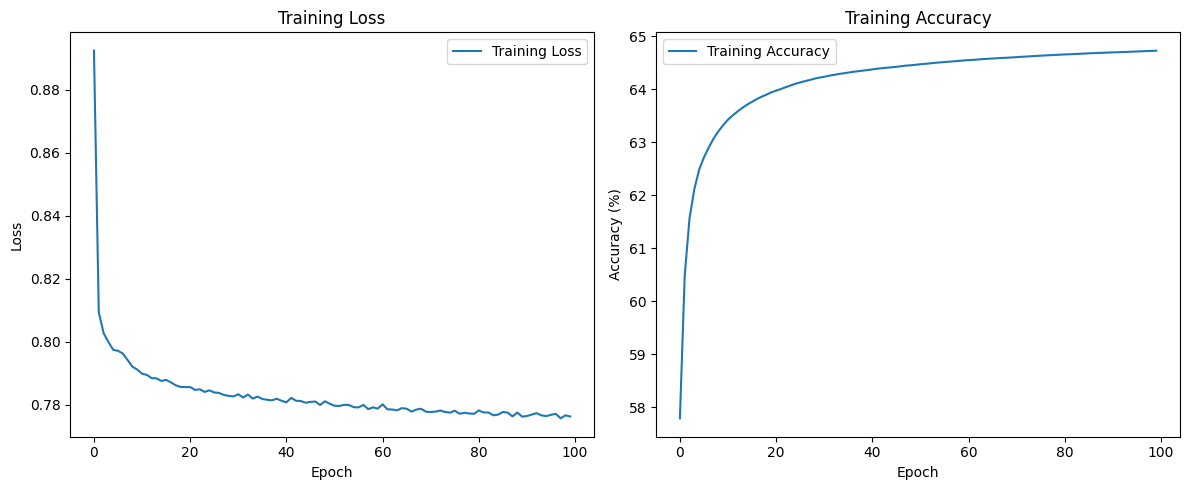

In [41]:
# Plot
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [45]:
#Set model to eval model
model.eval()

#Evaluation Code

total=0
correct=0

with torch.no_grad():
    for batch_features, batch_labels in test_loader:
        outputs=model(batch_features)
        _, predicted=torch.max(outputs,1)

        total = total + batch_labels.shape[0]
        correct= correct+(predicted==batch_labels).sum().item()
accuracy=correct/total

print(f'Evaluation accuracy with model parameters is : {accuracy}')



Evaluation accuracy with model parameters is : 0.6388666666666667
